In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
import torch
import torch_geometric
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from wpca import WPCA, EMPCA
import pandas as pd
from scipy.optimize import curve_fit
import plotly.express as px
import math
import glob

from scipy.stats import norm
from scipy import interpolate
import matplotlib.mlab as mlab
import scipy.stats as scs
import matplotlib.pyplot as plt
import mplhep as hep
import plotly.graph_objects as go

import pickle

import matplotlib
import copy

from matplotlib.colors import LogNorm

import sys
plt.style.use(hep.style.CMS)

sys.path.append('../python/')
# from cleaning import cleaning 
from event import event
sys.path.remove('../python/')

np.set_printoptions(suppress=True)

In [4]:
def cart_from_etaphi(_eta, _phi):
    theta = 2*math.atan(math.exp(-_eta))
    x = math.sin(theta)*math.cos(_phi)
    y = math.sin(theta)*math.sin(_phi)
    z = math.cos(theta)

    return x,y,z

def etaphi_from_cart(_x, _y, _z):
    theta = np.arccos(_z/np.sqrt(_x**2 + _y**2+ _z**2))
    eta   = -np.log(np.tan(theta/2)) #np.log is the natural logarithm
#     phi   = np.sign(_y) * np.arccos(_x/np.sqrt(_x**2+_y**2))
#     phi   = math.atan2(_y,_x)
    phi   = math.atan(_y/_x)

    
    return eta, phi

In [5]:
# Define bin boundaries with same numbers of events
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

# Load data

### With linking

In [5]:
########## ---------------------- CLUE3D noPU ---------------------- ##########
raw_dir='/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4/step3/step4/' #Linking
PileUp = False

########## ---------------------- CLUE3D PU ---------------------- ##########
# raw_dir='/grid_mnt/data__data.polcms/cms/tarabini/electronsPU/step3_ticlv4_clue3d_CMSSW_12_4_0_pre2/step4/'
# PileUp = True

fnamelist = [filepath for filepath in glob.glob(raw_dir+'data*.pt')]

ele_linking = []
j = 0
for i in tqdm(fnamelist):
    idx = torch.load(i)
    ele_linking.append(event(idx,j,PileUp))
    j += 1

0it [00:00, ?it/s]


### Without linking

In [ ]:
########## ---------------------- CLUE3D noPU ---------------------- ##########
raw_dir='/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4/step3_noLinking/step4/'
PileUp = False

########## ---------------------- CLUE3D PU ---------------------- ##########
# raw_dir='/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4_PU/step3_noLinking/step4/'
# PileUp = True

fnamelist = [filepath for filepath in glob.glob(raw_dir+'data*.pt')]

ele_noLinking = []
j = 0
for i in tqdm(fnamelist):
    idx = torch.load(i)
    ele_noLinking.append(event(idx,j,PileUp))
    j += 1
#     if j == 100:
#         break

In [6]:
# raw_dir          = '/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4/step3_simTrackInfo/step4/eventDump/'
# raw_dir_opposite = '/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4_oppositeSign_new/step3_simTrackInfo/step4/eventDump/'

raw_dir          = '/grid_mnt/data_cms_upgrade/tarabini/electrons_pre4/step3_simTrackInfo/step4/eventDump/'
raw_dir_opposite = '/grid_mnt/data_cms_upgrade/tarabini/electrons_pre4_oppositeSign_new/step3_simTrackInfo/step4/eventDump/'

fnamelist        = [filepath for filepath in glob.glob(raw_dir+'eventDump_*')] + [filepath for filepath in glob.glob(raw_dir_opposite+'eventDump_*')]
ele_noLinking    = []

j = 0
for filename in tqdm(fnamelist):
    with open(filename, 'rb') as file:
        while True:
            try:
                obj = pickle.load(file)
                ele_noLinking.append(obj)
            except EOFError:
                break
#     if j == 3:
#         break
#     j += 1
                
ele_noLinking = np.concatenate(np.array(ele_noLinking, dtype=object))

100%|██████████| 800/800 [10:29<00:00,  1.27it/s]


### Without linking (PU)
We load the "event" objects by using pickle

In [193]:
raw_dir          = '/grid_mnt/data__data.polcms/cms/tarabini/electrons_pre4_PU/step3_noLinking/step4/eventDump/'
fnamelist        = [filepath for filepath in glob.glob(raw_dir+'eventDump_*')]
ele_noLinking_PU = []

j = 0
for filename in tqdm(fnamelist):
    with open(filename, 'rb') as file:
        while True:
            try:
                obj = pickle.load(file)
                ele_noLinking_PU.append(obj)
            except EOFError:
                break
    if j == 10:
        break
    j += 1
                
ele_noLinking_PU = np.array(ele_noLinking_PU).flatten()

  2%|▎         | 10/400 [02:23<1:33:29, 14.38s/it]


### Choice of set of tracksters to be used

In [7]:
# ele = ele_linking
ele = ele_noLinking
# ele = ele_noLinking_PU

# Gen-matching test

In [31]:
ratios = []
ratios_g3 = []
ratios_g4 = []
ratios_g5 = []
ratios_g10 = []
ratios_noSkim = []
for cut in range(len([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120])):
    ratios.append(np.mean([len(el.multi_en[(el.skim==False)&(el.genMatching_test[cut])]) / len(el.multi_en[(el.skim==False)])  for el in ele if len(el.multi_en[(el.skim==False)])>0]))
    ratios_g3.append(np.mean([len(el.multi_en[(el.skim==False)&(el.genMatching_test[cut])&(el.multi_en>3)]) / len(el.multi_en[(el.skim==False)&(el.multi_en>3)])  for el in ele if len(el.multi_en[(el.skim==False)&(el.multi_en>3)])>0]))
    ratios_g4.append(np.mean([len(el.multi_en[(el.skim==False)&(el.genMatching_test[cut])&(el.multi_en>4)]) / len(el.multi_en[(el.skim==False)&(el.multi_en>4)])  for el in ele if len(el.multi_en[(el.skim==False)&(el.multi_en>4)])>0]))
    ratios_g5.append(np.mean([len(el.multi_en[(el.skim==False)&(el.genMatching_test[cut])&(el.multi_en>5)]) / len(el.multi_en[(el.skim==False)&(el.multi_en>5)])  for el in ele if len(el.multi_en[(el.skim==False)&(el.multi_en>5)])>0]))
    ratios_g10.append(np.mean([len(el.multi_en[(el.skim==False)&(el.genMatching_test[cut])&(el.multi_en>10)]) / len(el.multi_en[(el.skim==False)&(el.multi_en>10)])  for el in ele if len(el.multi_en[(el.skim==False)&(el.multi_en>10)])>0]))
    ratios_noSkim.append(np.mean([len(el.multi_en[(el.genMatching_test[cut])]) / len(el.multi_en)  for el in ele if len(el.multi_en)>0]))


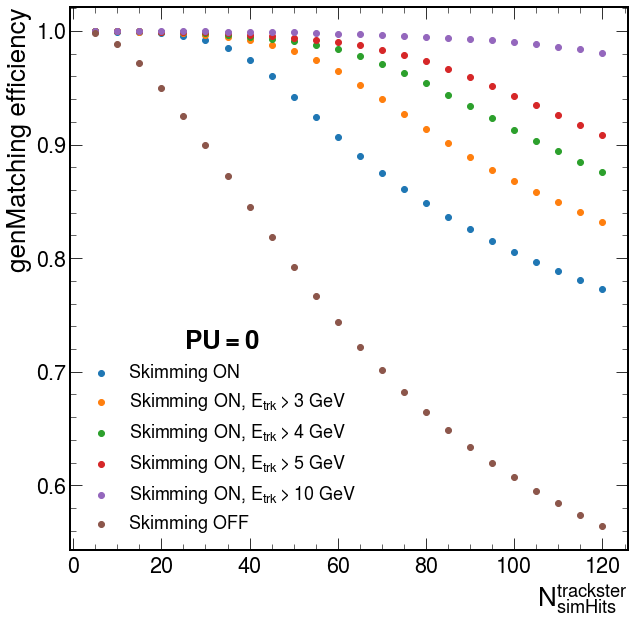

In [48]:
plt.scatter([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120], ratios, label='Skimming ON')
plt.scatter([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120], ratios_g3, label=r'Skimming ON, $E_{\rm trk}>3$ GeV')
plt.scatter([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120], ratios_g4, label=r'Skimming ON, $E_{\rm trk}>4$ GeV')
plt.scatter([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120], ratios_g5, label=r'Skimming ON, $E_{\rm trk}>5$ GeV')
plt.scatter([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120], ratios_g10, label=r'Skimming ON, $E_{\rm trk}>10$ GeV')
plt.scatter([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120], ratios_noSkim, label='Skimming OFF', )

plt.xlabel(r'$N_{\rm simHits}^{\rm trackster}$')
plt.ylabel('genMatching efficiency')
plt.legend(fontsize=18, ncol=1, title=r'$\bf{PU=0}$')
plt.show()

# SimTracks 

Seed using the tracksters. I check the seed among the tracksters (largest pT). Then I check the SimTracks contributing to the trackster and find the PID of the SimTrack that contributes the most

In [215]:
seed = np.array([el.simClusters_pid[np.argmax(el.simClustersLinking_perc[np.argsort(el.multi_pt[el.skim==False])[-1]])] for el in ele if len(el.multi_pt[el.skim==False])>0])
idx = np.array([i for i,el in enumerate(ele) if len(el.multi_pt[el.skim==False])>0])

np.unique(seed, return_counts=True)

(array([-11.,  11.,  22., 211.], dtype=float32),
 array([25923, 25776, 24519,     2]))

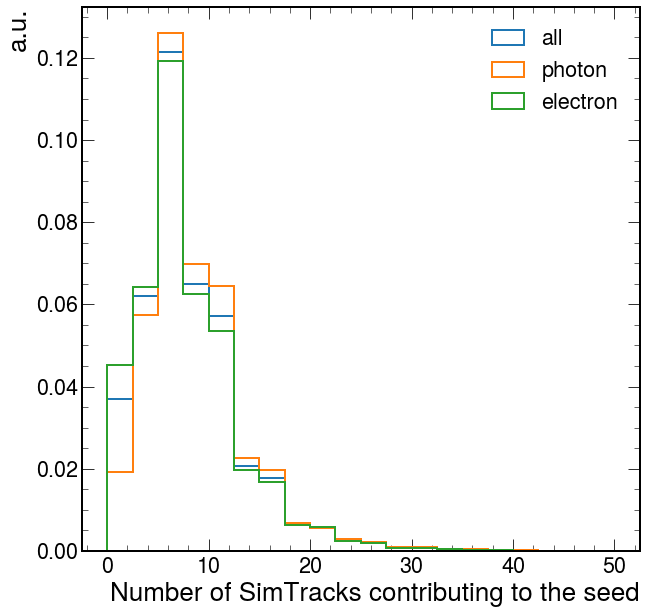

In [76]:
#Check the number of SimTracks contributing to the seed

seed = np.array([el.simClusters_pid[np.argmax(el.simClustersLinking_perc[np.argsort(el.multi_pt[el.skim==False])[-1]])] for el in ele if len(el.multi_pt[el.skim==False])>0])
nSimTracks = np.array([len(el.simClustersLinking_perc[np.argsort(el.multi_pt[el.skim==False])[-1]][el.simClustersLinking_perc[np.argsort(el.multi_pt[el.skim==False])[-1]]>0]) for el in ele if len(el.multi_pt[el.skim==False])>0])

plt.hist(nSimTracks[nSimTracks!=0], histtype='step', bins=20, range=[0,50], lw=2, density=True, label='all')
plt.hist(nSimTracks[(nSimTracks!=0) & (seed==22)], histtype='step', bins=20, range=[0,50], lw=2, density=True, label='photon')
plt.hist(nSimTracks[(nSimTracks!=0) & (abs(seed)==11)], histtype='step', bins=20, range=[0,50], lw=2, density=True, label='electron')
plt.xlabel('Number of SimTracks contributing to the seed')
plt.legend()
plt.ylabel('a.u.')
# plt.yscale('log')
plt.show()

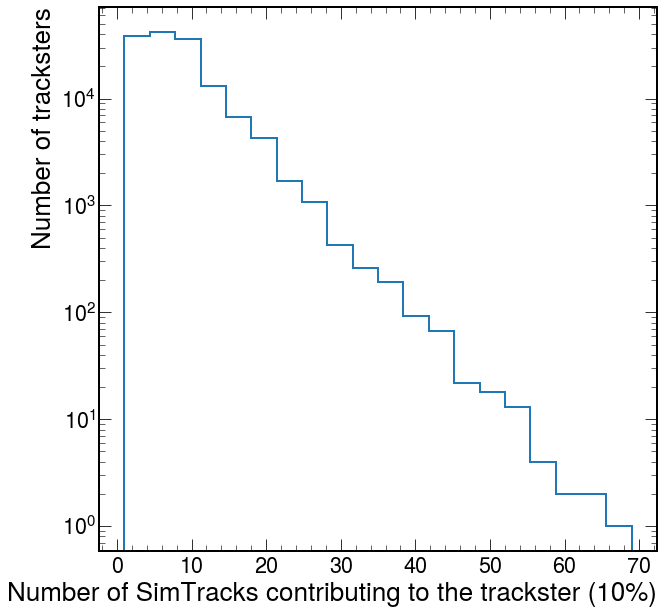

In [482]:
#Check the energetic SimTrack composition of each trackster

x = np.array([len(np.where(trk[trk!=0])[0]) for el in ele for trk in el.simClustersLinking_perc[el.skim==False]])

plt.hist(x, histtype='step', bins=20, lw=2)
plt.xlabel('Number of SimTracks contributing to the trackster')
plt.ylabel('Number of tracksters')
plt.yscale('log')
plt.show()

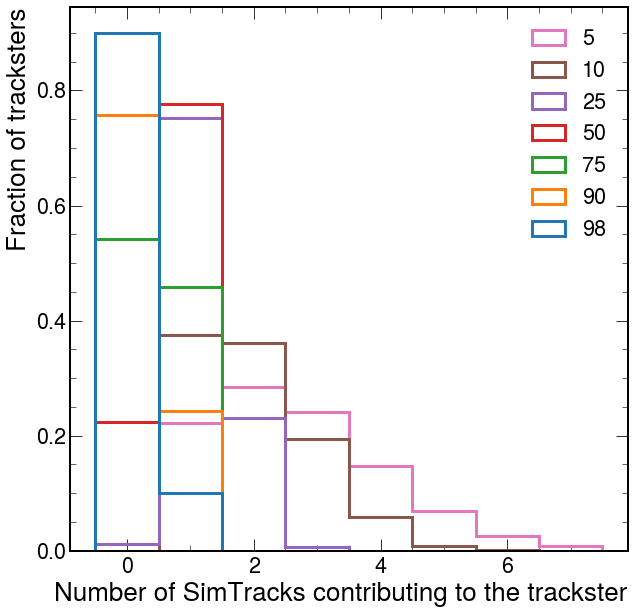

In [441]:
#Check the energetic SimTrack composition of each trackster

x = []
fracs = [98, 90, 75, 50, 25, 10, 5]
for i in fracs:
    x.append(np.array([len(np.where(trk[trk!=0]>i)[0]) for el in ele for trk in el.simClustersLinking_perc[el.skim==False]]))

n, bins, _ = plt.hist(x, histtype='step', bins=8, range=[-0.5,7.5], lw=3, density=True, label=fracs)

plt.xlabel('Number of SimTracks contributing to the trackster')
plt.ylabel('Fraction of tracksters')
plt.legend()
# plt.yscale('log')
plt.show()

In [94]:
color_simTrack = {
    11  : 'tab:blue',
    -11 : 'tab:blue',
    22  : 'tab:red',
    211 : 'tab:orange',
    -211 : 'tab:orange',
    2112: 'tab:pink',
    -2112: 'tab:pink',
    2212: 'tab:pink',
    -2212: 'tab:pink',
    1000010048: 'tab:pink',
    111: 'tab:orange'
}

color_simTrack_3d = {
    11  : 'blue',
    -11 : 'blue',
    22  : 'red',
    211 : 'orange',
    -211 : 'orange',
    2112: 'pink',
    -2112: 'pink',
    2212: 'pink',
    -2212: 'pink',
    1000010048: 'pink',
    111: 'orange'
}


def simTracksDisplay(_ele):

    posidx = []
    negidx = []

    fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(40,15))
#     fig_3d = go.Figure()


    mult= 5
    seedSimTrack = np.argmax(_ele.simTrack_energy)
    
    for simTrack in range(len(_ele.simTrack_ox)):
#         if simTrack != 15 and simTrack != 20: continue
        
        if _ele.simTrack_energy[simTrack]<0.5: continue

        ax0.scatter(_ele.simTrack_ox[simTrack], _ele.simTrack_oy[simTrack], color=color_simTrack[int(_ele.simTrack_PID[simTrack])])
        ax1.scatter(_ele.simTrack_ox[simTrack], _ele.simTrack_oz[simTrack], color=color_simTrack[int(_ele.simTrack_PID[simTrack])])
        ax2.scatter(_ele.simTrack_oy[simTrack], _ele.simTrack_oz[simTrack], color=color_simTrack[int(_ele.simTrack_PID[simTrack])])
        
        ax0.scatter(_ele.simTrack_fx[simTrack], _ele.simTrack_fy[simTrack], color=color_simTrack[int(_ele.simTrack_PID[simTrack])], marker='*' )
        ax1.scatter(_ele.simTrack_fx[simTrack], _ele.simTrack_fz[simTrack], color=color_simTrack[int(_ele.simTrack_PID[simTrack])], marker='*')
        ax2.scatter(_ele.simTrack_fy[simTrack], _ele.simTrack_fz[simTrack], color=color_simTrack[int(_ele.simTrack_PID[simTrack])], marker='*')
        
        x = np.array([_ele.simTrack_trkx[simTrack][0], _ele.simTrack_trkx[simTrack][1], _ele.simTrack_trkx[simTrack][2], _ele.simTrack_trkx[simTrack][3], _ele.simTrack_fx[simTrack]])
        y = np.array([_ele.simTrack_trky[simTrack][0], _ele.simTrack_trky[simTrack][1], _ele.simTrack_trky[simTrack][2], _ele.simTrack_trky[simTrack][3], _ele.simTrack_fy[simTrack]])
        z = np.array([_ele.simTrack_trkz[simTrack][0], _ele.simTrack_trkz[simTrack][1], _ele.simTrack_trkz[simTrack][2], _ele.simTrack_trkz[simTrack][3], _ele.simTrack_fz[simTrack]])
        
        
#         if simTrack==15 or simTrack==22 or simTrack==27 or simTrack==34: continue #Uncomment these lines to run it on event 39957 (event with a lot of hadronic activity)
        tck, u = interpolate.splprep([x, y, z], s=0)  # s=0 means interpolation without smoothing

        u_new = np.linspace(0, 1, 100)  # 100 points along the spline curve
        points_on_spline = np.array(interpolate.splev(u_new, tck)).T  # Transpose to get (x, y, z) coordinates

        # Project the spline onto XY-plane, XZ-plane, and YZ-plane
        points_on_xy_plane = points_on_spline[:, :2]  # (x, y) coordinates for XY-plane
        points_on_xz_plane = np.column_stack((points_on_spline[:, 0], points_on_spline[:, 2]))  # (x, z) coordinates for XZ-plane
        points_on_yz_plane = points_on_spline[:, 1:]  # (y, z) coordinates for YZ-plane

        ax0.plot(points_on_xy_plane[:,0], 
                 points_on_xy_plane[:,1], 
                 color=color_simTrack[int(_ele.simTrack_PID[simTrack])])#, lw=mult*_ele.simTrack_energy[simTrack]/_ele.simTrack_energy[seedSimTrack])
        ax1.plot(points_on_xz_plane[:,0], 
                 points_on_xz_plane[:,1], 
                 color=color_simTrack[int(_ele.simTrack_PID[simTrack])])#, lw=mult*_ele.simTrack_energy[simTrack]/_ele.simTrack_energy[seedSimTrack])
        ax2.plot(points_on_yz_plane[:,0], 
                 points_on_yz_plane[:,1], 
                 color=color_simTrack[int(_ele.simTrack_PID[simTrack])])#, lw=mult*_ele.simTrack_energy[simTrack]/_ele.simTrack_energy[seedSimTrack])

        # Add a 3D line trace
#         fig_3d.add_trace(go.Scatter3d(
#             x=x,
#             y=y,
#             z=z,
#             mode='lines',
#             line=dict(color=color_simTrack_3d[int(_ele.simTrack_PID[simTrack])], width=2)
#         ))

    

    ax0.scatter(_ele.simHit_x, _ele.simHit_y, s=_ele.simHit_en*10, color='grey')
    ax1.scatter(_ele.simHit_x, _ele.simHit_z, s=_ele.simHit_en*10, color='grey')
    ax2.scatter(_ele.simHit_y, _ele.simHit_z, s=_ele.simHit_en*10, color='grey')
    

    ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax0.set_ylabel('y', fontsize = 25, fontweight = 'bold')
    
    ax1.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax1.set_ylabel('z', fontsize = 25, fontweight = 'bold')
    
    ax2.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax2.set_ylabel('z', fontsize = 25, fontweight = 'bold')


    # def forward(x):
    #     return x**1.5

    # def reverse(x):
    #     return x**(1/1.5)

    # ax1.set_xscale('function', functions=(forward, reverse))
    # ax1.set_xlim(0, 70)

    enMultiplier = 30

    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching : continue
        ax0.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.4)
        ax1.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.4)

        ax2.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.4)


#         clusE = clus_en[evt][multi_clus2d[evt][i]].flatten()
#         clusX = clus_x[evt][multi_clus2d[evt][i]].flatten()
#         clusY = clus_y[evt][multi_clus2d[evt][i]].flatten()
#         clusZ = clus_z[evt][multi_clus2d[evt][i]].flatten()

#         ax0.scatter(clusX,clusY,s=clusE*10,alpha=0.5)
#         ax1.scatter(clusX,clusZ,s=clusE*10,alpha=0.5)
#         ax2.scatter(clusY,clusZ,s=clusE*10,alpha=0.5)


    ax1.set_ylim([290,360])
    ax1.set_xlim([90,140])
    plt.show()
    
    

#     fig_3d.update_layout(
#         width=1500,  # set width to 800 pixels
#         height=1200  # set height to 600 pixels
#     )
#     fig_3d.show()
    
    
def simTracksDisplayAtBoundary(_ele):

    fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(40,15))
    for simTrack in range(len(_ele.simTracks_surface_y)):
        if _ele.simTracks_boundary_en[simTrack]<0.1: continue
        ax0.scatter(_ele.simTracks_boundary_x[simTrack], _ele.simTracks_boundary_y[simTrack], color=color_simTrack[int(_ele.simTracks_boundary_id[simTrack])], s=_ele.simTracks_boundary_en[simTrack]*0.5)
        ax1.scatter(_ele.simTracks_boundary_x[simTrack], _ele.simTracks_boundary_z[simTrack], color=color_simTrack[int(_ele.simTracks_boundary_id[simTrack])], s=_ele.simTracks_boundary_en[simTrack]*0.5)
        ax2.scatter(_ele.simTracks_boundary_y[simTrack], _ele.simTracks_boundary_z[simTrack], color=color_simTrack[int(_ele.simTracks_boundary_id[simTrack])], s=_ele.simTracks_boundary_en[simTrack]*0.5)
        
        ax0.scatter(_ele.simTracks_HGCALfromBoundary_x[simTrack], _ele.simTracks_HGCALfromBoundary_y[simTrack], color='black')
        ax1.scatter(_ele.simTracks_HGCALfromBoundary_x[simTrack], _ele.simTracks_HGCALfromBoundary_z[simTrack], color='black')
        ax2.scatter(_ele.simTracks_HGCALfromBoundary_y[simTrack], _ele.simTracks_HGCALfromBoundary_z[simTrack], color='black')

        enMultiplier = 30
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching : continue
            ax0.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.4)
            ax1.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.4)
            ax2.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.4)
            
    plt.show()

IndexError: index 153 is out of bounds for dimension 0 with size 153

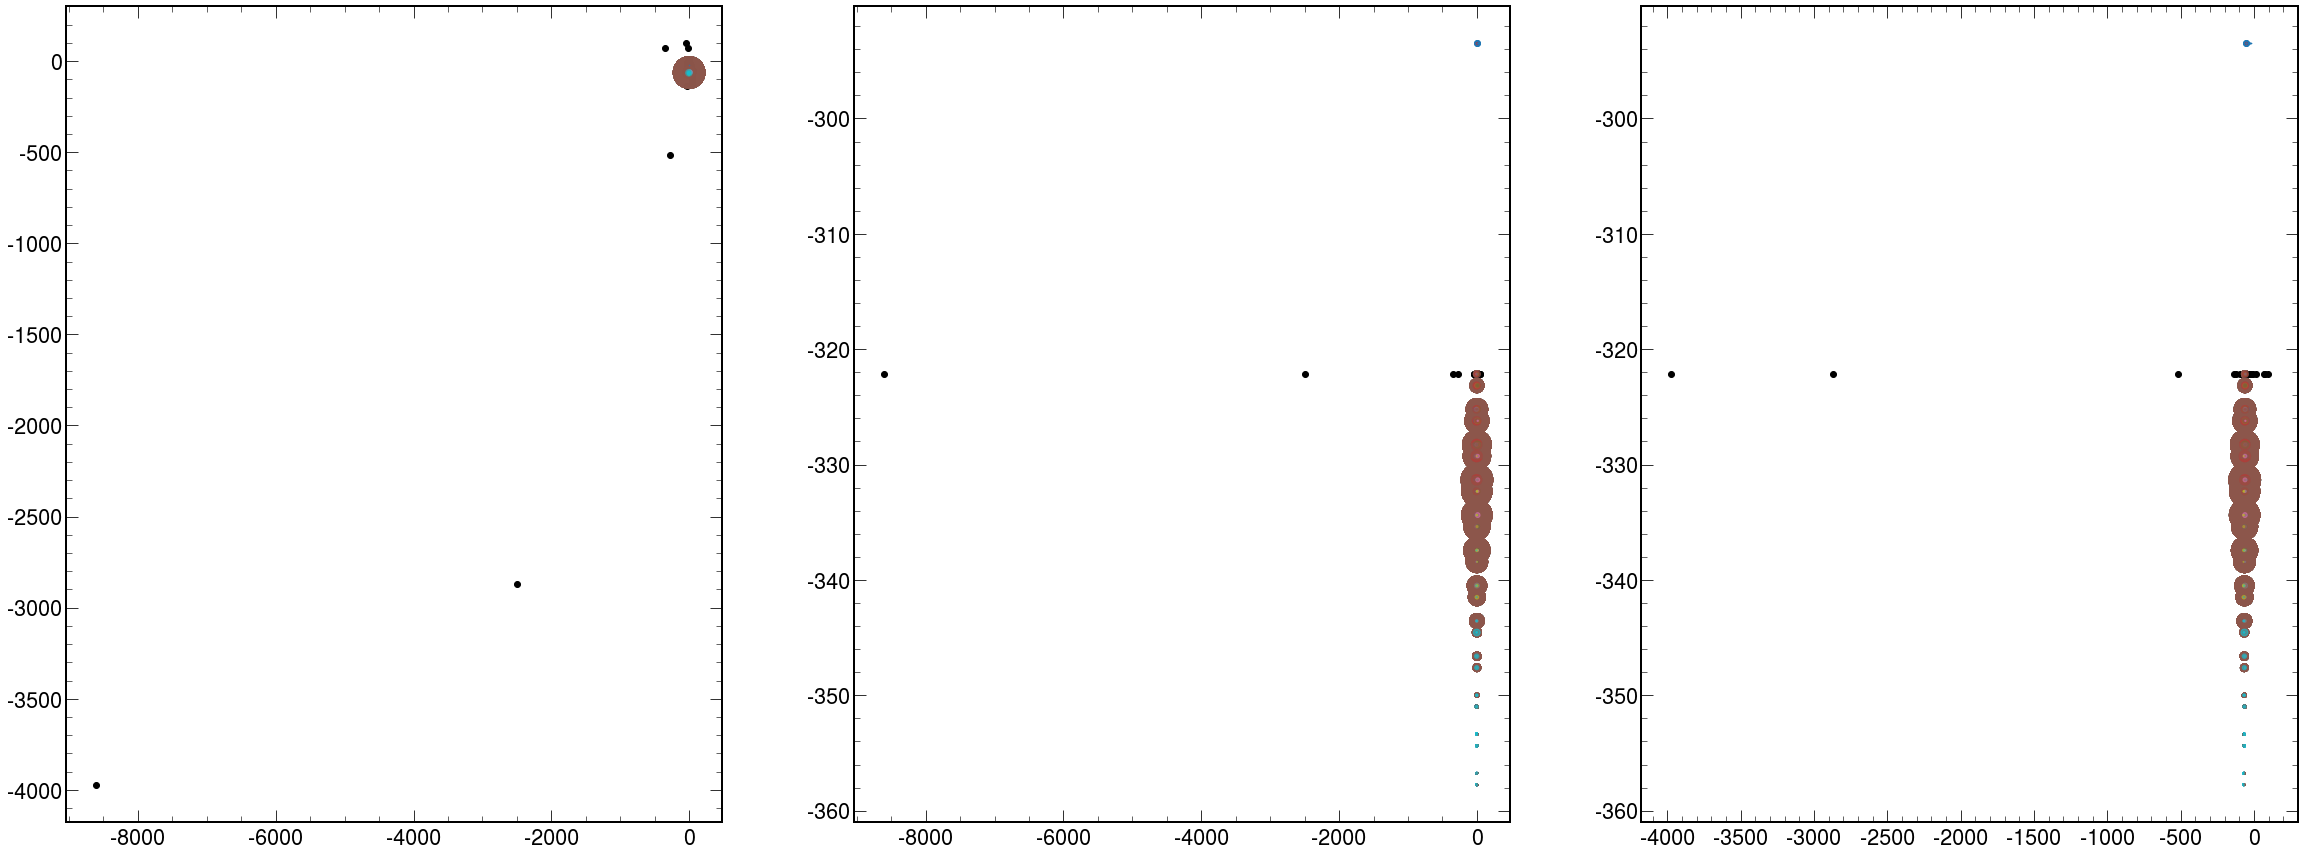

In [153]:
simTracksDisplayAtBoundary(ele[13814])

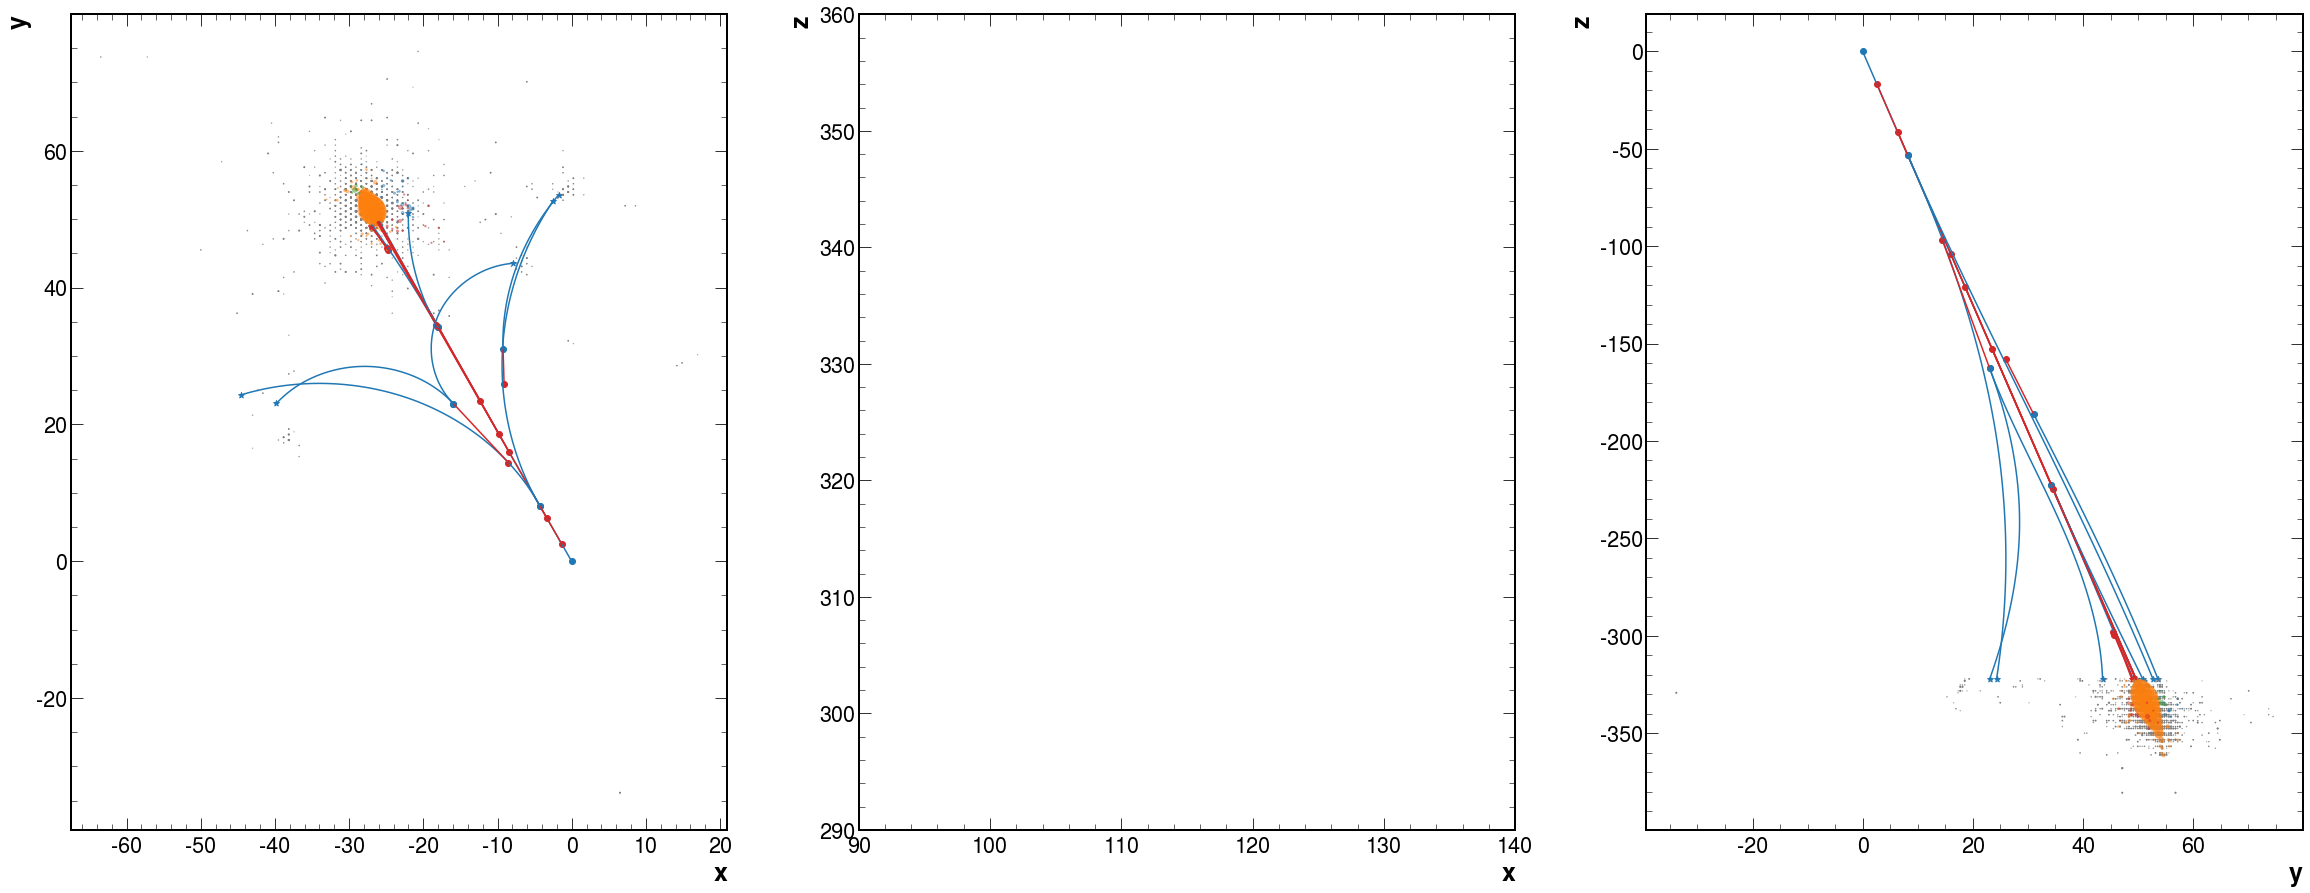

In [188]:
simTracksDisplay(ele[215])

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


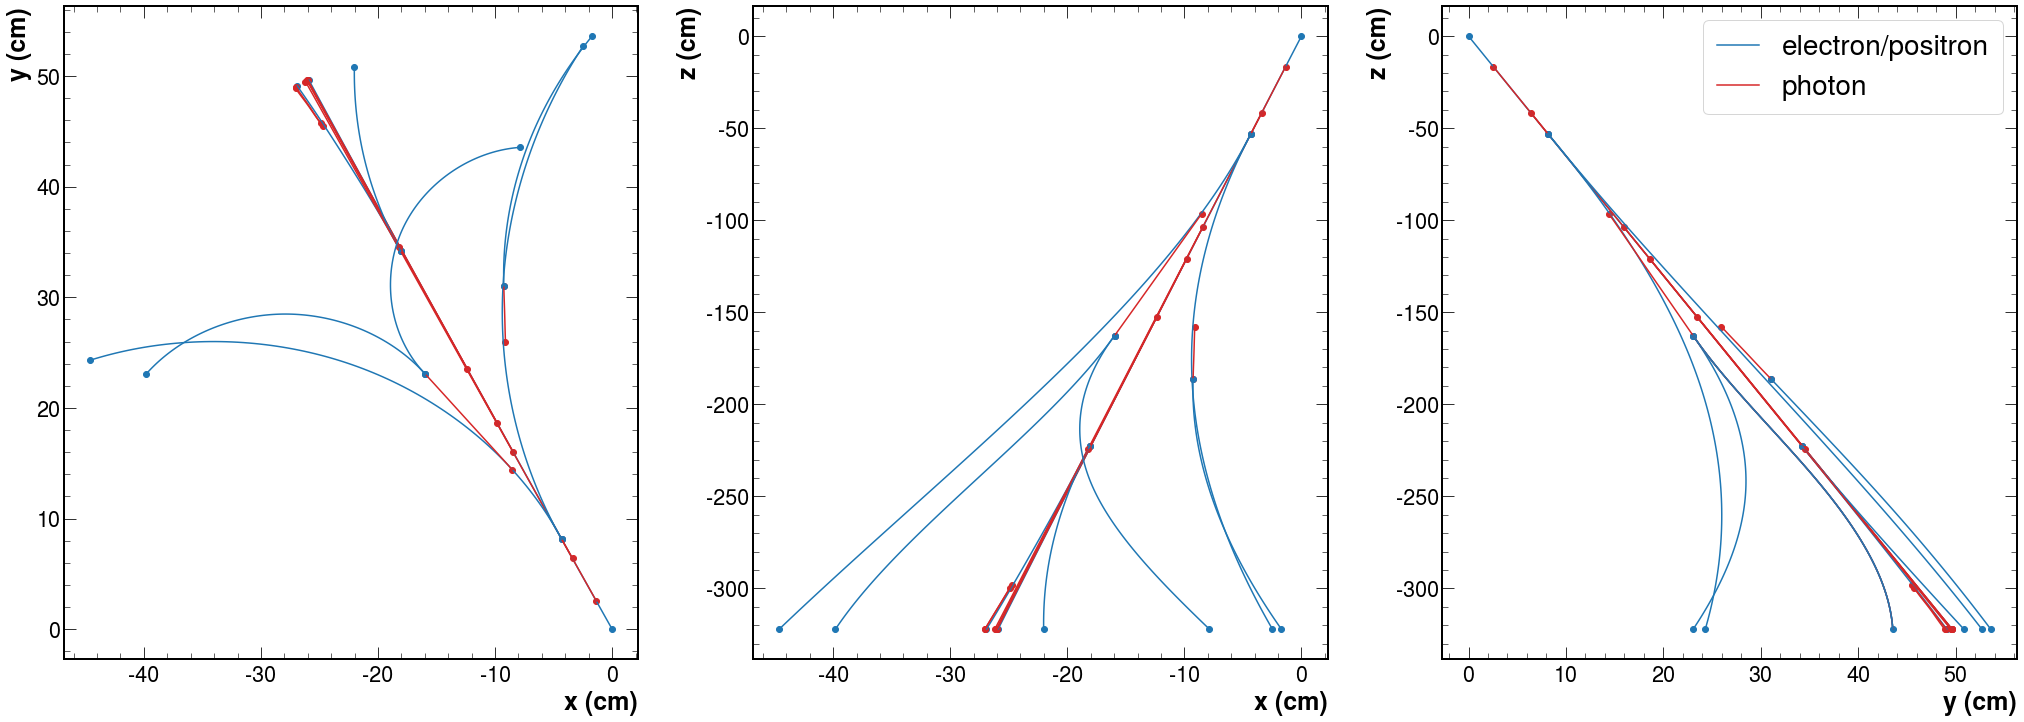

In [409]:
#### For thesis
evt = 215

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(35,12))
#     fig_3d = go.Figure()


mult= 5
seedSimTrack = np.argmax(ele[evt].simTrack_energy)

for simTrack in range(len(ele[evt].simTrack_ox)):
#         if simTrack != 15 and simTrack != 20: continue

    if ele[evt].simTrack_energy[simTrack]<0.5: continue

    ax0.scatter(ele[evt].simTrack_ox[simTrack], ele[evt].simTrack_oy[simTrack], color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])
    ax1.scatter(ele[evt].simTrack_ox[simTrack], ele[evt].simTrack_oz[simTrack], color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])
    ax2.scatter(ele[evt].simTrack_oy[simTrack], ele[evt].simTrack_oz[simTrack], color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])

    ax0.scatter(ele[evt].simTrack_fx[simTrack], ele[evt].simTrack_fy[simTrack], color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])
    ax1.scatter(ele[evt].simTrack_fx[simTrack], ele[evt].simTrack_fz[simTrack], color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])
    ax2.scatter(ele[evt].simTrack_fy[simTrack], ele[evt].simTrack_fz[simTrack], color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])

    x = np.array([ele[evt].simTrack_trkx[simTrack][0], ele[evt].simTrack_trkx[simTrack][1], ele[evt].simTrack_trkx[simTrack][2], ele[evt].simTrack_trkx[simTrack][3], ele[evt].simTrack_fx[simTrack]])
    y = np.array([ele[evt].simTrack_trky[simTrack][0], ele[evt].simTrack_trky[simTrack][1], ele[evt].simTrack_trky[simTrack][2], ele[evt].simTrack_trky[simTrack][3], ele[evt].simTrack_fy[simTrack]])
    z = np.array([ele[evt].simTrack_trkz[simTrack][0], ele[evt].simTrack_trkz[simTrack][1], ele[evt].simTrack_trkz[simTrack][2], ele[evt].simTrack_trkz[simTrack][3], ele[evt].simTrack_fz[simTrack]])


#         if simTrack==15 or simTrack==22 or simTrack==27 or simTrack==34: continue #Uncomment these lines to run it on event 39957 (event with a lot of hadronic activity)
    tck, u = interpolate.splprep([x, y, z], s=0)  # s=0 means interpolation without smoothing

    u_new = np.linspace(0, 1, 100)  # 100 points along the spline curve
    points_on_spline = np.array(interpolate.splev(u_new, tck)).T  # Transpose to get (x, y, z) coordinates

    # Project the spline onto XY-plane, XZ-plane, and YZ-plane
    points_on_xy_plane = points_on_spline[:, :2]  # (x, y) coordinates for XY-plane
    points_on_xz_plane = np.column_stack((points_on_spline[:, 0], points_on_spline[:, 2]))  # (x, z) coordinates for XZ-plane
    points_on_yz_plane = points_on_spline[:, 1:]  # (y, z) coordinates for YZ-plane

    ax0.plot(points_on_xy_plane[:,0], 
             points_on_xy_plane[:,1], 
             color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])#, lw=mult*ele[evt].simTrack_energy[simTrack]/ele[evt].simTrack_energy[seedSimTrack])
    ax1.plot(points_on_xz_plane[:,0], 
             points_on_xz_plane[:,1], 
             color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])#, lw=mult*ele[evt].simTrack_energy[simTrack]/ele[evt].simTrack_energy[seedSimTrack])
    ax2.plot(points_on_yz_plane[:,0], 
             points_on_yz_plane[:,1], 
             color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])#, lw=mult*ele[evt].simTrack_energy[simTrack]/ele[evt].simTrack_energy[seedSimTrack])

    ax0.set_xlabel('x (cm)', fontsize = 25, fontweight = 'bold')
    ax0.set_ylabel('y (cm)', fontsize = 25, fontweight = 'bold')
    
    ax1.set_xlabel('x (cm)', fontsize = 25, fontweight = 'bold')
    ax1.set_ylabel('z (cm)', fontsize = 25, fontweight = 'bold')
    
    ax2.set_xlabel('y (cm)', fontsize = 25, fontweight = 'bold')
    ax2.set_ylabel('z (cm)', fontsize = 25, fontweight = 'bold')
    
## Just for the legend.
## Stupid but effective method to have the two entries in the legend
## Take the last simTrack, plot it in blue (and add entry), plot in red (and add entry), and then plot in the original color
ax2.plot(points_on_yz_plane[:,0], 
         points_on_yz_plane[:,1], 
         color='tab:blue', label='electron/positron')#, lw=mult*ele[evt].simTrack_energy[simTrack]/ele[evt].simTrack_energy[seedSimTrack])

ax2.plot(points_on_yz_plane[:,0], 
         points_on_yz_plane[:,1], 
         color='tab:red', label='photon')#, lw=mult*ele[evt].simTrack_energy[simTrack]/ele[evt].simTrack_energy[seedSimTrack])

ax2.plot(points_on_yz_plane[:,0], 
         points_on_yz_plane[:,1], 
         color=color_simTrack[int(ele[evt].simTrack_PID[simTrack])])#, lw=mult*ele[evt].simTrack_energy[simTrack]/ele[evt].simTrack_energy[seedSimTrack])

ax2.legend(frameon=True, fontsize=28)
plt.savefig('eventTracker.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [379]:
def deltaphi(a, b):
    diff = a - b
    return (diff + np.pi) % (2*np.pi) - np.pi
deltaphi = np.vectorize(deltaphi)

simTracksDeltas = {}
for enCut in [0, 0.1, 0.5, 1, 1.5, 2, 5]:
    simTracksDeltas_tmp      = []
    for idx,ev in tqdm(enumerate(ele)):

#         sel = ev.simTracks_boundary_en>enCut #Energy cut on the SimTracks
        sel = ev.simTracks_boundary_pt>enCut #Energy cut on the SimTracks

        if len(ev.simTracks_boundary_pt[sel])==0: continue
        maxidx  = np.argmax(ev.simTracks_boundary_pt[sel]) #index of maxPt trackster
        maxeta  = float(ev.simTracks_boundary_eta[sel][maxidx])
        maxphi  = float(ev.simTracks_boundary_phi[sel][maxidx])


        #Fill pandas
        nTracksters = len(ev.simTracks_boundary_eta[sel])
        simTracksDeltas_tmp.append([idx,
                                np.array([float(abs(ev.simTracks_boundary_eta[sel][j]) - abs(maxeta)) for j in range(nTracksters)]),  # DeltaEta (barycenter)
                                np.array([deltaphi(ev.simTracks_boundary_phi[sel][j], maxphi) for j in range(nTracksters)]),          # DeltaPhi (barycenter)
                                maxeta, maxphi,                                                                                       # kinematics of the seed (barycenter)
                                float(ev.gunEn)])                                                                                     # genMatching indeces


    simTracksDeltas[enCut] = pd.DataFrame(simTracksDeltas_tmp, 
                                          columns=['idx','DeltaEta', 'DeltaPhi', 'EtaSeed', 'PhiSeed', 'gunEn'])


76268it [01:50, 691.11it/s]
76268it [01:01, 1243.66it/s]
76268it [00:44, 1721.64it/s]
76268it [00:37, 2029.21it/s]
76268it [00:33, 2244.58it/s]
76268it [00:31, 2429.05it/s]
76268it [00:24, 3165.26it/s]


In [376]:
simTracksDeltas.keys()

dict_keys([0, 0.1, 0.5])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


IndexError: list index out of range

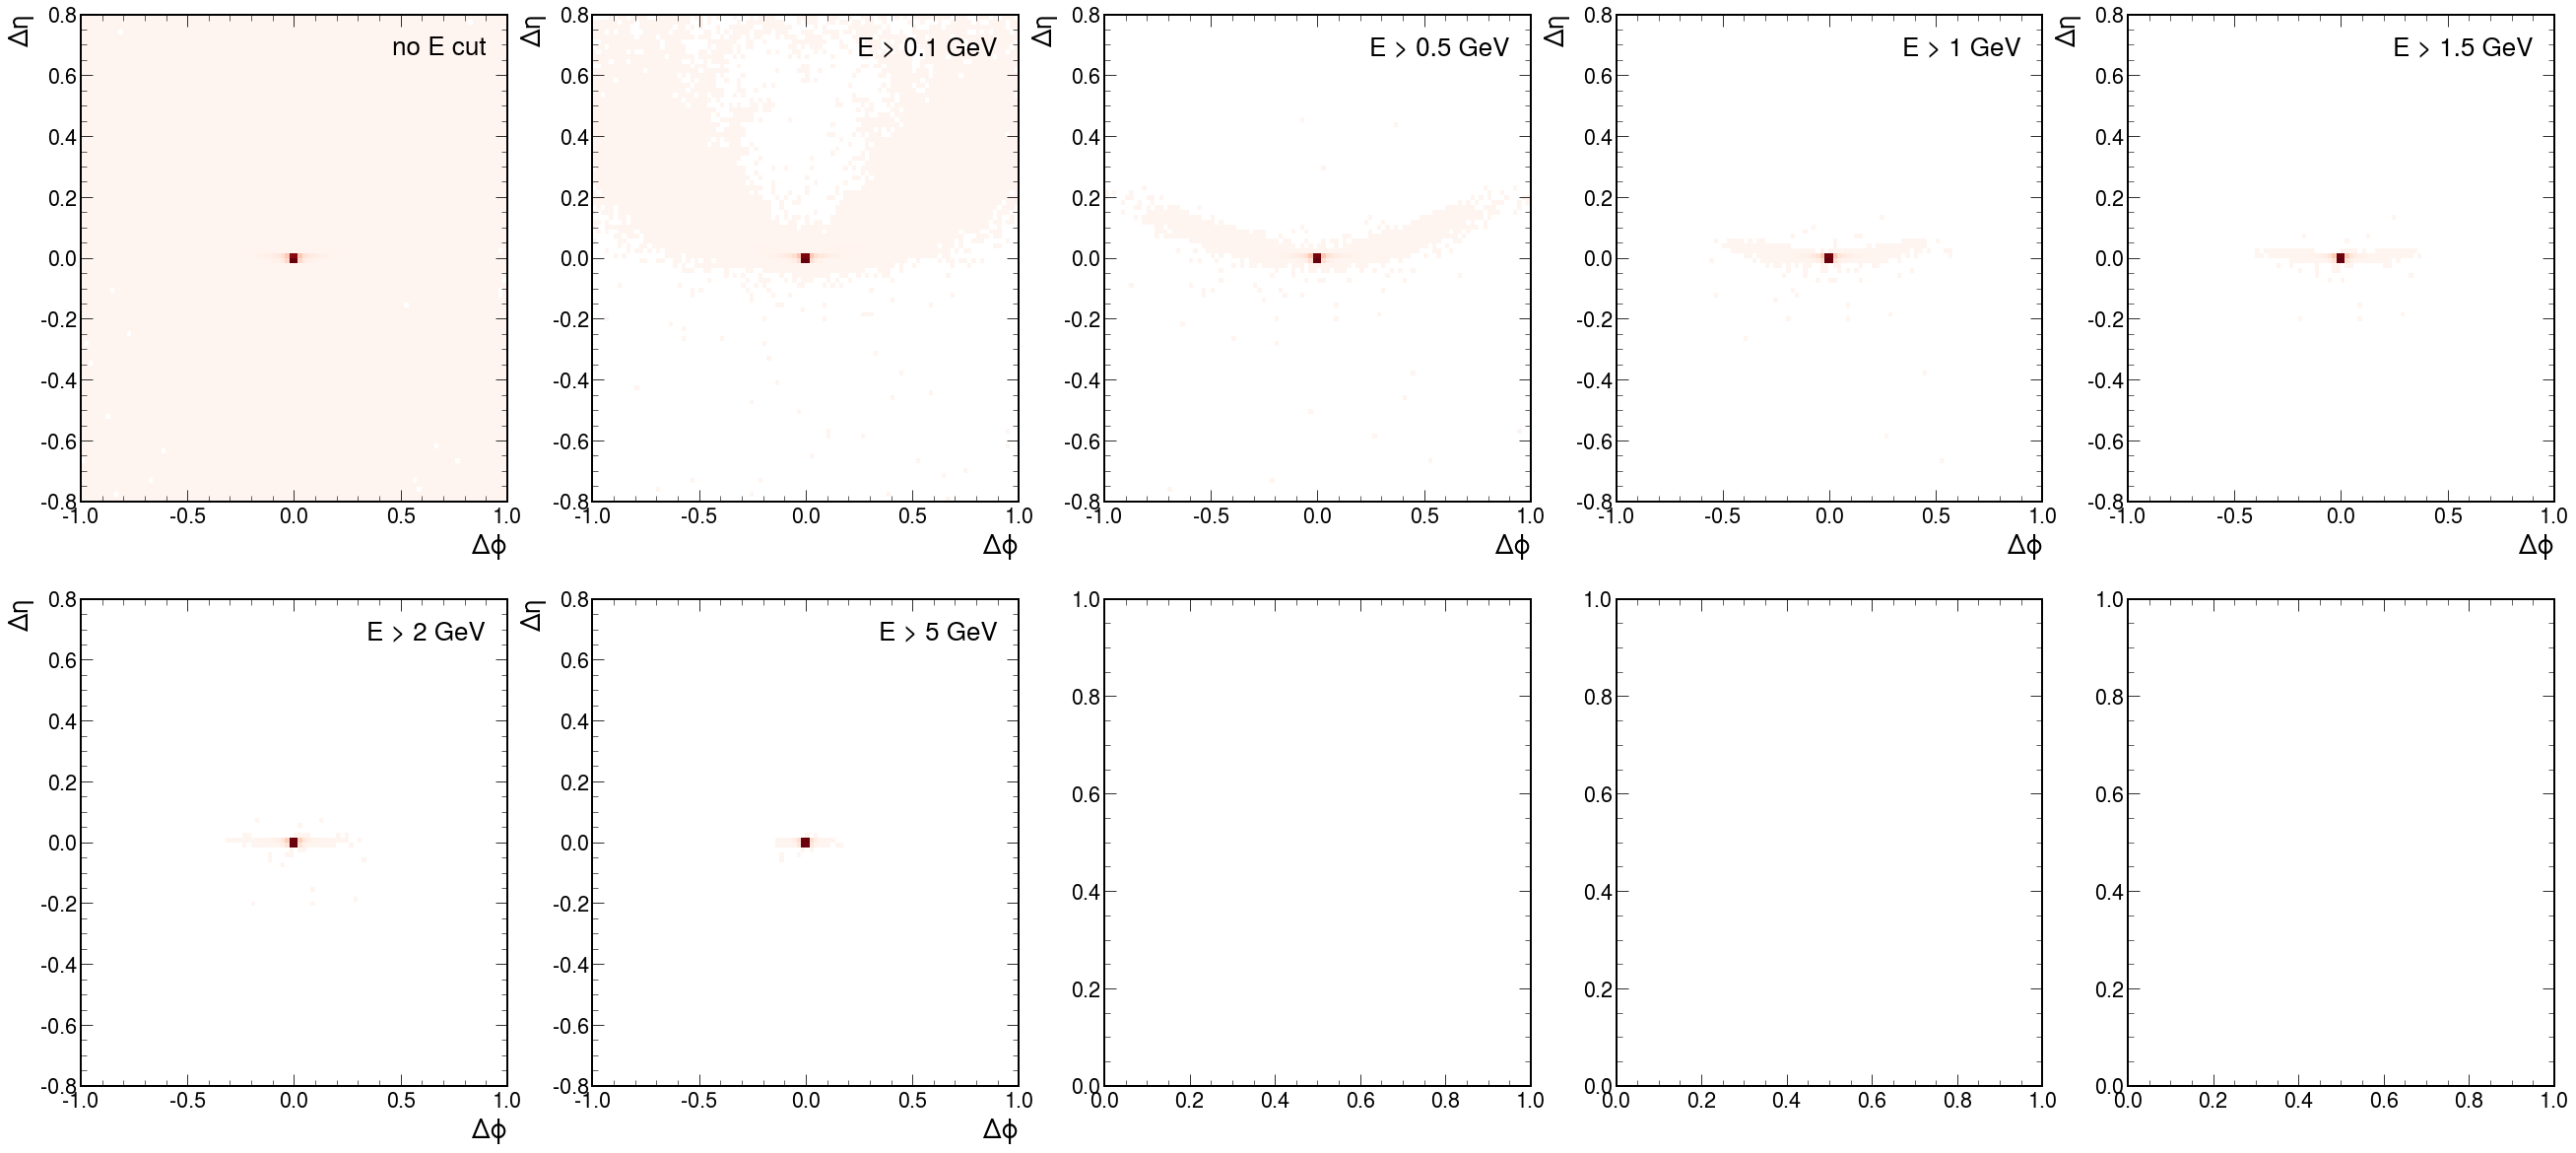

In [383]:
enCuts = [0, 0.1, 0.5, 1, 1.5, 3]

cmap_reds = copy.copy(plt.cm.get_cmap("Reds"))
cmap_reds.set_under('white')

# Fill dicts
dx       = {}
dy       = {}
idx_evt  = 0
for enCut in enCuts:
    dx[enCut] = []
    dy[enCut] = []
    for ev_x, ev_y in zip(simTracksDeltas[enCut]['DeltaEta'], simTracksDeltas[enCut]['DeltaPhi']):
        for trk_idx in range(len(ev_x)):
            # Uncomment the piece of code down to apply a cut on the DeltaPhi between the trackster to retrieve the usual moustahce plot.
            if ev_y[trk_idx] != 0:# and abs(ev_y[trk_idx])>0.02:
                dx[enCut].append(ev_x[trk_idx])
                dy[enCut].append(ev_y[trk_idx])
        idx_evt += 1

        
# Plot dPhi and dEta        
fig, axs = plt.subplots(1, 2, figsize=(25,10))
axs.ravel()

axs[0].hist([dx[0], dx[0.1], dx[0.5], dx[1], dx[1.5]], range = [-3,3], histtype='step', lw=2, bins=50, density=True, label=['no E cut', 'E > 0.1 GeV', 'E > 0.5 GeV', 'E > 1 GeV', 'E > 1.5 GeV'])
axs[0].set_xlabel(r'$\Delta\eta$')
axs[0].set_ylabel(r'a.u.')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].hist([dy[0], dy[0.1], dy[0.5], dy[1], dy[1.5]], range = [-3.14,3.14], histtype='step', lw=2, bins=70, density=True, label=['no E cut', 'E > 0.1 GeV', 'E > 0.5 GeV', 'E > 1 GeV', 'E > 1.5 GeV'])
axs[1].set_xlabel(r'$\Delta\phi$')
axs[1].set_ylabel(r'a.u.')
axs[1].set_yscale('log')
axs[1].legend()

plt.show()


# Plot 2d plots
fig, axs = plt.subplots(1, 5, figsize=(45,10))
axs.ravel()

for i, ax in enumerate(axs):
    ax.hist2d(dy[enCuts[i]],
              dx[enCuts[i]],
              range = [[-1,1],[-0.8,0.8]],
              bins  = [100,100],
              cmap  = cmap_reds, vmin=0.00001)
    ax.set_ylabel(r'$\Delta\eta$')
    ax.set_xlabel(r'$\Delta\phi$')
    if i == 0:
        ax.legend(title='no E cut')
    else:
        ax.legend(title='E > '+str(enCuts[i])+' GeV')

plt.show()

In [354]:
tmp = []
for _ele in ele:
    tmp.append( np.delete(_ele.simTracks_boundary_en, np.argmax(_ele.simTracks_boundary_en)) ) 
tmp = [float(j) for i in tmp for j in i]

In [372]:
np.percentile(tmp,68)

1.6081828737258923

In [357]:
tmp

[0.03637434542179108,
 1.0342698097229004,
 0.0654323548078537,
 1.0728496313095093,
 0.14630666375160217,
 0.14252007007598877,
 0.009971899911761284,
 0.0001487430272391066,
 0.0028091680724173784,
 1.9827756881713867,
 23.131160736083984,
 5.78078556060791,
 1.3212887048721313,
 0.0010028062388300896,
 0.08414581418037415,
 0.02969132550060749,
 3.2302281856536865,
 13.689244270324707,
 7.174267768859863,
 72.87035369873047,
 0.5485903024673462,
 0.0072092702612280846,
 14.838011741638184,
 0.2380027025938034,
 0.03336566686630249,
 0.020747562870383263,
 20.940553665161133,
 3.046308755874634,
 1.9911218881607056,
 0.19501866400241852,
 0.5515897274017334,
 1.0751780271530151,
 22.81648826599121,
 3.7619595527648926,
 0.44656527042388916,
 7.101595878601074,
 0.3860529661178589,
 0.11499843001365662,
 19.450870513916016,
 0.006110439542680979,
 28.113801956176758,
 0.1489420384168625,
 13.528796195983887,
 0.5034394860267639,
 0.7771533131599426,
 0.0003086830547545105,
 0.24890223

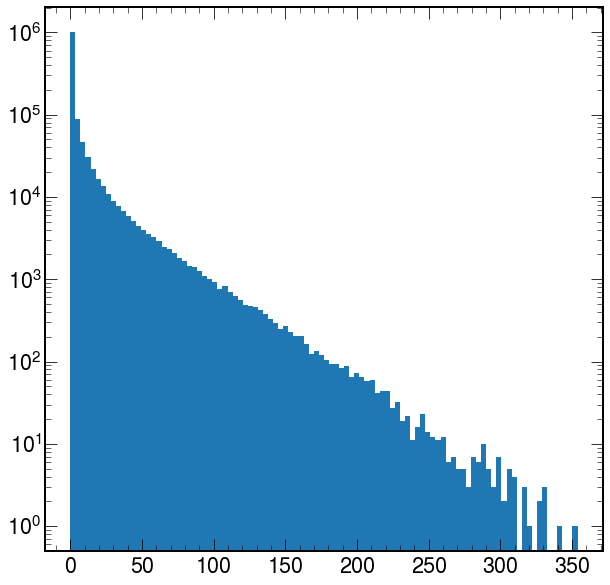

In [358]:
plt.hist(tmp, bins=100)
plt.yscale('log')
plt.show()

### Check the energy reaching HGCAL

In [319]:
nSimTracks  = np.array([len(_ele.simTrack_ox[_ele.simTrack_HGCAL>0]) for _ele in ele])
enSimTracks = np.array([float(sum(_ele.simTracks_boundary_en)) for _ele in ele])
gunEn       = np.array([_ele.gunEn for _ele in ele])
gunEta      = np.array([_ele.gunEta for _ele in ele])
gunPhi      = np.array([_ele.gunPhi for _ele in ele])
idxs        = np.array([i for i in range(len(ele)) ])

x = []
y = []
z = []
evts = []
ratio = enSimTracks/gunEn
# for evt in np.where(ratio<0.8)[0]:
#     for simTrack in range(len(ele[evt].simTrack_fz)): #Loop over simTracks in the event
#         if ele[evt].simTrack_HGCAL[simTrack] != 0 or abs(ele[evt].simTrack_PID[simTrack]) != 11: continue            
#         if not float(ele[evt].simTrack_fz[simTrack]) in np.array(ele[evt].simTrack_oz):
#             x.append(float(ele[evt].simTrack_fx[simTrack]))
#             y.append(float(ele[evt].simTrack_fy[simTrack]))
#             z.append(float(ele[evt].simTrack_fz[simTrack]))
#             evts.append(evt)
# evts  = np.array(evts)
# ratio = np.array(ratio)

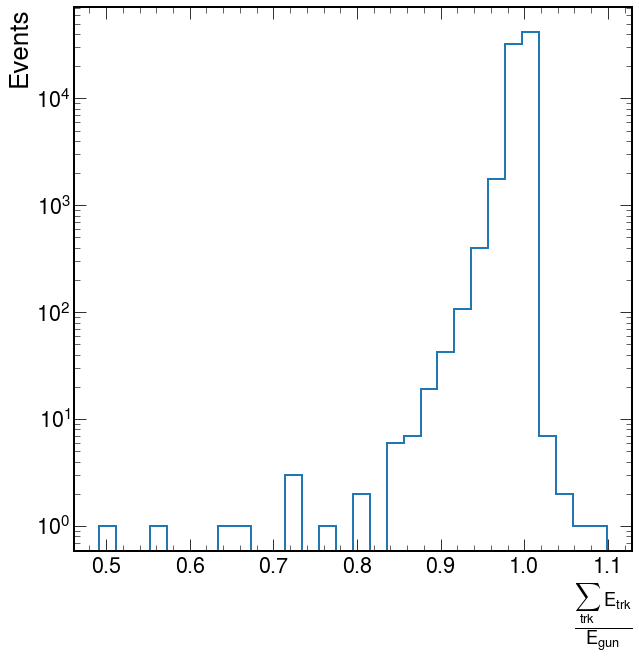

In [153]:
plt.hist(ratio, bins=30, histtype='step', lw=2)
plt.ylabel('Events')
plt.xlabel(r'$\frac{\sum_{\rm trk}~E_{\rm trk}}{E_{\rm gun}}$')
plt.yscale('log')
plt.show()

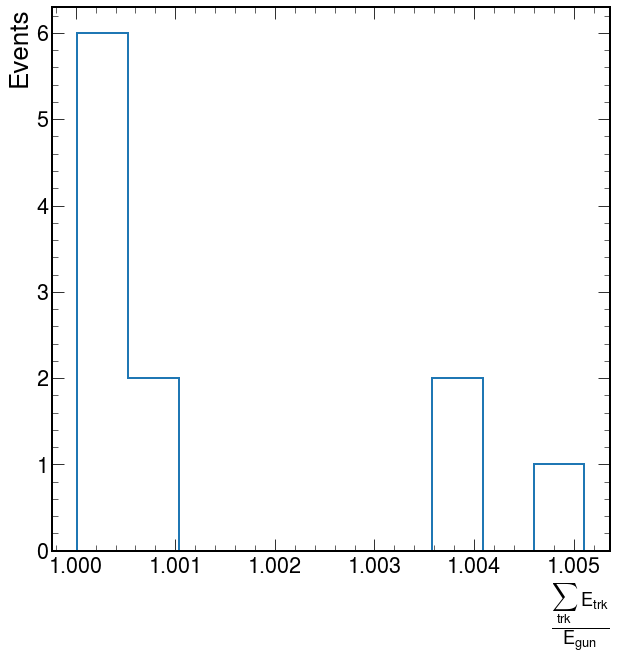

In [159]:
plt.hist(ratio[ratio>1][np.where(np.array([(2112 in _el.simTracks_boundary_id ) or (2212 in _el.simTracks_boundary_id) for _el in ele[idxs[ratio>1]]])==False)], histtype='step', lw=2)
plt.xlabel(r'$\frac{\sum_{\rm trk}~E_{\rm trk}}{E_{\rm gun}}$')
plt.ylabel('Events')
plt.show()

# Energy spectrum of brems emissions

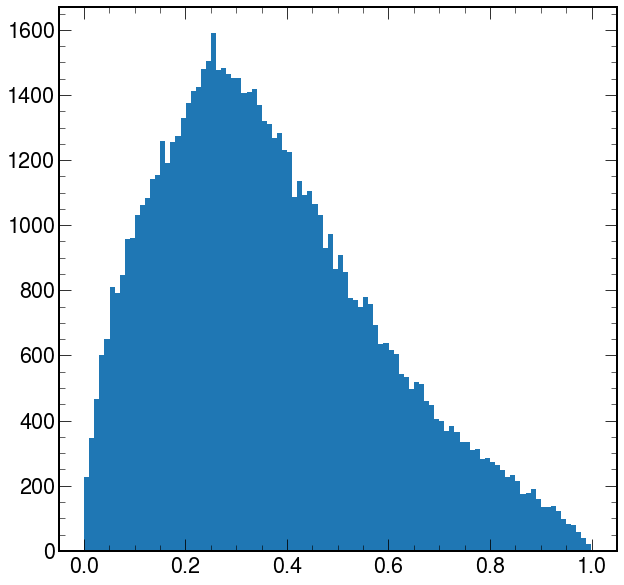

In [490]:
# Energy ratio between the leading and subleading SimTrack crossing the HGCAL surface
fracLeadSub = np.array([np.sort(el.simTrack_energy[el.simTrack_HGCAL!=0])[-2]/np.sort(el.simTrack_energy[el.simTrack_HGCAL!=0])[-1] for el in ele if len(el.simTrack_energy[el.simTrack_HGCAL!=0])>1])

plt.hist(fracLeadSub, bins=100)
plt.show()

In [33]:
enMom = np.array([float(el.simTrack_energy[0]) for el in ele if len(el.simTrack_energy)>1])
etaMom = np.array([float(el.simTrack_eta[0]) for el in ele if len(el.simTrack_energy)>1])
enDau = np.array([float(el.simTrack_energy[1]) for el in ele if len(el.simTrack_energy)>1])

pidMom = np.array([float(el.simTrack_PID[0]) for el in ele if len(el.simTrack_energy)>1])
pidDau = np.array([float(el.simTrack_PID[1]) for el in ele if len(el.simTrack_energy)>1])

In [492]:
fbrem = np.array([float(el.simTrack_fbrem[0]) for el in ele])

In [494]:
'''
To compute number of original electrons that loose at least X percent of their original energy.   
'''
np.percentile(fbrem[fbrem>0], 90)

0.9785216212272644

In [495]:
np.mean(fbrem[fbrem>0])

0.6769525821803474

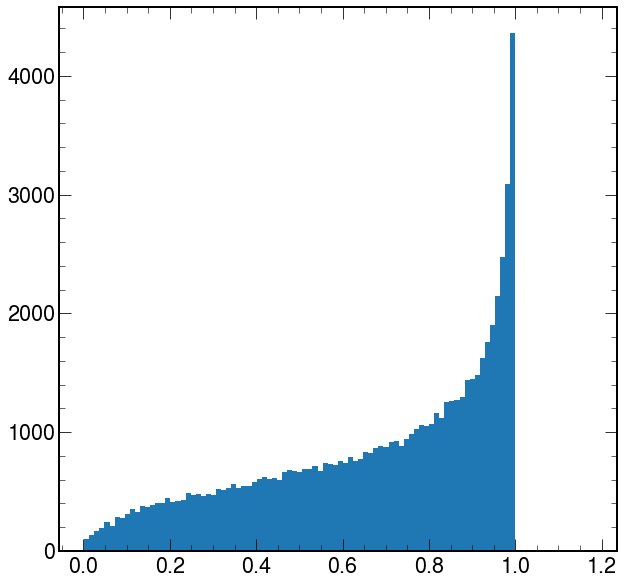

In [493]:
plt.hist(fbrem[fbrem>0], bins=100)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


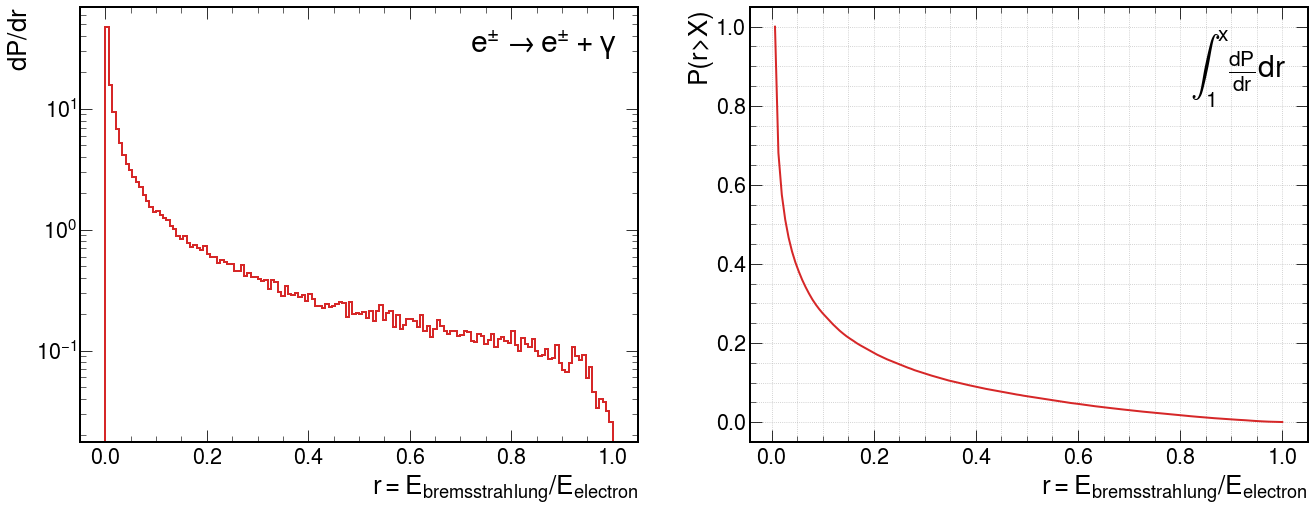

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(22,8))
axs = axs.ravel()

sel = (pidDau==22) & (abs(pidMom)==11) #common selection
ratio = enDau[sel]/enMom[sel]
n, b, _ = axs[0].hist(ratio, bins=150, histtype='step', lw=2, density=True, range=[0,1], color='tab:red')
axs[0].set_xlabel(r'$r = E_{\rm bremsstrahlung}/E_{\rm electron}$')
axs[0].set_ylabel(r'$dP/dr$')
axs[0].set_yscale('log')
axs[0].legend(title=r'$e^{\pm}\rightarrow e^{\pm}+\gamma$', title_fontsize=30)

reversed_values = list(reversed(n*np.diff(b)))
reversed_cumulative_sum = np.cumsum(reversed_values)
cumulative_sum = list(reversed(reversed_cumulative_sum))
# x = np.arange(len(cumulative_sum))
x=b[1:]
axs[1].plot(x, cumulative_sum, color='tab:red', lw=2)
axs[1].set_xlabel(r'$r = E_{\rm bremsstrahlung}/E_{\rm electron}$')
axs[1].set_ylabel('P(r>X)')
axs[1].grid(True, which='both')
axs[1].legend(title=r'$\int_1^{~x} \frac{dP}{dr} dr$', title_fontsize=30)

plt.savefig('bremSpectrum.pdf', dpi=150, bbox_inches='tight')
plt.show()

# Numpyser

In [7]:
# Trackster-level
skimmed       = np.array( [ val for el in ele for val in el.skim ] )
ratio_sum     = np.array( [ val for el in ele for val in el.EnRatio_sumE ] )
ratio_max     = np.array( [ val for el in ele for val in el.EnRatio_maxE ] )
en            = np.array( [ val for el in ele for val in el.multi_en ] )
pt            = np.array( [ val for el in ele for val in el.multi_pt ] )
eta           = np.array( [ val for el in ele for val in el.multi_eta ] )
explVarRatio  = np.array( [ val for el in ele for val in el.wpca_explVarRatio ] )
idxs_trk      = np.array( [ idx for idx,el in enumerate(ele) for val in range(el.nTracksters) ] )

# event-level
recoEn      = np.array([ sum(el.multi_en) for el in ele ] )
recoEn_skim = np.array([ sum(el.multi_en[el.skim==False]) for el in ele ] )
cleanEn     = np.array([ sum( sum(cleanedLCs) for cleanedLCs in el.cleanedLCen) for el in ele ] )
genEn       = np.array([ el.gunEn for el in ele ] )
idxs_ev     = np.array([ i for i in range(len(ele)) ] )

# Event display

In [592]:
def eventDisplay(_ele, cleaned = False, multi = False, removeTrk = False):
    
    print('------- Event information -------') 
    print('event, sample, eta:', _ele.eventNumber, _ele.sampleNumber, _ele.etaSign)

    # --------- gun information ---------
    print('------- Gun information -------') 
    print('eta gun:',  round(_ele.gunEta,3)) 
    print('phi gun:',  round(_ele.gunPhi,3))
    print('En gun:',   round(_ele.gunEn,3))
    print('ID gun:',   _ele.gunPID) 
    print('pT gun:',   round(_ele.gunPt,3))
    
    # --------- tracksters information ---------
#     print('------- Tracksters information -------') 
    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
#     print('color    energy     ratio_maxE     ratio_sumE     explVarRatio    discarded')
#     print('color    energy     explVarRatio    discarded')
    seedIdx = np.argmax(_ele.multi_pt)
    for trk in range(len(_ele.multi_en)):
        # color, energy, ratio wrt to most energetic one, explained variance, skimming
        print(colors[trk][4:],  
              ' - energy:', round(_ele.multi_en[trk],3),
              ' - eta:',    round(_ele.multi_eta[trk],3), 
              ' - phi:',    round(_ele.multi_phi[trk],3), 
              ' - pt:',     round(_ele.multi_pt[trk],3), 
              ' - dEta:',   round(abs(_ele.multi_eta[trk]) - abs(_ele.multi_eta[seedIdx]) ,3), 
              ' - dPhi:',   round(_ele.multi_phi[trk] - _ele.multi_phi[seedIdx], 3), 

#               str(round((_ele.multi_en[trk] / max(_ele.multi_en)) * 100,2))+'%', '    ', 
#               str(round((_ele.multi_en[trk] / sum(_ele.multi_en)) * 100,2))+'%', '        ', 
              '   ', round(_ele.wpca_explVarRatio[trk],3), '   ', 
              '   ', abs(abs(_ele.multi_eta[trk]) - abs(_ele.multi_eta[seedIdx])) > 0.05 and abs(_ele.multi_phi[trk] - _ele.multi_phi[seedIdx])<0.05 and abs(_ele.multi_phi[trk] - _ele.multi_phi[seedIdx])>0, '    ',
              _ele.skim[trk])
#     if removeTrk:
#         print('------- Effects of the skimming -------') 
#         print('E_ev/E_GEN', (sum(_ele.multi_en) / _ele.gunEn) - 1 )
#         print('E_ev/E_GEN', (sum(_ele.multi_en[_ele.skim==False]) / _ele.gunEn) - 1  )
    
    
    enMultiplier = 30
    
    fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))

#     if cleaned:
#         _alpha = 0.5
#     else:
#         _alpha = 1

    #ax0
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax0.scatter(_ele.LCx[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
    ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

    #ax1
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax1.scatter(_ele.LCy[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
    ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

    #ax2
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax2.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
    ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')

    #ax3
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax3.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
    ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    #ax4
    for trk in range(len(_ele.LCx)):
        if not trk in _ele.genMatching: continue
        ax4.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[trk])
    ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    if multi:
        for trk in range(len(_ele.multi_x)):
            ax2.arrow(0, 0, _ele.multi_x[trk] * 800, _ele.multi_y[trk] * 800, color='tab:red')
            ax3.arrow(0, 0, _ele.multi_x[trk] * 800, _ele.multi_z[trk] * 800, color='tab:red')
            ax4.arrow(0, 0, _ele.multi_y[trk] * 800, _ele.multi_z[trk] * 800, color='tab:red')
            
    plt.savefig('eventDisplay.pdf', dpi=150, bbox_inches='tight')
    plt.show()
    
    ##### -------- To remove pathological trackster -------- #####
    if removeTrk:
        
#         colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
                
        fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))

        #ax0
        i = -1
        for trk in range(len(_ele.LCx)):
            #All these tricks with if/else/continue is just to keep the same colors
            #The colors are indexed on the genMatched tracksters
            if not trk in _ele.genMatching: 
                continue
            else:
                i += 1
            if _ele.skim[trk]: continue
            ax0.scatter(_ele.LCx[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[i])
        ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

        #ax1
        i = -1
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching:
                continue
            else:
                i += 1
            if _ele.skim[trk]: continue
            ax1.scatter(_ele.LCy[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[i])
        ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')

        #ax2
        i = -1
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching:
                continue
            else:
                i += 1
            if _ele.skim[trk]: continue
            ax2.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[i])
            ax2.scatter(_ele.multi_x[trk], _ele.multi_y[trk], s=100, color='black', marker='+')
        ax2.set_xlabel('x (cm)', fontsize = 25, fontweight = 'bold')
        ax2.set_ylabel('y (cm)', fontsize = 25, fontweight = 'bold')

        #ax3
        i = -1
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching:
                continue
            else:
                i += 1
            if _ele.skim[trk]: continue
            ax3.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[i])
            ax3.scatter(_ele.multi_x[trk], _ele.multi_z[trk], s=100, color='black', marker='+')
        ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')

        #ax4
        i = -1
        for trk in range(len(_ele.LCx)):
            if not trk in _ele.genMatching:
                continue
            else:
                i += 1
            if _ele.skim[trk]: continue
            ax4.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, color=colors[i])
            ax4.scatter(_ele.multi_y[trk], _ele.multi_z[trk], s=100, color='black', marker='+')
        ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        
        plt.savefig('eventDisplay_baryc.pdf', dpi=150, bbox_inches='tight')
        
        plt.show()
        
        
    if cleaned:
        fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(42,17))
        
        colors_cleaned = ['blue', 'orange', 'green', 'red', 'purple', 'sienna', 'pink', 'grey', 'olive', 'cyan']
        color_axis = 'black'
        
        trk_idx = []
        i = -1
        for trk in range(len(_ele.LCx)):
#             if not trk in _ele.genMatching or _ele.skim[trk]: continue
            if not trk in _ele.genMatching:
                continue
            else:
                i += 1
            if _ele.skim[trk]: continue
            trk_idx.append(trk)
            ax0.scatter(_ele.LCx[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[i])
            ax1.scatter(_ele.LCy[trk], _ele.LCl[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[i])
            ax2.scatter(_ele.LCx[trk], _ele.LCy[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[i])
            ax3.scatter(_ele.LCx[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[i])
            ax4.scatter(_ele.LCy[trk], _ele.LCz[trk], s=_ele.LCen[trk]*enMultiplier, alpha=0.3, color=colors[i])
            
        i = -1
        for trk in range(len(_ele.cleanedLCx)):
            if not trk in _ele.genMatching or _ele.skim[trk]:
                continue
            else:
                i += 1
#             if _ele.skim[trk]: continue
            ax0.scatter(_ele.cleanedLCx[trk], _ele.cleanedLCl[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[i]]) 
            ax1.scatter(_ele.cleanedLCy[trk], _ele.cleanedLCl[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[i]])
            ax2.scatter(_ele.cleanedLCx[trk], _ele.cleanedLCy[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[i]])
            ax3.scatter(_ele.cleanedLCx[trk], _ele.cleanedLCz[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[i]])
            ax4.scatter(_ele.cleanedLCy[trk], _ele.cleanedLCz[trk], s=_ele.cleanedLCen[trk]*enMultiplier, facecolors='none', linewidths=2.5, color=colors_cleaned[trk_idx[i]])


        ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax0.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')
        
        ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax1.set_ylabel('Layer number', fontsize = 25, fontweight = 'bold')
        
        ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')
        ax2.set_ylim(ax2.get_ylim())
        ax2.set_xlim(ax2.get_xlim())

        ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
        ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        ax3.set_ylim(ax3.get_ylim())
        ax3.set_xlim(ax3.get_xlim())

        ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
        ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')
        ax4.set_ylim(ax4.get_ylim())
        ax4.set_xlim(ax4.get_xlim())

        for trk in range(len(_ele.pca)):
            if not trk in _ele.genMatching:
                continue
            else:
                i += 1
            if _ele.skim[trk]: continue
            x = _ele.pca[trk][0] #x-pca
            y = _ele.pca[trk][1] #y-pca
            z = _ele.pca[trk][2] #z-pca
            centre_x = _ele.pca_origin[trk][0]
            centre_y = _ele.pca_origin[trk][1]
            centre_l = _ele.pca_origin[trk][2]
            centre_z = _ele.pca_origin[trk][3]
            
            ax2.arrow(*[centre_x,centre_y], x * 800, y * 800, color=color_axis) 
            ax2.arrow(*[centre_x,centre_y], x * -800, y * -800, color=color_axis) 
            ax3.arrow(*[centre_x,centre_z], x * 800, z * 800, color=color_axis) 
            ax3.arrow(*[centre_x,centre_z], x * -800, z * -800, color=color_axis) 
            ax4.arrow(*[centre_y,centre_z], y * 800, z * 800, color=color_axis) 
            ax4.arrow(*[centre_y,centre_z], y * -800, z * -800, color=color_axis) 


        plt.show()


In [164]:
def plot3D(_el):
    data = []
    data_trackster = []
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey', 'olive', 'cyan', 'blue', 'orange', 'green', 'red']
    idx_color = 0
    for trk in range(len(_el.multi_en)):
        if _el.skim[trk] == True: 
            idx_color += 1
            continue
        data.append( go.Scatter3d( x      = np.array(_el.cleanedLCx,dtype=object)[trk], 
                                   y      = np.array(_el.cleanedLCy,dtype=object)[trk], 
                                   z      = np.array(_el.cleanedLCz,dtype=object)[trk],
                                   mode   = 'markers',
                                   marker = dict( size      = 5,
#                                        symbol='square',
                                       color=colors[idx_color],                # set color to an array/list of desired values
#                                        colorscale= 'Viridis',   # choose a colorscale
                                                  opacity   = 1.0,
                                                  showscale = False )
                                 )
                   )
        
        idx_color += 1

    fig = go.Figure(data = data)
    
    idx_color = 0
    for trk in range(len(_el.multi_en)):
        if _el.skim[trk] == True: 
            idx_color += 1
            continue
        fig.add_trace( go.Scatter3d( x      = [np.array(_el.multi_x,dtype=object)[trk]], 
                                     y      = [np.array(_el.multi_y,dtype=object)[trk]], 
                                     z      = [np.array(_el.multi_z,dtype=object)[trk]],
                                     mode   = 'markers',
                                     marker = dict( size      = 5,
                                     symbol = 'square',
                                     color  = 'black',                # set color to an array/list of desired values
        #                                          colorscale= 'Viridis',   # choose a colorscale
                                                     opacity   = 1.0,
                                                     showscale = False )
                             )
               )
        idx_color += 1
        

    length = 800
    for idxPCA in range(len(_el.pca_signed[_el.skim==False])):
        pca_origin  = np.array(_el.pca_origin, dtype=object)[_el.skim==False]
        start_point = np.array([pca_origin[idxPCA][0], pca_origin[idxPCA][1], pca_origin[idxPCA][3]], dtype=object)
        unit_vector = np.array(_el.pca_signed[_el.skim==False][idxPCA], dtype=object)
#         x = y = z = np.linspace(-100,100, 200)
        t = np.linspace(-100,100, 200)
        x_pca = start_point[0] + unit_vector[0] * t
        y_pca = start_point[1] + unit_vector[1] * t
        z_pca = start_point[2] + unit_vector[2] * t
        
        fig.add_trace(go.Scatter3d(x    = x_pca,
                                   y    = y_pca,
                                   z    = z_pca,
                                   mode ='lines',
                                   line=dict(
                                    color='black',
                                    width=2)
                                  )
                     )
        
    fig.update_layout(autosize = False,
                      width    = 1200,
                      height   = 1000)
    fig.show()


In [165]:
def eventDisplayHits(_ele):
    
    print('event, sample, eta:', _ele.eventNumber, _ele.sampleNumber, _ele.etaSign)

    fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(40,15), dpi=150)

    ax0.scatter(_ele.simHit_x,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax0.set_xlim(ax0.get_xlim())
    ax0.set_ylim(ax0.get_ylim())
    ax0.scatter(_ele.recHit_x,_ele.recHit_l,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax0.scatter(_ele.simHit_x,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax0.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax0.set_ylabel('L', fontsize = 25, fontweight = 'bold')

    ax1.scatter(_ele.simHit_y,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax1.set_xlim(ax1.get_xlim())
    ax1.set_ylim(ax1.get_ylim())
    ax1.scatter(_ele.recHit_y,_ele.recHit_l,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax1.scatter(_ele.simHit_y,_ele.simHit_l,s=_ele.simHit_en*10, c='black')
    ax1.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax1.set_ylabel('L', fontsize = 25, fontweight = 'bold')

    #sel_l is to remove hits over the layer reported in x-L and y-L views 
    sel_l = _ele.simHit_l<ax1.get_ylim()[1]
    ax2.scatter(_ele.simHit_x[sel_l],_ele.simHit_y[sel_l],s=_ele.simHit_en[sel_l]*10, c='black')
    ax2.set_xlim(ax2.get_xlim())
    ax2.set_ylim(ax2.get_ylim())
    sel_l = _ele.recHit_l<ax1.get_ylim()[1]
    ax2.scatter(_ele.recHit_x[sel_l],_ele.recHit_y[sel_l],s=_ele.recHit_en[sel_l]*10, c='lightgray', alpha=0.9)
    sel_l = _ele.simHit_l<ax1.get_ylim()[1]
    ax2.scatter(_ele.simHit_x[sel_l],_ele.simHit_y[sel_l],s=_ele.simHit_en[sel_l]*10, c='black')
    ax2.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax2.set_ylabel('y', fontsize = 25, fontweight = 'bold')
    ax2.set_title('Hits below layers '+str(int(ax1.get_ylim()[1])), fontsize = 25, fontstyle = 'italic')

    ax3.scatter(_ele.simHit_x,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax3.set_xlim(ax3.get_xlim())
    ax3.set_ylim(ax3.get_ylim())
    ax3.scatter(_ele.recHit_x,_ele.recHit_z,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax3.scatter(_ele.simHit_x,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax3.set_xlabel('x', fontsize = 25, fontweight = 'bold')
    ax3.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    ax4.scatter(_ele.simHit_y,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax4.set_xlim(ax4.get_xlim())
    ax4.set_ylim(ax4.get_ylim())
    ax4.scatter(_ele.recHit_y,_ele.recHit_z,s=_ele.recHit_en*10, c='lightgray', alpha=0.9)
    ax4.scatter(_ele.simHit_y,_ele.simHit_z,s=_ele.simHit_en*10, c='black')
    ax4.set_xlabel('y', fontsize = 25, fontweight = 'bold')
    ax4.set_ylabel('z', fontsize = 25, fontweight = 'bold')

    for i in range(len(_ele.multi_eta)):

        if not i in _ele.genMatching: continue

#         if neg and _ele.LCz[multi_clus2d[i]].flatten()[0]>0: continue
#         if not neg and _ele.LCz[multi_clus2d[i]].flatten()[0]<0: continue
            
        clusE = _ele.LCen[i].flatten()
        clusX = _ele.LCx[i].flatten()
        clusY = _ele.LCy[i].flatten()
        clusZ = _ele.LCz[i].flatten()
        clusL = _ele.LCl[i].flatten()

        ax0.scatter(clusX,clusL,s=clusE*10,alpha=0.5)
        ax1.scatter(clusY,clusL,s=clusE*10,alpha=0.5)
        ax2.scatter(clusX,clusY,s=clusE*10,alpha=0.5)
        ax3.scatter(clusX,clusZ,s=clusE*10,alpha=0.5)
        ax4.scatter(clusY,clusZ,s=clusE*10,alpha=0.5)

    plt.savefig('event.png', facecolor='white', dpi=300, bbox_inches='tight')
    plt.show()


------- Event information -------
event, sample, eta: 84 10 1
------- Gun information -------
eta gun: 2.471
phi gun: 0.211
En gun: 404.883
ID gun: 11
pT gun: 67.955
blue  - energy: 364.873  - eta: 2.471  - phi: 0.216  - pt: 61.2  - dEta: 0.0  - dPhi: 0.0     1.0         False      False
orange  - energy: 1.142  - eta: 2.426  - phi: 0.169  - pt: 0.2  - dEta: -0.046  - dPhi: -0.047     0.867         False      True
green  - energy: 6.269  - eta: 2.54  - phi: 0.254  - pt: 0.983  - dEta: 0.068  - dPhi: 0.038     0.834         True      True
red  - energy: 2.736  - eta: 2.417  - phi: 0.289  - pt: 0.484  - dEta: -0.055  - dPhi: 0.073     0.665         False      True
purple  - energy: 2.0  - eta: 2.397  - phi: 0.177  - pt: 0.361  - dEta: -0.075  - dPhi: -0.039     0.979         True      True
brown  - energy: 2.087  - eta: 2.399  - phi: 0.213  - pt: 0.376  - dEta: -0.073  - dPhi: -0.003     0.928         True      False
pink  - energy: 1.982  - eta: 2.461  - phi: 0.165  - pt: 0.336  - dEta:

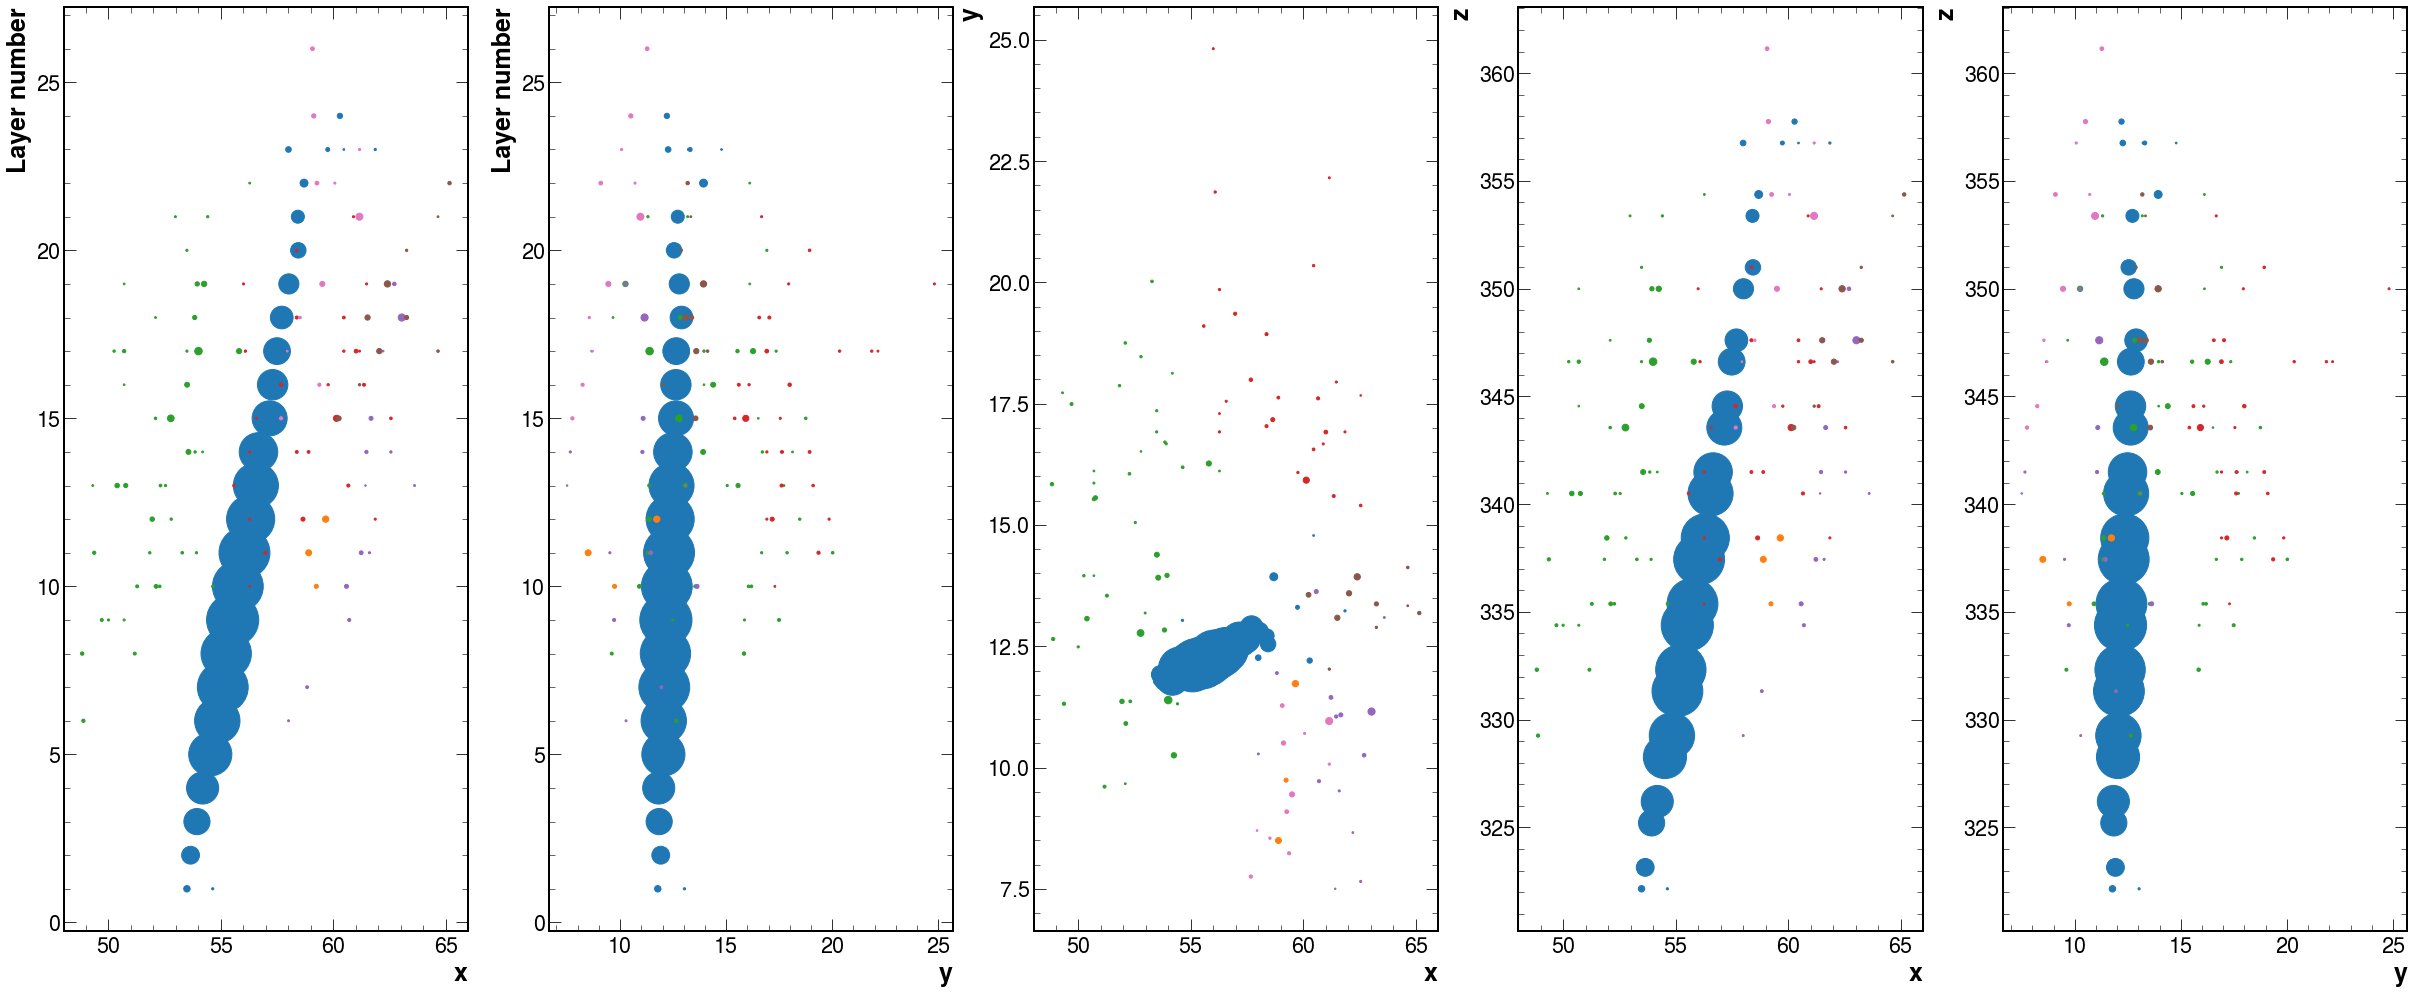

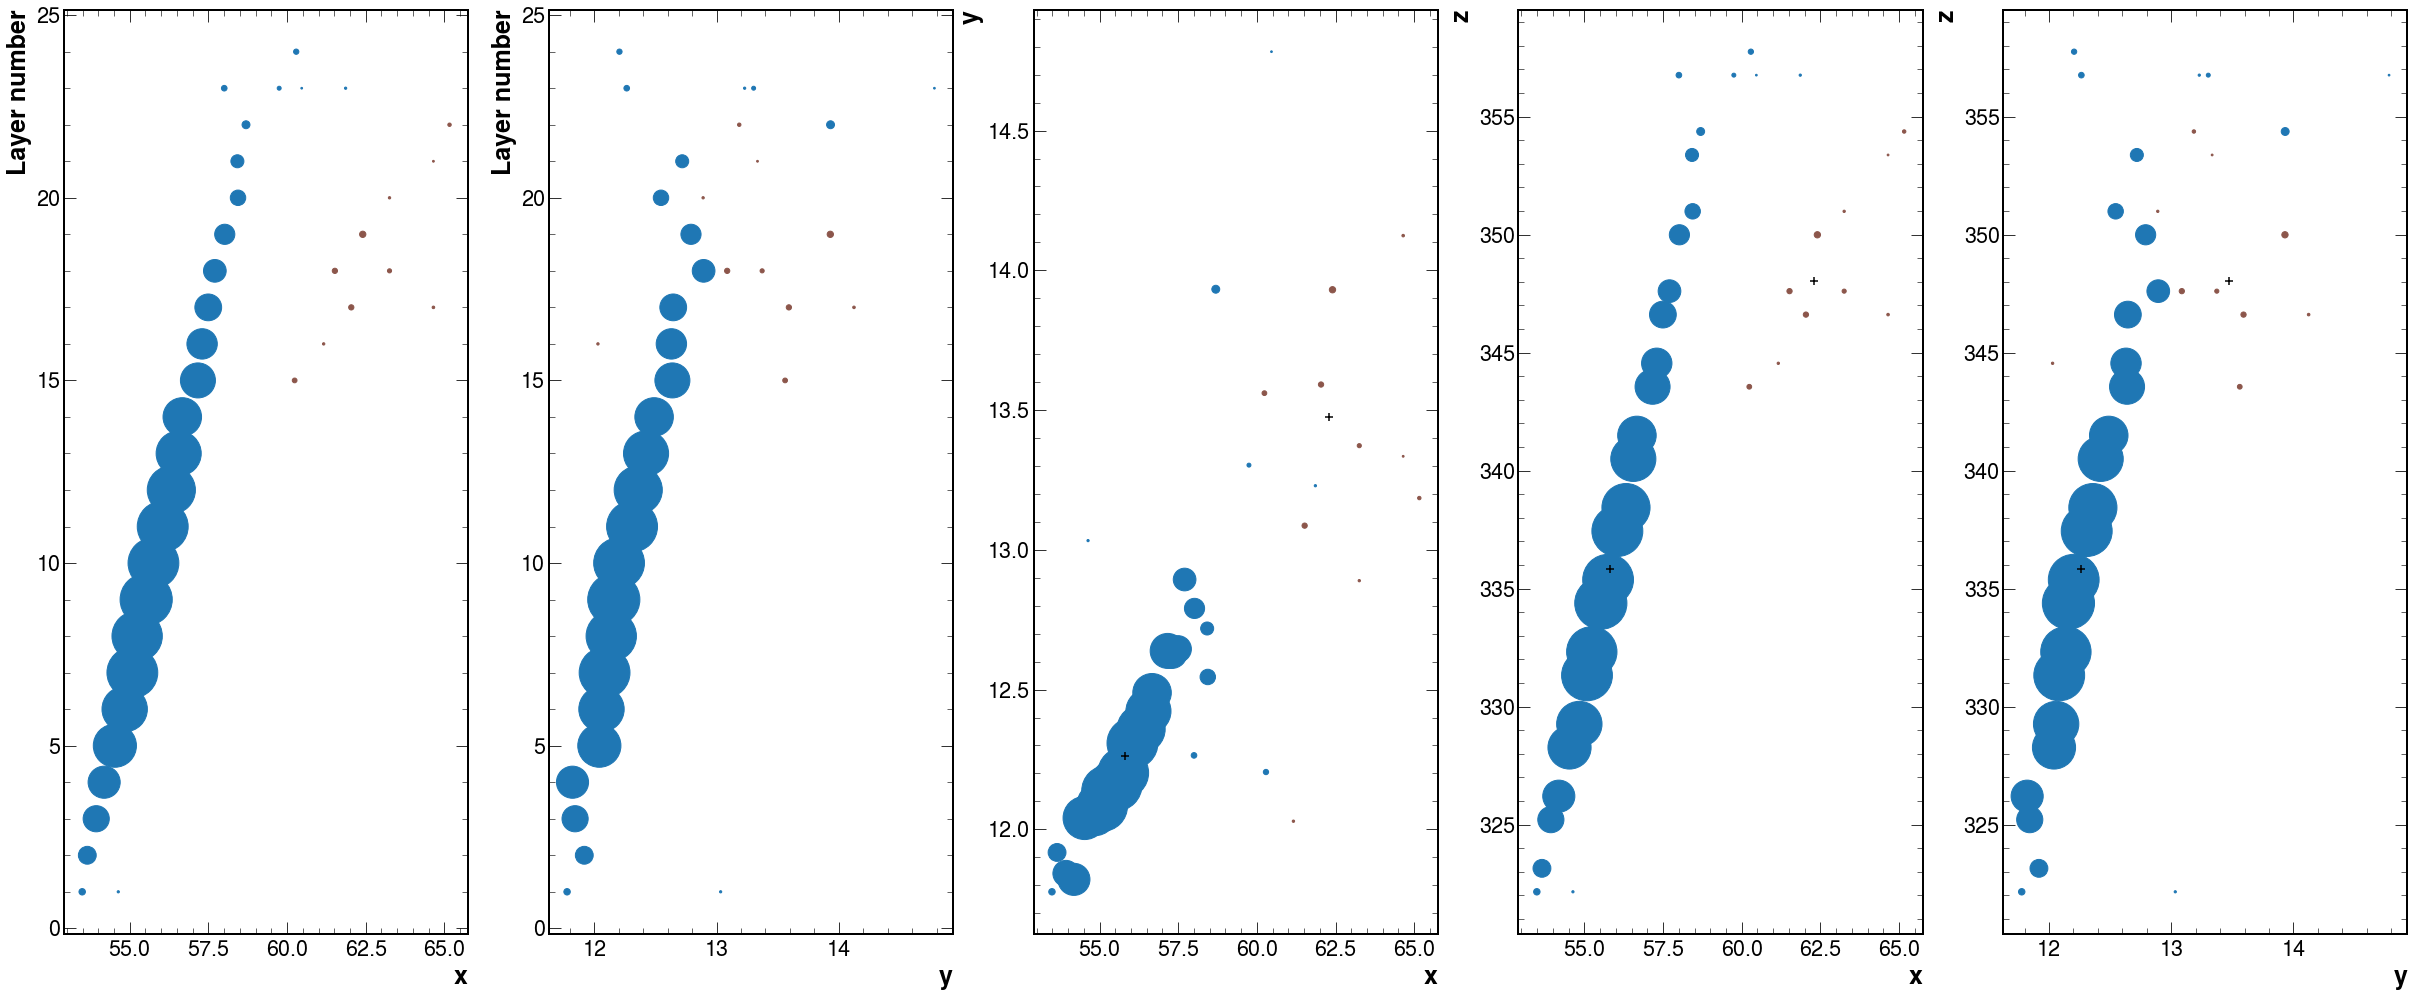

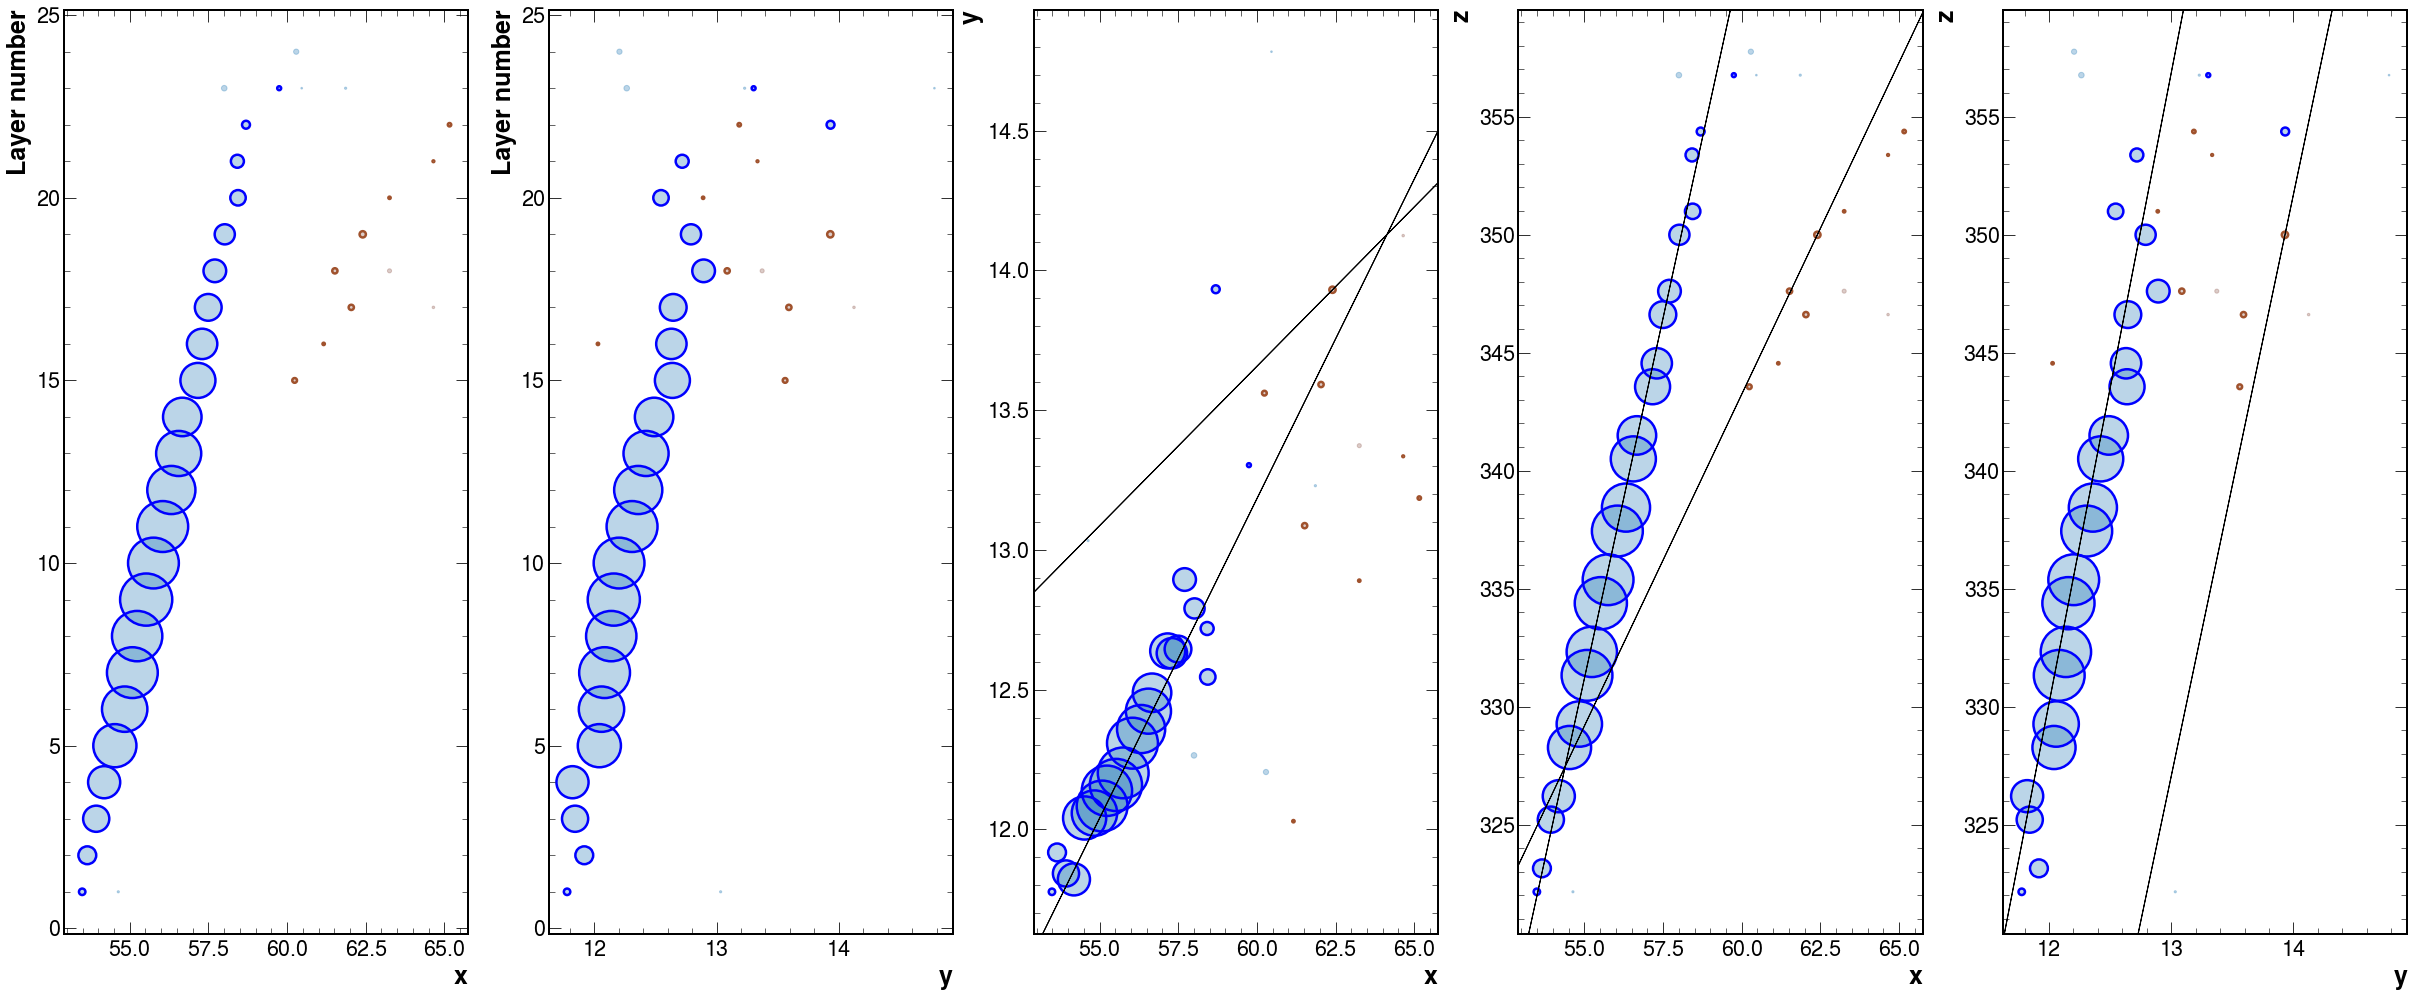

In [171]:
eventDisplay(ele[5304], removeTrk=True, cleaned = True) #[FIXME] cleaned non ancora aggiustato per PU

In [15]:
plot3D(ele[77])

event, sample, eta: 21 101 -1


Exception ignored in: <bound method tqdm.__del__ of <tqdm.std.tqdm object at 0x7fe33ae5de10>>
Traceback (most recent call last):
  File "/home/llr/cms/tarabini/.local/lib/python3.6/site-packages/tqdm/std.py", line 1144, in __del__
    def __del__(self):
KeyboardInterrupt


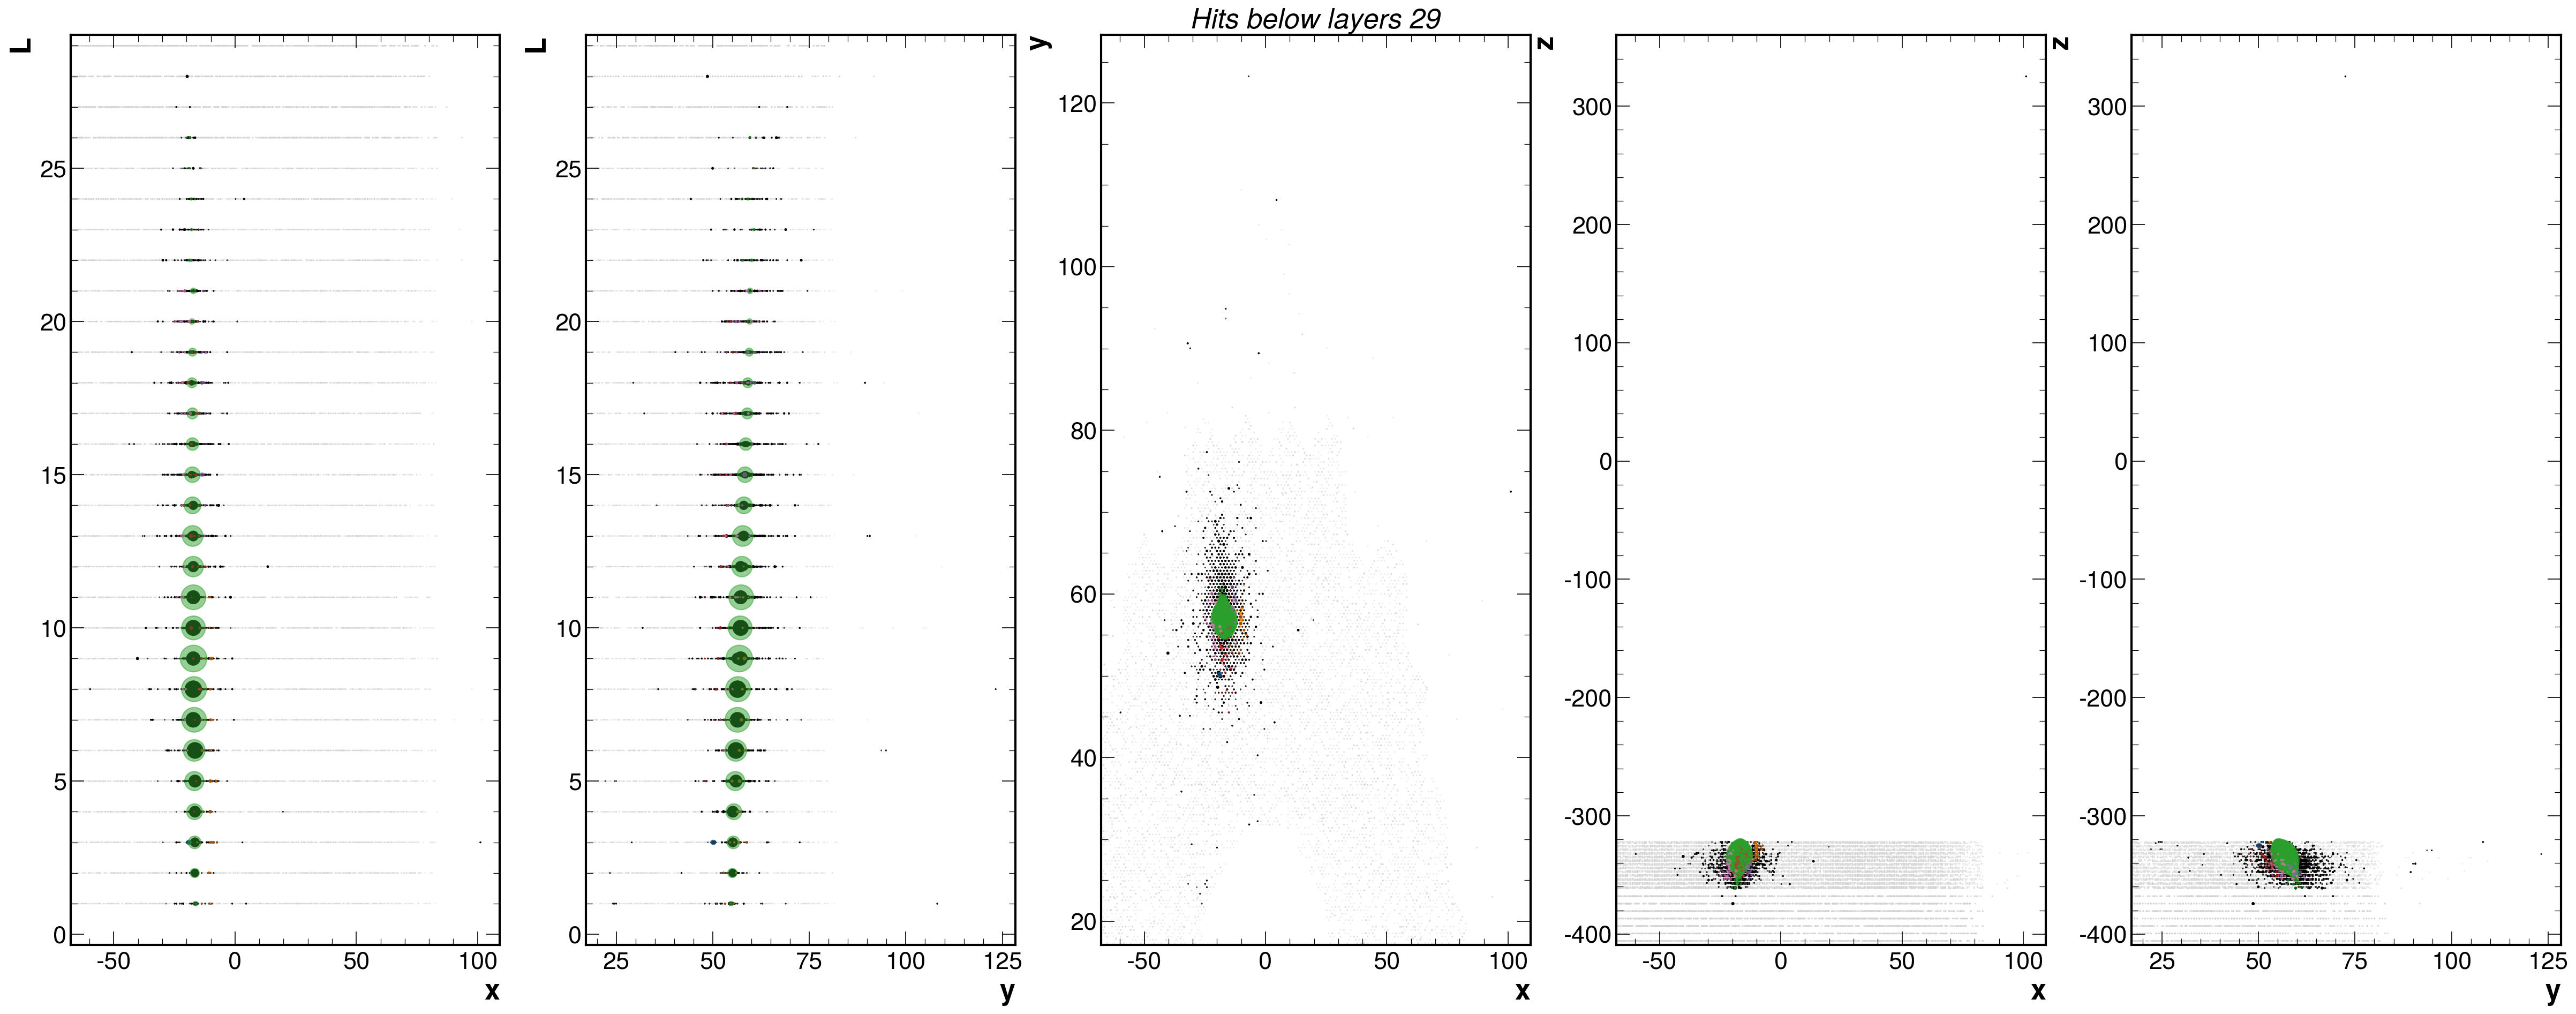

In [340]:
eventDisplayHits(ele[39])

# Linking vs noLinking

In [160]:
def findIndex(_event, _sample, _eta):
    for idx in range(len(ele)): 
#         if ele_linking[idx].eventNumber == _event and ele_linking[idx].sampleNumber == _sample and ele_linking[idx].etaSign == _eta:
#             idx_noLinking = idx
        idx_noLinking = -1
        if ele_noLinking[idx].eventNumber == _event and ele_noLinking[idx].sampleNumber == _sample and ele_noLinking[idx].etaSign == _eta:
            idx_Linking = idx
    return idx_noLinking, idx_Linking

In [161]:
findIndex(84, 10, 1)

(-1, 5304)

In [14]:
nTracksters    = np.array([ evt.nTracksters for evt in ele_linking ])
eventNumber    = np.array([ evt.eventNumber for evt in ele_linking ])
sampleNumber   = np.array([ evt.sampleNumber for evt in ele_linking ])
etaSign        = np.array([ evt.etaSign for evt in ele_linking ])
df = {
    'event': eventNumber,
    'sample': sampleNumber,
    'eta': etaSign,
    'nTrk': nTracksters
}
df_Linking     = pd.DataFrame(data=df)

nTracksters    = np.array([ evt.nTracksters for evt in ele_noLinking ])
eventNumber    = np.array([ evt.eventNumber for evt in ele_noLinking ])
sampleNumber   = np.array([ evt.sampleNumber for evt in ele_noLinking ])
etaSign        = np.array([ evt.etaSign for evt in ele_noLinking ])
df = {
    'event': eventNumber,
    'sample': sampleNumber,
    'eta': etaSign,
    'nTrk': nTracksters
}
df_noLinking   = pd.DataFrame(data=df)

df_merge       = pd.merge(df_Linking, df_noLinking,  how='inner', left_on=['event','sample', 'eta'], right_on = ['event','sample', 'eta'])

Trk_Linking    = np.array(df_merge['nTrk_x'])
Trk_noLinking  = np.array(df_merge['nTrk_y'])

print('Total number of events:', len(Trk_Linking))
print('N_trk_Link != N_trk_noLink:', len(Trk_Linking[Trk_Linking!=Trk_noLinking]))
print('Fraction:', str(round(len(Trk_Linking[Trk_Linking!=Trk_noLinking]) / len(Trk_Linking) * 100, 2))+' %' )

Total number of events: 38551
N_trk_Link != N_trk_noLink: 1585
Fraction: 4.11 %


In [902]:
df_merge[df_merge.nTrk_x!=df_merge.nTrk_y]

event  sample  eta  nTrk_x  nTrk_y
4          3       1    1       1       2
5          3       1   -1       2       4
28        15       1   -1       1       2
33        18       1    1       8      10
62        33       1   -1       1       2
...      ...     ...  ...     ...     ...
38462     56      67    1       3       4
38463     56      67   -1       2       3
38480     65      67    1       3       4
38491     70      67   -1       3       4
38522     86      67   -1       2       3

[1585 rows x 5 columns]

In [227]:
plt.figure(figsize=(12, 6), dpi=100)

nTracksters = np.array([ evt.nTracksters for evt in ele_linking ])
n, bins, _ = plt.hist(nTracksters, density = True, bins=14, range=[0.5,14.5], histtype='step', label='Linking')

print('Number of tracksters per event (%):', [i*100 for i in n])

#### ------ After skimming tracksters according to wpca_explVarRatio ------ ####

nTracksters_noLinking = np.array([ evt.nTracksters for evt in ele_noLinking ])
n, bins, _ = plt.hist(nTracksters_noLinking, density = True, bins=14, range=[0.5,14.5], histtype='step', label='No linking')

print('Number of tracksters per event (%):', [i*100 for i in n])


# plt.yscale('log')
plt.ylabel('Fraction of events')
plt.xlabel('Number of tracksters per event')
plt.legend()
plt.show()

NameError: name 'ele_linking' is not defined

<Figure size 1200x600 with 0 Axes>

(65, 17981)
############# ---------------- Linking ---------------- #############
------- Event information -------
event, sample, eta: 35 1 1
------- Gun information -------
eta gun: 2.339
phi gun: -3.122
En gun: 204.456
ID gun: 11
pT gun: 39.081
------- Tracksters information -------
color    energy     ratio_maxE     ratio_sumE     explVarRatio    discarded
blue      8.656      9.63%      4.77%          0.961          False
orange      8.198      9.12%      4.52%          0.975          False
green      2.681      2.98%      1.48%          0.954          False
red      1.236      1.38%      0.68%          0.886          True
purple      89.906      100.0%      49.55%          0.998          False
brown      70.762      78.71%      39.0%          0.925          True


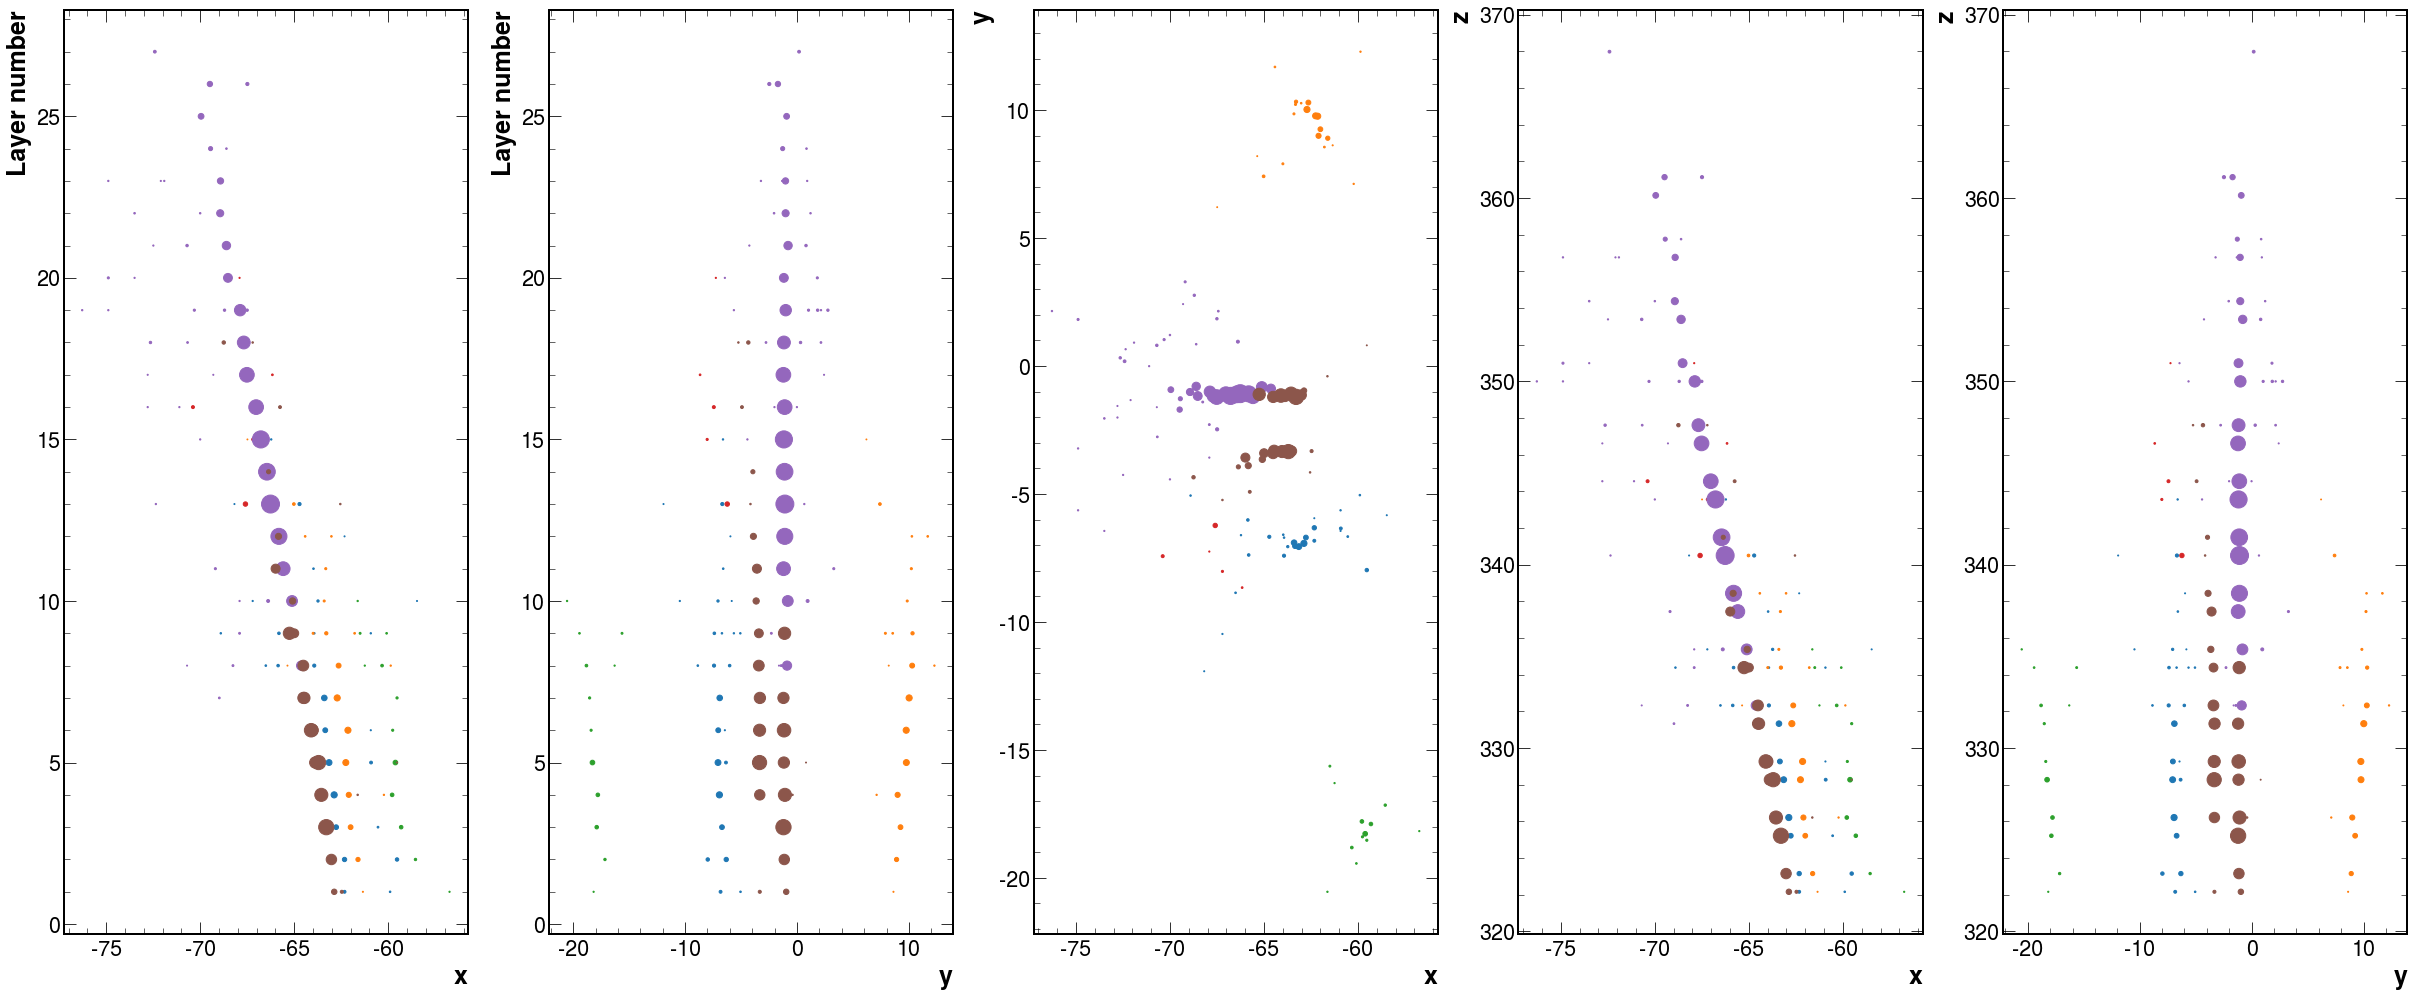

############# --------------- noLinking --------------- #############
------- Event information -------
event, sample, eta: 35 1 1
------- Gun information -------
eta gun: 2.339
phi gun: -3.122
En gun: 204.456
ID gun: 11
pT gun: 39.081
------- Tracksters information -------
color    energy     ratio_maxE     ratio_sumE     explVarRatio    discarded
blue      8.656      9.63%      4.77%          0.961          False
orange      32.97      36.67%      18.17%          0.998          False
green      8.198      9.12%      4.52%          0.975          False
red      2.681      2.98%      1.48%          0.954          False
purple      37.792      42.03%      20.83%          1.0          False
brown      1.236      1.38%      0.68%          0.886          True
pink      89.906      100.0%      49.55%          0.998          False


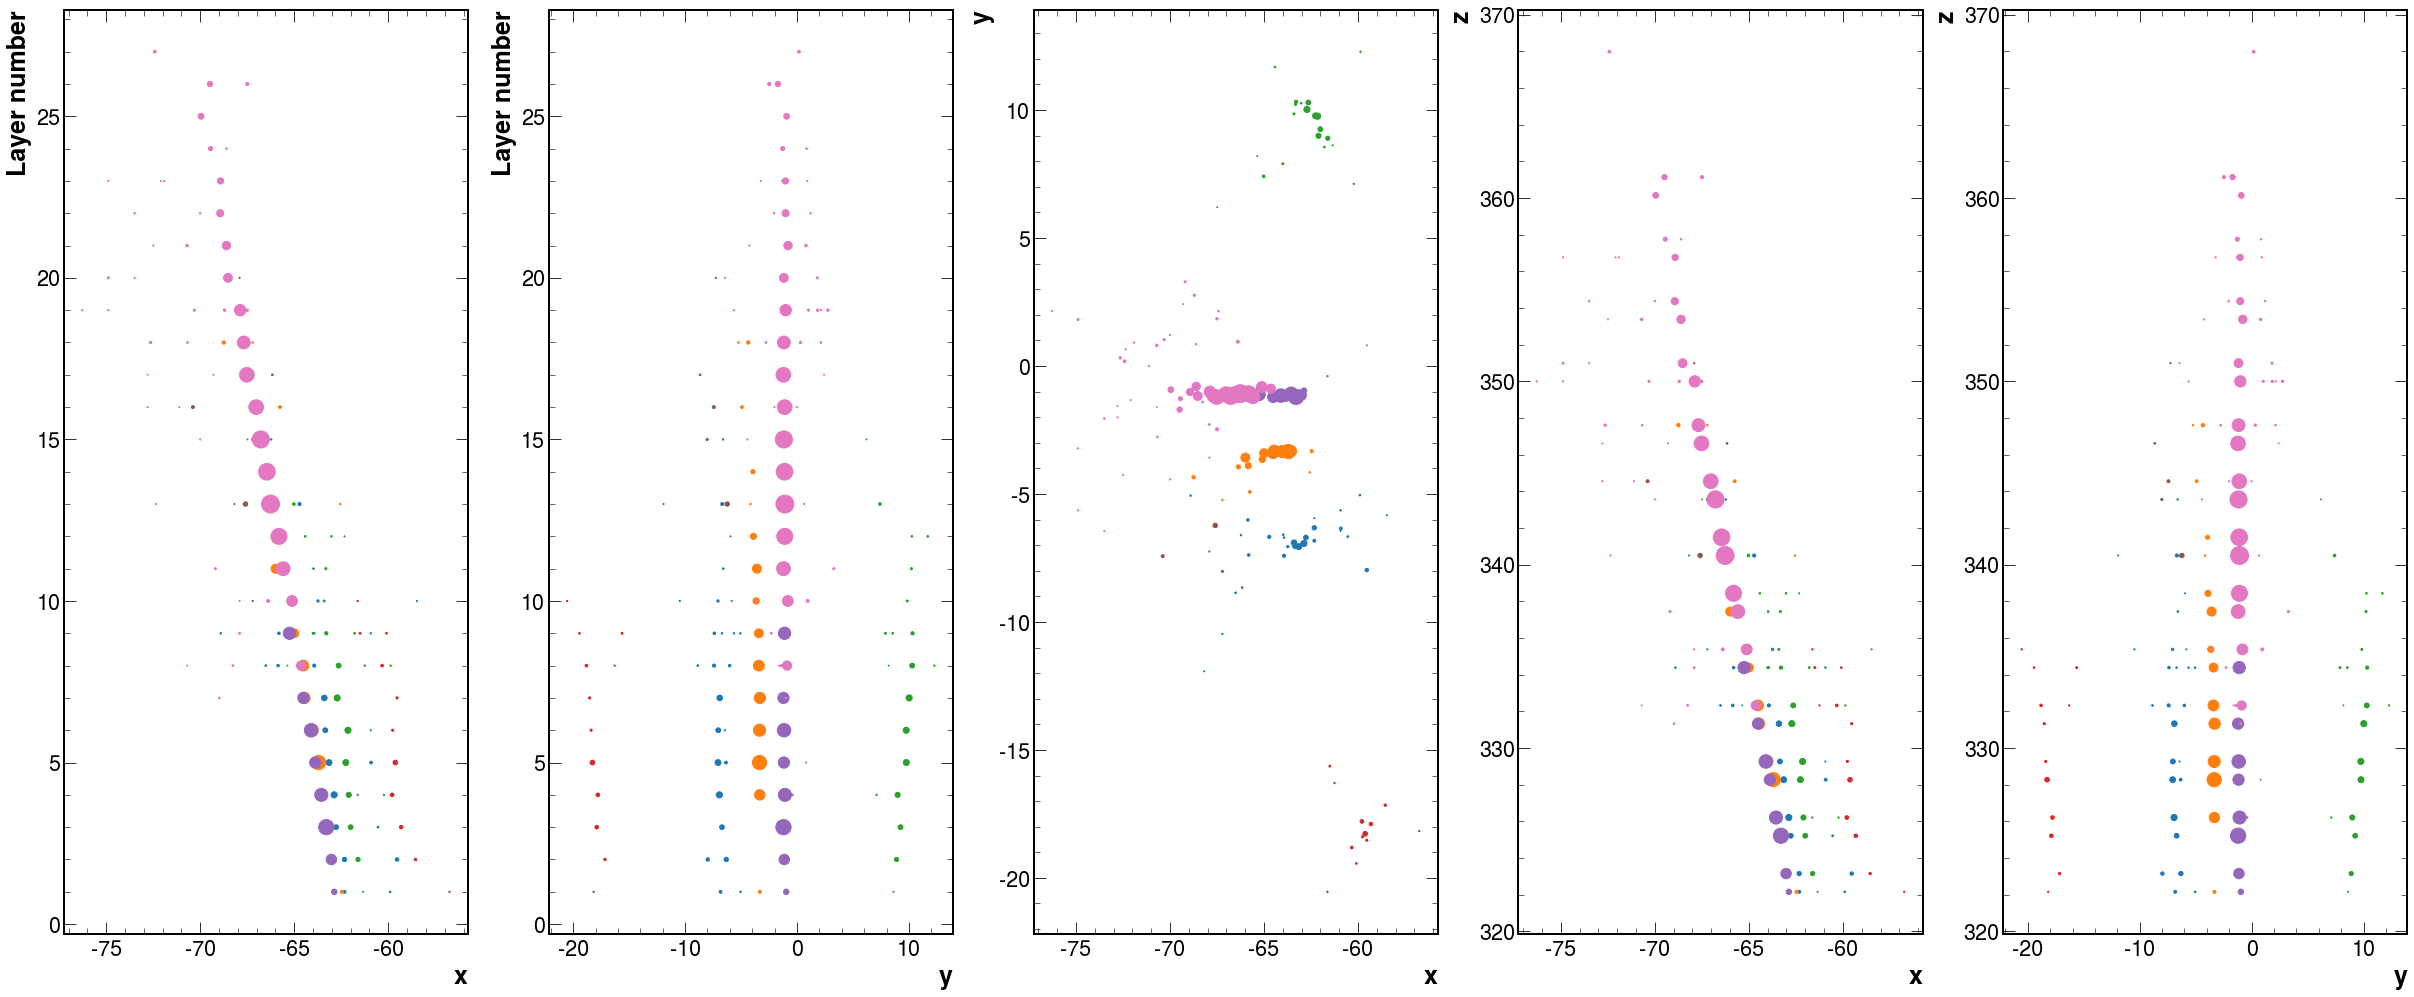

In [577]:
event   = 35
sample  = 1
eta     = 1
print(findIndex(event, sample, eta))
# Event display with linking
print('############# ---------------- Linking ---------------- #############')
eventDisplay(ele_linking[findIndex(event, sample, eta)[0]])
# eventDisplay(ele_linking[5])
# Event display without linking
print('############# --------------- noLinking --------------- #############')
eventDisplay(ele_noLinking[findIndex(event, sample, eta)[1]])
# eventDisplay(ele_noLinking[17543])

# Number of tracksters

Number of tracksters per event (%): [21.17266803395727, 24.397050806095695, 19.34889275422519, 13.880163036423584, 8.96051299358758, 5.58036293777097, 3.255536228874062, 1.7991121264830343, 0.8658064851112437, 0.4517251226667359, 0.16874789065136686, 0.0778836418390924, 0.028557335341000543, 0.012980606973182065]
Number of tracksters per event (%): [45.362565428025924, 30.976842050576025, 15.33126388113205, 5.817411972516982, 1.8767939942592182, 0.4896549036925435, 0.10000909173561233, 0.03766576182250334, 0.005195277492759082, 0.0012988193731897704, 0.0012988193731897704, 0.0, 0.0, 0.0]


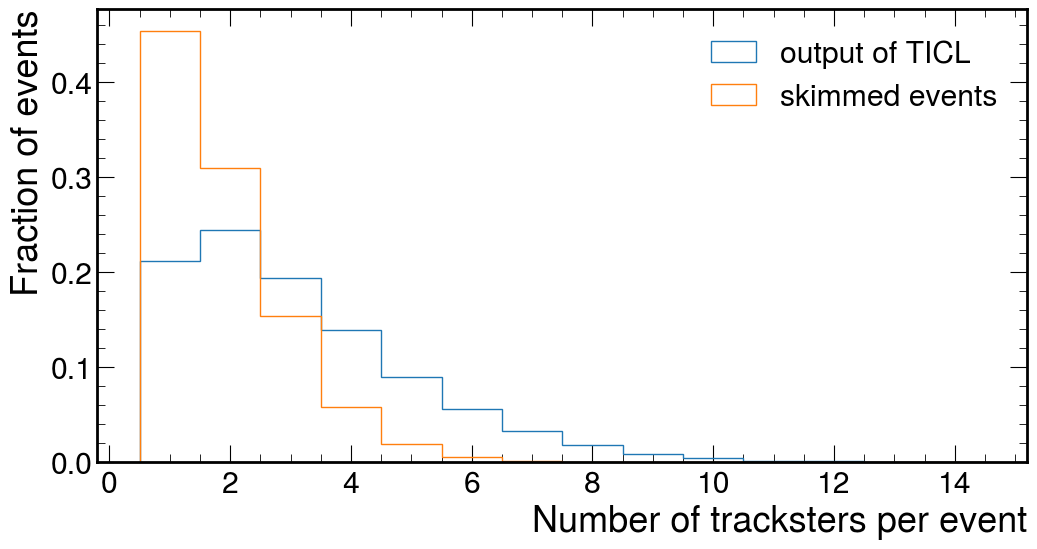

In [230]:
plt.figure(figsize=(12, 6), dpi=100)

nTracksters = np.array([len(evt.genMatching) for evt in ele])
n, bins, _ = plt.hist(nTracksters, density = True, bins=14, range=[0.5,14.5], histtype='step', label='output of TICL')

print('Number of tracksters per event (%):', [i*100 for i in n])

#### ------ After skimming tracksters according to wpca_explVarRatio ------ ####

nTracksters_skimmed = np.array([ len(np.where(el.skim[el.genMatching] == False)[0]) for el in ele ])
n, bins, _ = plt.hist(nTracksters_skimmed, density = True, bins=14, range=[0.5,14.5], histtype='step', label='skimmed events')

print('Number of tracksters per event (%):', [i*100 for i in n])

# plt.yscale('log')
plt.ylabel('Fraction of events')
plt.xlabel('Number of tracksters per event')
plt.legend()
plt.show()

In [7]:
#Events that are killed by the skimming procedure. Before the skimming there was at least one tracktser, after the procedure there is nothing.
print(np.where((nTracksters_skimmed==0) & (nTracksters>0)))
print( len(np.where((nTracksters_skimmed==0) & (nTracksters>0)))/len(nTracksters) * 100, '% of events that are "killed"' )

(array([  473,  5677,  7706,  8016, 13697, 15617, 16062, 16584, 17857,
       17999, 18448, 18805, 18827, 20166, 21547, 22059, 23011, 25546,
       26693, 28549, 29815, 30226, 32255, 35067, 36447, 38283, 38512,
       39367, 41908, 43400, 43713, 45055, 45298, 47199, 47512, 48721,
       51083, 51577, 54121, 60073, 60619, 61958, 62695, 62927, 63786,
       64960, 66278, 70265, 74196]),)
0.0012979933023545597 % of events that are "killed"


In [133]:
#     0              18                  19                  20                  21                 22
x = [[0, 2.12041],  [2.12041, 2.63227], [2.63227, 8.07541], [8.07541, 33.9744], [33.9744, 49.592], [49.5915, 72.0554]]
y = [[0, 0.66161],  [0.661615, 0.8219], [0.821956, 2.5426], [2.54262, 11.1352], [11.1352, 16.651], [16.6513, 24.7675]]  
z = [[0, 6.54172],  [6.54172, 8.12149], [8.12149, 24.9382], [24.9382, 105.34],  [105.34, 154.168], [154.168, 224.599]]

pid = [11, 22, 22, 22, 22, 22]

In [134]:
ls = {22: '--',
      11: '-',
      -11: '-'}

color = {22: 'black',
         11: 'tab:red',
         -11: 'tab:orange'}

In [192]:
x = {0:  [0, 6.47883, 12.946, 19.4013, 25.8446, 32.2757, 38.6944, 45.1006, 51.4942, 57.875, 64.2429, 70.5979, 76.9398, 83.2687, 89.5843, 95.8869, 102.176],
     18: [2.12041, 104.388],
     19: [2.63227, 104.387],
     20: [8.07541, 104.176],
     21: [33.9744, 103.508]}
y = {0:  [0, 2.03513, 4.10701, 6.21552, 8.36052, 10.5418, 12.7593, 15.0126, 17.3015, 19.6257, 21.9849, 24.3787, 26.8068, 29.2687, 31.7639, 34.2919, 36.8523],
     18: [0.661615, 32.679], 
     19: [0.821956, 32.715],
     20: [2.54262, 33.1811],
     21: [11.1352, 35.128]}
z = {0:  [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320],
     18: [6.54172, 322.155], 
     19: [8.12149, 322.155],
     20: [24.9382, 322.155],
     21: [105.34, 322.155]}

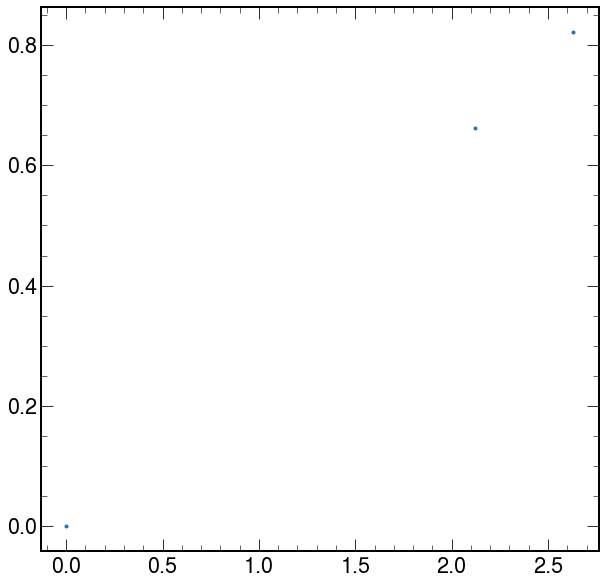

In [75]:
plt.plot(x,y, '.')
plt.show()

# Studies on trackster removal

In [14]:
ele[0].gunEn

260.535888671875

In [15]:
# Create arrays in which each entry is a trackster
skimmed      = []
ratio_max    = []
ratio_sum    = []
explVarRatio = []
idxs         = []
pT           = []
en           = []
gaps         = []
# genEn        = []

for idx, ev in tqdm(enumerate((ele))):
    for trk in range(ev.nTracksters):
        
        skimmed.append(ev.skim[trk])
        ratio_max.append(ev.EnRatio_maxE[trk])
        ratio_sum.append(ev.EnRatio_sumE[trk])
        explVarRatio.append(ev.wpca_explVarRatio[trk])
        pT.append(ev.multi_pt[trk])
        en.append(ev.multi_en[trk])
        idxs.append(idx)
        gaps.append(ev.gaps[trk])    
#         genEn.append(ev.gunEn)   
        
            
skimmed         = np.array(skimmed)
ratio_max       = np.array(ratio_max)
ratio_sum       = np.array(ratio_sum)
explVarRatio    = np.array(explVarRatio)
idxs            = np.array(idxs)
pT              = np.array(pT)
en              = np.array(en)
gaps            = np.array(gaps)
# genEn           = np.array(genEn)


77042it [00:00, 102525.97it/s]


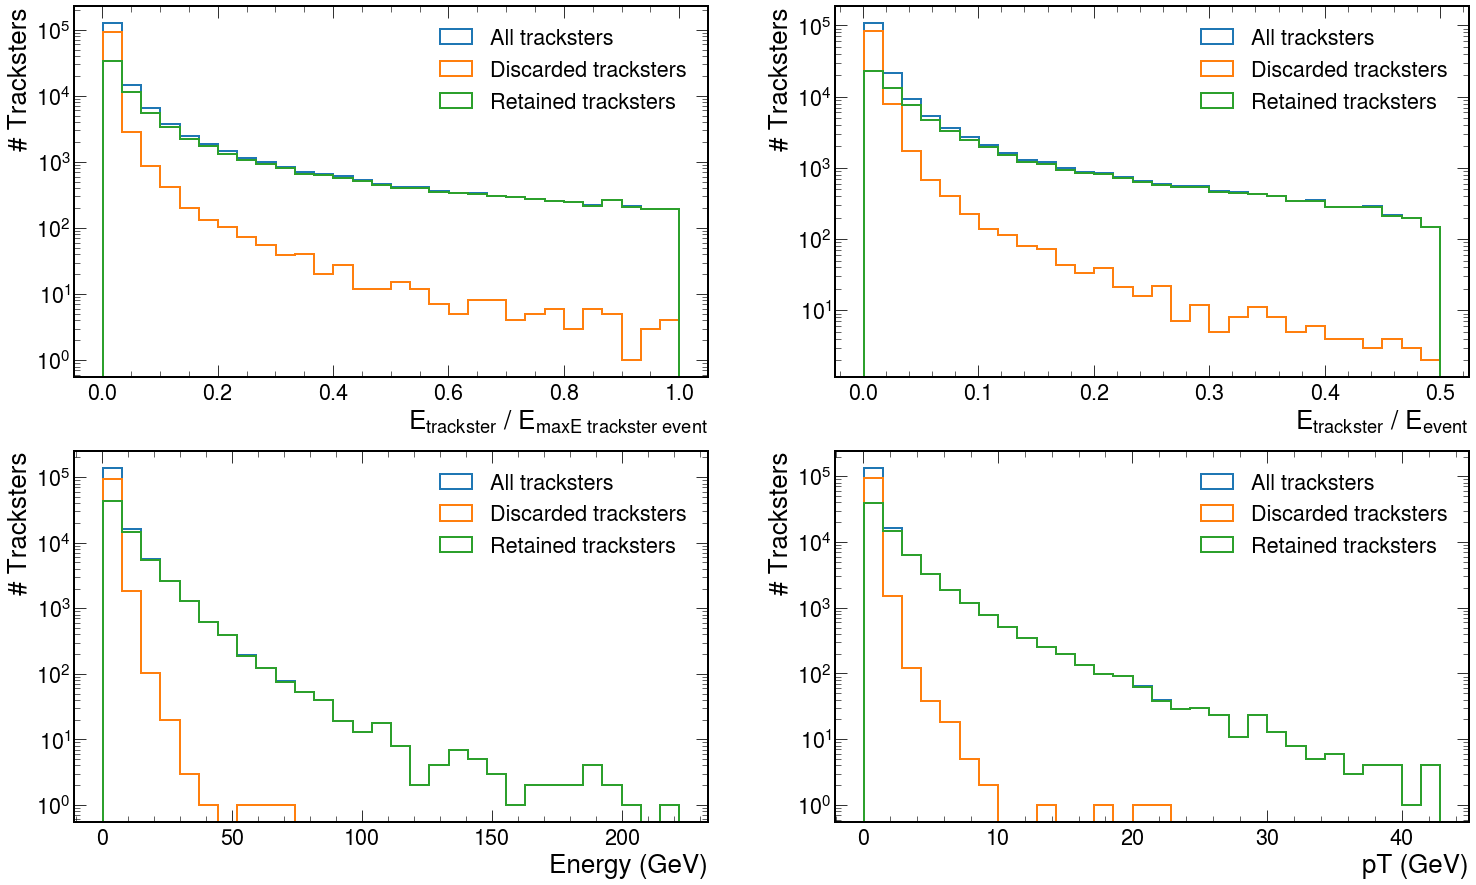

In [9]:
n_bins = 30

sel           = (ratio_max != 1)
sel_skimmed   = sel & (skimmed == True)
sel_noskimmed = sel & (skimmed == False)

fig, axs = plt.subplots(2, 2, figsize=(25,15))

n, bins, _ = axs[0,0].hist(ratio_max[sel], bins=n_bins, histtype='step', lw=2, label = 'All tracksters')
axs[0,0].hist(ratio_max[sel_skimmed], bins=bins, histtype='step', lw=2, label = 'Discarded tracksters')
axs[0,0].hist(ratio_max[sel_noskimmed], bins=bins, histtype='step', lw=2, label = 'Retained tracksters')
axs[0,0].set_xlabel(r'$E_{trackster}$ / $E_{maxE~trackster~event}$')
axs[0,0].set_ylabel('# Tracksters')
axs[0,0].set_yscale('log')
axs[0,0].legend()

n, bins, _ = axs[0,1].hist(ratio_sum[sel], bins=n_bins, histtype='step', lw=2, label = 'All tracksters')
axs[0,1].hist(ratio_sum[sel_skimmed], bins=bins, histtype='step', lw=2, label = 'Discarded tracksters')
axs[0,1].hist(ratio_sum[sel_noskimmed], bins=bins, histtype='step', lw=2, label = 'Retained tracksters')
axs[0,1].set_xlabel(r'$E_{trackster}$ / $E_{event}$')
axs[0,1].set_ylabel('# Tracksters')
axs[0,1].set_yscale('log')
axs[0,1].legend()

n, bins, _ = axs[1,0].hist(en[sel], bins=n_bins, histtype='step', lw=2, label = 'All tracksters')
axs[1,0].hist(en[sel_skimmed], bins=bins, histtype='step', lw=2, label = 'Discarded tracksters')
axs[1,0].hist(en[sel_noskimmed], bins=bins, histtype='step', lw=2, label = 'Retained tracksters')
axs[1,0].set_xlabel(r'Energy (GeV)')
axs[1,0].set_ylabel('# Tracksters')
axs[1,0].set_yscale('log')
axs[1,0].legend()

n, bins, _ = axs[1,1].hist(pT[sel], bins=n_bins, histtype='step', lw=2, label = 'All tracksters')
axs[1,1].hist(pT[sel_skimmed], bins=bins, histtype='step', lw=2, label = 'Discarded tracksters')
axs[1,1].hist(pT[sel_noskimmed], bins=bins, histtype='step', lw=2, label = 'Retained tracksters')
axs[1,1].set_xlabel(r'pT (GeV)')
axs[1,1].set_ylabel('# Tracksters')
axs[1,1].set_yscale('log')
axs[1,1].legend()

plt.show()

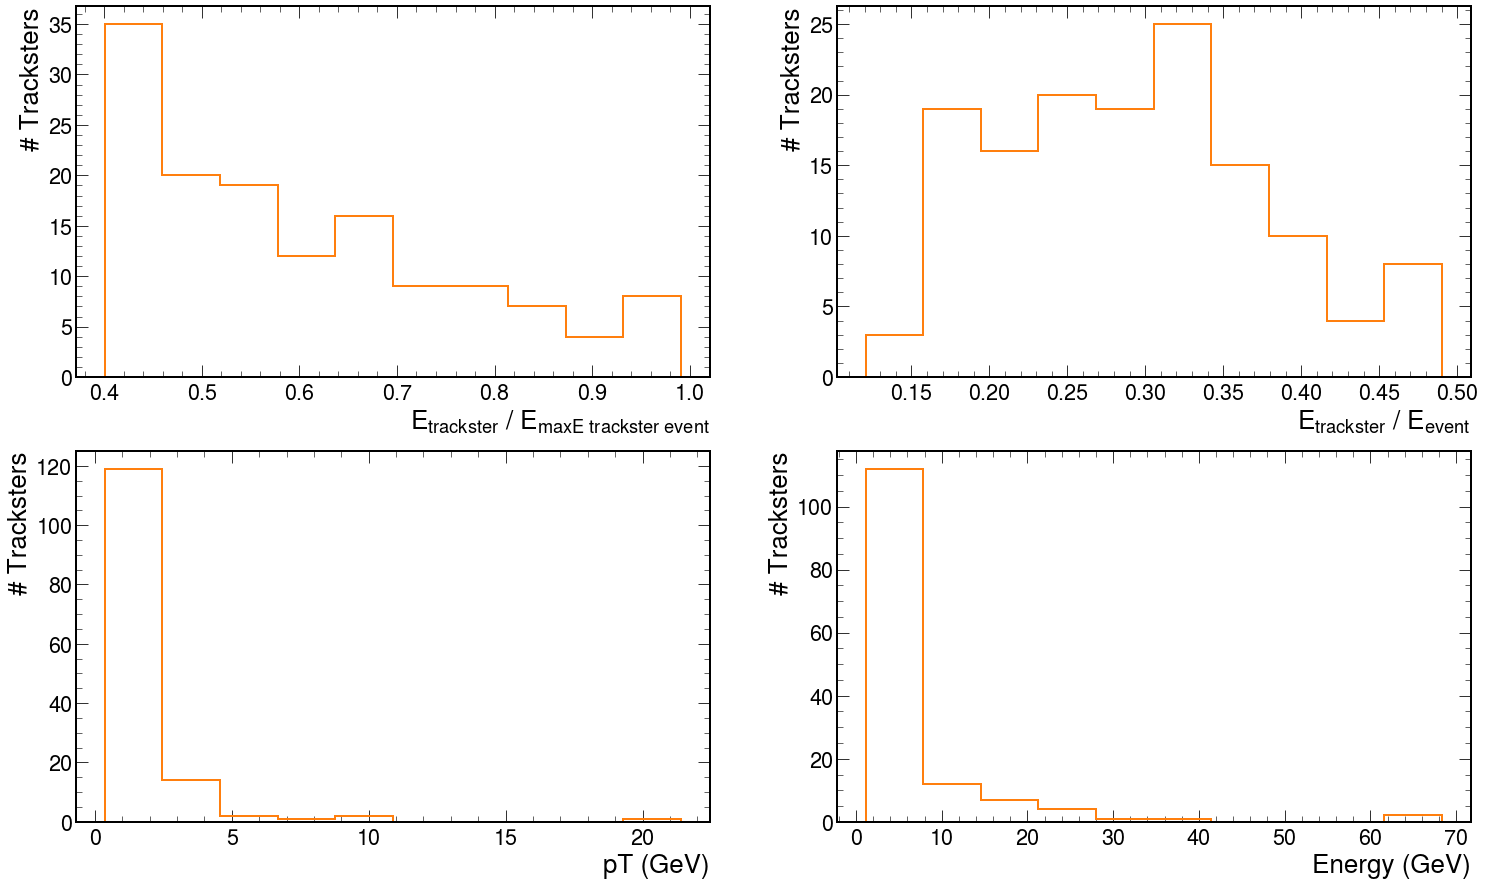

In [11]:
# Only for discarded events

n_bins = 10

sel   = (ratio_max != 1) & (skimmed == True) & (ratio_max > 0.4)

fig, axs = plt.subplots(2, 2, figsize=(25,15))

axs[0,0].hist(ratio_max[sel], bins=n_bins, histtype='step', lw=2, color ='tab:orange')
axs[0,0].set_xlabel(r'$E_{trackster}$ / $E_{maxE~trackster~event}$')
axs[0,0].set_ylabel('# Tracksters')
# axs[0].set_yscale('log')

axs[0,1].hist(ratio_sum[sel], bins=n_bins, histtype='step', lw=2, color ='tab:orange')
axs[0,1].set_xlabel(r'$E_{trackster}$ / $E_{event}$')
axs[0,1].set_ylabel('# Tracksters')
# axs[0].set_yscale('log')

axs[1,0].hist(pT[sel], bins=n_bins, histtype='step', lw=2, color ='tab:orange')
axs[1,0].set_xlabel(r'pT (GeV)')
axs[1,0].set_ylabel('# Tracksters')
# axs[1].set_yscale('log')


axs[1,1].hist(en[sel], bins=n_bins, histtype='step', lw=2, color ='tab:orange')
axs[1,1].set_xlabel(r'Energy (GeV)')
axs[1,1].set_ylabel('# Tracksters')
# axs[2].set_yscale('log')

plt.show()

# Energy response

In [9]:
def plotResolution(_recoEn, _recoEn_skim, _genEn, _bins, _bins_mean):
    
    colors  = ['tab:blue', 'tab:red']
    fmts    = ['o','s']
    labels  = ['Before skimming', 'After skimming']
    
    fig = plt.figure(figsize=(10,7), dpi=85)
#     hep.cms.label(llabel='Phase-II Simulation Preliminary',rlabel='')

    for idx, reco in enumerate([_recoEn, _recoEn_skim]):
        y_axis_cleaned = []
        y_axis_err_cleaned = []
        y_axis_err_lower_cleaned = []
        y_axis_err_upper_cleaned = []
        for index_b in range(len(bins)-1):
            genEnergy = _genEn[(_genEn > _bins[index_b]) & (_genEn < _bins[index_b+1])]
            recoEnergy = reco[(_genEn > _bins[index_b]) & (_genEn < _bins[index_b+1])]
            ratio = (recoEnergy/genEnergy)-1

            y_axis_cleaned.append(np.median(ratio))

            unc_low = np.percentile(ratio, 15.87)
            unc_upp = np.percentile(ratio, 84.13)
            y_axis_err_lower_cleaned.append(abs(unc_low-np.median(ratio)))
            y_axis_err_upper_cleaned.append(abs(unc_upp-np.median(ratio)))

        plt.errorbar(_bins_mean, y_axis_cleaned, yerr=[y_axis_err_lower_cleaned,y_axis_err_upper_cleaned], color=colors[idx], capsize=3, fmt=fmts[idx], label=labels[idx])
    plt.ylabel('($E_{event}/E_{GEN}) - 1$', loc='center')
    plt.xlabel('$E_{GEN}$ [GeV]', loc='center')
#     plt.ylim([-0.15,0.15])
    plt.axhline(0,color='black',ls='--')
    plt.legend(title=r'$\bf{PU = 0}$', loc = 'best', frameon=True)._legend_box.align = "left"
#     plt.savefig('energy_resolution_diff.pdf', dpi=100, bbox_inches='tight')
    plt.show()

def plotResolutionDistributions(_recoEn, _recoEn_skim, _cleanEn, _genEn, _bins, _bins_mean):
    
    colors  = ['tab:blue', 'tab:red']
    fmts    = ['o','s']
    labels  = ['Before skimming', 'After skimming']

    fig, axs = plt.subplots(4,5, figsize=(74, 30), facecolor='w', edgecolor='k')
    axs      = axs.ravel()

    for index_b in range(len(bins)-1):
        genEnergy          = _genEn[(_genEn > _bins[index_b]) & (_genEn < _bins[index_b+1])]
        recoEnergy         = _recoEn[(_genEn > _bins[index_b]) & (_genEn < _bins[index_b+1])]
        recoEnergySkimmed  = _recoEn_skim[(_genEn > _bins[index_b]) & (_genEn < _bins[index_b+1])]
        cleanEnergy        = _cleanEn[(_genEn > _bins[index_b]) & (_genEn < _bins[index_b+1])]
        
        fracarr            = (recoEnergy/genEnergy) - 1
        median             = np.median( fracarr )
        width              = np.percentile(fracarr, 84.13) - np.percentile(fracarr, 15.87)
        n_h, bins_h, _     = axs[index_b].hist( fracarr , bins=35, label = 'Before skimming', alpha=0.4, color='tab:blue')
        
        fracarr_skimmed    = (recoEnergySkimmed/genEnergy) - 1
        median_skimmed     = np.median( fracarr_skimmed )
        width_skimmed      = np.percentile(fracarr_skimmed, 84.13) - np.percentile(fracarr_skimmed, 15.87)
        axs[index_b].hist( fracarr_skimmed, bins=bins_h, label = 'After skimming', alpha=0.4, color='tab:red')
        
        axs[index_b].legend( title='median: '+str(round(median,3))+', width: '+str(round(width,3))+'\n median skim: '+str(round(median_skimmed,3))+', width skim: '+str(round(width_skimmed,3)) )
        print(((width-width_skimmed)/width)*100)
#         axs[index_b].hist( (cleanEnergy/genEnergy) - 1, bins=bins_h, label = 'After skimming + cleaning', alpha=0.4, color='tab:green')
#         axs[index_b].set_yscale('log')
        axs[index_b].set_title(r'$E_{GEN}\in['+str(round(_bins[index_b]))+','+str(round(_bins[index_b+1]))+']$ GeV')
        
    plt.show()

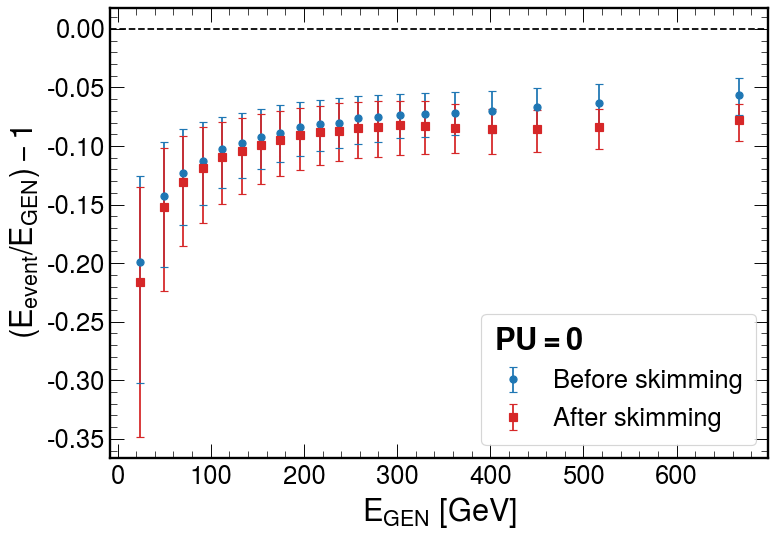

-20.83887686590094
-14.606397892362821
-14.649703696772567
-14.140672053752915
-15.26308929096424
-17.82707008859947
-15.07840446295819
-12.859702987096568
-14.539600143806483
-12.366962084696457
-14.882500598439
-15.807778464606473
-18.23315756583103
-20.969485398188098
-18.98211559732038
-13.673374685634847
-7.408629645169748
0.5031151443678539
0.5297863387790732
0.07735062038882655


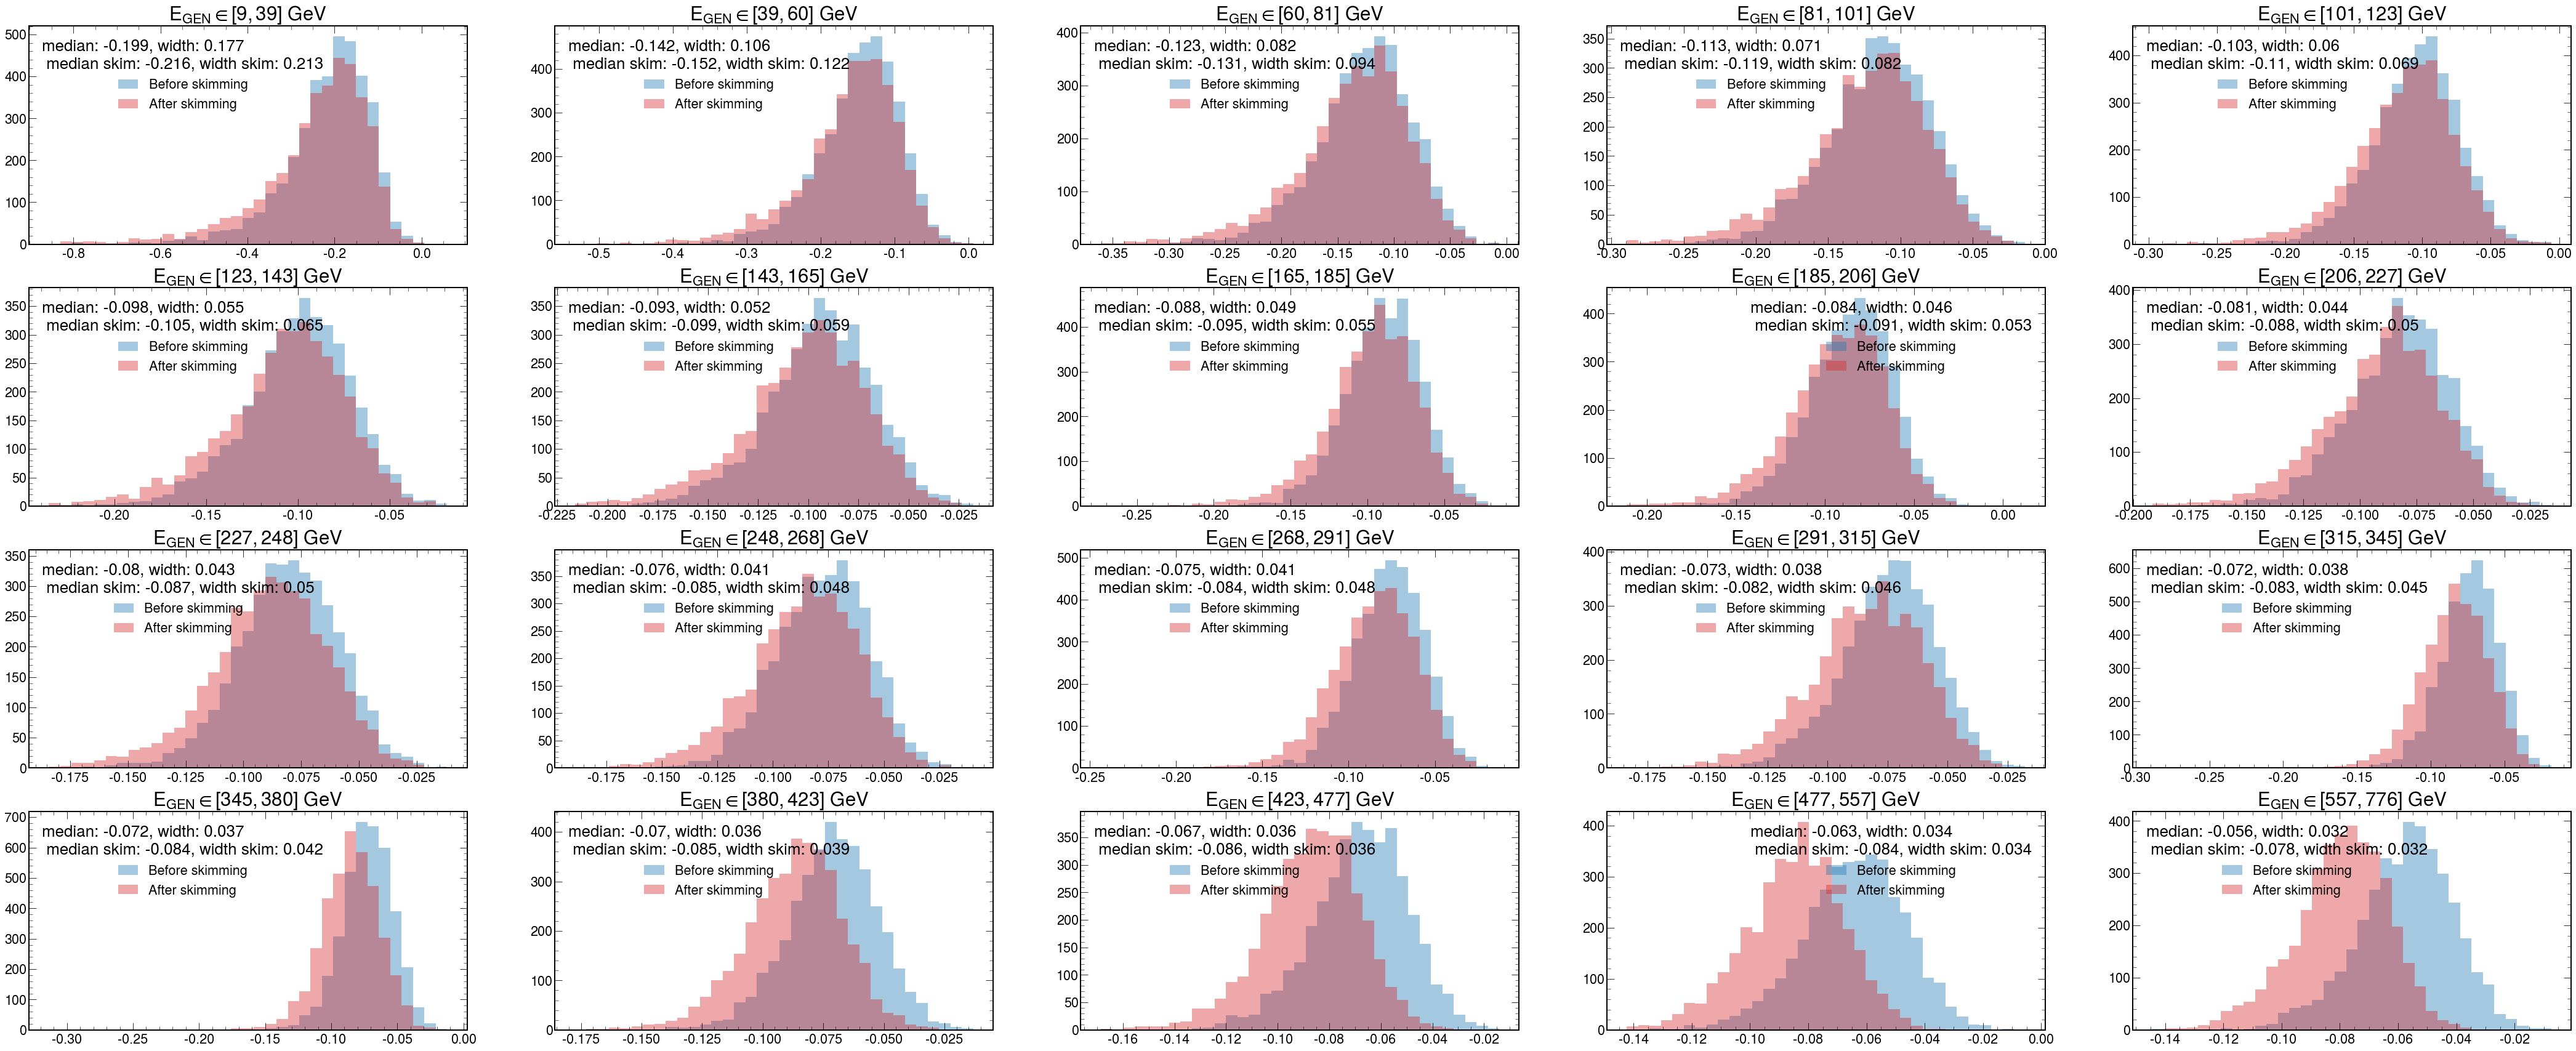

In [10]:
bins = histedges_equalN(genEn, 20)
bins_mean = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

plotResolution(recoEn,
               recoEn_skim,
               genEn,
               bins,
               bins_mean)

plotResolutionDistributions(recoEn,
                            recoEn_skim,
#                             cleanEn,
                            recoEn_skim, #Sostituisce cleanEn solo come placeholder
                            genEn,
                            bins,
                            bins_mean)


In [14]:
def cruijff(x, A, m, sigmaL,sigmaR, alphaL, alphaR):
    dx = (x-m)
    SL = np.full(x.shape, sigmaL)
    SR = np.full(x.shape, sigmaR)
    AL = np.full(x.shape, alphaL)
    AR = np.full(x.shape, alphaR)
    sigma = np.where(dx<0, SL,SR)
    alpha = np.where(dx<0, AL,AR)
    f = 2*sigma*sigma + alpha*dx*dx ;
    return A* np.exp(-dx*dx/f) 


def computeResFit(x_data, special = False, plot = False):
    nbins = 40
#     x_data = res_clean_vec['v4'][2]
    mean = np.median(x_data)
#     std = np.std(x_data)
    std = np.percentile(x_data, 84.13) - np.percentile(x_data, 15.87)
#     rangea = [mean-1.8*std, mean+1.8*std] ## This is for the plot Valsecchi style
    rangea = [mean-3*std, mean+3*std]
    if special:
        nbins = 50
        rangea = [0.6,3]
    hist, bin_edges = np.histogram(x_data, bins=nbins, range=rangea)
    hist=hist/sum(hist)

    n = len(hist)
    x_hist=np.zeros((n),dtype=float) 
    for ii in range(n):
        x_hist[ii]=(bin_edges[ii+1]+bin_edges[ii])/2

    y_hist=hist

    #Gaussian least-square fitting process
#     param_optimised,param_covariance_matrix = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,std],maxfev=10000)
    
    x_hist = x_hist[y_hist>0]
    y_hist = y_hist[y_hist>0]
    param_optimised,param_covariance_matrix = curve_fit(cruijff, x_hist, y_hist, p0=[np.max(y_hist), mean, std, std,  0.15, 0.15], sigma=np.sqrt(y_hist),absolute_sigma=True, maxfev=50000)
    
    if plot:
        x_hist_2=np.linspace(np.min(x_hist),np.max(x_hist),500)
    #     axs[b].plot(x_hist_2,gaus(x_hist_2,*param_optimised),'r.:',label='Gaussian fit')
        plt.plot(x_hist_2,cruijff(x_hist_2,*param_optimised),'r.:',label='Fit')
        plt.legend()

        #Normalise the histogram values
        weights = np.ones_like(x_data) / len(x_data)
        plt.hist(x_data, weights=weights, bins=nbins, range=rangea)

        #setting the label,title and grid of the plot
        plt.xlabel('$E_{supercluster}/E_{GEN}$')
        plt.ylabel("a.u.")
        plt.grid("on")
        plt.show()


#     return [param_optimised[1], param_optimised[2]]
    return [param_optimised[1], param_optimised[2], param_optimised[3]]

In [22]:
bins = histedges_equalN(genEn, 12)
bins_mean = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

mus = []
sigmas = []
res = []

for b in range(len(bins)-1):
    sel = (genEn > bins[b]) & (genEn < bins[b+1])
    ratio = recoEn[sel]/genEn[sel]
    fit = computeResFit(ratio)
    mu = fit[0]
    sigma = (abs(fit[1]) + abs(fit[2]))/2
    mus.append(mu)
    sigmas.append(sigma)
    res.append(sigma / mu)


mus_skim = []
sigmas_skim = []
res_skim = []
for b in range(len(bins)-1):
    sel = (genEn > bins[b]) & (genEn < bins[b+1])
    ratio = recoEn_skim[sel]/genEn[sel]
    fit = computeResFit(ratio)
    mu = fit[0]
    sigma = (abs(fit[1]) + abs(fit[2]))/2
    mus_skim.append(mu)
    sigmas_skim.append(sigma)
    res_skim.append(sigma / mu)


In [31]:
abs(np.array(sigmas) - np.array(sigmas_skim)) / np.array(sigmas) * 100

array([ 8.37620095,  7.5542274 ,  7.83661188, 13.42847848,  7.6580994 ,
       11.42657836, 11.62048756, 14.5023987 , 19.57157074, 12.26777455,
        3.23405466,  2.93948784])

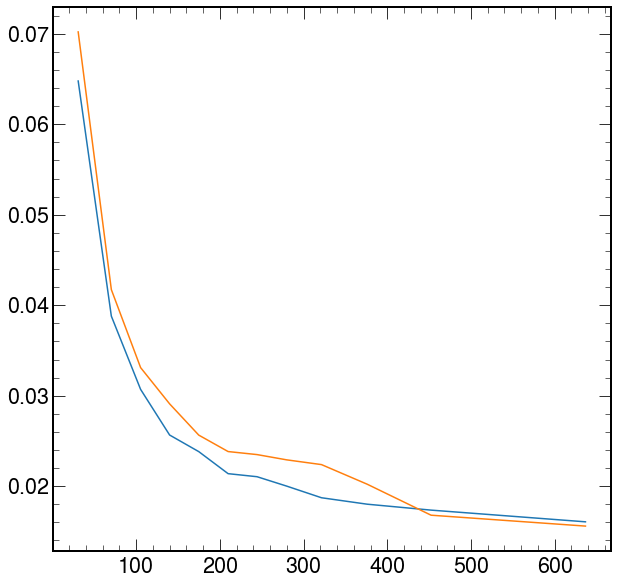

In [26]:
plt.plot(bins_mean, sigmas)
plt.plot(bins_mean, sigmas_skim)
plt.show()

# Angular studies

In [143]:
def angle_maxE(_el):
    sel = (_el.skim == False)
    skimmedTrk = []
    if len(_el.multi_en[sel]) == 0:
        idx_maxE = 0
    else:
        idx_maxE = np.argmax(_el.multi_en[sel])
    angles = []
    ens    = []
    gunen  = []
    dphi   = []
    nAxes  = len(_el.pca) #There is no need to apply sel here, pca is computed only for skim == False
    for i in range(nAxes):
        if i == idx_maxE: continue 
        computedAngle  = computeAngle(_el.pca[idx_maxE], _el.pca[i])
        complAngle     = 180 - computedAngle
        angles         .append( min(computedAngle,complAngle) )
        ens            .append(_el.multi_en[sel][i])
        gunen          .append(_el.gunEn)
        dphi           .append( abs(_el.multi_phi[sel][idx_maxE] - _el.multi_phi[sel][i]) )

    return [angles, ens, gunen, dphi]

def angle_outer(_el):
    gunen    =  _el.gunEn
    guneta   =  _el.gunEta
    gunpt    =  _el.gunPt
    
    sel = (_el.skim == False) #The PCA is computed just for skimmed tracksters
    
    if len(_el.multi_phi[sel]) == 0: #If the skimming kills the event, skip the function
        return [gunen, guneta, gunpt, -1, -1, -1, [], [], []]

    
    #Find the outer and inner trackster
    if _el.gunPID > 0:
        idx_outer = np.where(_el.multi_phi[sel] == max(_el.multi_phi[sel]))[0][0]
        idx_inner = np.where(_el.multi_phi[sel] == min(_el.multi_phi[sel]))[0][0]
    else:
        idx_outer = np.where(_el.multi_phi[sel] == min(_el.multi_phi[sel]))[0][0]
        idx_inner = np.where(_el.multi_phi[sel] == max(_el.multi_phi[sel]))[0][0]
        
    angles      = []
    ens         = []
    dphi        = []
    nAxes       = len(_el.pca) #There is no need to apply sel here, pca is computed only for skim == False
    
    if idx_outer != idx_inner:
        angle_out_in   = computeAngle(_el.pca_signed[idx_outer], _el.pca_signed[idx_inner])
        dphi_out_in    = _el.multi_phi[idx_outer] - _el.multi_phi[idx_inner]
        if dphi_out_in > np.pi:
            dphi_out_in = abs(dphi_out_in - 2*np.pi)
        elif dphi_out_in < -np.pi:
            dphi_out_in = abs(dphi_out_in + 2*np.pi)
        else:
            dphi_out_in = abs(dphi_out_in)
    else: #In this case there is just one trackster, so the inner == outer
        angle_out_in   = -1
        dphi_out_in    = -1
    
    en_outer = _el.multi_en[sel][idx_outer]
    
    #Here we compute the angle and the deltaPhi between the outermost trackster and all the other tracksters
    for i in range(nAxes):
        if i == idx_outer: continue 
        angles .append(computeAngle(_el.pca_signed[idx_outer], _el.pca_signed[i]))
        dphi   .append (abs(_el.multi_phi[sel][idx_outer] - _el.multi_phi[sel][i]) )
        ens    .append(_el.multi_en[sel][i])

    return [gunen, guneta, gunpt, angle_out_in, dphi_out_in, en_outer, angles, dphi, ens]

In [12]:
def computeAngle(vector_1, vector_2):
    if np.array_equal(vector_1,vector_2):
        return 0
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product   = np.dot(unit_vector_1, unit_vector_2)
#     angle         = np.degrees(np.arccos(dot_product))
    angle         = np.arccos(dot_product)
    return angle

def computeDeltaPhi(phi_1, phi_2):
    deltaPhi = phi_1 - phi_2
    if deltaPhi > np.pi:
        deltaPhi = abs(deltaPhi - 2*np.pi)
    elif deltaPhi < - np.pi:
        deltaPhi = abs(deltaPhi + 2*np.pi)
    else:
        deltaPhi = abs(deltaPhi)
    return deltaPhi

def findOutIn(_evt):
#     if _pid > 0:
#         idx_outer = np.where(_multi_phi == max(_multi_phi))[0][0]
#         idx_inner = np.where(_multi_phi == min(_multi_phi))[0][0]
#     else:
#         idx_outer = np.where(_multi_phi == min(_multi_phi))[0][0]
#         idx_inner = np.where(_multi_phi == max(_multi_phi))[0][0]
                                    
    if _evt.gunPID > 0:
        idx_outer = np.where(_evt.skim == False)[0][np.argmax(_evt.multi_phi[_evt.skim == False])]
        idx_inner = np.where(_evt.skim == False)[0][np.argmin(_evt.multi_phi[_evt.skim == False])]
    else:
        idx_outer = np.where(_evt.skim == False)[0][np.argmin(_evt.multi_phi[_evt.skim == False])]
        idx_inner = np.where(_evt.skim == False)[0][np.argmax(_evt.multi_phi[_evt.skim == False])]
        
    return idx_outer, idx_inner

def dfAngularStudies(_el):
    
#     sel       = (_el.skim == False) #The PCA is computed just for skimmed tracksters
    sel       = np.array( [evt.skim == False for evt in _el] )
    
    gunen     = np.array( [evt.gunEn                                            for evt in _el] )
    guneta    = np.array( [evt.gunEta                                           for evt in _el] )
    gunpt     = np.array( [evt.gunPt                                            for evt in _el] )
    gunphi    = np.array( [evt.gunPhi                                           for evt in _el] )
    nTrk      = np.array( [evt.nTracksters                                      for evt in _el] ) #All tracksters in the event
    nTrk_skim = np.array( [len([i for i in evt.pca if len(i) > 0])              for evt in _el] ) #Number of tracksters surviving the skimming. In evt.pca you have a non-empty list only for surviving trk
    nTrk_gen  = np.array( [len(np.where(evt.skim[evt.genMatching] == False)[0]) for evt in _el] ) #Number of trk surviving the skimming and gen-matched
    genMatch  = np.array( [evt.genMatching                                      for evt in _el] )
    skim      = np.array( [evt.skim                                             for evt in _el] )
    
#     for idx, evt in enumerate(_el):
#         print(idx)
#         print(nTrk_skim[idx])
#         if nTrk_skim[idx] > 0:
#             np.where(evt.skim == False)[0][np.argmax(evt.multi_en[evt.skim == False])]
#         else: 
#             -1
    
    idx_maxE  = np.array( [np.where(evt.skim == False)[0][np.argmax(evt.multi_en[evt.skim == False])] if nTrk_skim[idx] > 0 else -1 for idx, evt in enumerate(_el)] ) #Find the index of the most energetic trk
    

    #Angle of all the tracksters in the event with the maxE trackster
    angles_maxE = np.array( [ np.array([ computeAngle(evt.pca_signed[ idx_maxE[idx_evt] ], evt.pca_signed[ idx_trk ]) 
                                        if nTrk_skim[idx_evt] > 1 and skim[idx_evt][idx_trk]==False else -1 #We need at least two tracksters and we compute the angle only for trk surviving the skimming procedure
                                        for idx_trk in range(nTrk[idx_evt]) ]) 
                             for idx_evt, evt in enumerate(_el) ] )
    
    #Find the outer and inner trackster
    #If there are no tracksters, the index is set to -1            
    idx_outer = np.array( [findOutIn(evt)[0] if nTrk_skim[idx] > 1 else -1 for idx,evt in enumerate(_el)] )
    idx_inner = np.array( [findOutIn(evt)[1] if nTrk_skim[idx] > 1 else -1 for idx,evt in enumerate(_el)] ) 
    
#     for idx,evt in enumerate(_el):
#         print(idx)
#         print(nTrk_skim[idx])
#         if nTrk_skim[idx] > 1:
#             computeAngle   (evt.pca_signed[ idx_outer[idx] ], evt.pca_signed[ idx_inner[idx] ]) 
#         else:
#             -1
    
    angle_out_in = np.array( [computeAngle   (evt.pca_signed[ idx_outer[idx] ], evt.pca_signed[ idx_inner[idx] ]) if nTrk_skim[idx] > 1 else -1 for idx,evt in enumerate(_el)])
    dphi_out_in  = np.array( [computeDeltaPhi(evt.multi_phi[ idx_outer[idx] ],  evt.multi_phi[ idx_inner[idx] ])  if nTrk_skim[idx] > 1 else -1 for idx,evt in enumerate(_el)])
    deta_out_in  = np.array( [abs(evt.multi_eta[ idx_outer[idx] ] - evt.multi_eta[ idx_inner[idx] ])              if nTrk_skim[idx] > 1 else -1 for idx,evt in enumerate(_el)])
    
    d = {'gunen'       : gunen, 
         'guneta'      : guneta,
         'gunpt'       : gunpt,
         'gunphi'      : gunphi,
         'nTrk'        : nTrk,
         'nTrk_skim'   : nTrk_skim,
         'nTrk_gen'    : nTrk_gen,
         'genMatch'    : genMatch,
         'skim'        : skim,
         'angle_out_in': angle_out_in,
         'dphi_out_in' : dphi_out_in,
         'deta_out_in' : deta_out_in,
         'angles_maxE' : angles_maxE
        }
    df = pd.DataFrame(data=d)
    
    return df


In [22]:
dfAngles            = dfAngularStudies(ele)
angles_maxE_flatten = np.array( [angle for angles in dfAngles.angles_maxE[dfAngles.nTrk>1] for angle in angles if angle != 0] )
gunen_flatten       = np.array( [gen for gen, ntrk in zip(dfAngles.gunen, dfAngles.nTrk) for n in range(ntrk-1)] )

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths 

NameError: name 'dfAngles' is not defined

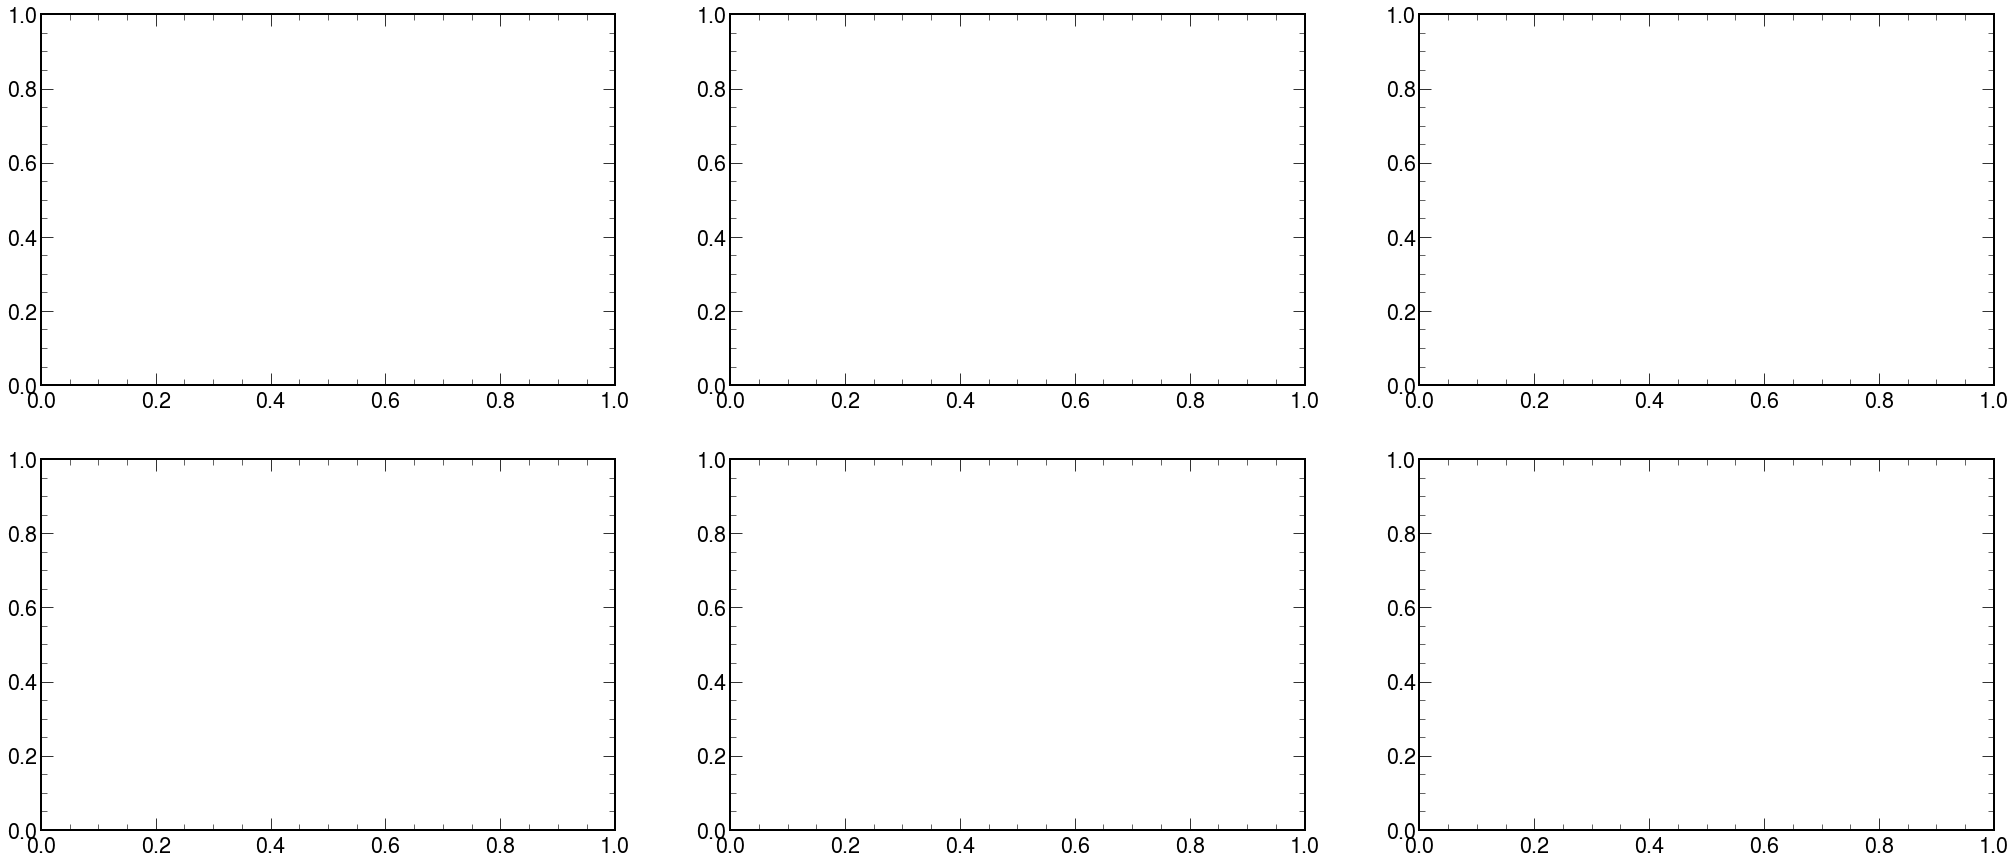

In [21]:
fig, axs = plt.subplots(2,3, figsize=(35, 15), facecolor='w', edgecolor='k')
axs      = axs.ravel()

axs[0].hist(dfAngles[dfAngles.angle_out_in>0].angle_out_in, bins=60)
axs[0].set_xlabel(r'$\theta(trk_{outer}, trk_{inner})$')
axs[0].set_ylabel(r'Events ($N_{trk}>1)$', fontsize=20)

axs[1].hist(dfAngles[dfAngles.dphi_out_in>0].dphi_out_in, bins=60)
axs[1].set_xlabel(r'$\Delta\phi(trk_{outer}, trk_{inner})$')
axs[1].set_ylabel(r'Events ($N_{trk}>1)$', fontsize=20)

axs[2].hist(angles_maxE_flatten, bins=60)
axs[2].set_xlabel(r'$\theta(trk_{maxE}, trk)$')
axs[2].set_ylabel(r'Tracksters for events $N_{trk}>1$', fontsize=20)

#Same plot with log scale
axs[3].hist(angles_outer_flatten[angles_outer_flatten>0], bins=60)
axs[3].set_xlabel(r'$\theta(trk_{outer}, trk_{inner})$')
axs[3].set_ylabel(r'Events ($N_{trk}>1)$', fontsize=20)
axs[3].set_yscale('log')

axs[4].hist(angles_outer_inner[angles_outer_inner>0], bins=60)
axs[4].set_xlabel(r'$\Delta\phi(trk_{outer}, trk_{inner})$')
axs[4].set_ylabel(r'Events ($N_{trk}>1)$', fontsize=20)
axs[4].set_yscale('log')

axs[5].hist(angles_maxE_flatten, bins=60)
axs[5].set_xlabel(r'$\theta(trk_{maxE}, trk)$')
axs[5].set_ylabel(r'Tracksters for events $N_{trk}>1$', fontsize=20)
axs[5].set_yscale('log')


plt.show()

In [24]:
def effrms(data, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    x = np.sort(data, kind='mergesort')
    m = int(c *len(x)) + 1
    out = [np.min(x[m:] - x[:-m]) / 2.0]

    return out

In [25]:
def coverage_68(data):
    unc_low = np.percentile(data, 15.87)
    unc_upp = np.percentile(data, 84.13)
    median  = np.median(data)
    lower_err = abs( unc_low - median )
    upper_err = abs( unc_upp - median )

    return [lower_err,upper_err]
    

########################### ------------------------------------ Angle ------------------------------------ ###########################


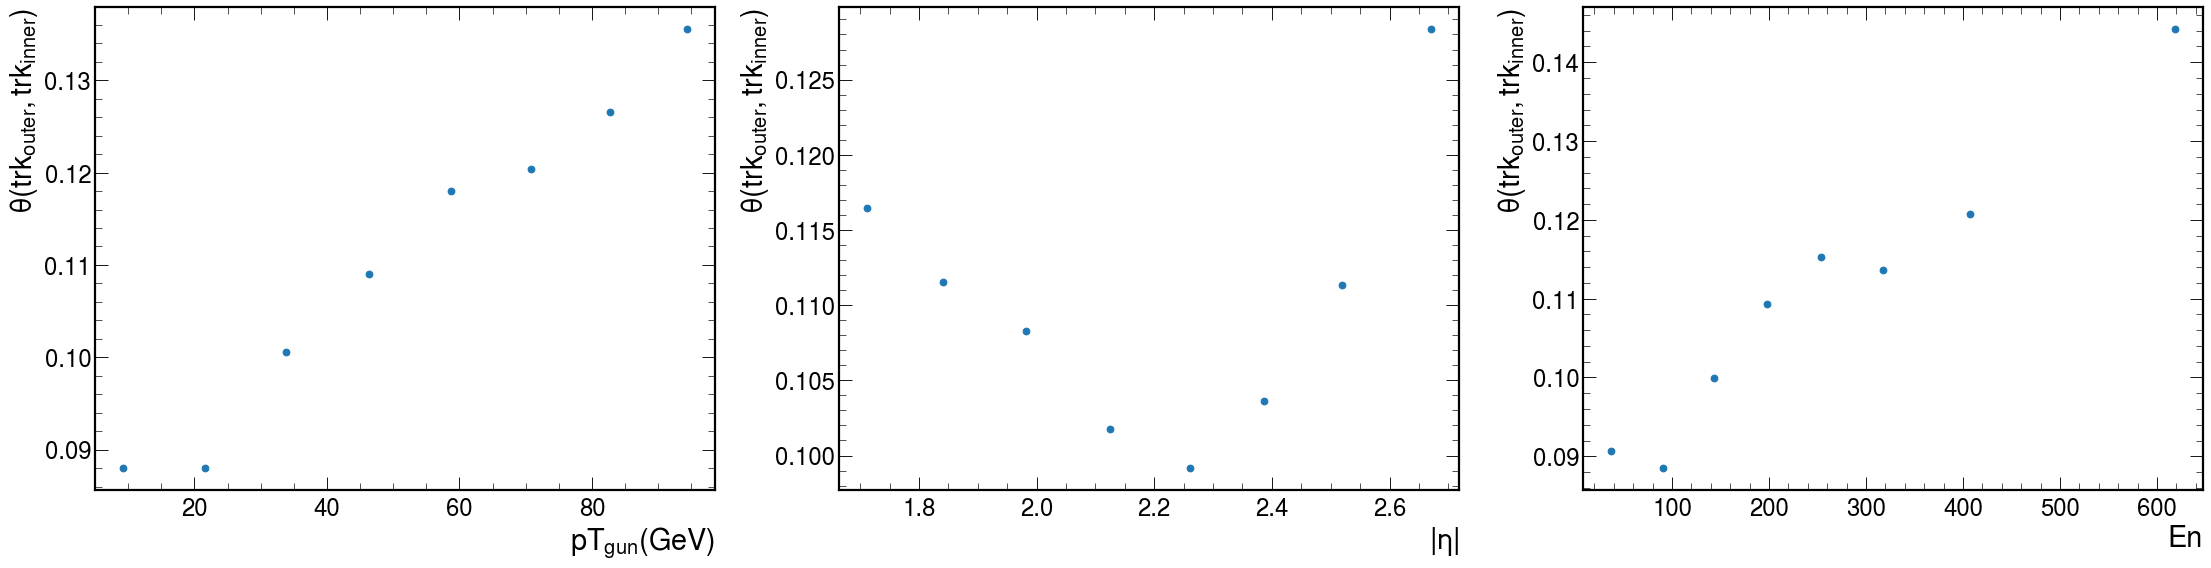

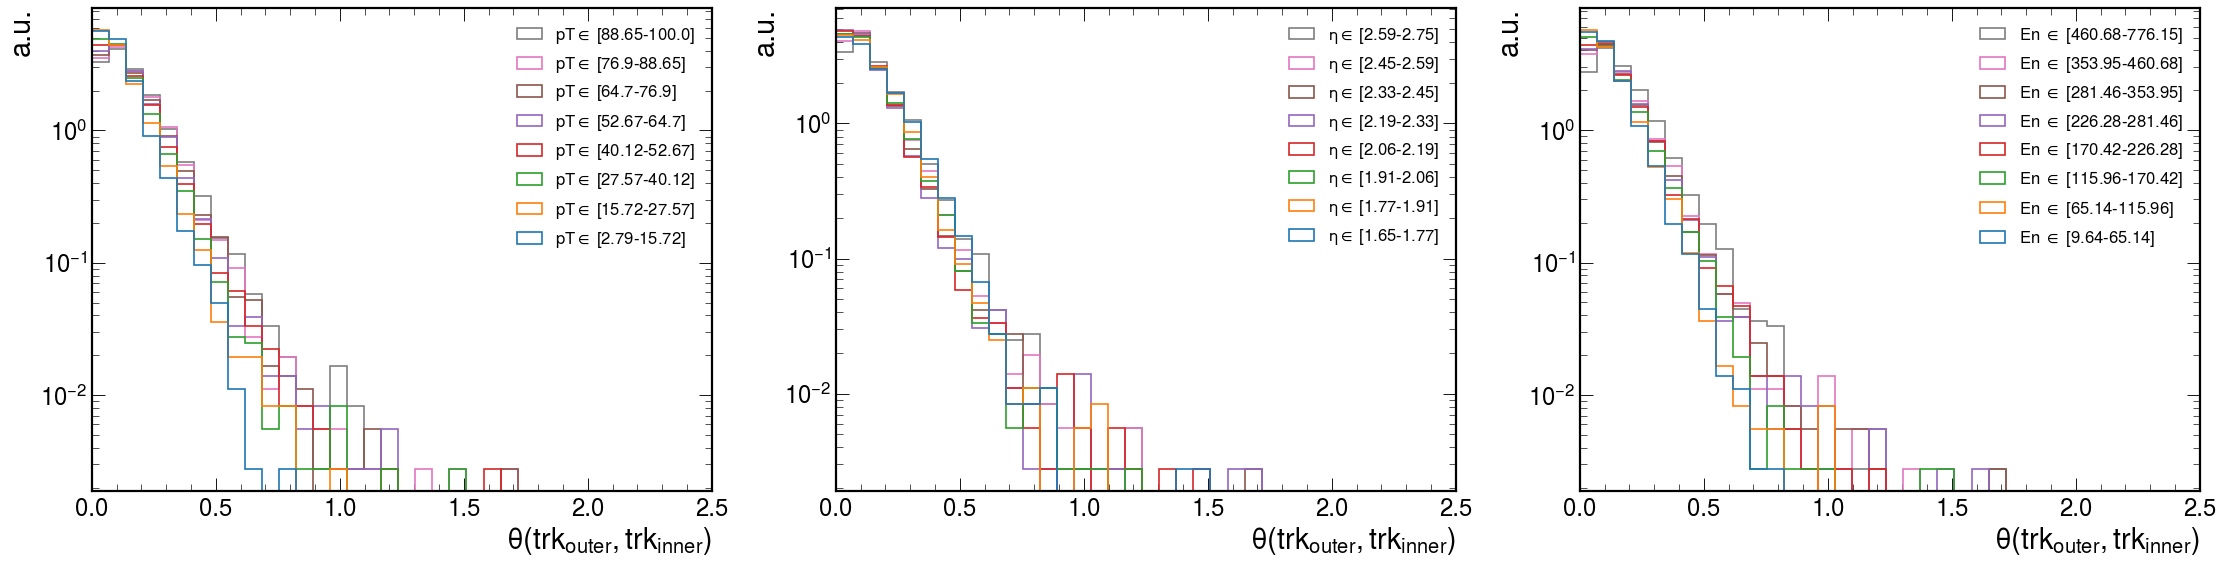

########################### ------------------------------------ DeltaPhi ------------------------------------ ###########################


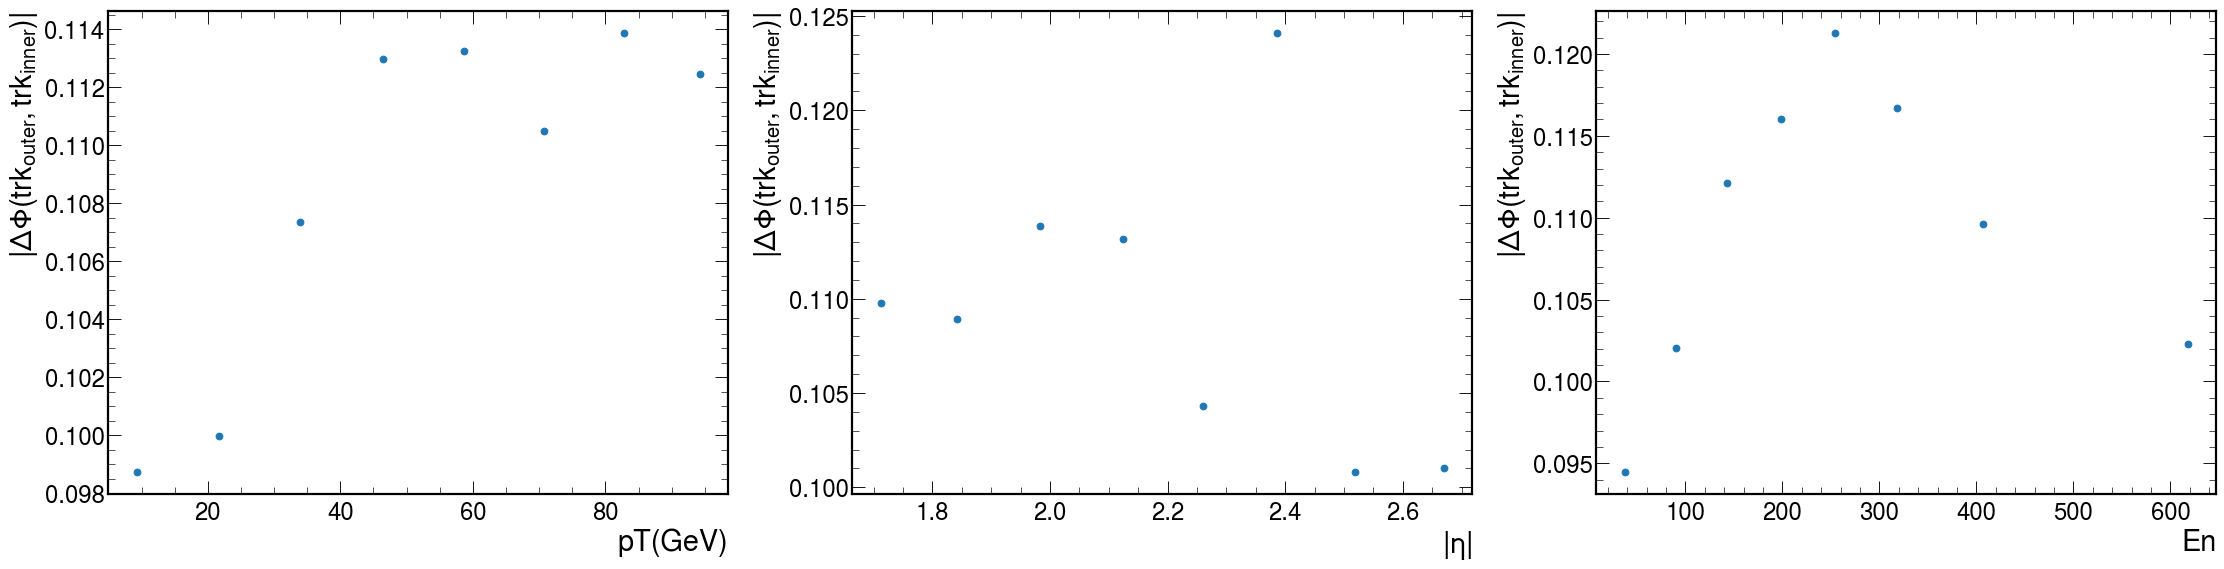

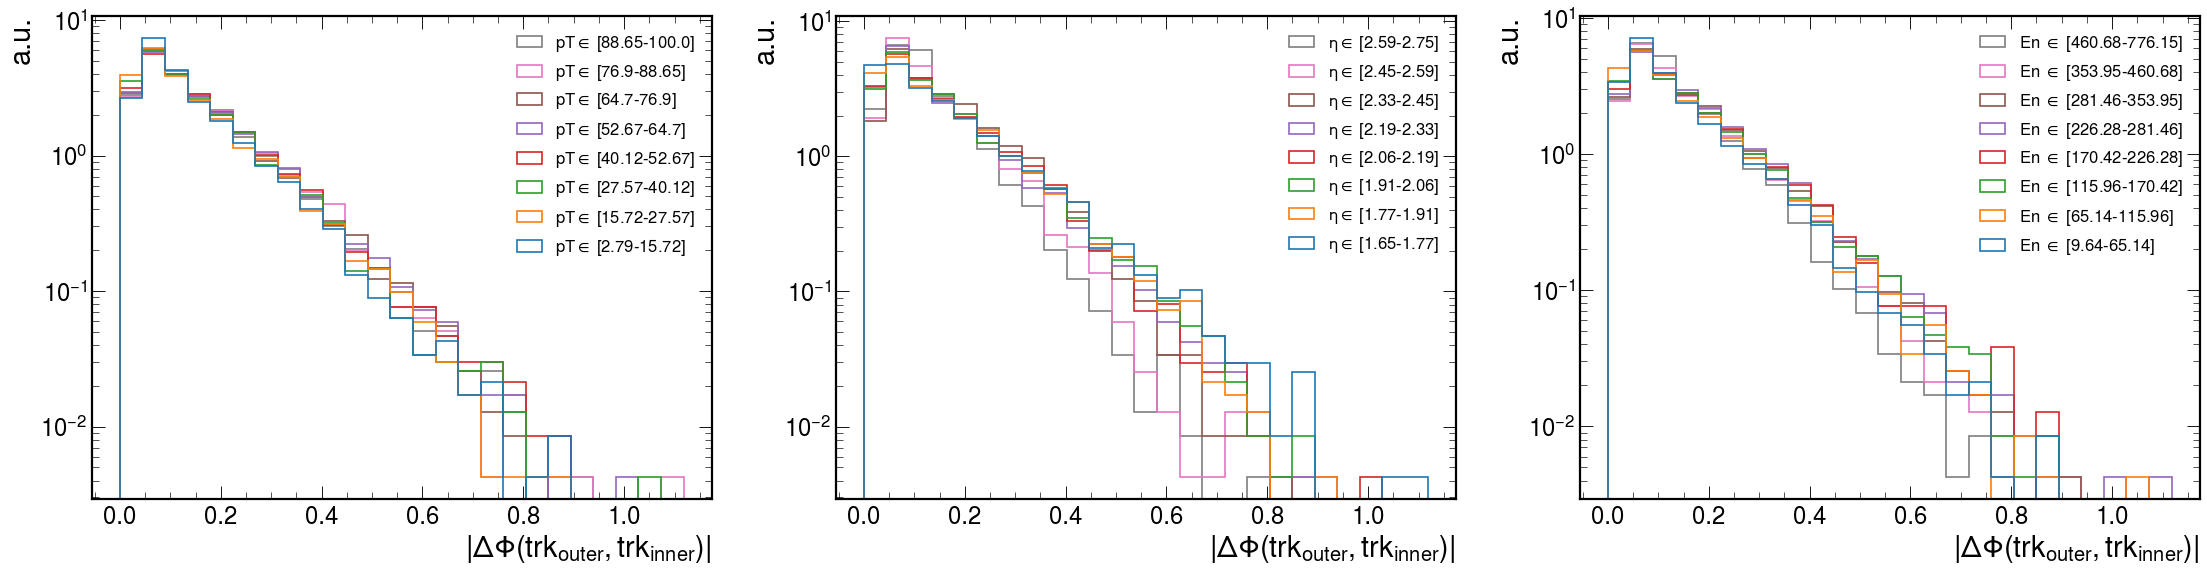

########################### ------------------------------------ DeltaEta ------------------------------------ ###########################


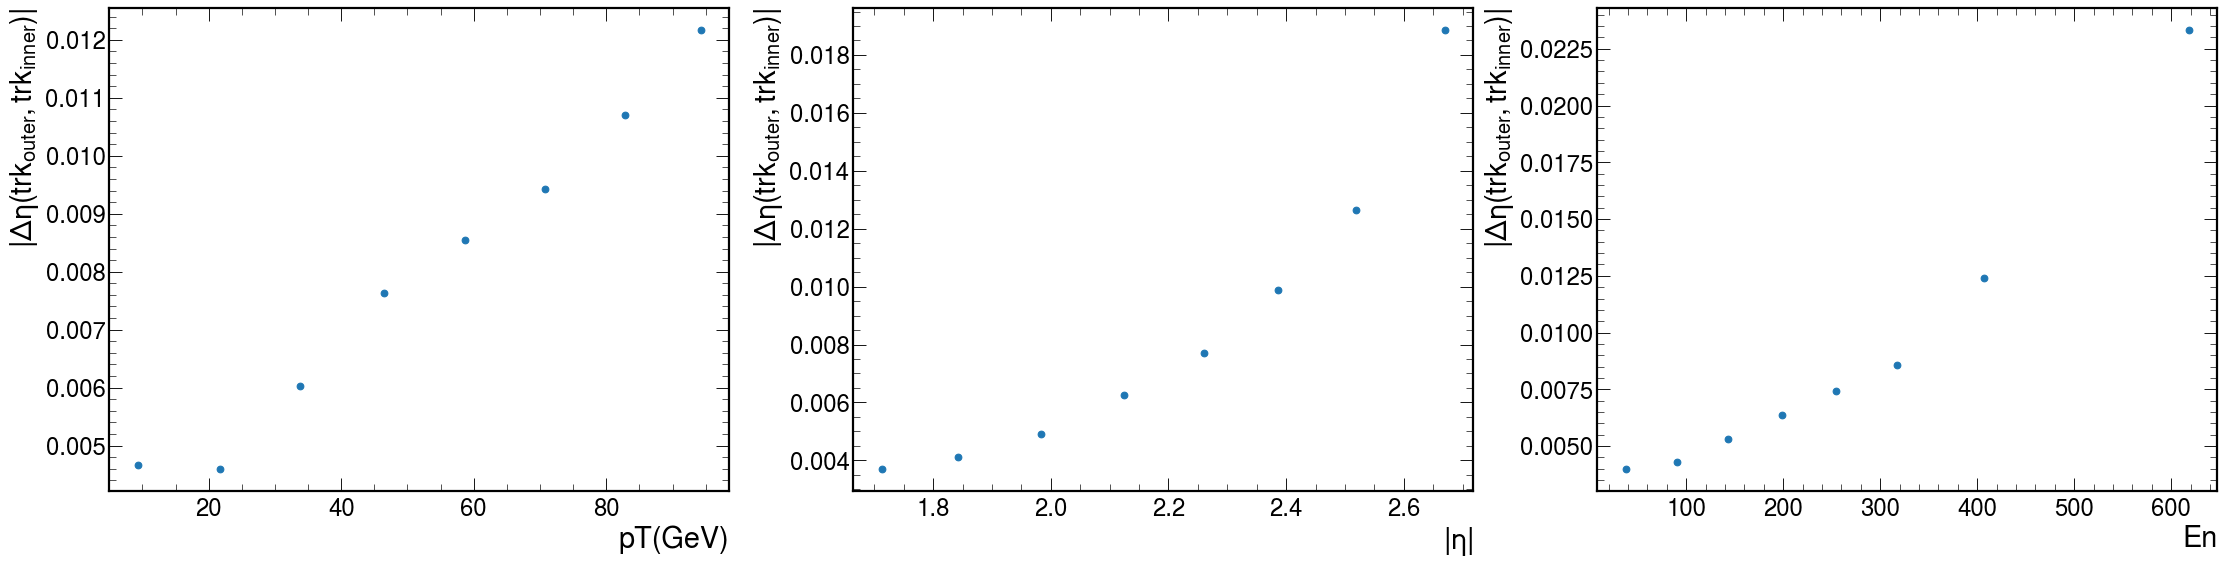

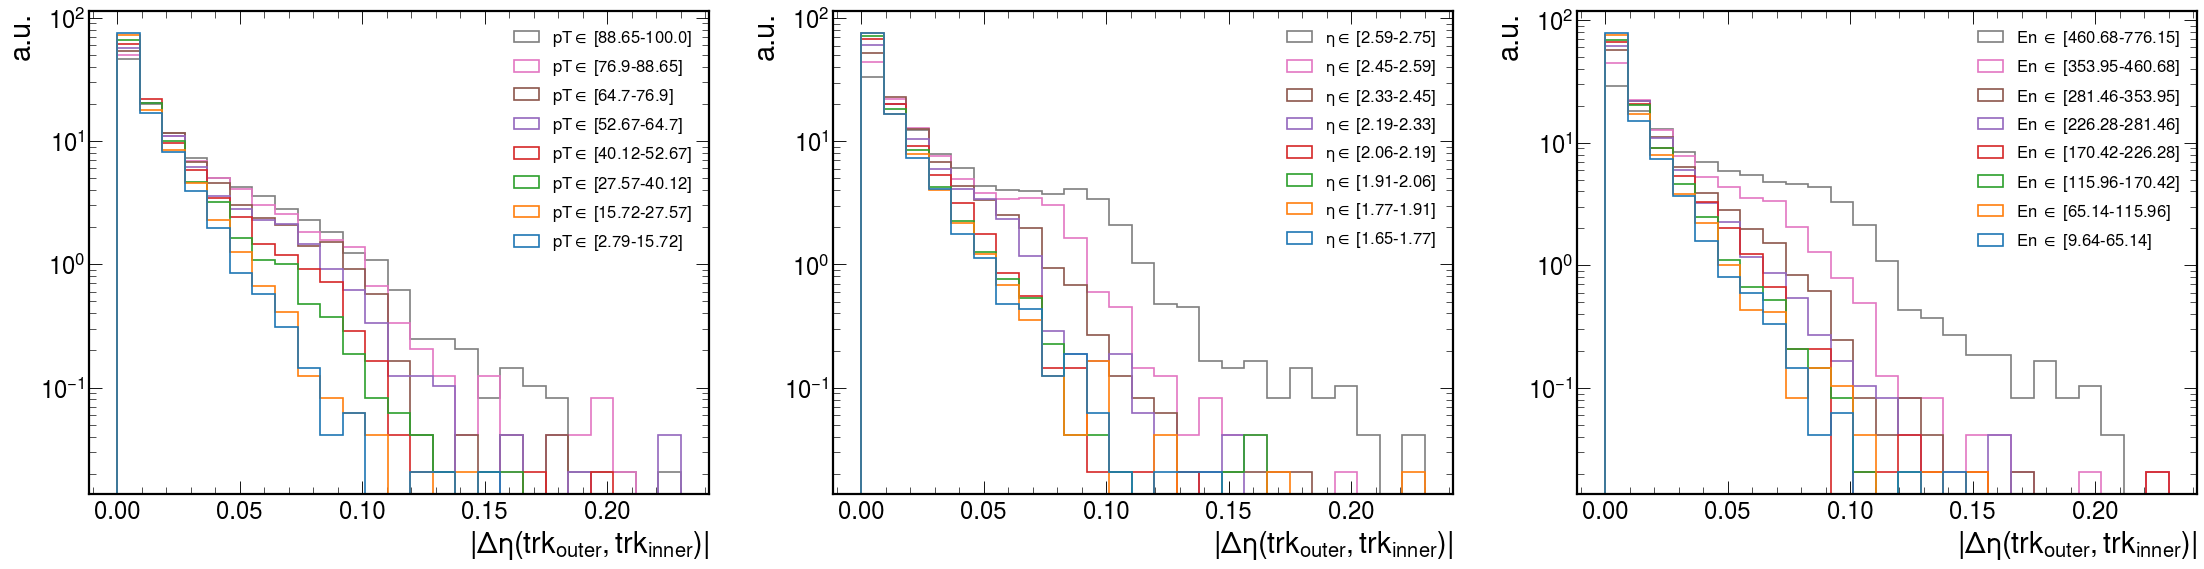

In [30]:
pT_bin  = histedges_equalN(dfAngles.gunpt[dfAngles.nTrk_skim>1], 8) 
eta_bin = histedges_equalN(abs(dfAngles.guneta[dfAngles.nTrk_skim>1]), 8) 
en_bin  = histedges_equalN(dfAngles.gunen[dfAngles.nTrk_skim>1], 8) 

angles_pT       = np.array( [dfAngles.angle_out_in[(dfAngles.angle_out_in>0) & (dfAngles.gunpt>pT_bin[i]) & (dfAngles.gunpt<pT_bin[i+1])] for i in range(len(pT_bin)-1)], dtype=object)
dphi_pT         = np.array( [dfAngles.dphi_out_in[(dfAngles.dphi_out_in>0) & (dfAngles.gunpt>pT_bin[i]) & (dfAngles.gunpt<pT_bin[i+1])] for i in range(len(pT_bin)-1)], dtype=object)
deta_pT         = np.array( [dfAngles.deta_out_in[(dfAngles.deta_out_in>0) & (dfAngles.gunpt>pT_bin[i]) & (dfAngles.gunpt<pT_bin[i+1])] for i in range(len(pT_bin)-1)], dtype=object)
median_angle_pT = np.array( [np.median( angles ) for angles in angles_pT] )
median_dphi_pT  = np.array( [np.median( dphis )  for dphis  in dphi_pT] ) 
median_deta_pT  = np.array( [np.median( detas )  for detas  in deta_pT] ) 
centre_pT       = [ (pT_bin[:-1] + pT_bin[1:]) / 2 ]

angles_eta       = np.array( [dfAngles.angle_out_in[(dfAngles.angle_out_in>0) & (abs(dfAngles.guneta)>eta_bin[i]) & (abs(dfAngles.guneta)<eta_bin[i+1])] for i in range(len(eta_bin)-1)], dtype=object)
dphi_eta         = np.array( [dfAngles.dphi_out_in [(dfAngles.angle_out_in>0) & (abs(dfAngles.guneta)>eta_bin[i]) & (abs(dfAngles.guneta)<eta_bin[i+1])] for i in range(len(eta_bin)-1)], dtype=object)
deta_eta         = np.array( [dfAngles.deta_out_in [(dfAngles.angle_out_in>0) & (abs(dfAngles.guneta)>eta_bin[i]) & (abs(dfAngles.guneta)<eta_bin[i+1])] for i in range(len(eta_bin)-1)], dtype=object)
median_angle_eta = np.array( [np.median( angles ) for angles in angles_eta] )
median_dphi_eta  = np.array( [np.median( dphis )  for dphis  in dphi_eta] )
median_deta_eta  = np.array( [np.median( detas )  for detas  in deta_eta] )
centre_eta       = [ (eta_bin[:-1] + eta_bin[1:]) / 2 ]

angles_en       = np.array( [dfAngles.angle_out_in[(dfAngles.angle_out_in>0) & (dfAngles.gunen>en_bin[i]) & (dfAngles.gunen<en_bin[i+1])] for i in range(len(en_bin)-1)], dtype=object)
dphi_en         = np.array( [dfAngles.dphi_out_in [(dfAngles.angle_out_in>0) & (dfAngles.gunen>en_bin[i]) & (dfAngles.gunen<en_bin[i+1])] for i in range(len(en_bin)-1)], dtype=object)
deta_en         = np.array( [dfAngles.deta_out_in [(dfAngles.angle_out_in>0) & (dfAngles.gunen>en_bin[i]) & (dfAngles.gunen<en_bin[i+1])] for i in range(len(en_bin)-1)], dtype=object)
median_angle_en = np.array( [np.median( angles ) for angles in angles_en] )
median_dphi_en  = np.array( [np.median( dphis )  for dphis  in dphi_en] )
median_deta_en  = np.array( [np.median( detas )  for detas  in deta_en] )
centre_en       = [ (en_bin[:-1] + en_bin[1:]) / 2 ]

    
print('########################### ------------------------------------ Angle ------------------------------------ ###########################')

nbins = 25
fontsize_legend = 15

fig, axs = plt.subplots(1,3,figsize=(34,8), dpi=80)
axs.ravel()
axs[0].scatter(centre_pT, median_angle_pT)
# axs[0].errorbar(centre_pT[0], mean_angle_pT, yerr=np.array(list(zip(mean_angle_pT_err_low, mean_angle_pT_err_upp))).T)
axs[0].set_xlabel(r'$pT_{gun}$(GeV)')
axs[0].set_ylabel(r'$\theta(trk_{outer}, trk_{inner})$')
axs[1].scatter(centre_eta, median_angle_eta)
axs[1].set_xlabel(r'|$\eta$|')
axs[1].set_ylabel(r'$\theta(trk_{outer}, trk_{inner})$')
axs[2].scatter(centre_en, median_angle_en)
axs[2].set_xlabel(r'En')
axs[2].set_ylabel(r'$\theta(trk_{outer}, trk_{inner})$')
plt.show()


fig, axs = plt.subplots(1,3,figsize=(34,8), dpi=80)
axs.ravel()
axs[0].hist(angles_pT, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'pT$\in$ ['+str(round(pT_bin[i],2))+'-'+str(round(pT_bin[i+1],2))+']' for i in range(len(pT_bin)-1)])
axs[0].set_xlabel(r'$\theta(trk_{outer}, trk_{inner})$')
axs[0].set_ylabel('a.u.')
axs[0].set_xlim([0,2.5])
axs[0].set_yscale('log')
axs[0].legend(fontsize=fontsize_legend)
axs[1].hist(angles_eta, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'$\eta\in$ ['+str(round(eta_bin[i],2))+'-'+str(round(eta_bin[i+1],2))+']' for i in range(len(eta_bin)-1)])
axs[1].set_xlabel(r'$\theta(trk_{outer}, trk_{inner})$')
axs[1].set_ylabel('a.u.')
axs[1].set_xlim([0,2.5])
axs[1].set_yscale('log')
axs[1].legend(fontsize=fontsize_legend)
axs[2].hist(angles_en, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'En $\in$ ['+str(round(en_bin[i],2))+'-'+str(round(en_bin[i+1],2))+']' for i in range(len(en_bin)-1)])
axs[2].set_xlabel(r'$\theta(trk_{outer}, trk_{inner})$')
axs[2].set_ylabel('a.u.')
axs[2].set_xlim([0,2.5])
axs[2].set_yscale('log')
axs[2].legend(fontsize=fontsize_legend)
plt.show()

print('########################### ------------------------------------ DeltaPhi ------------------------------------ ###########################')

fig, axs = plt.subplots(1,3,figsize=(34,8), dpi=80)
axs.ravel()
axs[0].scatter(centre_pT, median_dphi_pT)
axs[0].set_xlabel('pT(GeV)')
axs[0].set_ylabel(r'$|\Delta\Phi(trk_{outer}, trk_{inner})|$')
axs[1].scatter(centre_eta, median_dphi_eta)
axs[1].set_xlabel(r'|$\eta$|')
axs[1].set_ylabel(r'$|\Delta\Phi(trk_{outer}, trk_{inner})|$')
axs[2].scatter(centre_en, median_dphi_en)
axs[2].set_xlabel(r'En')
axs[2].set_ylabel(r'$|\Delta\Phi(trk_{outer}, trk_{inner})|$')
plt.show()

fig, axs = plt.subplots(1,3,figsize=(34,8), dpi=80)
axs.ravel()
axs[0].hist(dphi_pT, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'pT$\in$ ['+str(round(pT_bin[i],2))+'-'+str(round(pT_bin[i+1],2))+']' for i in range(len(pT_bin)-1)])
axs[0].set_xlabel(r'$|\Delta\Phi(trk_{outer}, trk_{inner})|$')
axs[0].set_ylabel('a.u.')
axs[0].set_yscale('log')
axs[0].legend(fontsize=fontsize_legend)
axs[1].hist(dphi_eta, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'$\eta\in$ ['+str(round(eta_bin[i],2))+'-'+str(round(eta_bin[i+1],2))+']' for i in range(len(eta_bin)-1)])
axs[1].set_xlabel(r'$|\Delta\Phi(trk_{outer}, trk_{inner})|$')
axs[1].set_ylabel('a.u.')
axs[1].set_yscale('log')
axs[1].legend(fontsize=fontsize_legend)
axs[2].hist(dphi_en, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'En $\in$ ['+str(round(en_bin[i],2))+'-'+str(round(en_bin[i+1],2))+']' for i in range(len(en_bin)-1)])
axs[2].set_xlabel(r'$|\Delta\Phi(trk_{outer}, trk_{inner})|$')
axs[2].set_ylabel('a.u.')
axs[2].set_yscale('log')
axs[2].legend(fontsize=fontsize_legend)
plt.show()

print('########################### ------------------------------------ DeltaEta ------------------------------------ ###########################')

fig, axs = plt.subplots(1,3,figsize=(34,8), dpi=80)
axs.ravel()
axs[0].scatter(centre_pT, median_deta_pT)
axs[0].set_xlabel('pT(GeV)')
axs[0].set_ylabel(r'$|\Delta\eta(trk_{outer}, trk_{inner})|$')
axs[1].scatter(centre_eta, median_deta_eta)
axs[1].set_xlabel(r'|$\eta$|')
axs[1].set_ylabel(r'$|\Delta\eta(trk_{outer}, trk_{inner})|$')
axs[2].scatter(centre_en, median_deta_en)
axs[2].set_xlabel(r'En')
axs[2].set_ylabel(r'$|\Delta\eta(trk_{outer}, trk_{inner})|$')
plt.show()

fig, axs = plt.subplots(1,3,figsize=(34,8), dpi=80)
axs.ravel()
axs[0].hist(deta_pT, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'pT$\in$ ['+str(round(pT_bin[i],2))+'-'+str(round(pT_bin[i+1],2))+']' for i in range(len(pT_bin)-1)])
axs[0].set_xlabel(r'$|\Delta\eta(trk_{outer}, trk_{inner})|$')
axs[0].set_ylabel('a.u.')
axs[0].set_yscale('log')
axs[0].legend(fontsize=fontsize_legend)
axs[1].hist(deta_eta, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'$\eta\in$ ['+str(round(eta_bin[i],2))+'-'+str(round(eta_bin[i+1],2))+']' for i in range(len(eta_bin)-1)])
axs[1].set_xlabel(r'$|\Delta\eta(trk_{outer}, trk_{inner})|$')
axs[1].set_ylabel('a.u.')
axs[1].set_yscale('log')
axs[1].legend(fontsize=fontsize_legend)
axs[2].hist(deta_en, bins=nbins, density=True, histtype='step', lw=1.5, label=[r'En $\in$ ['+str(round(en_bin[i],2))+'-'+str(round(en_bin[i+1],2))+']' for i in range(len(en_bin)-1)])
axs[2].set_xlabel(r'$|\Delta\eta(trk_{outer}, trk_{inner})|$')
axs[2].set_ylabel('a.u.')
axs[2].set_yscale('log')
axs[2].legend(fontsize=fontsize_legend)
plt.show()


# DeltaEta vs DeltaPhi

In [33]:
id_evt    = np.array([[ev.eventNumber, ev.sampleNumber, ev.etaSign] for ev in ele     for trk in ev.multi_eta[ev.skim.astype(bool) == False]])
multi_eta = np.array([trk                                           for ev in ele     for trk in ev.multi_eta[ev.skim.astype(bool) == False]])
multi_phi = np.array([trk                                           for ev in ele     for trk in ev.multi_phi[ev.skim.astype(bool) == False]])
pca_eta   = np.array([etaphi_from_cart(trk[0],trk[1],trk[2])[0]     for ev in ele     for trk in ev.pca_signed[ev.skim.astype(bool) == False]])
pca_phi   = np.array([etaphi_from_cart(trk[0],trk[1],trk[2])[1]     for ev in ele     for trk in ev.pca_signed[ev.skim.astype(bool) == False]])

In [34]:
id_evt    = []
multi_eta = []
multi_phi = []
pca_eta   = []
pca_phi   = []
for ev in ele:
    for i in range(len(ev.multi_eta[ev.skim.astype(bool)==False])):
# for i in range(len(ele[35678].multi_eta[ele[35678].skim.astype(bool)==False])):
        if ev.eventNumber == 44 and ev.sampleNumber == 84 and ev.etaSign == -1:
            print(ev.multi_eta[ev.skim.astype(bool)==False])
            print(ev.multi_eta[ev.skim.astype(bool)==False][i])
        id_evt.append([ev.eventNumber, ev.sampleNumber, ev.etaSign])
        multi_eta.append(ev.multi_eta[ev.skim.astype(bool)==False][i])
        multi_phi.append(ev.multi_phi[ev.skim.astype(bool)==False][i])
        x = ev.pca_signed[ev.skim.astype(bool)==False][i][0]
        y = ev.pca_signed[ev.skim.astype(bool)==False][i][1]
        z = ev.pca_signed[ev.skim.astype(bool)==False][i][2]
        pca_eta.append(etaphi_from_cart(x,y,z)[0])
        pca_phi.append(etaphi_from_cart(x,y,z)[1])
        
id_evt    = np.array(id_evt)
multi_eta = np.array(multi_eta)
multi_phi = np.array(multi_phi)
pca_eta   = np.array(pca_eta)
pca_phi   = np.array(pca_phi)

[-2.62592149]
-2.6259214878082275


In [457]:
def checkEtaPhiDef(_evtNum):
    eventDisplay(ele[_evtNum], removeTrk=True, cleaned = True) 
    plot3D(ele[_evtNum])
    for idx, pca in enumerate(ele[_evtNum].pca_signed[ele[_evtNum].skim == False]):
        (eta_pca, phi_pca) = etaphi_from_cart(pca[0], pca[1], pca[2])
        print('explVarRatio:', round(ele[_evtNum].wpca_explVarRatio[idx],2), '   ', 'multi_en:', round(ele[_evtNum].multi_en[idx],2))
        print('multi_eta:', round(ele[_evtNum].multi_eta[idx],2), '   ', 'pca_eta:', round(eta_pca,2), '   ')
        print('multi_phi:', round(ele[_evtNum].multi_phi[idx],2), '   ', 'pca_phi:', round(phi_pca,2), '   ')
        print()

In [448]:
findIndex(44,  84,  -1)

(-1, 35678)

------- Event information -------
event, sample, eta: 84 151 -1
------- Gun information -------
eta gun: -2.34
phi gun: -3.129
En gun: 386.99
ID gun: -11
pT gun: 73.868


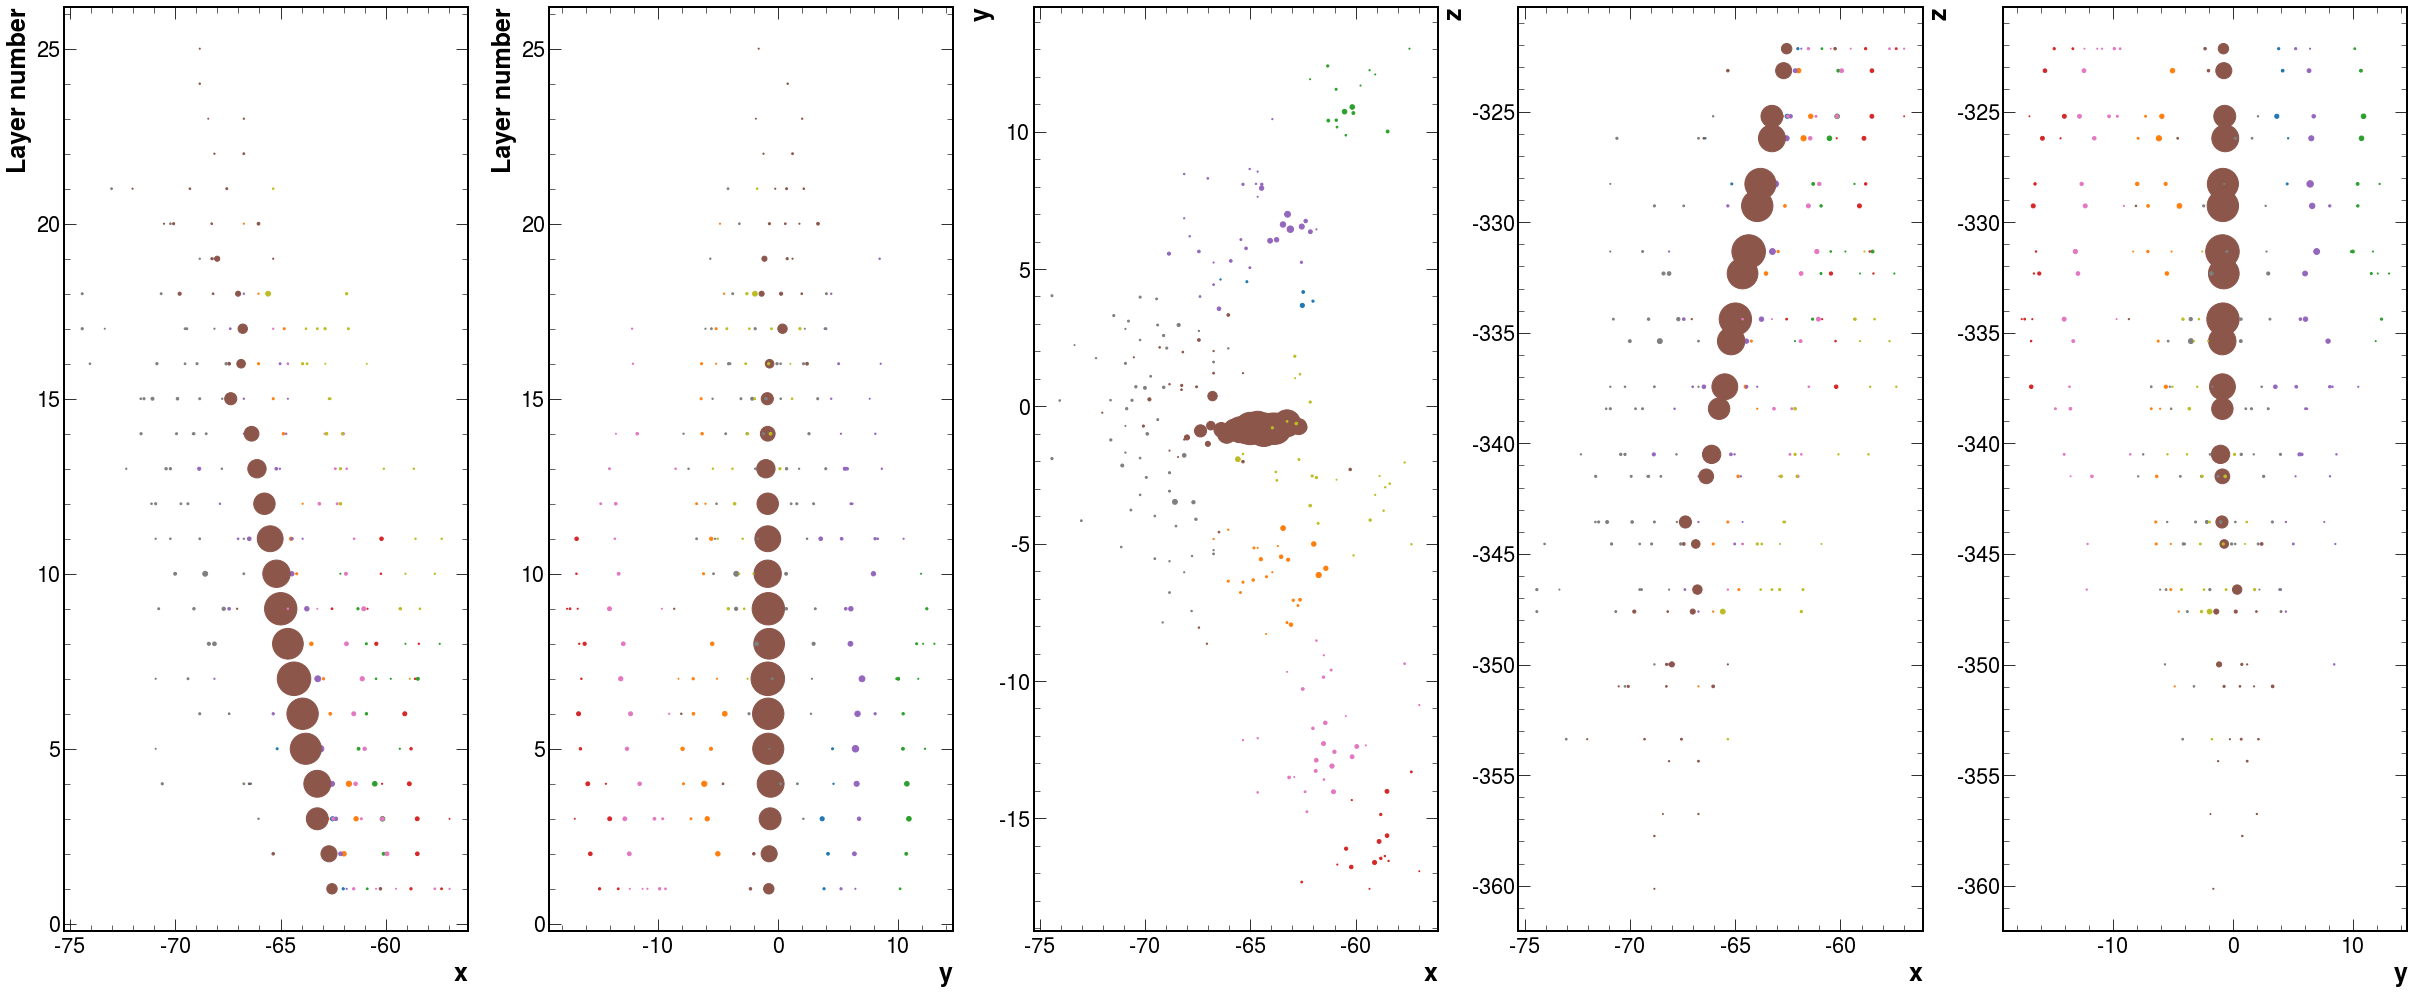

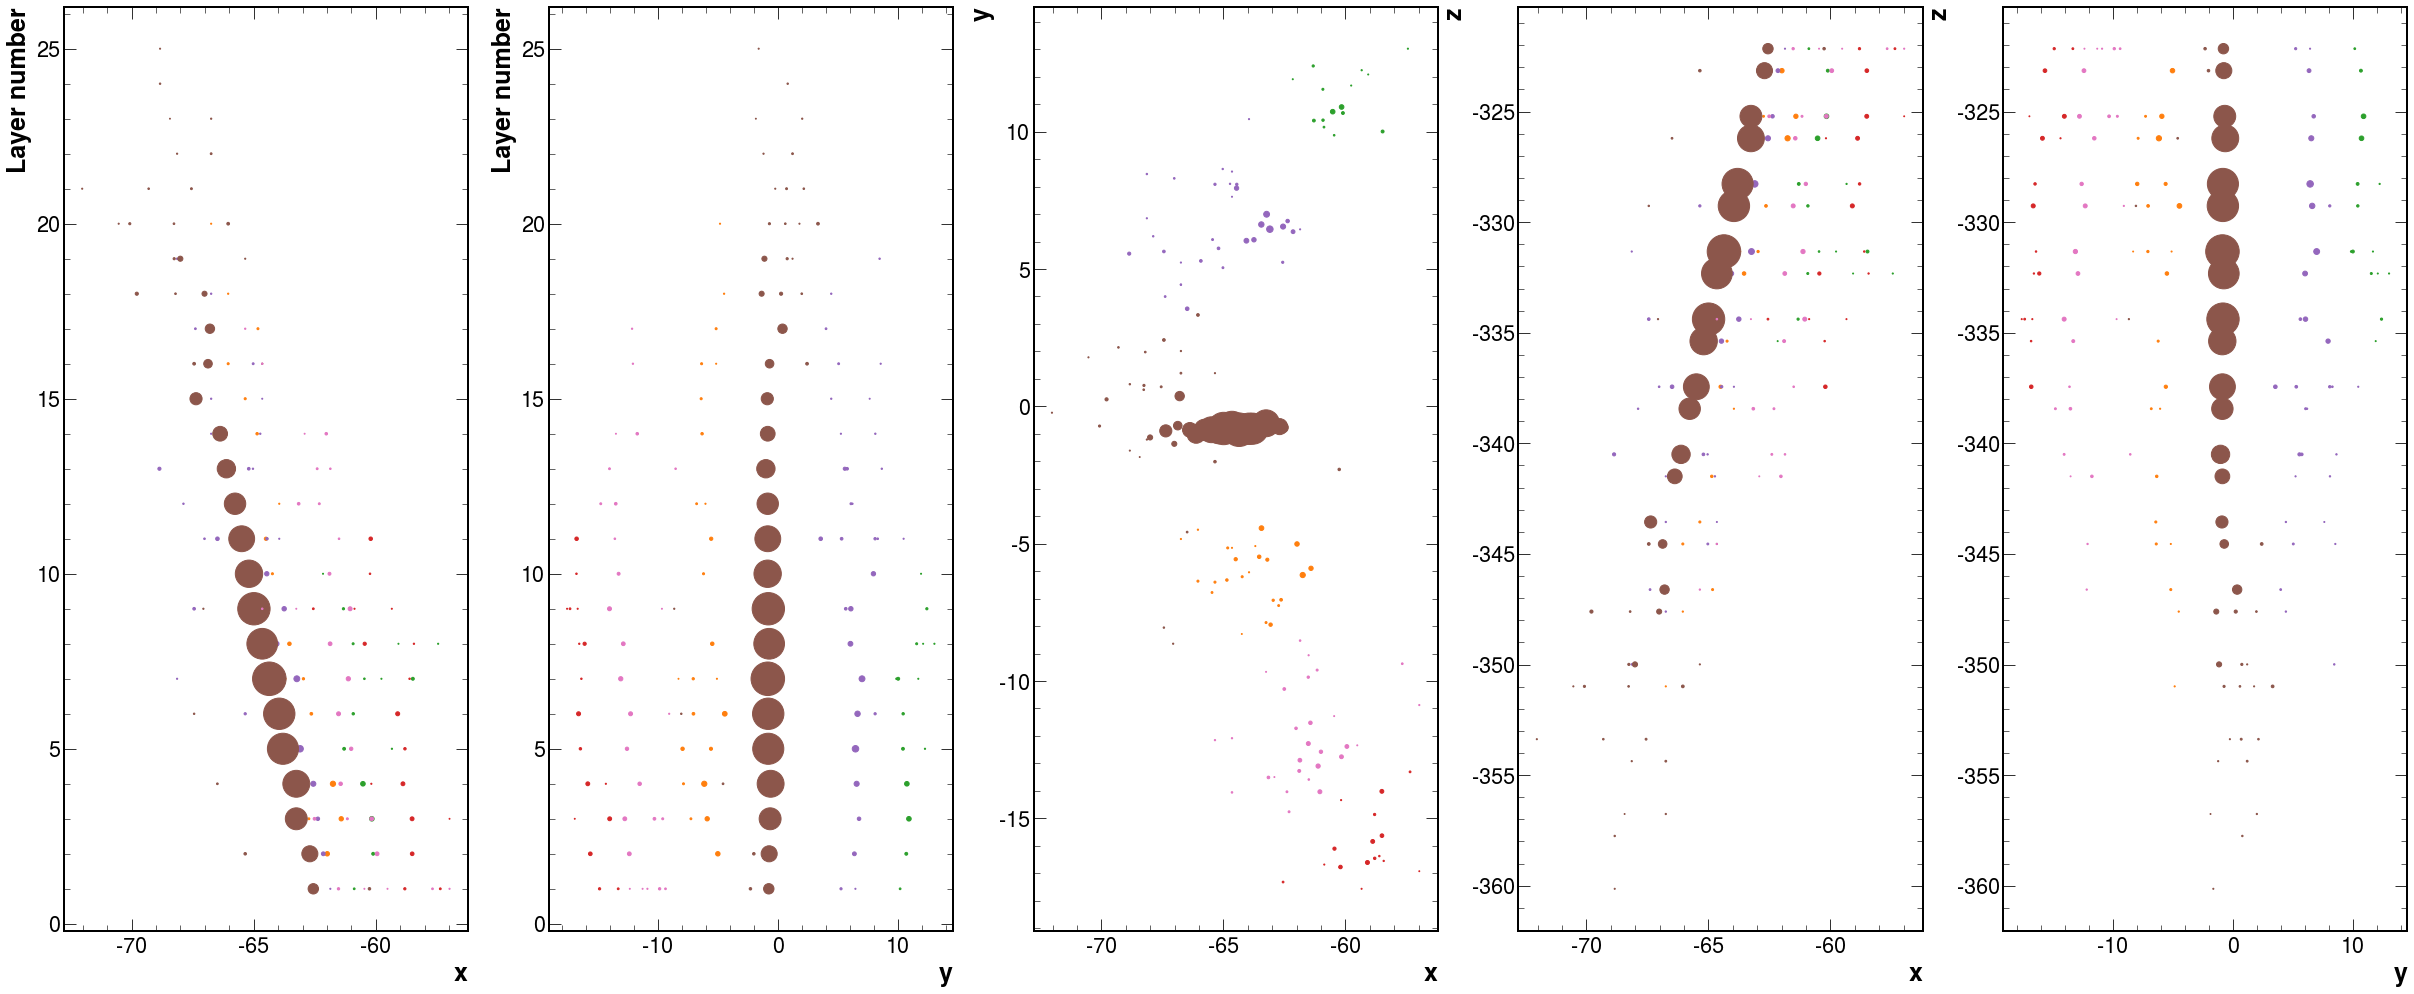

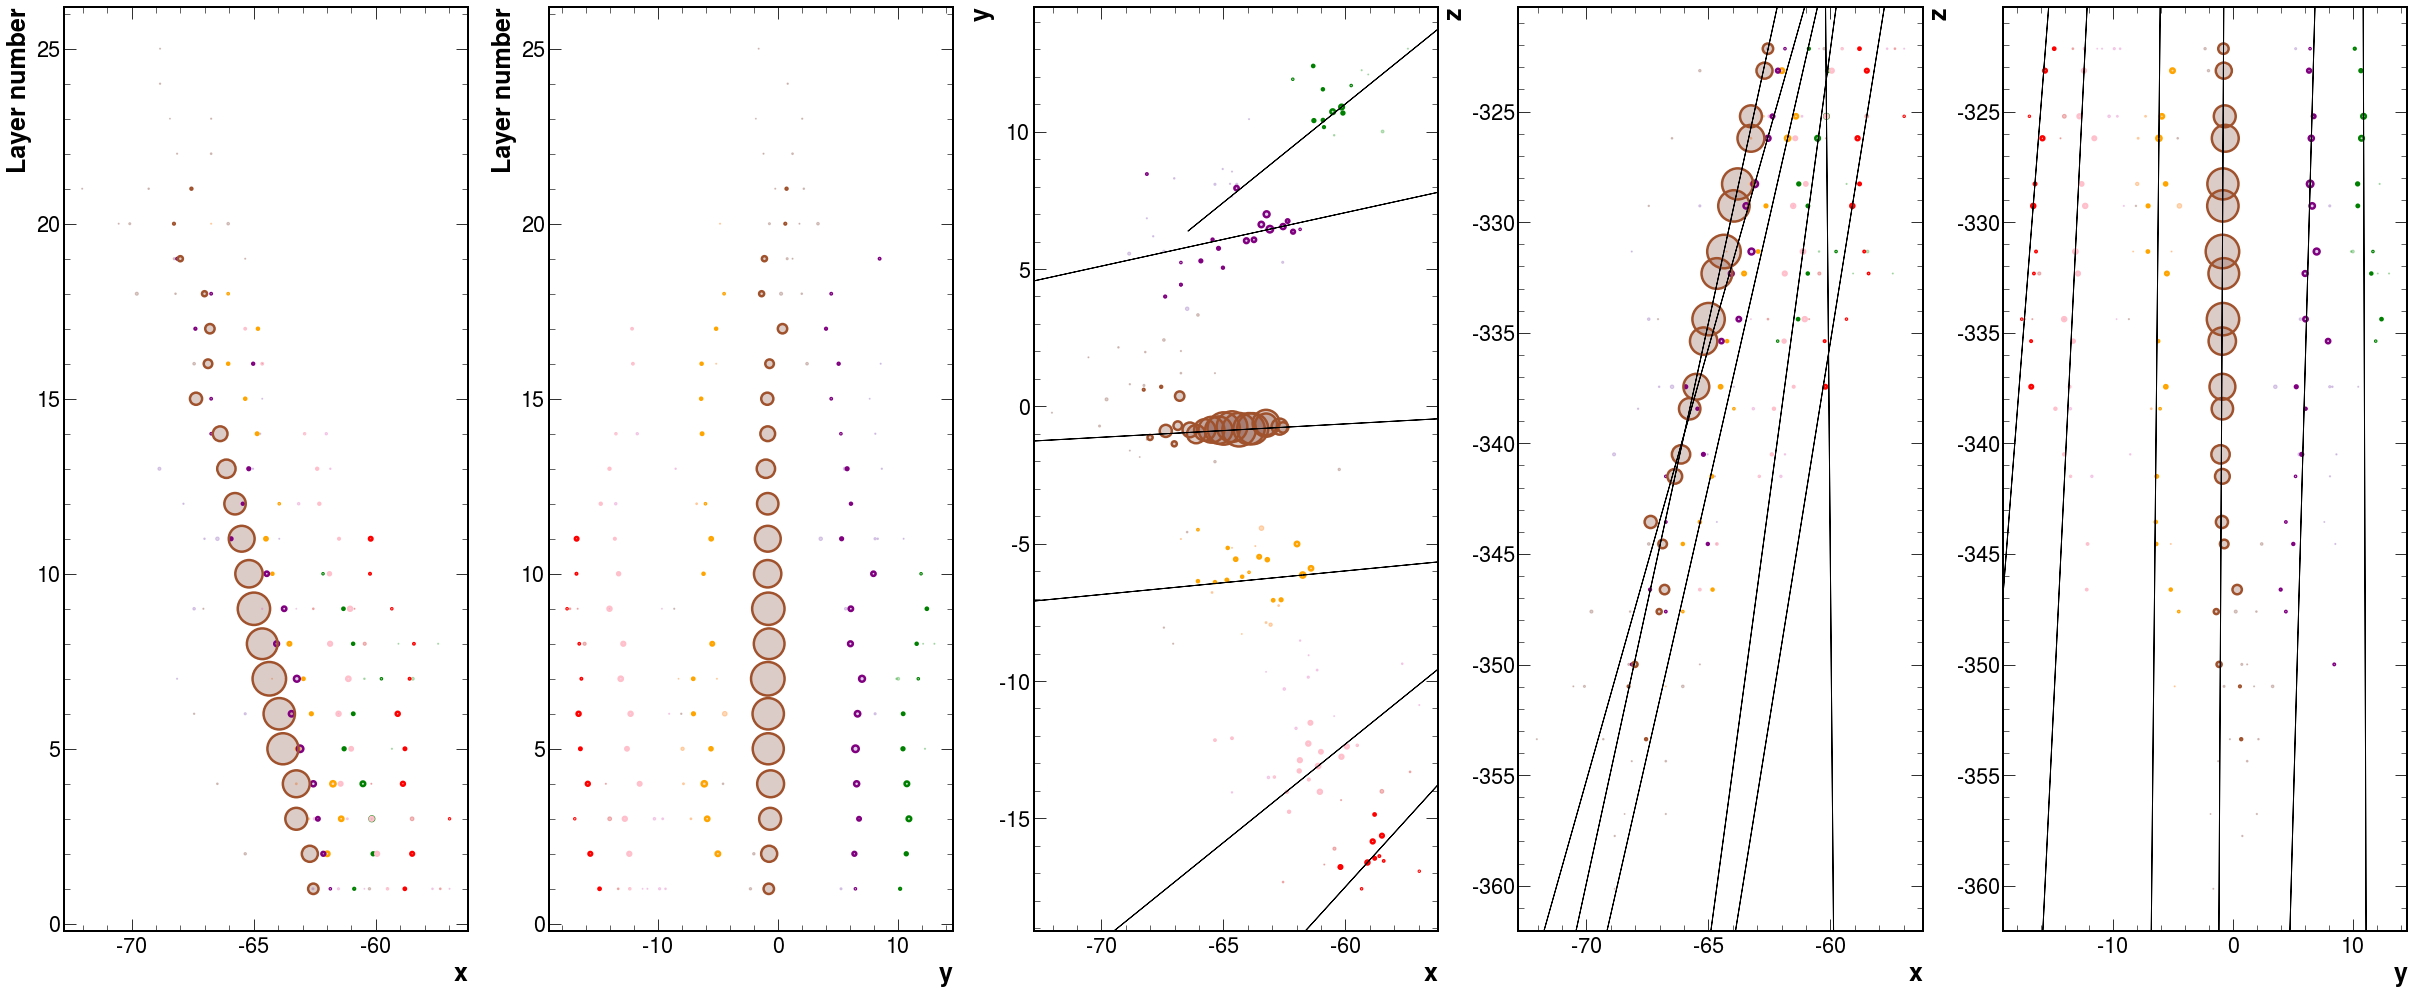

explVarRatio: 0.81     multi_en: 1.16
multi_eta: -2.34     pca_eta: -2.28    
multi_phi: 3.08     pca_phi: -3.06    

explVarRatio: 0.96     multi_en: 6.16
multi_eta: -2.35     pca_eta: -5.33    
multi_phi: -3.05     pca_phi: 0.62    

explVarRatio: 0.93     multi_en: 3.11
multi_eta: -2.38     pca_eta: -2.29    
multi_phi: 2.96     pca_phi: -2.37    

explVarRatio: 0.97     multi_en: 3.68
multi_eta: -2.38     pca_eta: -2.05    
multi_phi: -2.88     pca_phi: -2.95    

explVarRatio: 0.96     multi_en: 10.37
multi_eta: -2.34     pca_eta: -2.32    
multi_phi: 3.04     pca_phi: -3.09    

explVarRatio: 1.0     multi_en: 316.66
multi_eta: -2.34     pca_eta: -2.59    
multi_phi: -3.13     pca_phi: -2.52    



In [474]:
checkEtaPhiDef(findIndex(84, 151,  -1)[1])
# checkEtaPhiDef(4)

#### Explanation of the strange line for sel_skim_gen
What I want to do here is the follwing:
* I have an array ``ele[0].multi_en`` and I know the indeces wrt this array of the genMatched trks ``ele[0].genMatching``
* What I am interested in are the genMatched and skimmed trks ``ele[0].multi_en[ele[0].skim==False]``
* I want to know the indeces of the genMatched trks wrt to the skimmed vector

The solution is to use the function ``np.where(np.isin(ev.multi_en[ev.skim==False], ev.multi_en[ev.genMatching]))[0]``

In [240]:
ev.pca[np.array(ev.genMatching, dtype=int)]

array([[-0.013175525458270906, -0.3038940508033522, -0.9526147234927811]],
      dtype=object)

In [13]:
def sublead(vec):
    return np.sort(vec)[-2]
sublead_vec = np.vectorize(sublead)

forPandas            = []
forPandas_inDetaDphi = []
forPandas_noSkim     = []

# CMS reference frame
xcms = np.array([1,0,0])
ycms = np.array([0,1,0])
zcms = np.array([0,0,1])
cms = np.array([xcms, ycms, zcms])

single = 0

for idx,ev in tqdm(enumerate(ele)):
    
    # To remove events that are killed by the skimming 
    # And also events without genMatched tracksters (to be assesed the frequency of such events)
    if len([trk for trk in ev.pca[np.array(ev.genMatching, dtype=int)] if len(trk)>0]) == 0: 
        continue
        
    # Remove events with just one SimTracks
    # We remove these events because we check the subSeed in the following.
    # If you are not interested in this information you can remove those lines when filling the pandas and comment this if below
    # [FIXME] These events have the wrong associated simHits. Something at the ntupliser level is going on, to be checked
    if len(ev.simTrack_pt[ev.simTrack_HGCAL!=0]) == 1: 
        single += 1
        continue
        
    ##### ---------- Skimmed tracksters ---------- #####
#     sel    = (ev.skim==False) #This is the condition I was using when working with noPU only
    sel_skim     = (ev.skim==False)
    sel_skim_gen = np.where(np.isin(ev.multi_en[ev.skim==False], ev.multi_en[np.array(ev.genMatching, dtype=int)]))[0] #We consider trk that are genMatched and skimmed
    
    maxidx  = np.argmax(ev.multi_pt[sel_skim]) #index of maxE trackster
    maxeta  = float(ev.multi_eta[sel_skim][maxidx])
    maxphi  = float(ev.multi_phi[sel_skim][maxidx])
    maxe    = float(ev.multi_en[sel_skim][maxidx])
    maxpt   = float(ev.multi_pt[sel_skim][maxidx])
    pca_eta = np.array([etaphi_from_cart(trk[0],trk[1],trk[2])[0] for trk in ev.pca_signed[sel_skim]])
    pca_phi = np.array([etaphi_from_cart(trk[0],trk[1],trk[2])[1] for trk in ev.pca_signed[sel_skim]])
    pca_pt  = np.array([en/np.cosh(pca_eta[idx]) for idx,en in enumerate(ev.multi_en[sel_skim])])
    maxeta_pca  = float(pca_eta[maxidx])
    maxphi_pca  = float(pca_phi[maxidx])
    
    #Change of reference frame
    zs = np.array(ev.pca_signed[sel_skim][maxidx]).astype(float)
    xs = np.cross(zs, zcms) / np.linalg.norm( np.cross(zs, zcms) )
    ys = np.cross(xs, zs) / np.linalg.norm( np.cross(xs, zs) )
    seed = np.array([xs,ys,zs])

    xc = np.array(ev.pca_origin)[sel_skim][maxidx][0]
    yc = np.array(ev.pca_origin)[sel_skim][maxidx][1]
    zc = np.array(ev.pca_origin)[sel_skim][maxidx][3]
    T = np.array([xc,yc,zc])
    
    seedPID = ev.simClusters_pid[np.argmax(ev.simClustersLinking_perc[np.argmax(ev.multi_pt)])]
    
    rotation = np.dot(cms.T, seed)
#     rotation = np.dot(seed-T, cms.T)

    #Check trk in the Eta-Phi window 
#     inDetaDphi = np.array([j if abs(abs(ev.multi_eta[ev.skim==False][j]) - abs(maxeta)) < 0.02 and abs(ev.multi_phi[sel_skim][j] - maxphi) for j in range(nTracksters)])

    seedSimTrack = np.argmax(ev.simTrack_pt[ev.simTrack_HGCAL!=0])
    subSeedSimTrack = np.argsort(ev.simTrack_pt[ev.simTrack_HGCAL!=0])[-2]

    #Fill pandas
    nTracksters = len(ev.multi_eta[sel_skim])
    forPandas.append([idx,
                      np.array([float(abs(ev.multi_eta[sel_skim][j]) - abs(maxeta)) for j in range(nTracksters)]),                          # DeltaEta (barycenter)
                      np.array([float(ev.multi_phi[sel_skim][j] - maxphi) for j in range(nTracksters)]),                                    # DeltaPhi (barycenter)
                      maxeta, maxphi, maxe, maxpt, maxidx,                                                                                  # kinematics of the seed (barycenter)
                      int(ev.simTrack_PID[ev.simTrack_HGCAL!=0][seedSimTrack]),
                      float(ev.simTrack_energy[ev.simTrack_HGCAL!=0][seedSimTrack]),
                      float(ev.simTrack_energy[ev.simTrack_HGCAL!=0][subSeedSimTrack]) / float(ev.simTrack_energy[ev.simTrack_HGCAL!=0][seedSimTrack]),
                      float(sum(ev.simTrack_energy[ev.simTrack_HGCAL!=0])),
                      float(ev.simTrack_pt[ev.simTrack_HGCAL!=0][seedSimTrack]),
                      float(ev.simTrack_eta[ev.simTrack_HGCAL!=0][seedSimTrack]),
                      float(ev.simTrack_phi[ev.simTrack_HGCAL!=0][seedSimTrack]),
                      float(sum(ev.simTrack_pt[ev.simTrack_HGCAL!=0])),
                      float(ev.gunEn),                                                                                                       # Energy gun
                      float(ev.gunPt),                                                                                                       # pT gun
                      float(ev.gunPID),                                                                                                      # PID gun
                      ev.simClusters_pid[np.argmax(ev.simClustersLinking_perc[np.argmax(ev.multi_pt)])],                                     # seedPID
                      np.array(ev.simTrack_energy[ev.simTrack_HGCAL!=0]),                                                                    # Energy of SimTracks
                      np.array(ev.simTrack_pt[ev.simTrack_HGCAL!=0]),                                                                        # pT of SimTracks
                      np.array(ev.simTrack_eta[ev.simTrack_HGCAL!=0]),                                                                       # eta of SimTracks
                      np.array(ev.simTrack_phi[ev.simTrack_HGCAL!=0]),                                                                       # phi of SimTracks
                      np.array(ev.multi_en[sel_skim]),                                                                                       # Energy of trks
                      np.array(ev.multi_pt[sel_skim]),                                                                                       # pT of trks
                      np.array(ev.multi_eta[sel_skim]),                                                                                      # eta of trks
                      np.array(ev.multi_phi[sel_skim]),                                                                                      # phi of trks
                      np.array(ev.LCl[sel_skim]),                                                                                            # Layers of the LCs
                      np.array(np.array(ev.LCen)[sel_skim]),                                                                                 # Layers of the LCs
                      [float(abs(pca_eta[j]) - abs(maxeta_pca)) for j in range(nTracksters)],                                                # DeltaEta (pca)
                      [float(pca_phi[j] - maxphi_pca) for j in range(nTracksters)],                                                          # DeltaPhi (pca)
                      [computeAngle(ev.pca_signed[sel_skim][j], ev.pca_signed[sel_skim][maxidx]) for j in range(nTracksters)],               # Angle between trks and the seed
                      [pca for pca in ev.pca_signed[sel_skim]],                                                                              # Shower axis in the CMS frame
#                       [np.matmul(rotation,pca)+T for pca in ev.pca_signed[sel_skim]],                                                      # Shower axis in the new frame
                      [np.matmul(rotation,pca) if idx != maxidx else np.array([0,0,1]) for idx, pca in enumerate(ev.pca_signed[sel_skim])],  # Shower axis in the new frame
                      sel_skim_gen])                                                                                                         # genMatching indeces
        
    ##### ---------- All tracksters ---------- #####
    maxidx = np.argmax(ev.multi_pt) #index of maxE trackster
    maxeta = float(ev.multi_eta[maxidx])
    maxphi = float(ev.multi_phi[maxidx])
    maxe = float(ev.multi_en[maxidx])
    maxpt = float(ev.multi_pt[maxidx])
                
    nTracksters = len(ev.multi_eta)
    forPandas_noSkim.append([#ev.number, 
                            [float(abs(ev.multi_eta[j]) - abs(maxeta)) for j in range(nTracksters)], 
                            [float(ev.multi_phi[j] - maxphi) for j in range(nTracksters)], 
                            maxeta, maxphi, maxe, maxpt,
                            float(ev.gunEn),
                            float(math.log10(maxe)),
                            np.array(ev.LCl),                                                                                            
                            np.array(np.array(ev.LCen)),
                            np.array(ev.multi_eta),                                                                          
                            np.array(ev.multi_en)])
    

##### ---------- Skimmed tracksters ---------- #####
deltas = pd.DataFrame(forPandas, 
                      columns=['idx','DeltaEta', 'DeltaPhi', 'EtaSeed', 'PhiSeed', 'EnSeed', 'PtSeed', 'idxSeed', 'pid_maxPtsimTrack', 'en_maxPtsimTrack', 'ratioEn_subSeed_Seed','sumEn_simTrack', 
                               'pt_maxPtsimTrack', 'eta_maxPtsimTrack', 'phi_maxPtsimTrack', 'sumPt_simTrack', 'gunEn', 'gunPt', 'gunPID', 'seedPID', 'simTrackEn', 'simTrackPt', 'simTrackEta', 'simTrackPhi', 'trksEn', 'trksPt', 'trksEta', 'trksPhi', 'LClayers', 
                               'LCens', 'DeltaEtaPCA', 'DeltaPhiPCA', 'theta', 'pca_cmsFrame', 'pca_seedFrame', 'sel_skim_gen'])
# deltas['indexSeed'] = [list(evt).index(0.0) for evt in deltas['DeltaEta']]
deltas['en_subMaxPtsimTrack'] = sublead_vec(deltas['simTrackEn'])
deltas['trksLog10E']    = [np.log10(ens) for ens in deltas['trksEn']]
deltas['trksLog10Et']   = [np.log10(ens) for ens in deltas['trksPt']]
deltas['PhiPCA_seedFrame'] = [[etaphi_from_cart(trk[0],trk[1],trk[2])[1] for trk in ev ] for ev in deltas['pca_seedFrame']]
deltas['EtaPCA_seedFrame'] = [[etaphi_from_cart(trk[0],trk[1],trk[2])[0] for trk in ev ] for ev in deltas['pca_seedFrame']]
deltas['theta_yz_seedFrame'] = [[computeAngle(trk[1:], [0,1]) for trk in ev ] for ev in deltas['pca_seedFrame']]
deltas['theta_xz_seedFrame'] = [[computeAngle(trk[0::2], [0,1]) for trk in ev ] for ev in deltas['pca_seedFrame']]
deltas['theta_yz_cmsFrame'] = [[computeAngle(trk[1:], ev[idxSeed][1:]) for trk in ev ] for ev,idxSeed in zip(deltas['pca_cmsFrame'],deltas['idxSeed'])]
deltas['theta_xz_cmsFrame'] = [[computeAngle(trk[0::2], ev[idxSeed][0::2]) for trk in ev ] for ev,idxSeed in zip(deltas['pca_cmsFrame'],deltas['idxSeed'])]
deltas['theta_xy_cmsFrame'] = [[computeAngle(trk[:2], ev[idxSeed][:2]) for trk in ev ] for ev,idxSeed in zip(deltas['pca_cmsFrame'],deltas['idxSeed'])]



##### ---------- All tracksters ---------- #####
deltas_noSkim = pd.DataFrame(forPandas_noSkim, 
                      columns=['DeltaEta', 'DeltaPhi', 'EtaSeed', 'PhiSeed', 'EnSeed', 'PtSeed', 'gunEn', 'log10E', 'LClayers', 'LCens', 'trksEta', 'trksEn'])
deltas_noSkim['trksLog10E']    = [np.log10(ens) for ens in deltas_noSkim['trksEn']]
deltas_noSkim['indexSeed'] = [list(evt).index(0.0) for evt in deltas_noSkim['DeltaEta']]
    


0it [00:00, ?it/s]/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

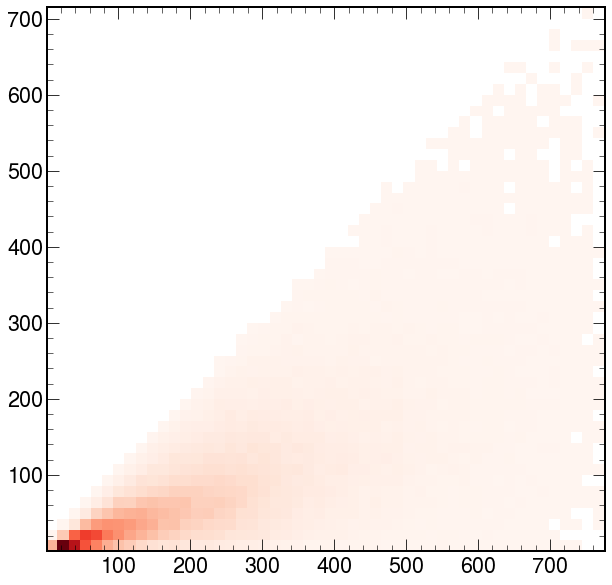

In [354]:
cmap_reds = copy.copy(plt.cm.get_cmap("Reds"))
cmap_reds.set_under('white')

# plt.hist2d(deltas['en_maxPtsimTrack'] / deltas['sumEn_simTrack'], deltas['en_subMaxPtsimTrack'] / deltas['en_maxPtsimTrack'], cmap=cmap_reds, vmin=0.0001)
plt.hist2d(deltas['en_maxPtsimTrack'], deltas['en_subMaxPtsimTrack'], cmap=cmap_reds, vmin=0.0001, bins=50)
plt.show()

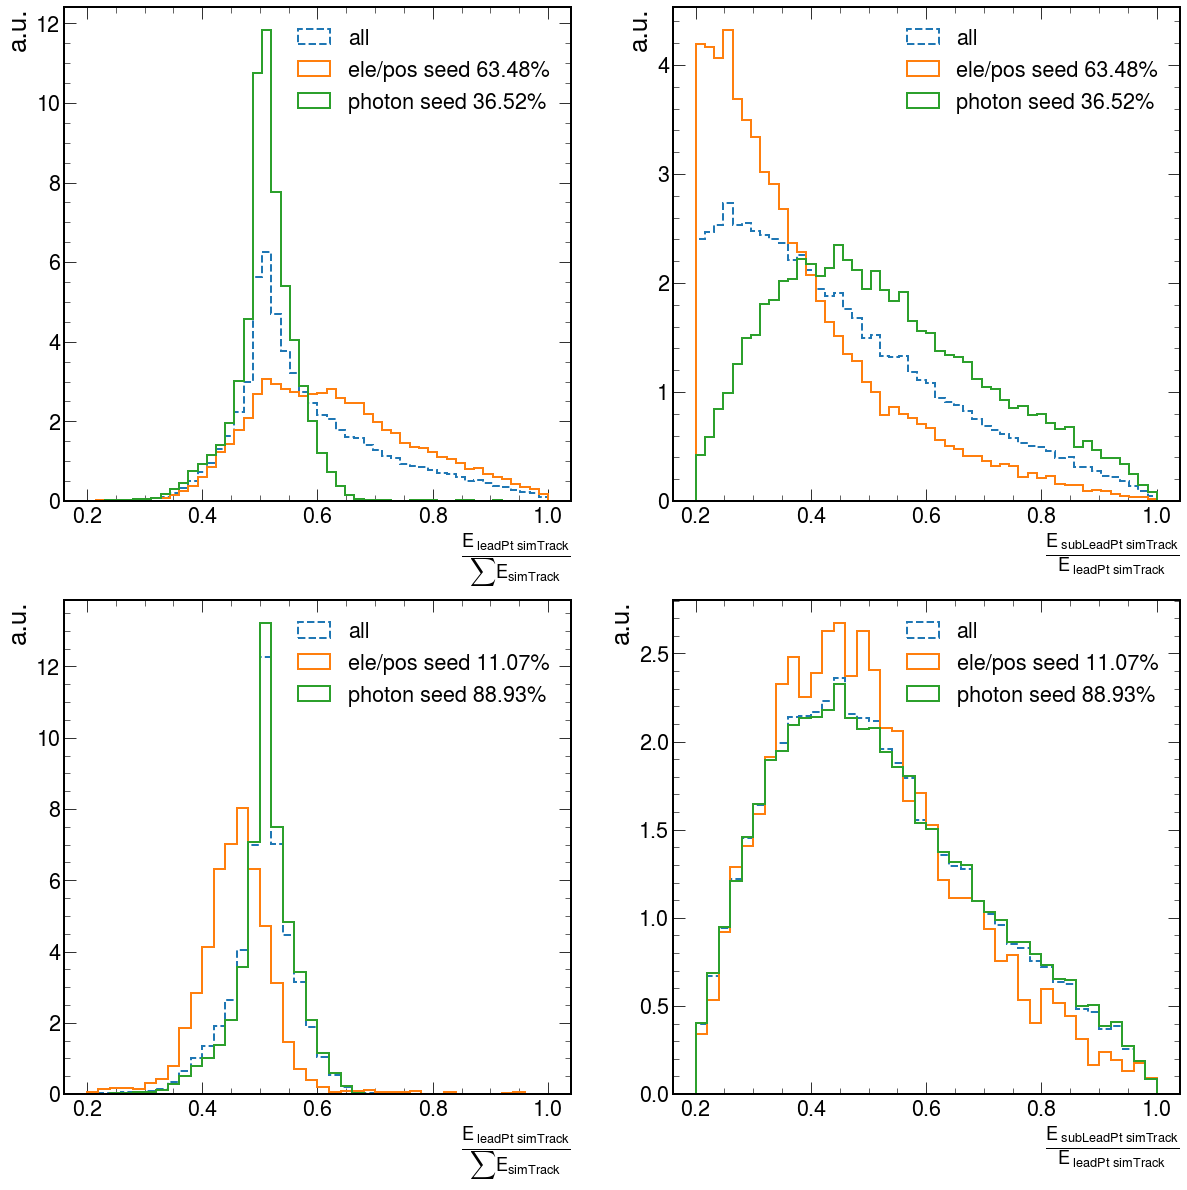

In [481]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))
axs = axs.ravel()

# lead/sum
ratio = deltas['en_maxPtsimTrack'] / deltas['sumEn_simTrack']
axs[0].hist(ratio, bins=50, range= [0.2,1], histtype = 'step', density=True, lw=2, label = 'all', ls='--')
frac = len(ratio[abs(deltas['seedPID'])==11]) / len(ratio) * 100
axs[0].hist(ratio[abs(deltas['seedPID'])==11], bins=50, range= [0.2,1], histtype = 'step', density=True, lw=2, label='ele/pos seed '+str(round(frac,2))+'%')
frac = len(ratio[abs(deltas['seedPID'])==22]) / len(ratio) * 100
axs[0].hist(ratio[abs(deltas['seedPID'])==22], bins=50, range= [0.2,1], histtype = 'step', density=True, lw=2, label='photon seed '+str(round(frac,2))+'%')
axs[0].set_xlabel(r'$\frac{E_{\rm~leadPt~simTrack}}{\sum E_{\rm simTrack}}$')
axs[0].set_ylabel('a.u.')
axs[0].legend()

# sublead/lead
ratio = deltas['en_subMaxPtsimTrack'] / deltas['en_maxPtsimTrack']
axs[1].hist(ratio, bins=50, range= [0.2,1], histtype = 'step', density=True, lw=2, label = 'all', ls='--')
frac = len(ratio[abs(deltas['seedPID'])==11]) / len(ratio) * 100
axs[1].hist(ratio[abs(deltas['seedPID'])==11], bins=50, range= [0.2,1], histtype = 'step', density=True, lw=2, label='ele/pos seed '+str(round(frac,2))+'%')
frac = len(ratio[abs(deltas['seedPID'])==22]) / len(ratio) * 100
axs[1].hist(ratio[abs(deltas['seedPID'])==22], bins=50, range= [0.2,1], histtype = 'step', density=True, lw=2, label='photon seed '+str(round(frac,2))+'%')
axs[1].set_xlabel(r'$\frac{E_{\rm~subLeadPt~simTrack}}{E_{\rm~leadPt~simTrack}}$')
axs[1].set_ylabel('a.u.')
axs[1].legend()

# lead/sum
ratio = deltas['en_maxPtsimTrack'] / deltas['sumEn_simTrack']
sel = deltas['seedPID']!=deltas['pid_maxPtsimTrack'] #Seeds PID do not agree
axs[2].hist(ratio[sel], bins=40, range= [0.2,1], histtype = 'step', density=True, lw=2, label = 'all', ls='--')
frac = len(ratio[(abs(deltas['seedPID'])==11) & sel]) / len(ratio[sel]) * 100
axs[2].hist(ratio[(abs(deltas['seedPID'])==11) & sel], bins=40, range= [0.2,1], histtype = 'step', density=True, lw=2, label='ele/pos seed '+str(round(frac,2))+'%')
frac = len(ratio[(abs(deltas['seedPID'])==22) & sel]) / len(ratio[sel]) * 100
axs[2].hist(ratio[(abs(deltas['seedPID'])==22) & sel], bins=40, range= [0.2,1], histtype = 'step', density=True, lw=2, label='photon seed '+str(round(frac,2))+'%')
axs[2].set_xlabel(r'$\frac{E_{\rm~leadPt~simTrack}}{\sum E_{\rm simTrack}}$')
axs[2].set_ylabel('a.u.')
axs[2].legend()

# sublead/lead
ratio = deltas['en_subMaxPtsimTrack'] / deltas['en_maxPtsimTrack']
axs[3].hist(ratio[sel], bins=40, range= [0.2,1], histtype = 'step', density=True, lw=2, label = 'all', ls='--')
frac = len(ratio[(abs(deltas['seedPID'])==11) & sel]) / len(ratio[sel]) * 100
axs[3].hist(ratio[(abs(deltas['seedPID'])==11) & sel], bins=40, range= [0.2,1], histtype = 'step', density=True, lw=2, label='ele/pos seed '+str(round(frac,2))+'%')
frac = len(ratio[(abs(deltas['seedPID'])==22) & sel]) / len(ratio[sel]) * 100
axs[3].hist(ratio[(abs(deltas['seedPID'])==22) & sel], bins=40, range= [0.2,1], histtype = 'step', density=True, lw=2, label='photon seed '+str(round(frac,2))+'%')
axs[3].set_xlabel(r'$\frac{E_{\rm~subLeadPt~simTrack}}{E_{\rm~leadPt~simTrack}}$')
axs[3].set_ylabel('a.u.')
axs[3].legend()


plt.show()

In [220]:
np.unique(deltas['pid_maxPtsimTrack'], return_counts=True)

(array([-11,  11,  22]), array([37935, 37721,   525]))

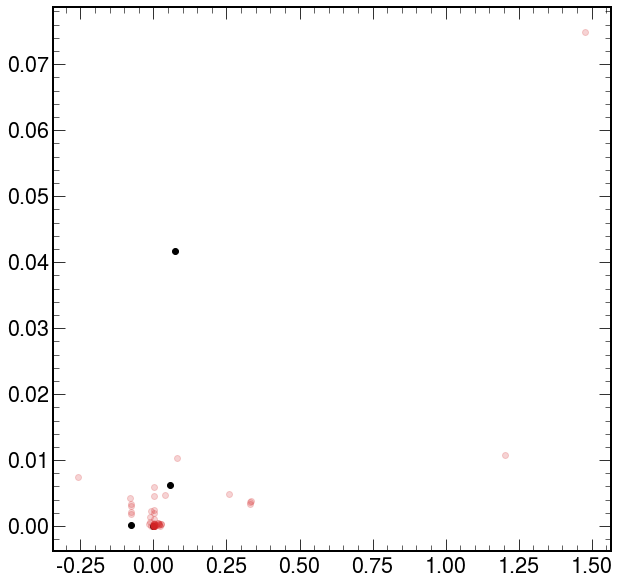

In [242]:
evt = 7884
plt.scatter(deltas['trksPhi'][evt]-deltas['PhiSeed'][evt], abs(abs(deltas['trksEta'][evt])-abs(deltas['EtaSeed'][evt])), color='black')
plt.scatter(deltas['simTrackPhi'][evt]-deltas['phi_maxPtsimTrack'][evt], abs(abs(deltas['simTrackEta'][evt])-abs(deltas['eta_maxPtsimTrack'][evt])), color='tab:red', alpha=0.2)
plt.show()

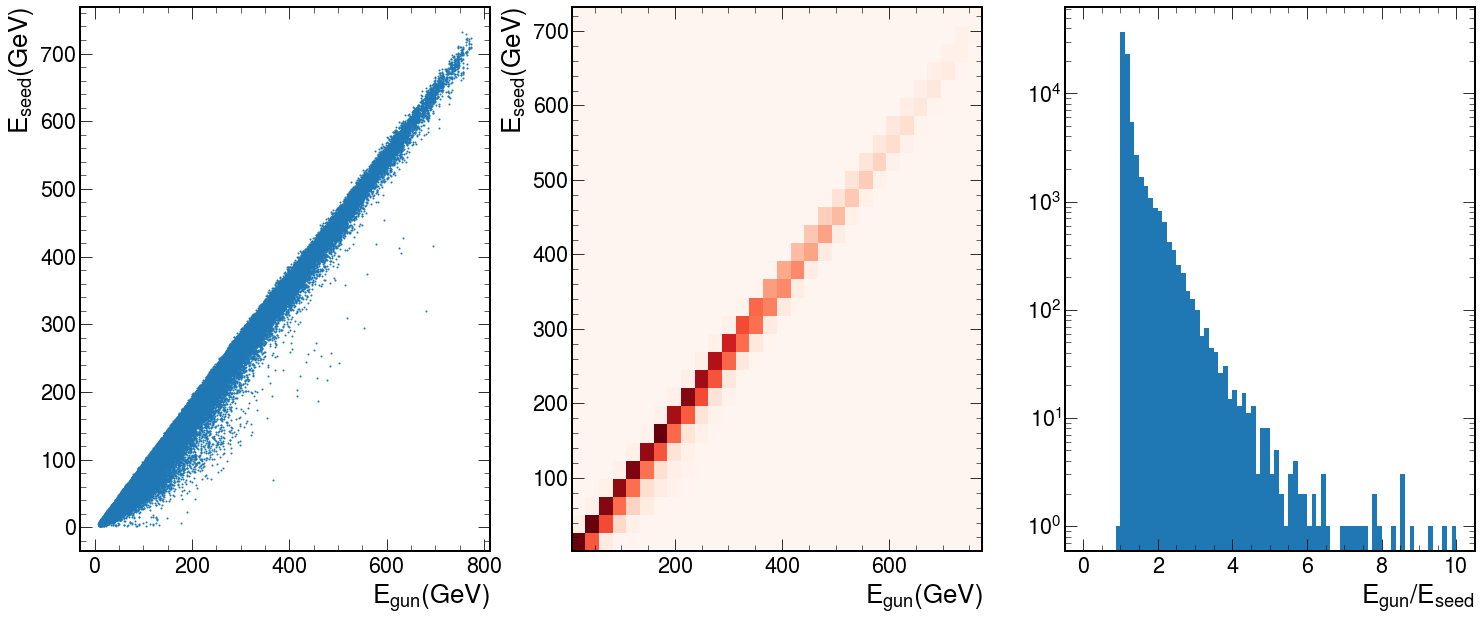

Fraction in % of events with EnSeed > gunEn:  0.0012987012987012987


In [460]:
fig, axs = plt.subplots(1, 3, figsize=(25,10))
axs.ravel()
axs[0].scatter(deltas.gunEn, deltas.EnSeed, s=1)
axs[0].set_xlabel('$E_{gun}(GeV)$')
axs[0].set_ylabel('$E_{seed}(GeV)$')
axs[1].hist2d(deltas.gunEn, deltas.EnSeed, bins=30, cmap=plt.cm.Reds)
axs[1].set_xlabel('$E_{gun}(GeV)$')
axs[1].set_ylabel('$E_{seed}(GeV)$')
axs[2].hist(deltas.gunEn/deltas.EnSeed, bins=80, range=[0,10])
axs[2].set_xlabel('$E_{gun}/E_{seed}$')
axs[2].set_yscale('log')
plt.show()
print('Fraction in % of events with EnSeed > gunEn: ', len(deltas[deltas.gunEn<deltas.EnSeed])/len(deltas)*100)

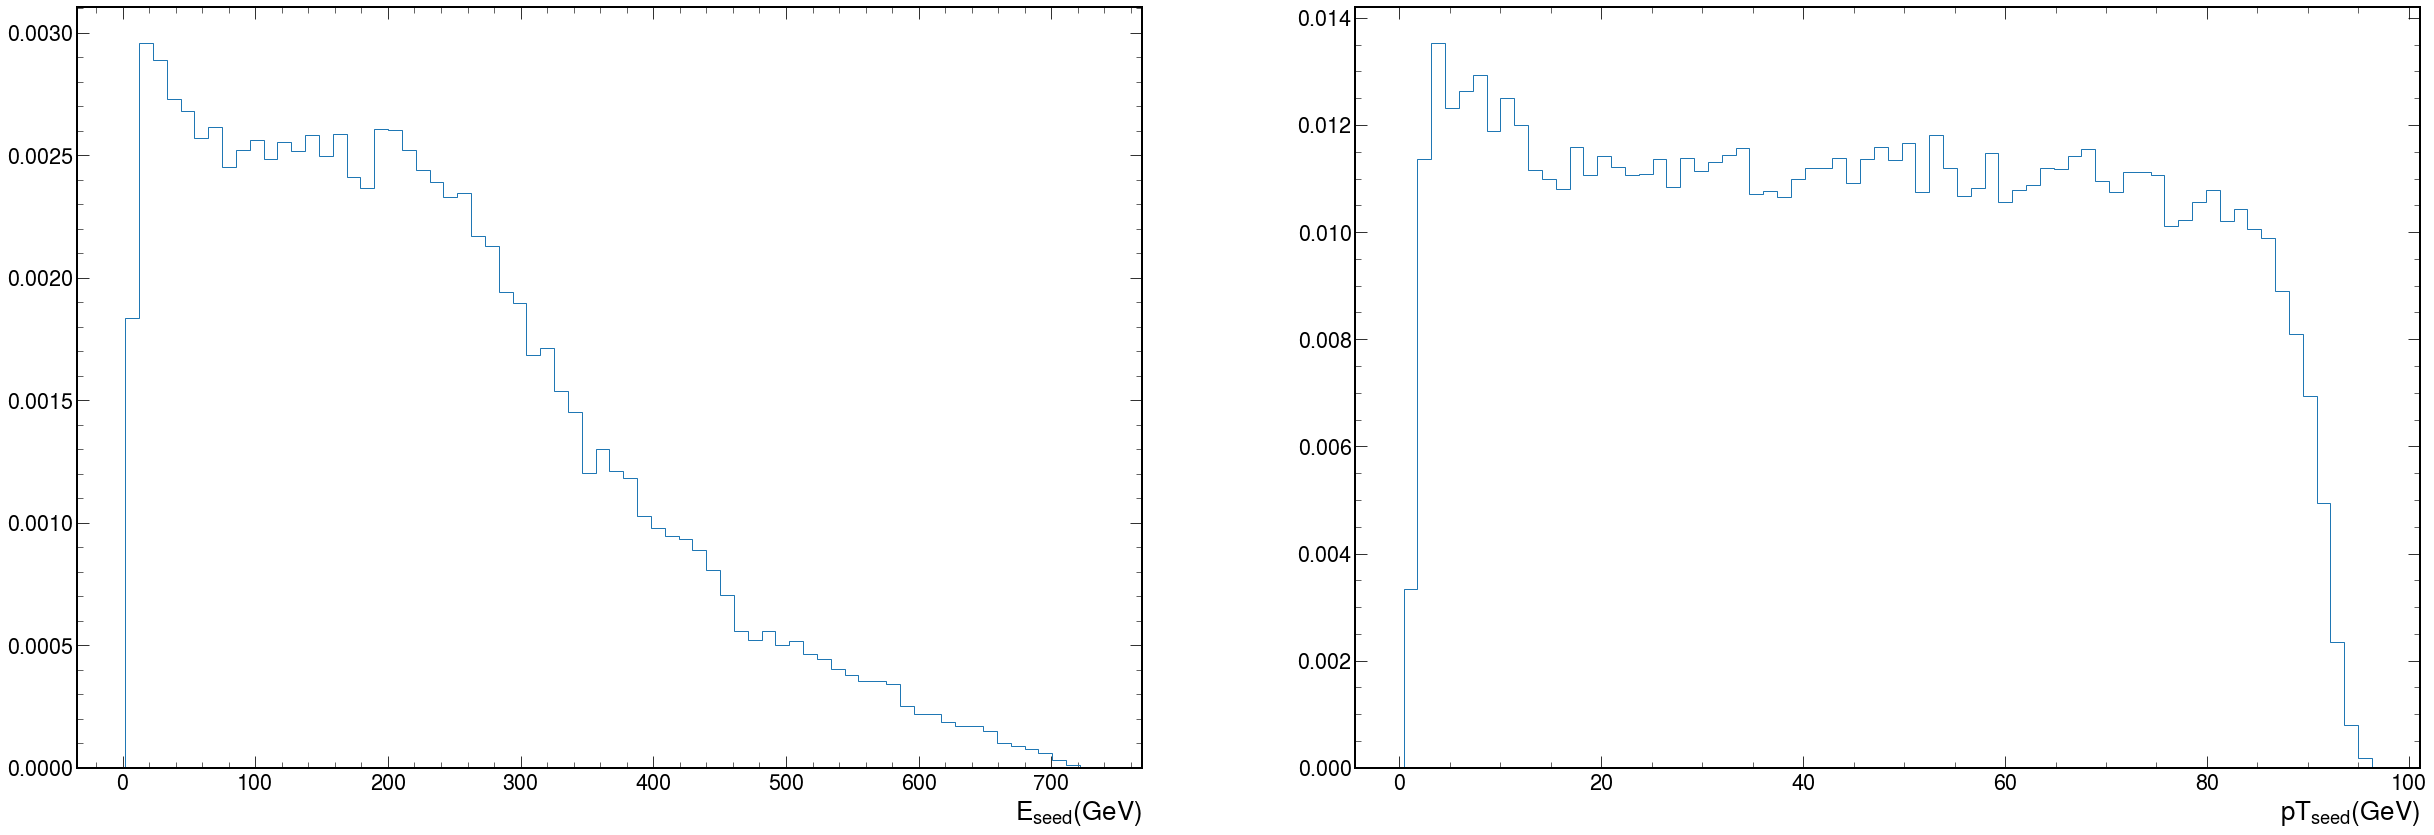

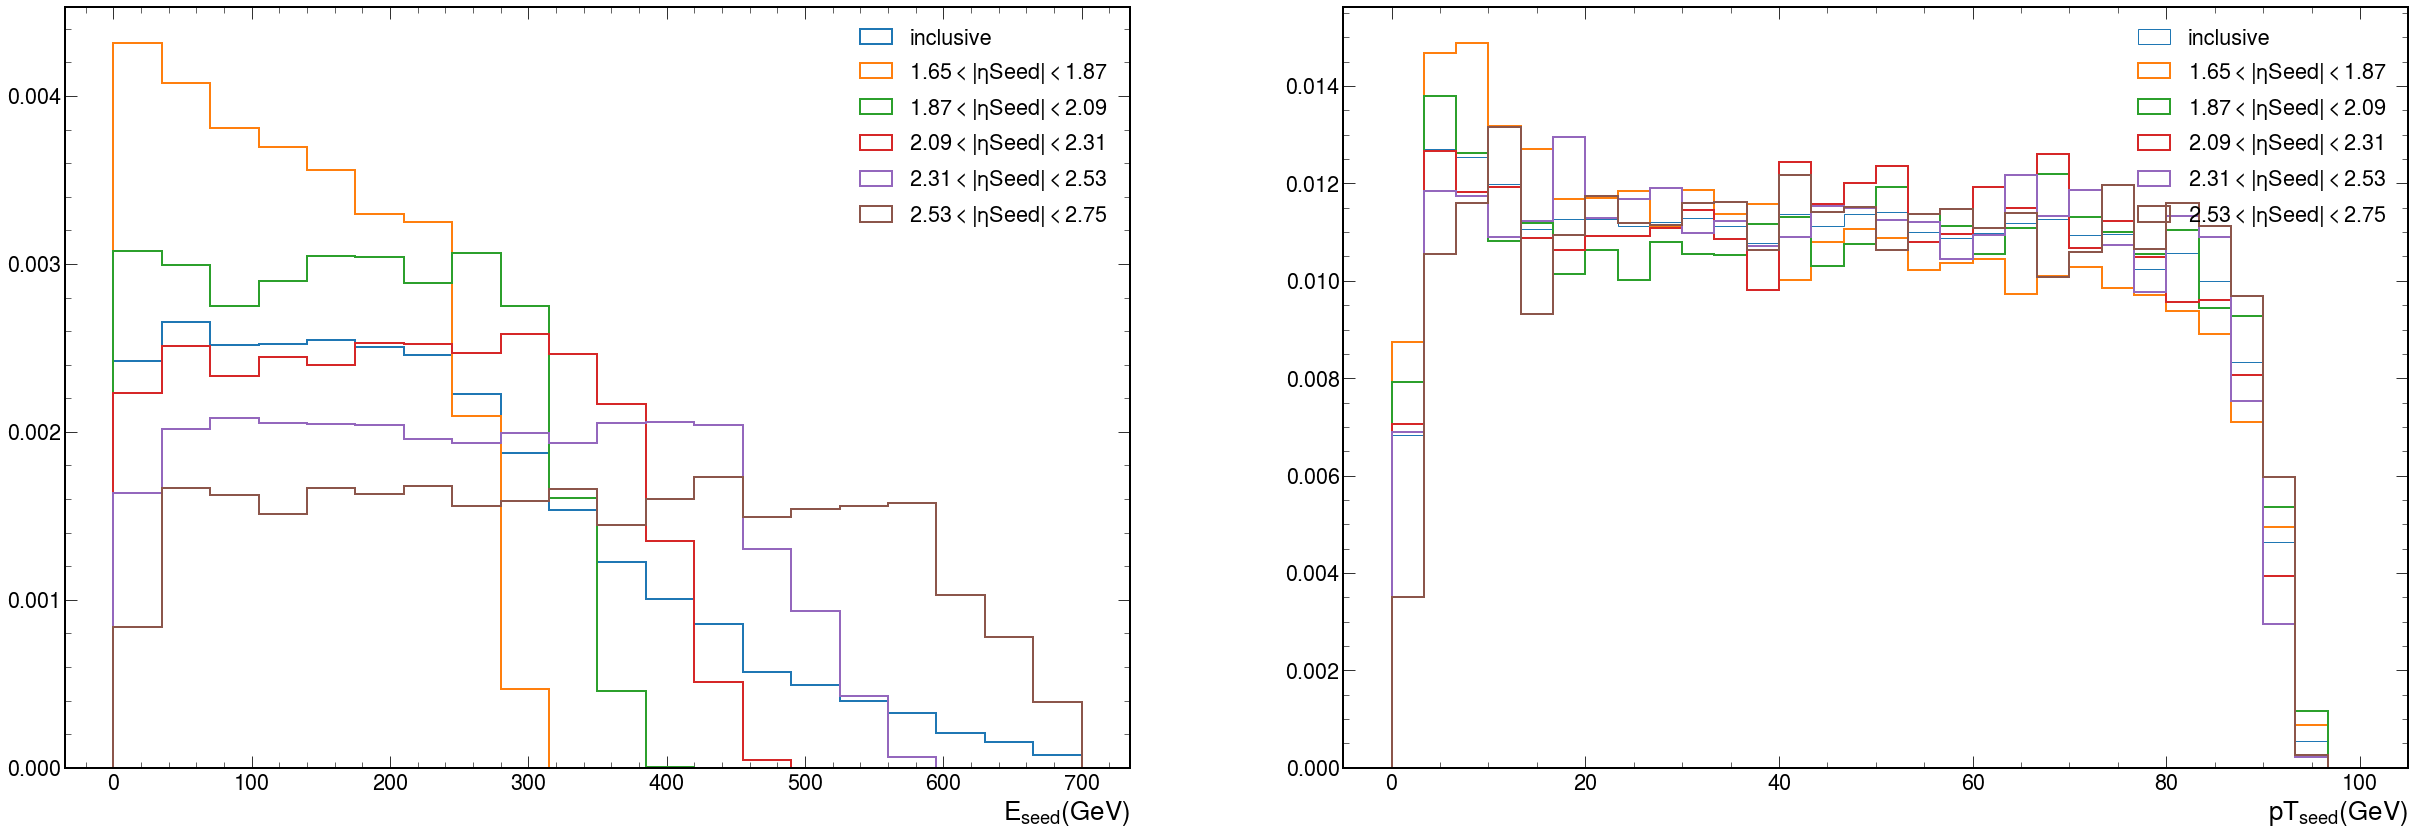

In [459]:
fig, axs = plt.subplots(1, 2, figsize=(42,14))
axs.ravel()

axs[0].hist(deltas.EnSeed, bins=70, histtype = 'step', density=True)
axs[0].set_xlabel('$E_{seed}(GeV)$')
axs[1].hist(deltas.PtSeed, bins=70, histtype = 'step', density=True)
axs[1].set_xlabel('$pT_{seed}(GeV)$')

plt.show()

################ ------------------------------------------------------- ################

fig, axs = plt.subplots(1, 2, figsize=(42,14))
axs.ravel()

bins = histedges_equalN(abs(deltas['EtaSeed']), 5) #There is no difference in shape between EnSeed shape in pos eta and neg eta -> checked

axs[0].hist(deltas.EnSeed, bins=20, range = [0,700], histtype = 'step', density=True, label='inclusive', lw=2)
for i in range(len(bins)-1):
    axs[0].hist(deltas[(abs(deltas.EtaSeed)>bins[i]) & (abs(deltas.EtaSeed)<bins[i+1])]['EnSeed'], 
                bins=20, range = [0,700], 
                histtype = 'step', 
                density=True, label = str(round(bins[i],2))+'$<|\eta Seed|<$'+str(round(bins[i+1],2)),
                lw=2)
axs[0].set_xlabel('$E_{seed}(GeV)$')
axs[0].legend()

axs[1].hist(deltas.PtSeed, range = [0,100], bins=30, histtype = 'step', density = True, label='inclusive')
for i in range(len(bins)-1):
    axs[1].hist(deltas[(abs(deltas.EtaSeed)>bins[i]) & (abs(deltas.EtaSeed)<bins[i+1])]['PtSeed'], 
                bins=30, 
                range = [0,100], 
                histtype = 'step', 
                density=True, label = str(round(bins[i],2))+'$<|\eta Seed|<$'+str(round(bins[i+1],2)),
                lw=2)
axs[1].set_xlabel('$pT_{seed}(GeV)$')
axs[1].legend()

plt.show()

In [66]:
def plotDistributions(_df, pu = False):
    
    fig, axs = plt.subplots(3, 4, figsize=(42,25))
    axs = axs.ravel()
    
    observables = {
                   'DeltaPhi':           [[-0.5,0.5],   r'$\Delta\phi = \phi - \phi_{seed}$'],
                   'DeltaEta':           [[-0.10,0.10], r'$\Delta\eta = |\eta| - |\eta_{seed}|$'],
                   'DeltaPhiPCA':        [[-1,1],       r'$\Delta\phi = \phi^{dir} - \phi_{seed}^{dir}$'],
                   'theta':              [[0,1],        r'$\theta(seed, trk)$'],
                   'theta_xz_seedFrame': [[0,1],        r'$\theta_{xz}^{seedFrame}(seed, trk)$'],
                   'theta_yz_seedFrame': [[0,1],        r'$\theta_{yz}^{seedFrame}(seed, trk)$'],
                   'theta_xy_cmsFrame':  [[0,1],        r'$\theta_{xy}^{cmsFrame}(seed, trk)$'],
                   'theta_yz_cmsFrame':  [[0,1],        r'$\theta_{yz}^{cmsFrame}(seed, trk)$'],
                   'theta_xz_cmsFrame':  [[0,1],        r'$\theta_{xz}^{cmsFrame}(seed, trk)$'],
                   'PhiPCA_seedFrame':   [[-1.57,1.57], r'$\phi^{dir}_{seedFrame}$'],
                   'EtaPCA_seedFrame':   [[0,7],        r'$\eta^{dir}_{seedFrame}$'],
                  } 
    
    for idx_obs, obs in enumerate(observables):
        var       = []
        var_gen   = []
        var_nogen = []
        idx_evt  = 0
        for ev in _df[obs]:
            for trk_idx in range(len(ev)):
                if abs(abs(_df['trksEta'][idx_evt][trk_idx]) - abs(_df['EtaSeed'][idx_evt])) > 0.02 or abs(_df['trksPhi'][idx_evt][trk_idx] - _df['PhiSeed'][idx_evt]) > 0.3: continue
                if ev[trk_idx] != 0:
                    var.append(ev[trk_idx])
                    if trk_idx in _df['sel_skim_gen'][idx_evt]:
                        var_gen.append(ev[trk_idx])
                    else:
                        var_nogen.append(ev[trk_idx])
            idx_evt += 1
            
        axs[idx_obs].hist(var, bins=40, range=observables[obs][0], histtype='step', density=True, label = 'All', color='tab:blue')
        if pu:
            axs[idx_obs].hist(var_nogen, bins=40, range=observables[obs][0], histtype='step', density=True, label = 'non-genMatched', color='tab:green')
            axs[idx_obs].hist(var_gen, bins=40, range=observables[obs][0], histtype='step', density=True, label = 'genMatched', color='tab:orange')
            axs[idx_obs].legend()
        axs[idx_obs].set_xlabel(observables[obs][1])
        axs[idx_obs].set_ylabel('a.u.')
        
    plt.show()

def plotdeltas(_df, xvar, yvar, xrange, yrange, xlabel, ylabel, pu = False):
    
    fig, axs = plt.subplots(1, 3, figsize=(42,14))
    axs.ravel()
    
#     deta = [trk for ev in _df['DeltaEta'] for trk in ev if trk!=0]
#     dphi = [trk for ev in _df['DeltaPhi'] for trk in ev if trk!=0]
    
    # This is not the smartest thing to implement it, the one above that is commented it is.
    # We are forced to do so when we include the abs to compute the DeltaEta.
    # By including the absolute value, we introduce round off errors, so the condition !=0 is no longer
    # satisfied in many cases (maybe it becomes 0.000001 - usual annoying error)
    dx       = []
    dy       = []
    dx_gen   = []
    dy_gen   = []
    dx_nogen = []
    dy_nogen = []
    idx_evt  = 0
    for ev_x, ev_y in zip(_df[xvar], _df[yvar]):
        for trk_idx in range(len(ev_x)):
#             if abs(abs(_df['trksEta'][idx_evt][trk_idx]) - abs(_df['EtaSeed'][idx_evt])) > 0.02 or abs(_df['trksPhi'][idx_evt][trk_idx] - _df['PhiSeed'][idx_evt]) > 0.3: continue
            if ev_y[trk_idx] != 0:
                dx.append(ev_x[trk_idx])
                dy.append(ev_y[trk_idx])
#                 idxs_evt.append(idx_evt)
#                 if trk_idx in _df['sel_skim_gen'][idx_evt]:
#                     dx_gen.append(ev_x[trk_idx])
#                     dy_gen.append(ev_y[trk_idx])
#                 else:
#                     dx_nogen.append(ev_x[trk_idx])
#                     dy_nogen.append(ev_y[trk_idx])
        idx_evt += 1
            
    nbins = 40
    axs[0].hist(dx, bins=nbins, range=xrange, histtype='step', density=True, label = 'All', color='tab:blue')
    if pu:
        axs[0].hist(dx_nogen, bins=nbins, range=xrange, histtype='step', density=True, label = 'non-genMatched', color='tab:green')
        axs[0].hist(dx_gen, bins=nbins, range=xrange, histtype='step', density=True, label = 'genMatched', color='tab:orange')
        axs[0].legend()
    axs[0].set_xlabel(xlabel)
    
    axs[1].hist(dy, bins=nbins, range=yrange, histtype='step', density=True, label = 'All', color='tab:blue')
    if pu:
        axs[1].hist(dy_nogen, bins=nbins, range=yrange, histtype='step', density=True, label = 'non-genMatched', color='tab:green')
        axs[1].hist(dy_gen, bins=nbins, range=yrange, histtype='step', density=True, label = 'genMatched', color='tab:orange')
        axs[1].legend()
    axs[1].set_xlabel(ylabel)
    
    cmap_reds = copy.copy(plt.cm.get_cmap("Reds"))
    cmap_reds.set_under('white')

    cmap_oranges = copy.copy(plt.cm.get_cmap("Oranges"))
    cmap_oranges.set_under('white', alpha=0)
    
    cmap_blues = copy.copy(plt.cm.get_cmap("Blues"))
    cmap_blues.set_under('white', alpha=0)
    
    cmap_greens = copy.copy(plt.cm.get_cmap("Greens"))
    cmap_greens.set_under('white', alpha=0)
    
    
    if pu:
        axs[2].hist2d(dx, 
                      dy,
                      range = [xrange,yrange],
                      bins  = [120,120],
                      cmap  = cmap_blues, vmin=0.00001, norm=LogNorm(vmin=0.00001))
        axs[2].hist2d(dx_gen,
                      dy_gen,
                      range = [xrange,yrange],
                      bins  = [120,120],
                      cmap  = cmap_oranges, vmin=1, alpha=.8)

    else:
        axs[2].hist2d(dx,
                      dy,
                      range = [xrange,yrange],
                      bins  = [120,120],
                      cmap  = cmap_reds, vmin=0.00001)
    axs[2].set_ylabel(ylabel)
    axs[2].set_xlabel(xlabel)

    plt.show()
    
    if pu:
        fig, axs = plt.subplots(1, 3, figsize=(42,14))
        axs.ravel()
    
        axs[0].set_title('All')
        axs[0].hist2d(dx, 
                      dy,
                      range = [xrange,yrange],
                      bins  = [120,120],
                      cmap  = cmap_blues, vmin=0.1)# norm=LogNorm(vmin=0.00001))
        axs[0].set_ylabel(ylabel)
        axs[0].set_xlabel(xlabel)
        axs[1].set_title('genMatched')
        axs[1].hist2d(dx_gen,
                      dy_gen,
                      range = [xrange,yrange],
                      bins  = [120,120],
                      cmap  = cmap_oranges, vmin=0.1)
        axs[1].set_ylabel(ylabel)
        axs[1].set_xlabel(xlabel)
        axs[2].set_title('non-genMatched')
        axs[2].hist2d(dx_nogen,
                      dy_nogen,
                      range = [xrange,yrange],
                      bins  = [120,120],
                      cmap  = cmap_greens, vmin=0.1)
        axs[2].set_ylabel(ylabel)
        axs[2].set_xlabel(xlabel)

        plt.show()
    

/home/llr/cms/tarabini/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide

/home/llr/cms/tarabini/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide

/home/llr/cms/tarabini/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide

/home/llr/cms/tarabini/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide

/home/llr/cms/tarabini/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide

/home/llr/cms/tarabini/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



KeyboardInterrupt: 

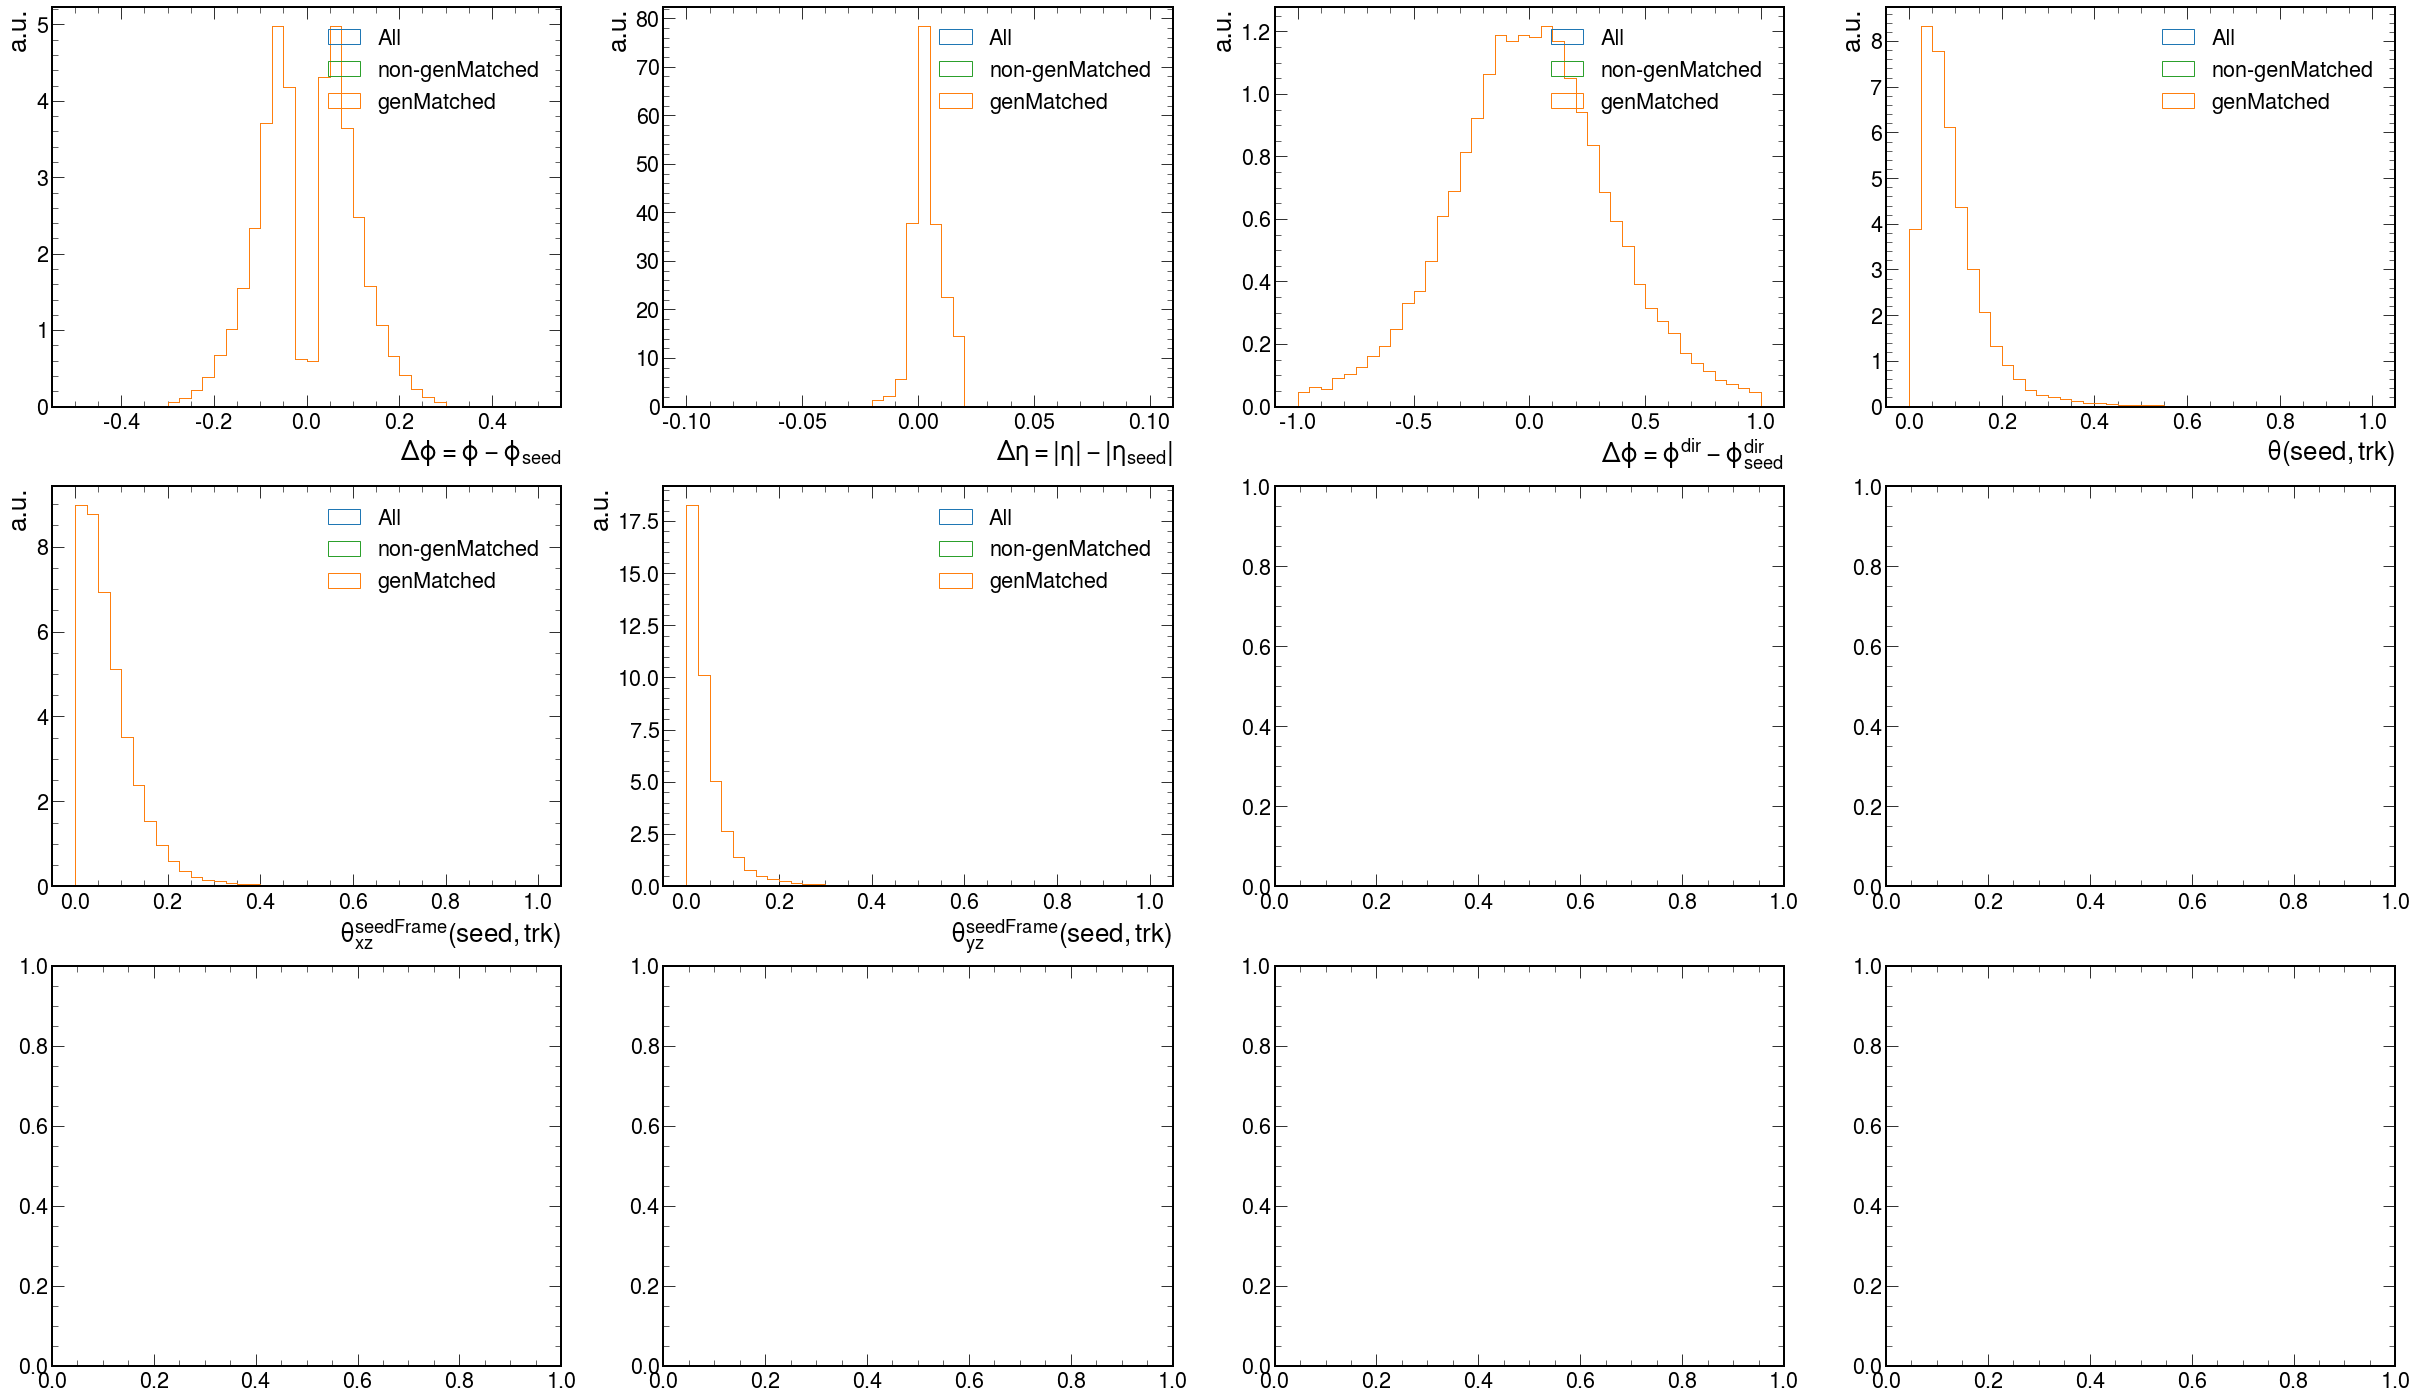

In [211]:
plotDistributions(deltas, True)


# SimTracks and moustache

In [606]:
dEta             = np.array([deltas.DeltaEta[i][t] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i])) ])
dPhi             = np.array([deltas.DeltaPhi[i][t] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])
simTrackSeed_pT  = np.array([deltas.pt_maxPtsimTrack[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])
simTrackSeed_en  = np.array([deltas.en_maxPtsimTrack[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])
simTrackSeed_pid = np.array([deltas.pid_maxPtsimTrack[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])

EtaSeed          = np.array([deltas.EtaSeed[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])
EnSeed           = np.array([deltas.EnSeed[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])
PtSeed           = np.array([deltas.PtSeed[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])

gun_en           = np.array([deltas.gunEn[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])
gun_pt           = np.array([deltas.gunPt[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))])
gun_eta          = np.arccosh(gun_en/gun_pt)
LClayer          = np.array([deltas.LClayers[i][t] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))], dtype=object)
LCen             = np.array([deltas.LCens[i][t] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))], dtype=object)
trackster_en     = np.array([sum(deltas.LCens[i][t]) for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))], dtype=object)
trackster_eta    = np.array([deltas.trksEta[i][t] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))], dtype=object)
trackster_phi    = np.array([deltas.trksPhi[i][t] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i]))], dtype=object)

idxs             = np.array([deltas.idx[i] for i in range(len(deltas)) for t in range(len(deltas.DeltaEta[i])) ])

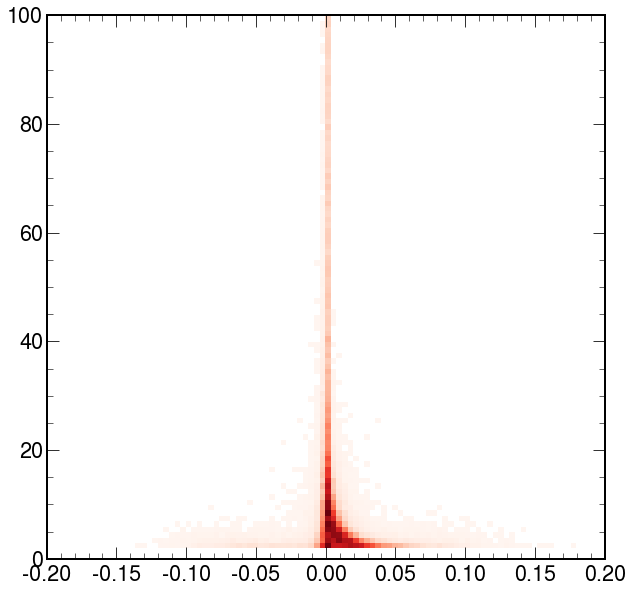

In [441]:
cmap_reds = copy.copy(plt.cm.get_cmap("Reds"))
cmap_reds.set_under('white')
plt.hist2d(dEta, LCen_sum, bins=100, range=[[-0.2,0.2], [0,100]], cmap = cmap_reds, vmin=0.00001)
plt.show()

In [474]:
np.unique(deltas['pid_maxPtsimTrack'], return_counts=True)

(array([-11,  11,  22]), array([19086, 18985,   259]))

In [484]:
np.unique(simTrackSeed_pid[idxs_halo], return_counts=True)

(array([-11,  11,  22]), array([196, 210,   1]))

In [608]:
# idxs_halo = np.where((abs(dEta)>0.025) & (abs(dPhi)<0.01) & (abs(dEta)>0))[0]
idxs_halo = np.where((abs(dEta)>0.025) & (abs(dPhi)<0.01))[0]
idxs_halo_kin = np.where((trackster_en<4)&(trackster_eta>2.2))[0]

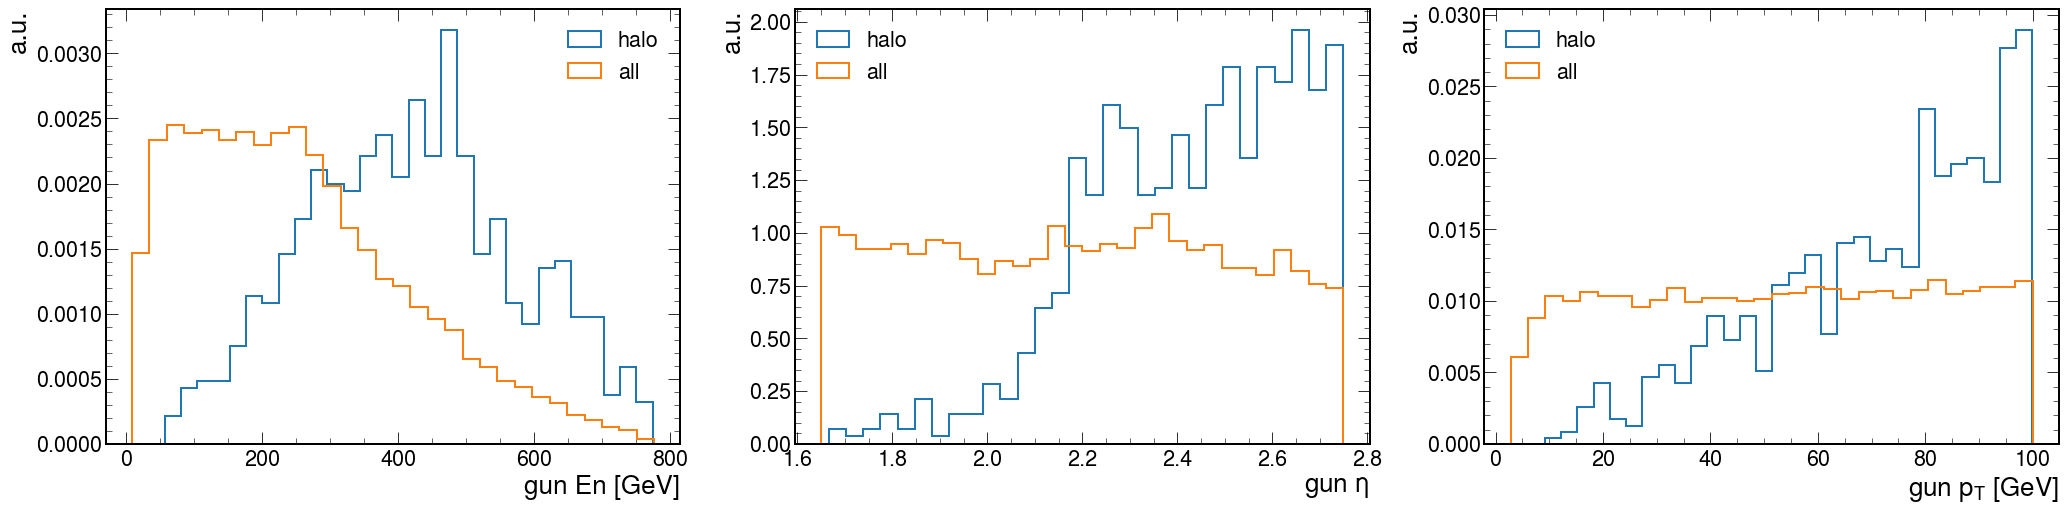

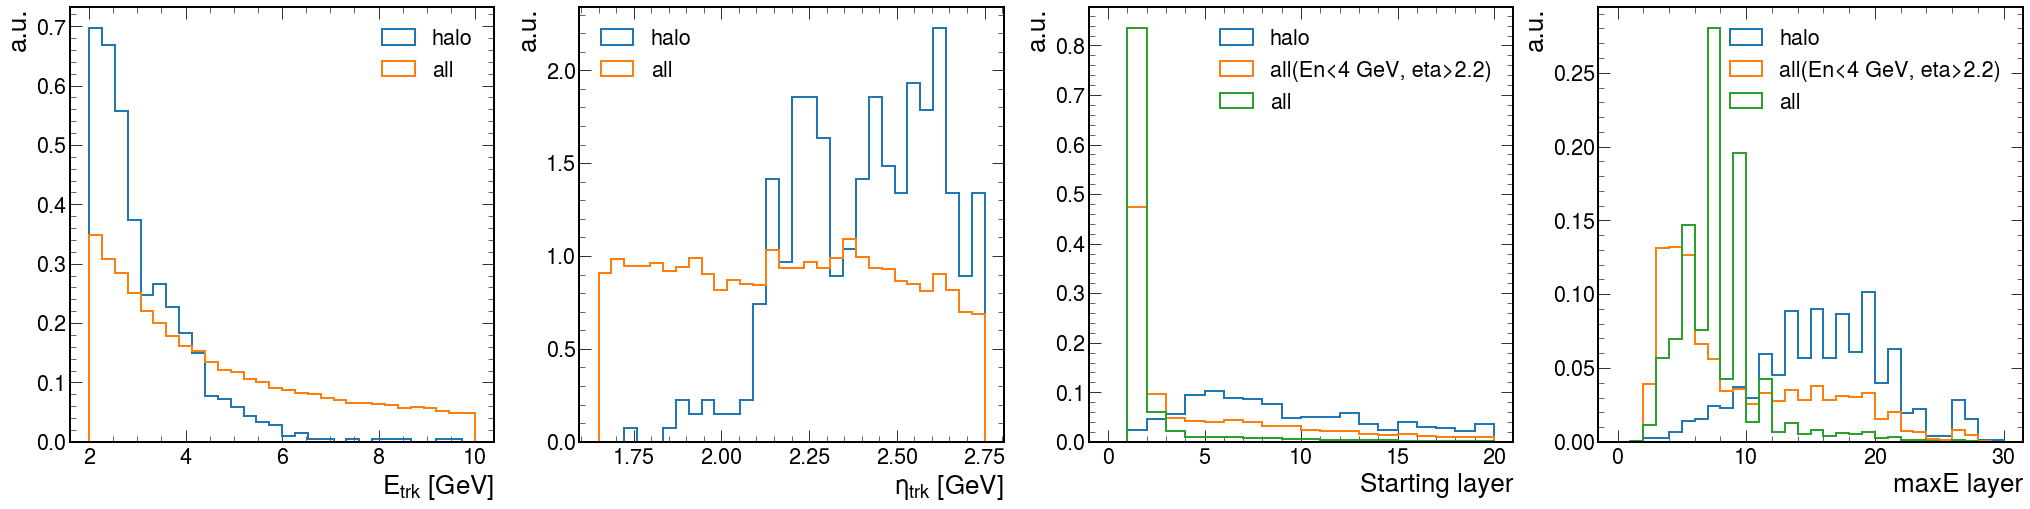

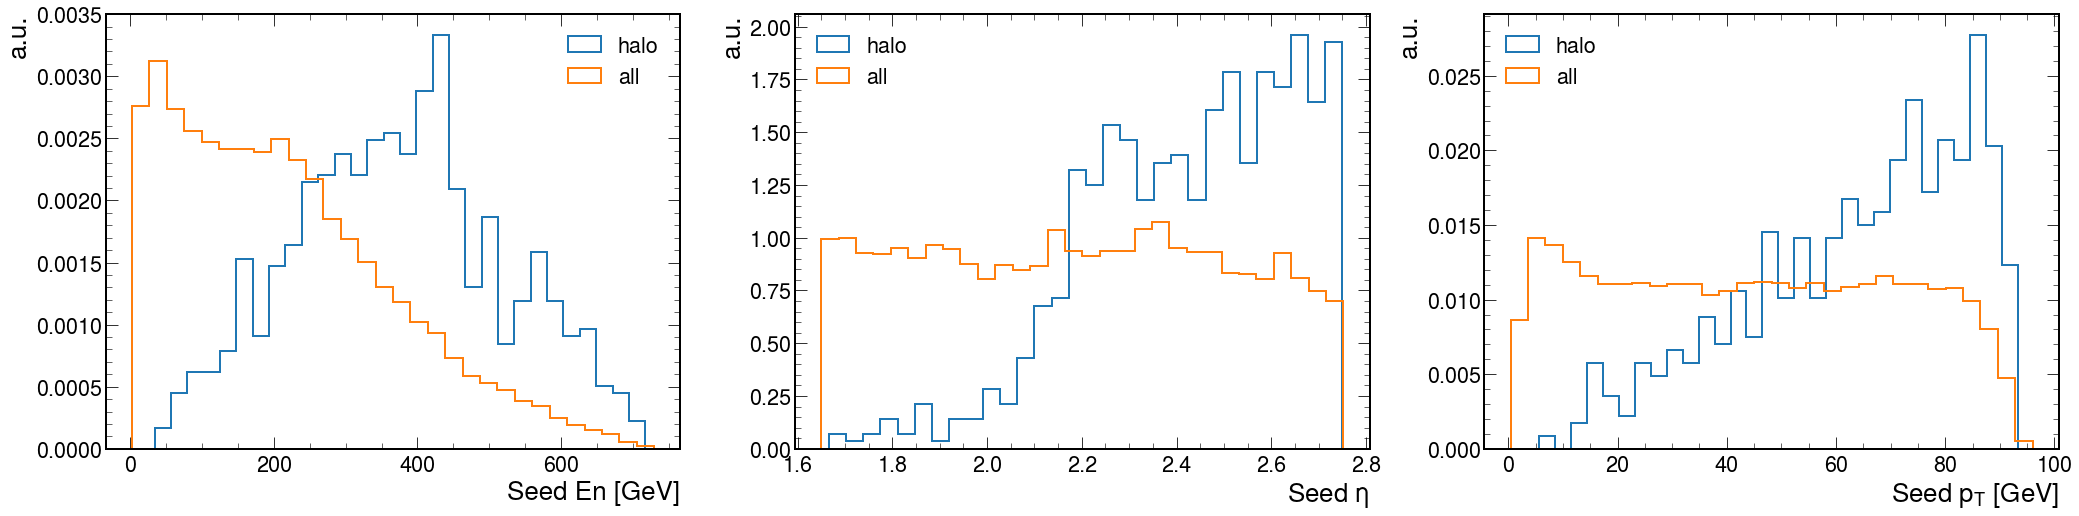

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(35,8))
plt.style.use(hep.style.CMS)
axs = axs.ravel()

axs[0].hist([lay for lay in gun_en[idxs_halo]], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[0].hist([lay for lay in gun_en], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[0].legend()
axs[0].set_xlabel('gun En [GeV]')
axs[0].set_ylabel('a.u.')

axs[1].hist([lay for lay in gun_eta[idxs_halo]], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[1].hist([lay for lay in gun_eta], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[1].legend(loc='upper left')
axs[1].set_xlabel(r'gun $\eta$')
axs[1].set_ylabel('a.u.')

axs[2].hist([lay for lay in gun_pt[idxs_halo]], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[2].hist([lay for lay in gun_pt], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[2].legend(loc='upper left')
axs[2].set_xlabel(r'gun $p_T$ [GeV]')
axs[2].set_ylabel('a.u.')

plt.show()

###############--------------------------------------------###############

fig, axs = plt.subplots(1, 4, figsize=(35,8))
plt.style.use(hep.style.CMS)
axs = axs.ravel()

axs[0].hist(trackster_en[idxs_halo],range = [2,10], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[0].hist(trackster_en, range = [2,10], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[0].legend()
axs[0].set_xlabel(r'$E_{\rm trk}$ [GeV]')
axs[0].set_ylabel('a.u.')

axs[1].hist(trackster_eta[idxs_halo],range = [1.65,2.75], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[1].hist(trackster_eta, range = [1.65,2.75], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[1].legend(loc='upper left')
axs[1].set_xlabel(r'$\eta_{\rm trk}$ [GeV]')
axs[1].set_ylabel('a.u.')

axs[2].hist([lay[0] for lay in LClayer[idxs_halo]], histtype='step', bins=20, range=[0,20], density=True, lw=2, label='halo')
# axs[2].axvline(np.mean([lay[0] for lay in LClayer[idxs_halo]]), ls='--')
axs[2].hist([lay[0] for lay in LClayer[idxs_halo_kin]], histtype='step', bins=20, range=[0,20], density=True, lw=2, label='all(En<4 GeV, eta>2.2)')
# axs[2].axvline(np.mean([lay[0] for lay in LClayer[idxs_halo_kin]]), ls='--', c='tab:orange')
axs[2].hist([lay[0] for lay in LClayer], histtype='step', bins=20, range=[0,20], density=True, lw=2, label='all')
# axs[2].axvline(np.mean([lay[0] for lay in LClayer]), ls='--', c='tab:green')
axs[2].set_xlabel('Starting layer')
axs[2].set_ylabel('a.u.')
axs[2].legend()

axs[3].hist([lay[np.argmax(LCen[idxs_halo][idx])] for idx, lay in enumerate(LClayer[idxs_halo])], histtype='step', bins=30, range=[0,30], density=True, lw=2, label='halo')
axs[3].hist([lay[np.argmax(LCen[idxs_halo_kin][idx])] for idx, lay in enumerate(LClayer[idxs_halo_kin])], histtype='step', bins=30, range=[0,30], density=True, lw=2, label='all(En<4 GeV, eta>2.2)')
axs[3].hist([lay[np.argmax(LCen[idx])] for idx, lay in enumerate(LClayer)], histtype='step', bins=30, range=[0,30], density=True, lw=2, label='all')
axs[3].set_xlabel('maxE layer')
axs[3].set_ylabel('a.u.')
axs[3].legend()

plt.show()


###############--------------------------------------------###############

fig, axs = plt.subplots(1, 3, figsize=(35,8))
plt.style.use(hep.style.CMS)
axs = axs.ravel()

axs[0].hist([lay for lay in EnSeed[idxs_halo]], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[0].hist([lay for lay in EnSeed], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[0].legend()
axs[0].set_xlabel('Seed En [GeV]')
axs[0].set_ylabel('a.u.')

axs[1].hist([abs(lay) for lay in EtaSeed[idxs_halo]], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[1].hist([abs(lay) for lay in EtaSeed], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[1].legend(loc='upper left')
axs[1].set_xlabel(r'Seed $\eta$')
axs[1].set_ylabel('a.u.')

axs[2].hist([lay for lay in PtSeed[idxs_halo]], bins=30, histtype = 'step', label='halo', lw=2, density = True)
axs[2].hist([lay for lay in PtSeed], bins=30, histtype = 'step', label='all', lw=2, density = True)
axs[2].legend(loc='upper left')
axs[2].set_xlabel(r'Seed $p_T$ [GeV]')
axs[2].set_ylabel('a.u.')

plt.show()




In [14]:
## For thesis -- this cell is related to the next one
dEta             = np.array([deltas_noSkim.DeltaEta[i][t] for i in range(len(deltas)) for t in range(len(deltas_noSkim.DeltaEta[i])) ])
dPhi             = np.array([deltas_noSkim.DeltaPhi[i][t] for i in range(len(deltas)) for t in range(len(deltas_noSkim.DeltaEta[i]))])
EtaSeed          = np.array([deltas_noSkim.EtaSeed[i] for i in range(len(deltas)) for t in range(len(deltas_noSkim.DeltaEta[i]))])
PtSeed           = np.array([deltas_noSkim.PtSeed[i] for i in range(len(deltas)) for t in range(len(deltas_noSkim.DeltaEta[i]))])
LClayer          = np.array([deltas_noSkim.LClayers[i][t] for i in range(len(deltas)) for t in range(len(deltas_noSkim.DeltaEta[i]))], dtype=object)
trackster_en     = np.array([sum(deltas_noSkim.LCens[i][t]) for i in range(len(deltas)) for t in range(len(deltas_noSkim.DeltaEta[i]))], dtype=object)
trackster_eta    = np.array([deltas_noSkim.trksEta[i][t] for i in range(len(deltas)) for t in range(len(deltas_noSkim.DeltaEta[i]))], dtype=object)
idxs_halo = np.where((abs(dEta)>0.025) & (abs(dPhi)<0.01))[0]

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


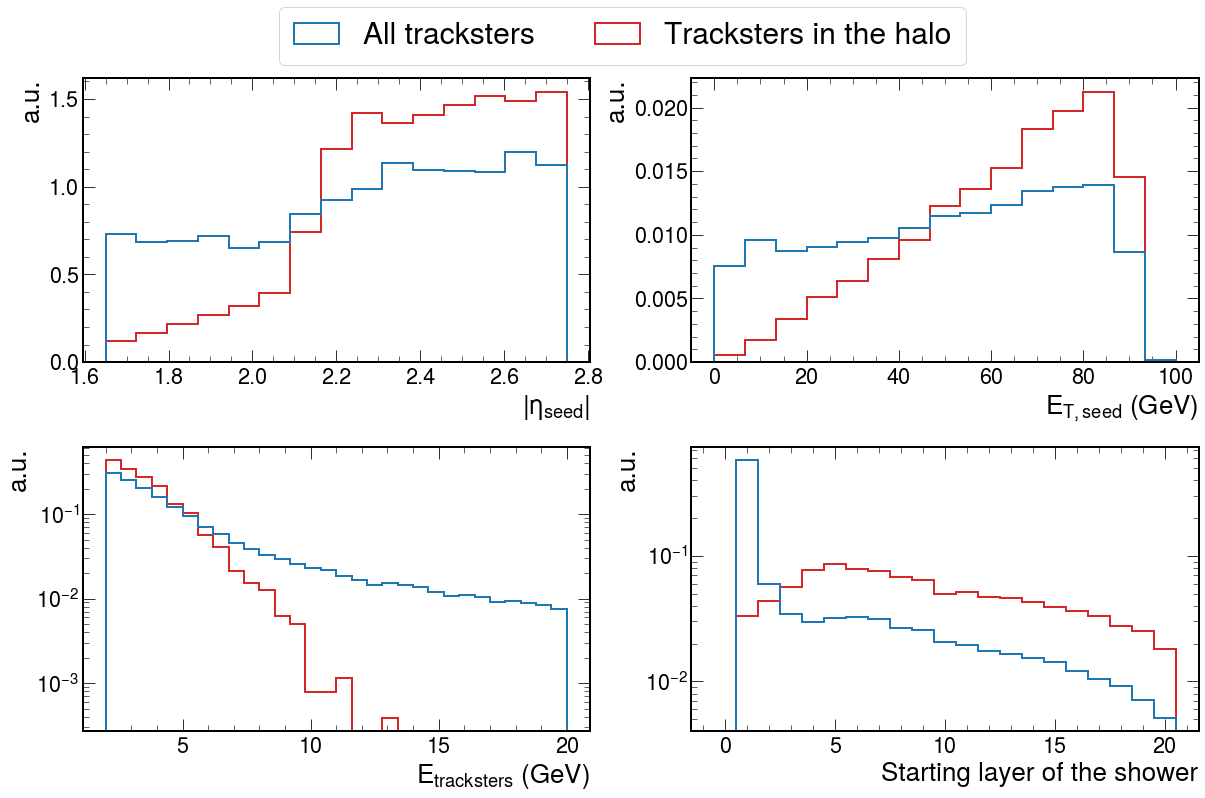

In [15]:
## For thesis
fig, axs = plt.subplots(2, 2, figsize=(20,12))
plt.style.use(hep.style.CMS)
axs = axs.ravel()

label_halo = 'Tracksters in the halo'
label_all = 'All tracksters'

axs[0].hist([abs(lay) for lay in EtaSeed[idxs_halo]], bins=15, range=[1.65,2.75], histtype = 'step', label=label_halo, lw=2, density = True, color='tab:red')
axs[0].hist([abs(lay) for lay in EtaSeed], bins=15, range=[1.65,2.75], histtype = 'step', label=label_all, lw=2, density = True, color='tab:blue')
# axs[1].legend(loc='upper left')
axs[0].set_xlabel(r'$|\eta_{seed}|$')
axs[0].set_ylabel('a.u.')

axs[1].hist([lay for lay in PtSeed[idxs_halo]], bins=15, range=[0,100], histtype = 'step', label=label_halo, lw=2, density = True, color='tab:red')
axs[1].hist([lay for lay in PtSeed], bins=15, range=[0,100], histtype = 'step', label=label_all, lw=2, density = True, color='tab:blue')
# axs[2].legend(loc='upper left')
axs[1].set_xlabel(r'$E_{T,seed}$ (GeV)')
axs[1].set_ylabel('a.u.')

axs[2].hist(trackster_en[idxs_halo],range = [2,20], bins=30, histtype = 'step', label=label_halo, lw=2, density = True, color='tab:red')
axs[2].hist(trackster_en, range = [2,20], bins=30, histtype = 'step', label=label_all, lw=2, density = True, color='tab:blue')
axs[2].set_xlabel(r'$E_{tracksters}$ (GeV)')
axs[2].set_ylabel('a.u.')
axs[2].set_yscale('log')

axs[3].hist([lay[0] for lay in LClayer[idxs_halo]], histtype='step', bins=21, range=[-0.5,20.5], density=True, lw=2, label=label_halo, color='tab:red')
axs[3].hist([lay[0] for lay in LClayer], histtype='step', bins=21, range=[-0.5,20.5], density=True, lw=2, label=label_all, color='tab:blue')
axs[3].set_xlabel('Starting layer of the shower')
axs[3].set_ylabel('a.u.')
axs[3].set_yscale('log')
# axs[4].legend()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=30, frameon=True)

plt.subplots_adjust(hspace=0.3)

plt.savefig('halo.pdf', dpi=150, bbox_inches='tight')
plt.show()


In [781]:
np.percentile(trackster_en[idxs_halo], 95)

5.790475568175315

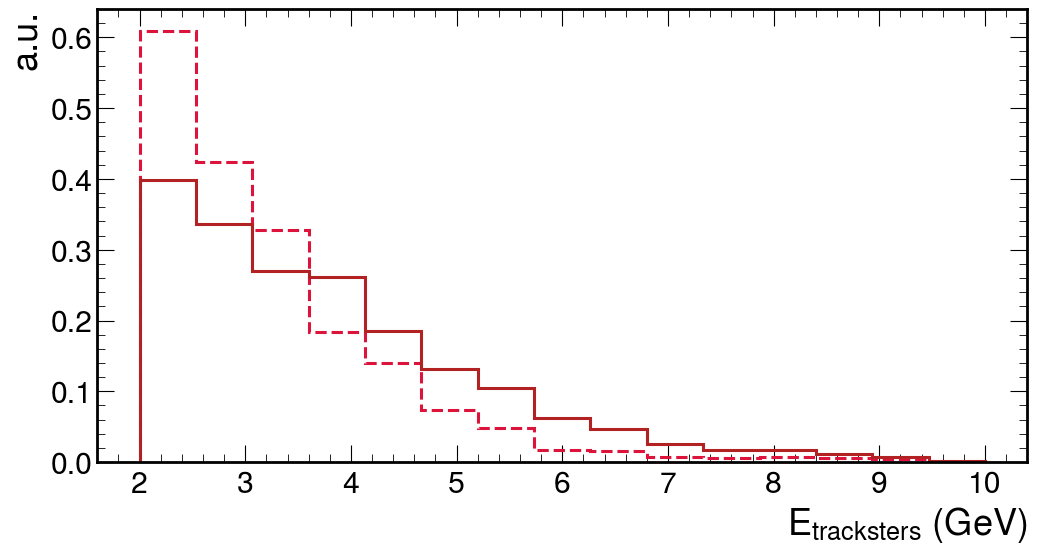

In [768]:
plt.figure(figsize=(12, 6), dpi=100)
plt.hist(trackster_en[idxs_halo][PtSeed[idxs_halo]<50],range = [2,10], bins=15, histtype = 'step', label=label_halo, lw=2.2, density = True, 
         color='crimson', ls='--')
plt.hist(trackster_en[idxs_halo][(PtSeed[idxs_halo]>50)&(PtSeed[idxs_halo]<100)],range = [2,10], bins=15, histtype = 'step', label=label_halo, lw=2.2, density = True, 
         color='firebrick', ls='-')
plt.xlabel(r'$E_{tracksters}$ (GeV)')
plt.ylabel('a.u.')
# plt.yscale('log')
plt.show()

In [718]:
histedges_equalN(PtSeed[idxs_halo],3)

array([ 2.53174496, 54.76041412, 75.27083588, 94.78193665])

------- Event information -------
event, sample, eta: 12 109 -1
------- Gun information -------
eta gun: -2.377
phi gun: -0.277
En gun: 509.775
ID gun: -11
pT gun: 93.872
blue  - energy: 2.899  - eta: -2.374  - phi: -0.342  - pt: 0.535  - dEta: -0.003  - dPhi: -0.062     0.986         False      False
orange  - energy: 461.884  - eta: -2.377  - phi: -0.28  - pt: 85.046  - dEta: 0.0  - dPhi: 0.0     1.0         False      False
green  - energy: 5.708  - eta: -2.363  - phi: -0.213  - pt: 1.065  - dEta: -0.013  - dPhi: 0.067     0.707         False      True
red  - energy: 1.942  - eta: -2.355  - phi: -0.37  - pt: 0.365  - dEta: -0.022  - dPhi: -0.09     0.782         False      True
purple  - energy: 5.602  - eta: -2.443  - phi: -0.305  - pt: 0.966  - dEta: 0.067  - dPhi: -0.025     0.725         True      True
brown  - energy: 2.985  - eta: -2.298  - phi: -0.298  - pt: 0.594  - dEta: -0.079  - dPhi: -0.019     0.925         True      False


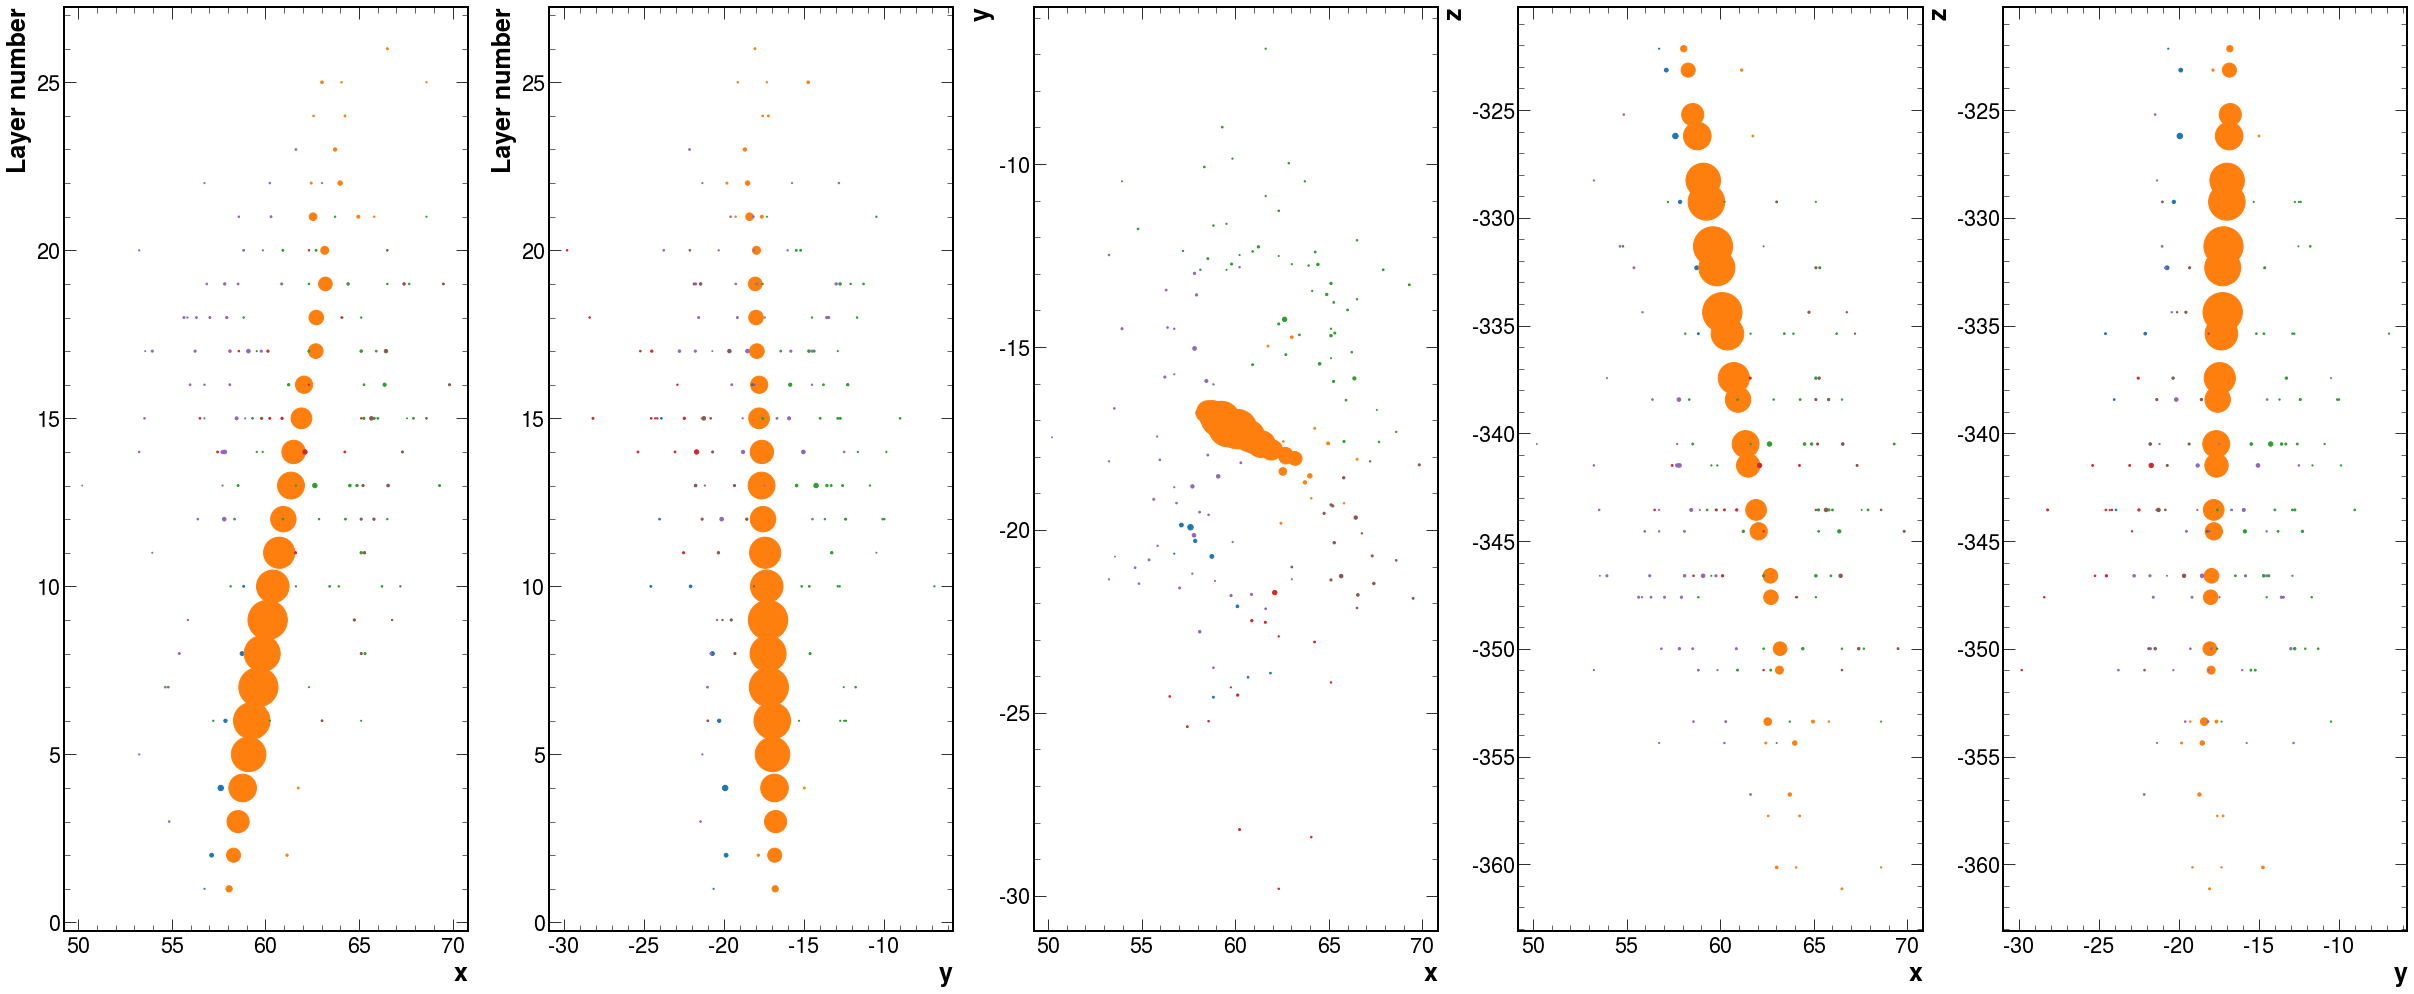

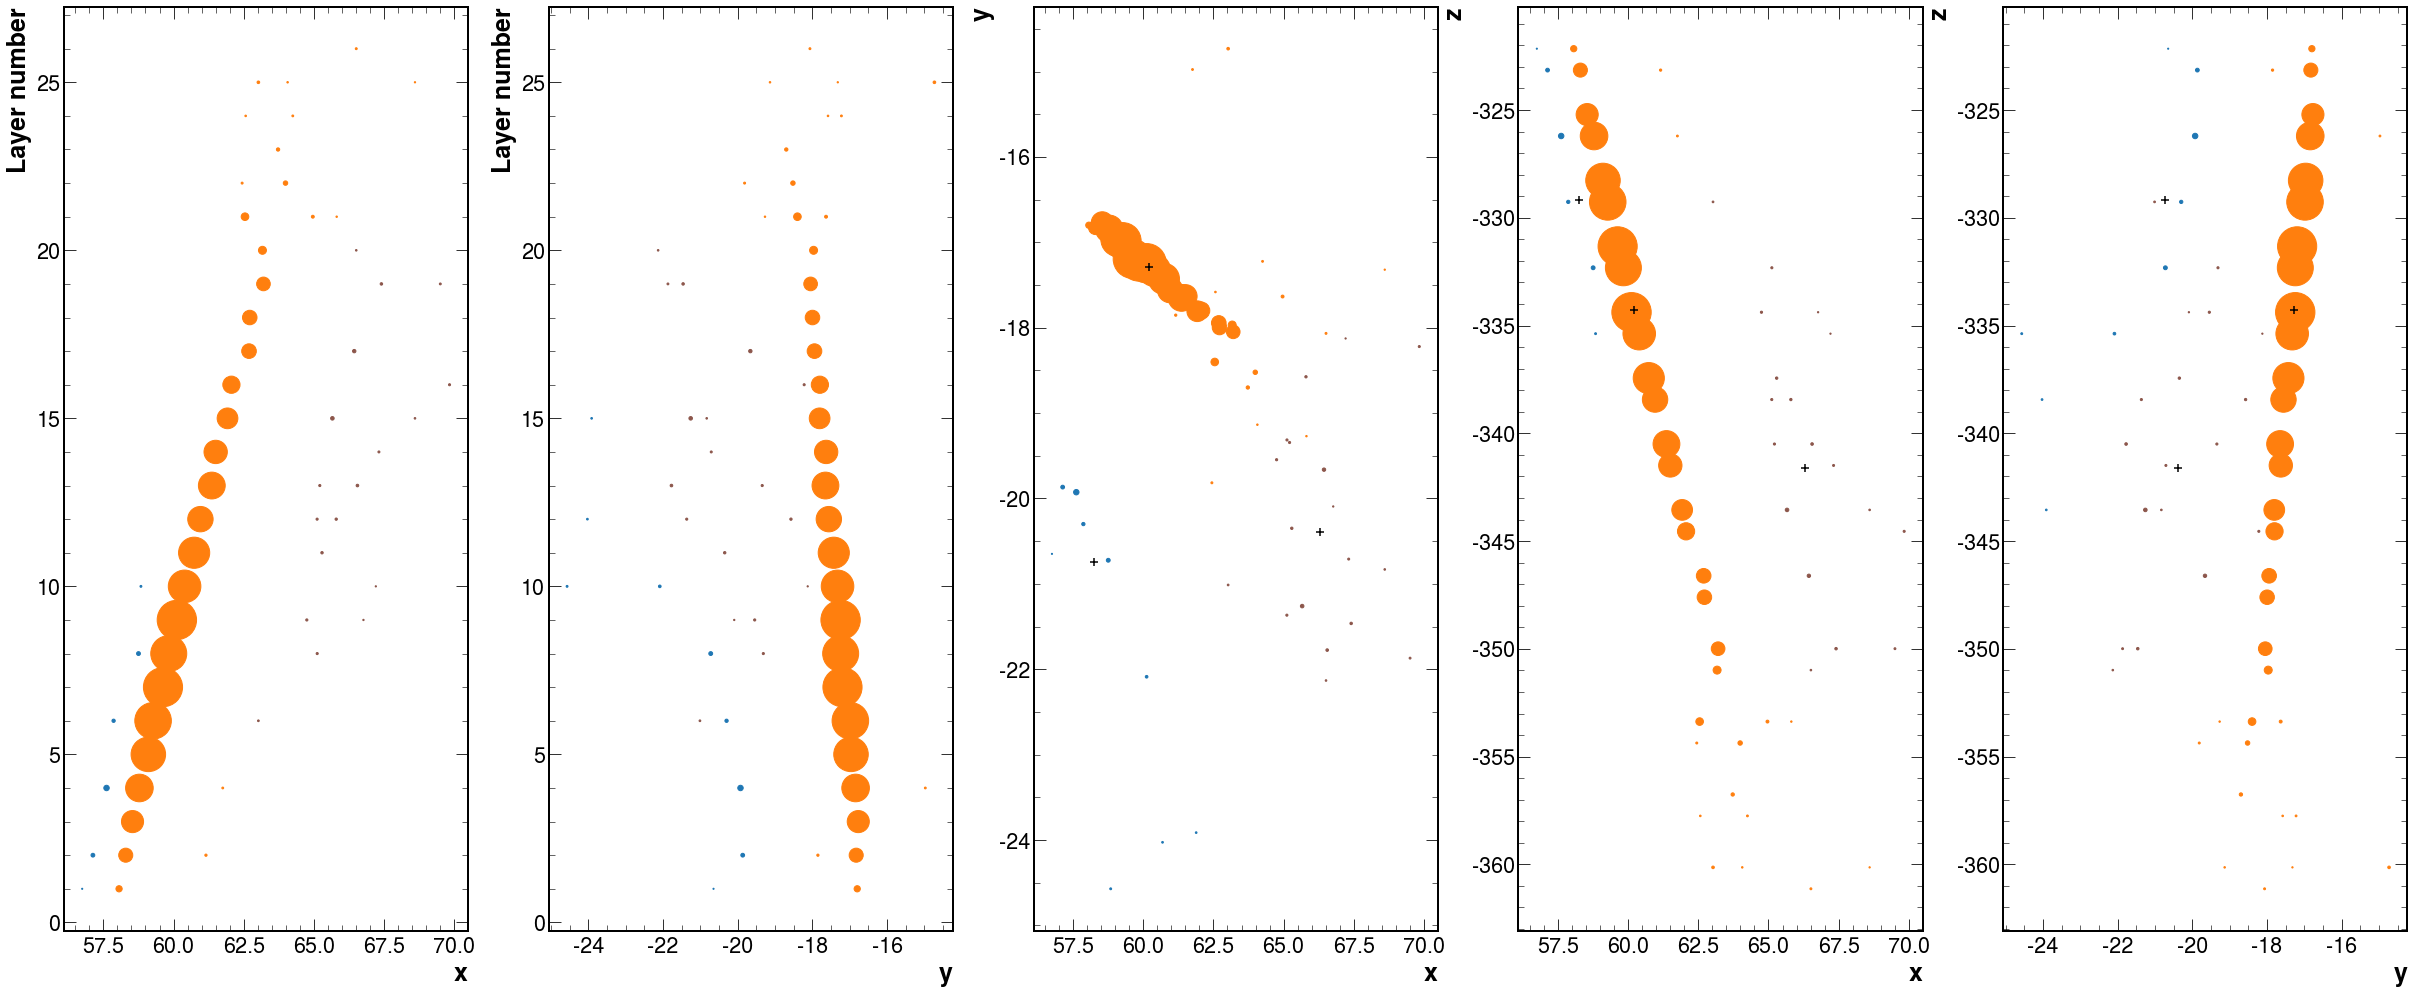

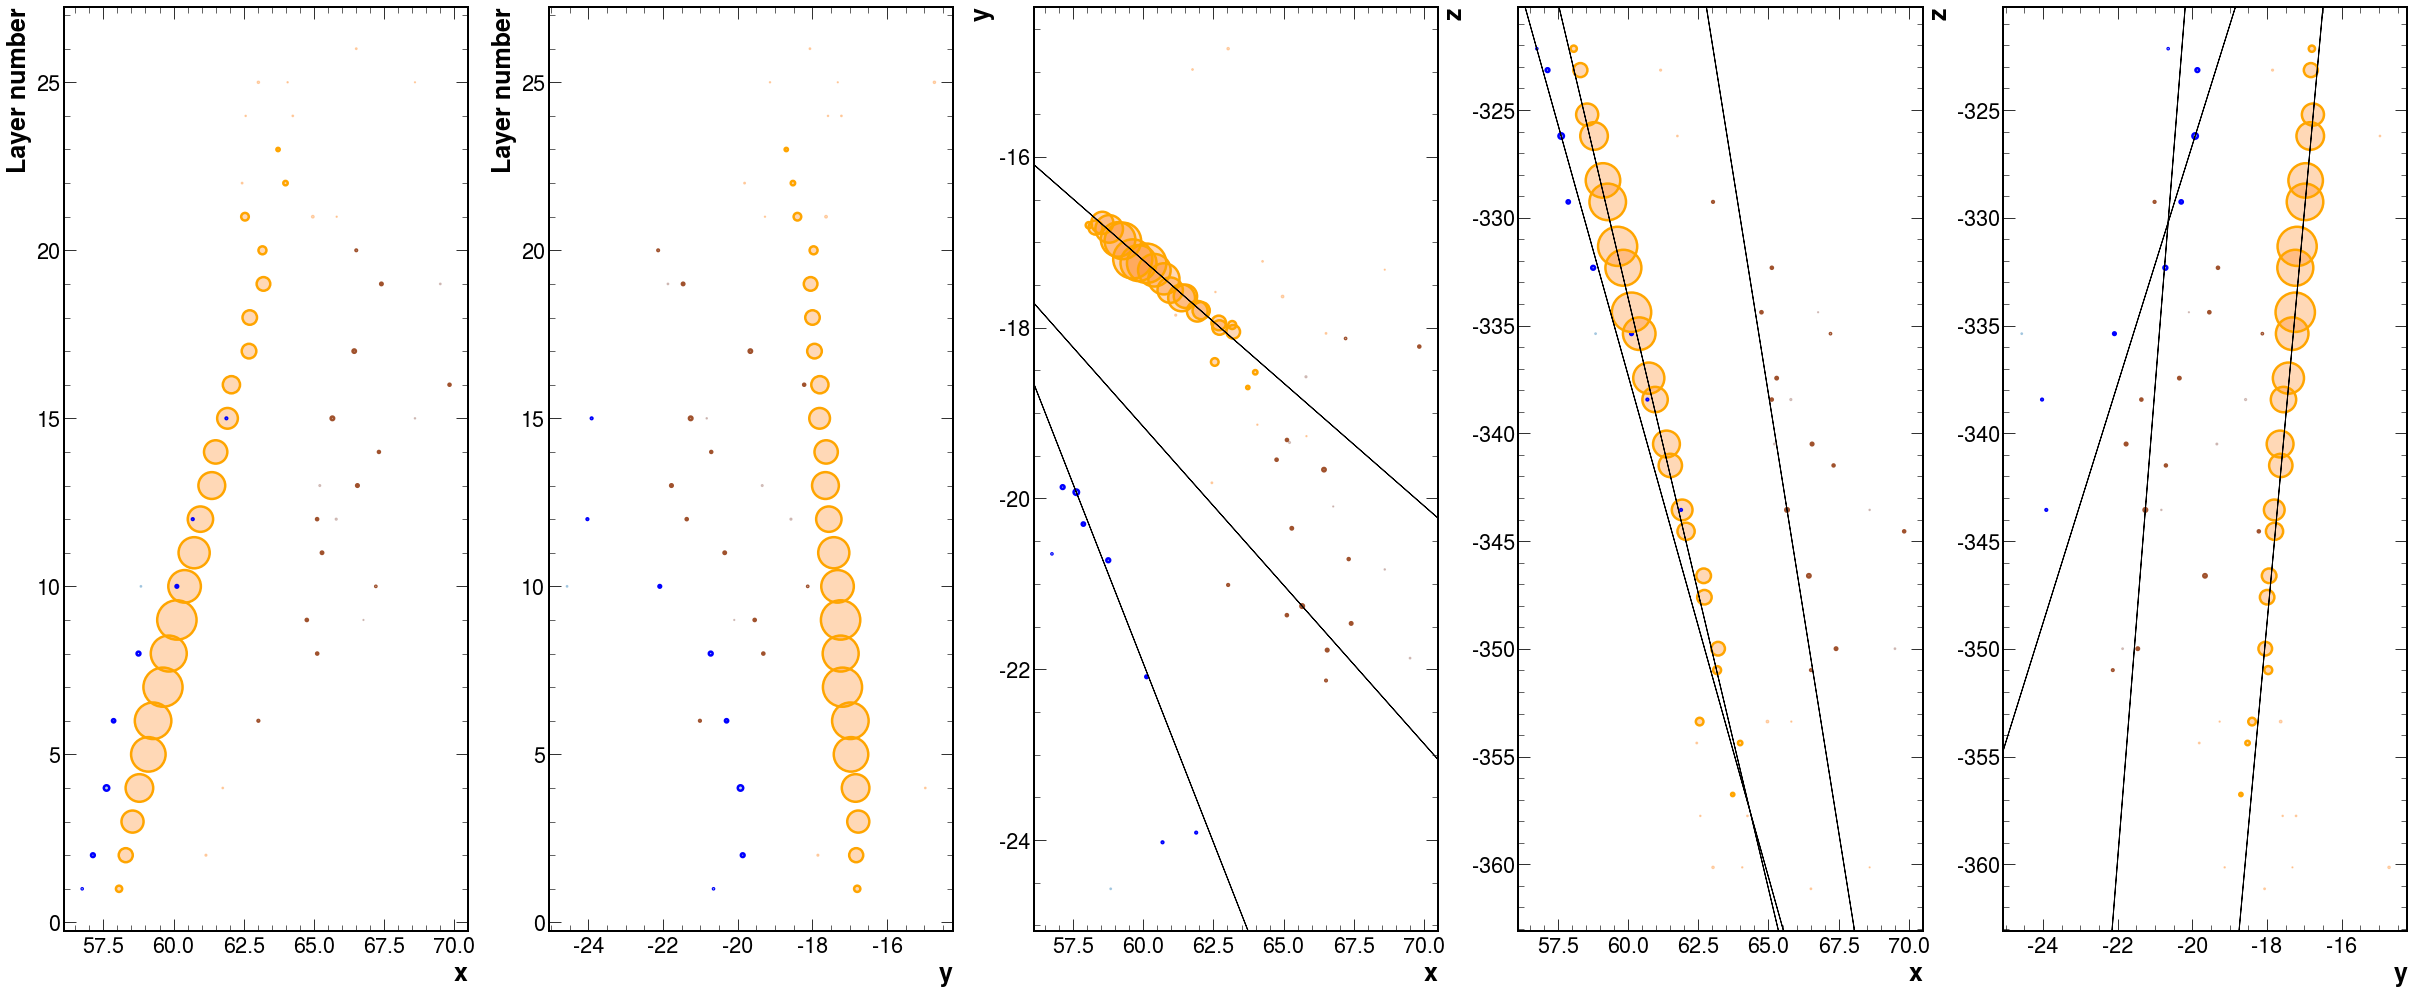

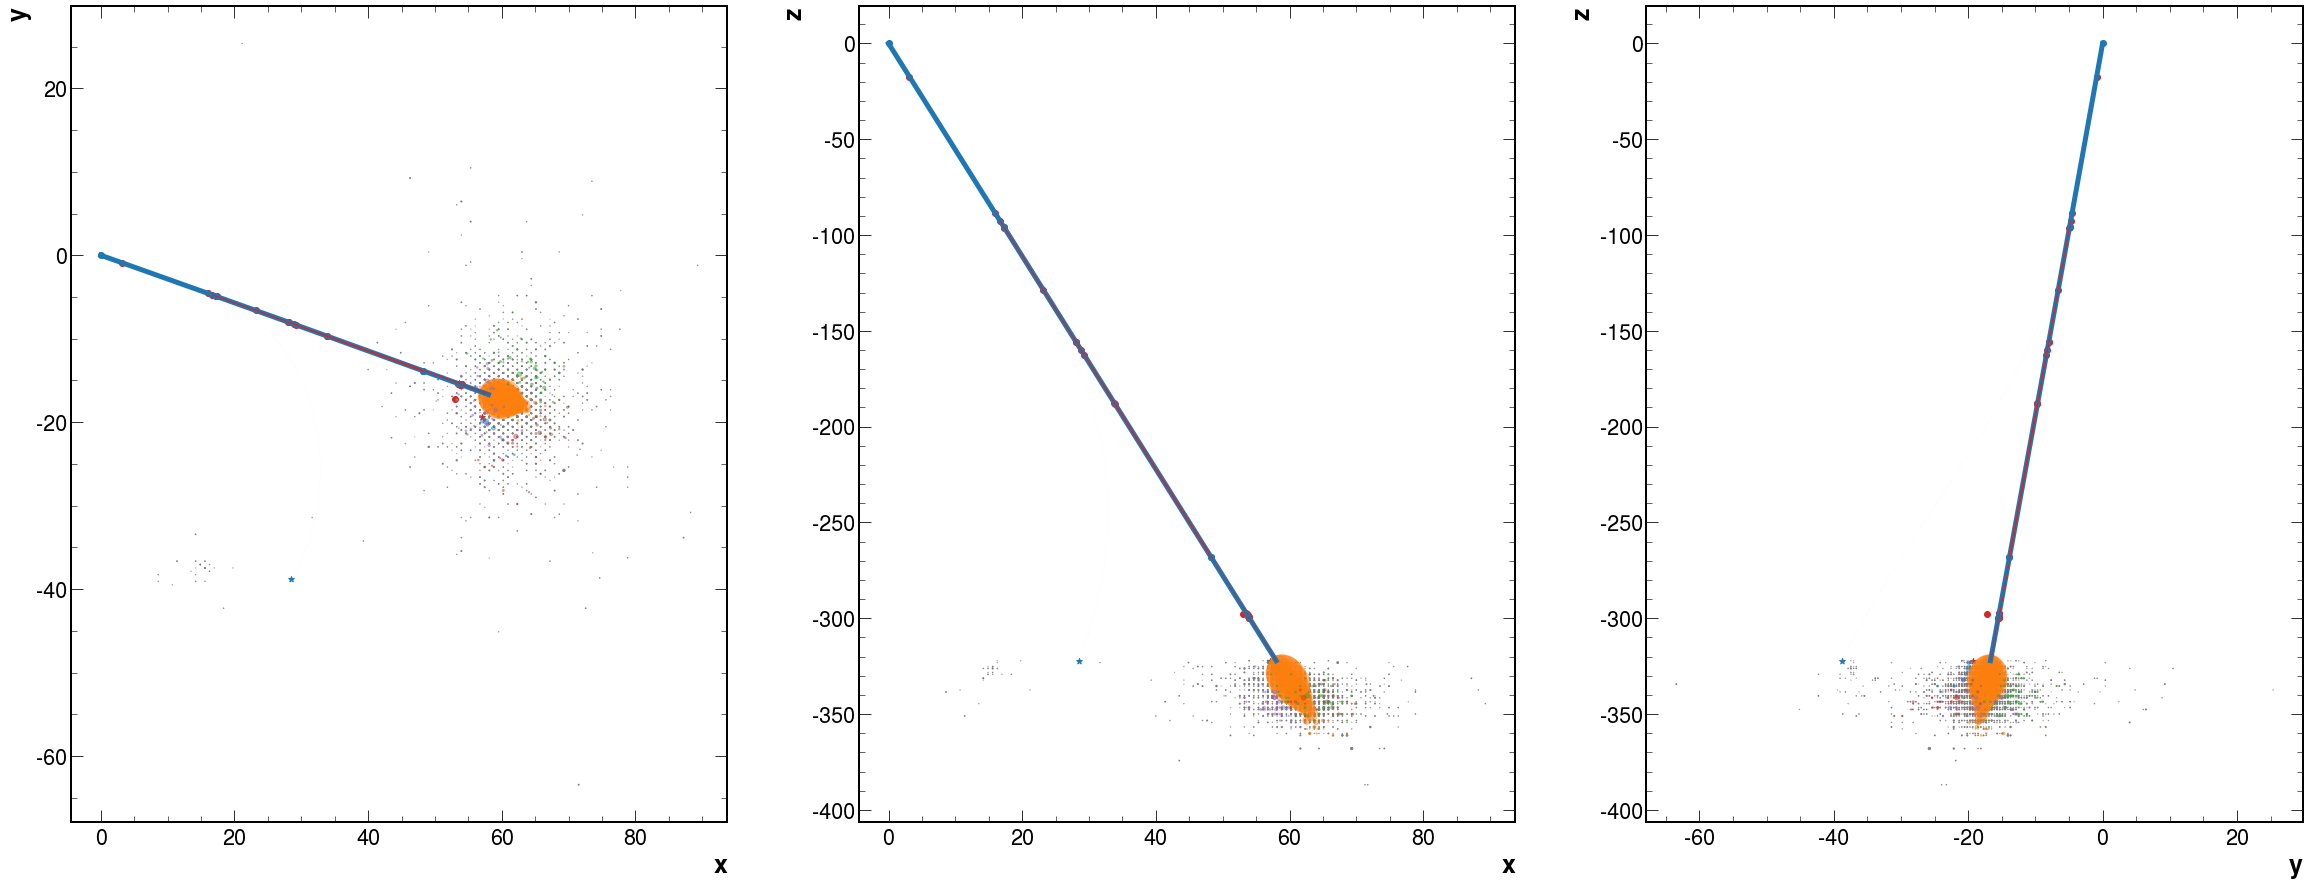

In [381]:
evt = 173
eventDisplay(ele[evt], removeTrk=True, cleaned = True)
simTracksDisplay(ele[evt])
plot3D(ele[evt])

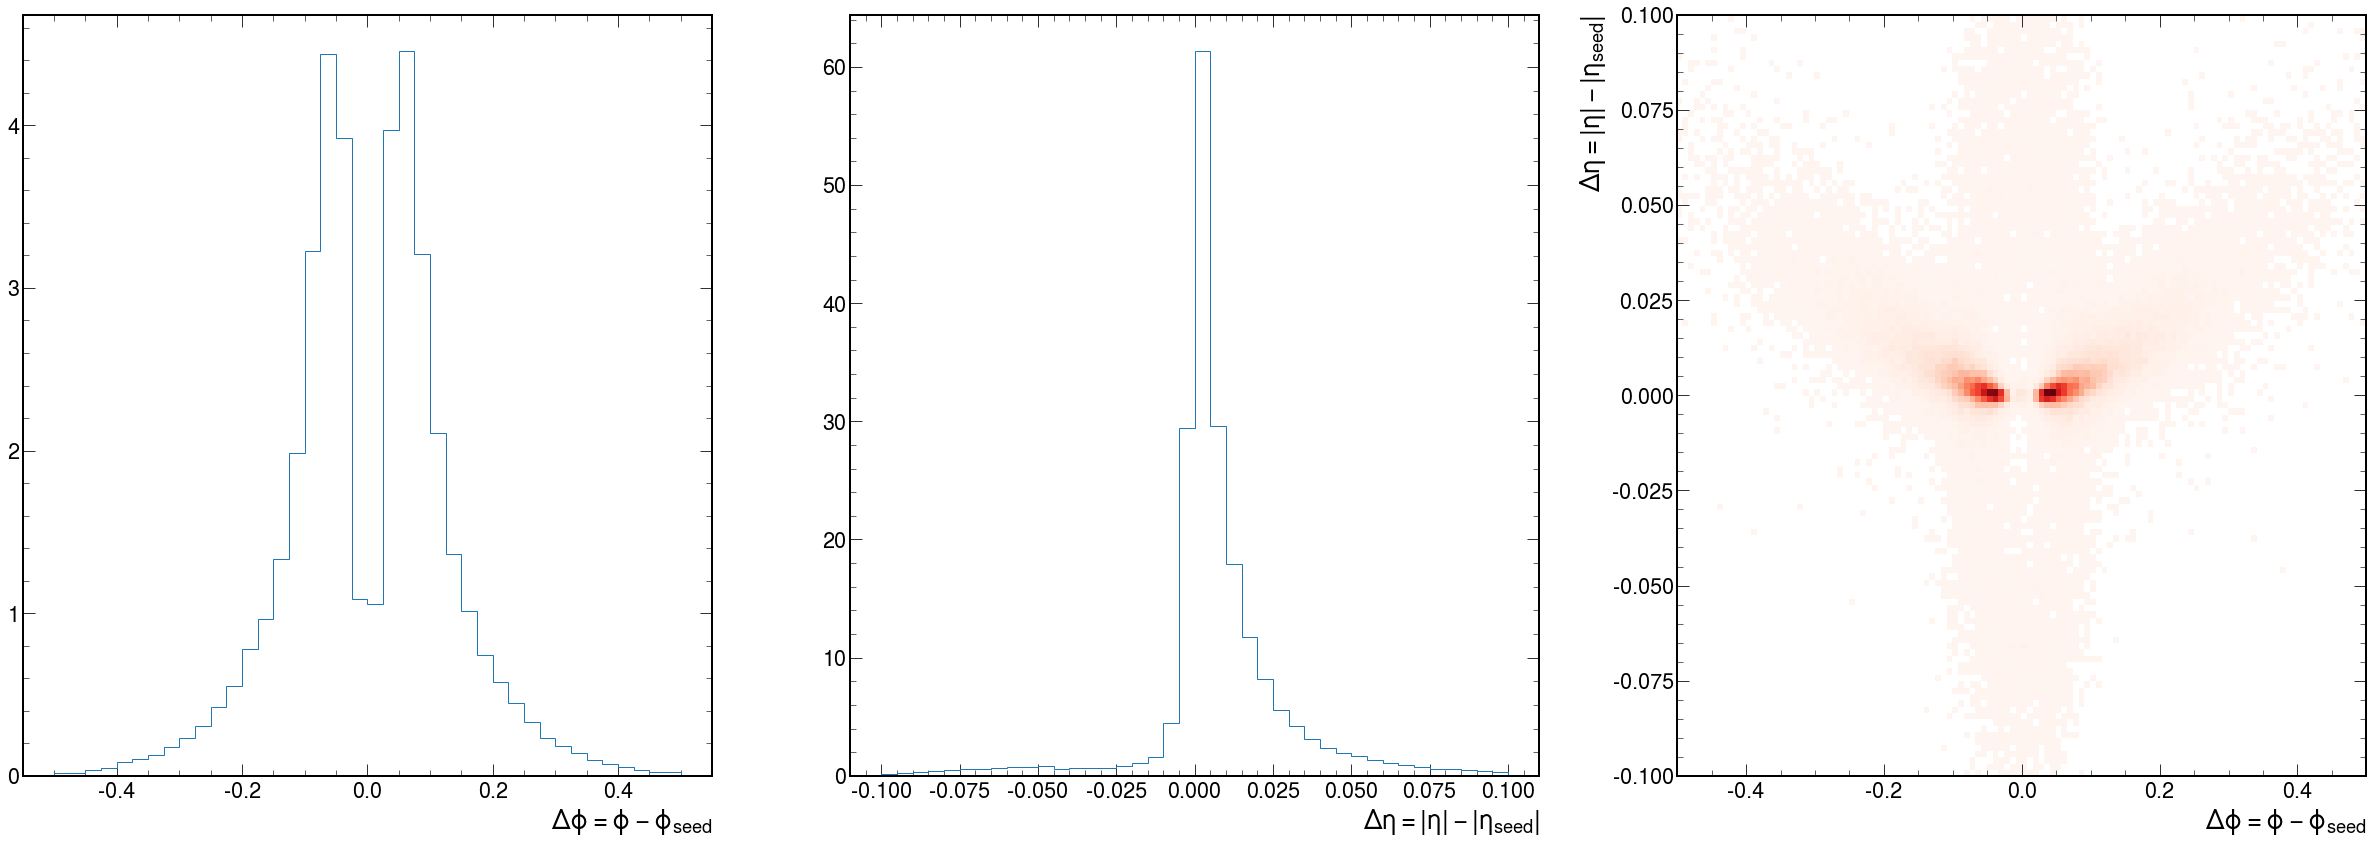

In [91]:
pileup = False

plotdeltas(deltas, 'DeltaPhi',           'DeltaEta',           [-0.5,0.5],   [-0.10,0.10], r'$\Delta\phi = \phi - \phi_{seed}$',             r'$\Delta\eta = |\eta| - |\eta_{seed}|$', pileup)
# plotdeltas(deltas[abs(deltas.pid_maxPtsimTrack)==11].reset_index(), 'DeltaPhi',           'DeltaEta',           [-0.5,0.5],   [-0.10,0.10], r'$\Delta\phi = \phi - \phi_{seed}$',             r'$\Delta\eta = |\eta| - |\eta_{seed}|$', pileup)
# plotdeltas(deltas[abs(deltas.pid_maxPtsimTrack)==22].reset_index(), 'DeltaPhi',           'DeltaEta',           [-0.5,0.5],   [-0.10,0.10], r'$\Delta\phi = \phi - \phi_{seed}$',             r'$\Delta\eta = |\eta| - |\eta_{seed}|$', pileup)
# plotdeltas(deltas, 'DeltaPhiPCA',        'theta',              [-0.6,0.6],   [0,0.4],      r'$\Delta\phi = \phi^{dir} - \phi_{seed}^{dir}$', r'$\theta(seed, trk)$',                   pileup)
# plotdeltas(deltas, 'PhiPCA_seedFrame',   'theta',              [-1.57,1.57], [0,0.4],      r'$\phi^{dir}_{seedFrame}$',                      r'$\theta(seed, trk)$',                   pileup)
# plotdeltas(deltas, 'theta_xz_seedFrame', 'theta_yz_seedFrame', [0,0.4],      [0,0.4],      r'$\theta_{xz}^{seedFrame}(seed, trk)$',          r'$\theta_{yz}^{seedFrame}(seed, trk)$',  pileup)
# plotdeltas(deltas, 'theta_xz_cmsFrame',  'theta_yz_cmsFrame',  [0,0.4],      [0,0.4],      r'$\theta_{xz}^{cmsFrame}(seed, trk)$',           r'$\theta_{yz}^{cmsFrame}(seed, trk)$',   pileup)
# plotdeltas(deltas, 'theta_xy_cmsFrame',  'theta_yz_cmsFrame',  [0,0.8],      [0,0.4],      r'$\theta_{xy}^{cmsFrame}(seed, trk)$',           r'$\theta_{yz}^{cmsFrame}(seed, trk)$',   pileup)
# plotdeltas(deltas, 'theta_xy_cmsFrame',  'theta_xz_cmsFrame',  [0,0.8],      [0,0.4],      r'$\theta_{xy}^{cmsFrame}(seed, trk)$',           r'$\theta_{xz}^{cmsFrame}(seed, trk)$',   pileup)
# plotdeltas(deltas, 'PhiPCA_seedFrame',   'EtaPCA_seedFrame',   [-1.5,1.5],   [0,6],        r'$\phi^{dir}_{seedFrame}$',                      r'$\eta^{dir}_{seedFrame}$',              pileup)



In [603]:
def plotdeltasEtaBins(_df, _var, _binning, _label, _nx, _ny):
    
    x_axs = _nx
    y_axs = _ny
    
#     if x_axs * y_axs < nBins:
#         raise Exception('The number or rows x columns should be greater or equal to the number of bins') 
    
#     eta_bin = histedges_equalN(abs(_df.EtaSeed), nBins)
#     eta_bin = [1.65, 1.8, 2.0, 2.2, 2.4, 2.6, 2.75] #Bin boundaries from moustache
#     print(eta_bin)
    
    fig, axs = plt.subplots(x_axs, y_axs, figsize=(35,20))
    axs = axs.ravel()
            
    for bins_idx in range(len(_binning)-1):
        
        df_bin = _df[(abs(_df[_var])>_binning[bins_idx]) & (abs(_df[_var])<_binning[bins_idx+1])]
    
        deta = []
        dphi = []
#         for ev_eta, ev_phi in zip(df_bin['DeltaEta'], df_bin['DeltaPhi']):
        for ev_eta, ev_phi in zip(df_bin['theta'], df_bin['DeltaPhiPCA']):
            for trk_idx in range(len(ev_eta)):
                if ev_phi[trk_idx] != 0:
                    deta.append(ev_eta[trk_idx])
                    dphi.append(ev_phi[trk_idx])


        cmap_reds = copy.copy(plt.cm.get_cmap("Reds"))
        cmap_reds.set_under('white')

        axs[bins_idx].set_title(r'$'+_label+'\in[%.2f,%.2f]$' % (_binning[bins_idx], _binning[bins_idx+1]))
        axs[bins_idx].hist2d(dphi, 
                             deta,
#                              range = [[-0.3,0.3],[-0.05,0.05]],
                             range = [[-0.3,0.3],[0,0.05]],
                             bins  = [120,120],
                             cmap  = cmap_reds, 
                             vmin  = 0.00001)
#         axs[bins_idx].set_xlabel('$\Delta\phi = \phi - \phi_{seed}$')
#         axs[bins_idx].set_ylabel('$\Delta\eta = |\eta| - |\eta_{seed}|$')
        axs[bins_idx].set_xlabel('$\Delta\phi = \phi^{dir} - \phi_{seed}^{dir}$')
        axs[bins_idx].set_ylabel(r'$\theta(seed, trk)$')

    plt.savefig('deltasBins.pdf', dpi=150, bbox_inches='tight')
    plt.show()
    
    
    
def plotdeltasEtaEnBins(_df, _var, _binning_eta, _binning_en, _label, _nx, _ny, _size):
    
    x_axs = _nx
    y_axs = _ny
    
    fig, axs = plt.subplots(x_axs, y_axs, figsize=(_size))
    axs = axs.ravel()
            
    j=0
    for eta_bins_idx in range(len(_binning_eta)-1):
        
        df_bin = _df[(abs(_df[_var])>_binning_eta[eta_bins_idx]) & (abs(_df[_var])<_binning_eta[eta_bins_idx+1])]
    
        for en_bins_idx in range(len(_binning_en)-1):
            deta = []
            dphi = []
            for ev_eta, ev_phi, ev_en in df_bin[['DeltaEta', 'DeltaPhi', 'trksLog10E']].to_numpy():
#             for ev_eta, ev_phi, ev_en in df_bin[['theta_xy_cmsFrame', 'theta_yz_cmsFrame', 'trksLog10E']].to_numpy():
                for trk_idx in range(len(ev_eta)):
                    if ev_phi[trk_idx] != 0 and ev_en[trk_idx] > _binning_en[en_bins_idx] and ev_en[trk_idx] < _binning_en[en_bins_idx+1]:
                        deta.append(ev_eta[trk_idx])
                        dphi.append(ev_phi[trk_idx])

            cmap_reds = copy.copy(plt.cm.get_cmap("Reds"))
            cmap_reds.set_under('white')

            axs[j].set_title(r'$\eta_{seed}\in[%.2f,%.2f]\times\log_{10}E_{trk}\in[%.2f,%.2f]$' % (_binning_eta[eta_bins_idx], _binning_eta[eta_bins_idx+1], _binning_en[en_bins_idx], _binning_en[en_bins_idx+1]),
                             fontsize=20)
            axs[j].hist2d(dphi, 
                          deta,
                          range = [[-0.5,0.5],[-0.1,0.1]],
#                           range = [[0,0.4],[0,3]],
                          bins  = [120,120],
                          cmap  = cmap_reds, 
                          vmin  = 0.00001)
            axs[j].set_xlabel('$\Delta\phi = \phi - \phi_{seed}$')
            axs[j].set_ylabel('$\Delta\eta = |\eta| - |\eta_{seed}|$')
            
            j = j + 1

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig('deltasBins.pdf', dpi=150, bbox_inches='tight')
    plt.show()
    
    
def plotDphiEt(_df, _var, _binning_eta, _label, _nx, _ny):
    
    x_axs = _nx
    y_axs = _ny
    
    fig, axs = plt.subplots(x_axs, y_axs, figsize=(30,10))
    axs = axs.ravel()
            
    for eta_bins_idx in range(len(_binning_eta)-1):
        
        df_bin = _df[(abs(_df[_var])>_binning_eta[eta_bins_idx]) & (abs(_df[_var])<_binning_eta[eta_bins_idx+1])]
        df_bin = df_bin.reset_index()
    
        et = []
        dphi = []
        et_gen = []
        dphi_gen = []
        idx_evt  = 0
        for ev_et, ev_phi in zip(df_bin['trksLog10Et'], df_bin['DeltaPhi']):
            for trk_idx in range(len(ev_et)):
                if ev_phi[trk_idx] != 0:
                    et.append(ev_et[trk_idx])
                    dphi.append(abs(ev_phi[trk_idx]))
                    if trk_idx in df_bin['sel_skim_gen'][idx_evt]:
                        et_gen.append(ev_et[trk_idx])
                        dphi_gen.append(abs(ev_phi[trk_idx]))
            idx_evt += 1

        cmap_reds = copy.copy(plt.cm.get_cmap("Reds"))
#         cmap_reds.set_under('white')

        axs[eta_bins_idx].set_title(r'$\eta_{seed}\in[%.2f,%.2f]$' % (_binning_eta[eta_bins_idx], _binning_eta[eta_bins_idx+1]),
                         fontsize=20)
        axs[eta_bins_idx].hist2d(et, 
                                 dphi,
                                 range = [[-0.7,2],[0,1]],
                                 bins  = [120,120],
                                 cmap  = cmap_reds, 
                                 vmin  = 0.00001, norm = LogNorm())
#         axs[eta_bins_idx].scatter(et_gen,
#                                   dphi_gen,
#                                   color ='k',
#                                   s=5)
        cmap_blues = copy.copy(plt.cm.get_cmap("Blues"))
        cmap_blues.set_under('white')
        axs[eta_bins_idx].hist2d(et_gen, 
                                 dphi_gen,
                                 range = [[-0.7,2],[0,1]],
                                 bins  = [120,120],
                                 cmap  = cmap_blues, 
                                 vmin  = 0.00001, alpha=.8)

        axs[eta_bins_idx].set_xlabel('$\log_{10}E_T$')
        axs[eta_bins_idx].set_ylabel('$|\Delta\phi|$')
            

    plt.savefig('deltasBins.pdf', dpi=150, bbox_inches='tight')
    plt.show()

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.

'texgyreheros-regular.otf

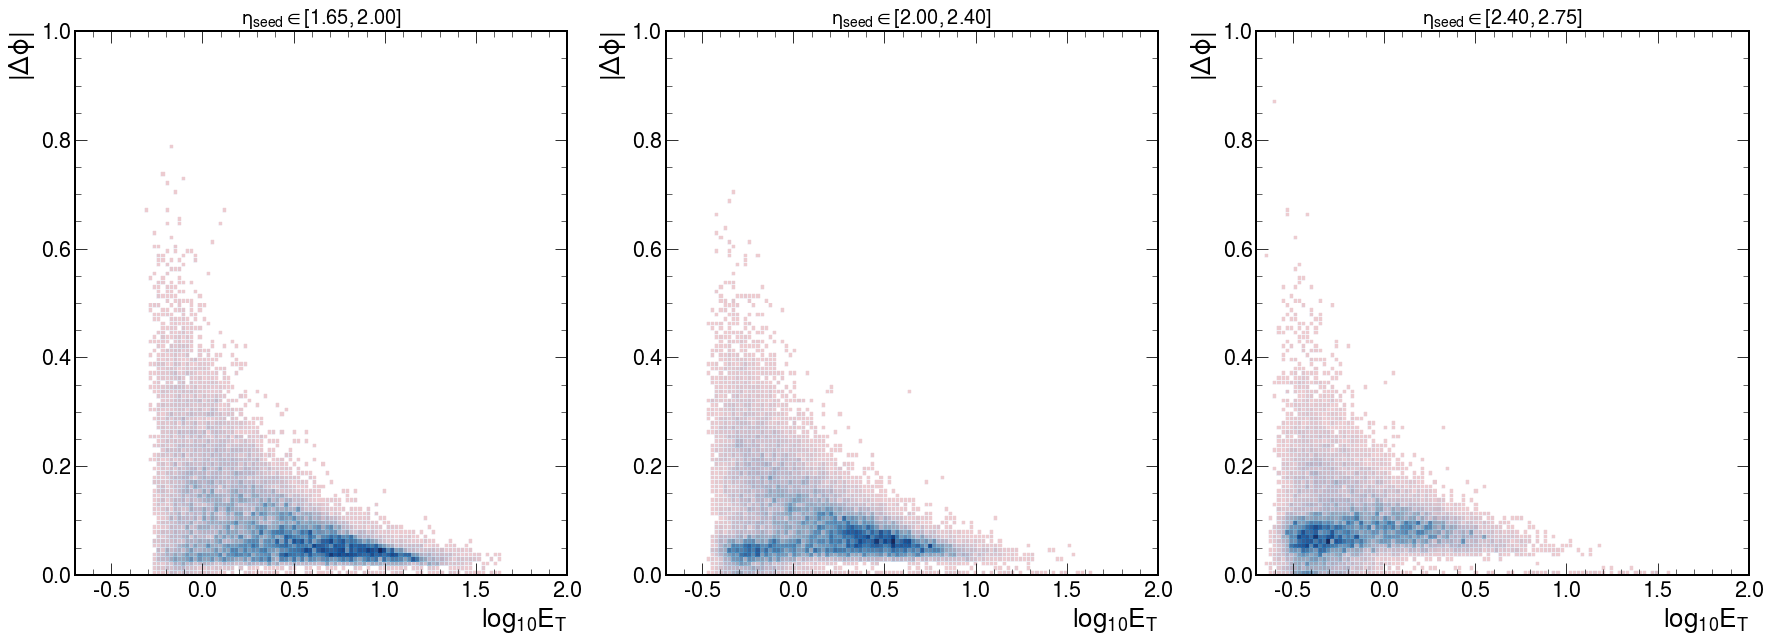

In [217]:
sel     = [len(deltaetas)>1 for deltaetas in deltas.DeltaEta]
binning = [1.65, 2.0, 2.4, 2.75] #binning from Moustache Run3
label   = '|\eta_{seed}|'
var     = 'EtaSeed'
nx      = 1
ny      = 3


plotDphiEt(deltas[sel], var, binning, label, nx, ny)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


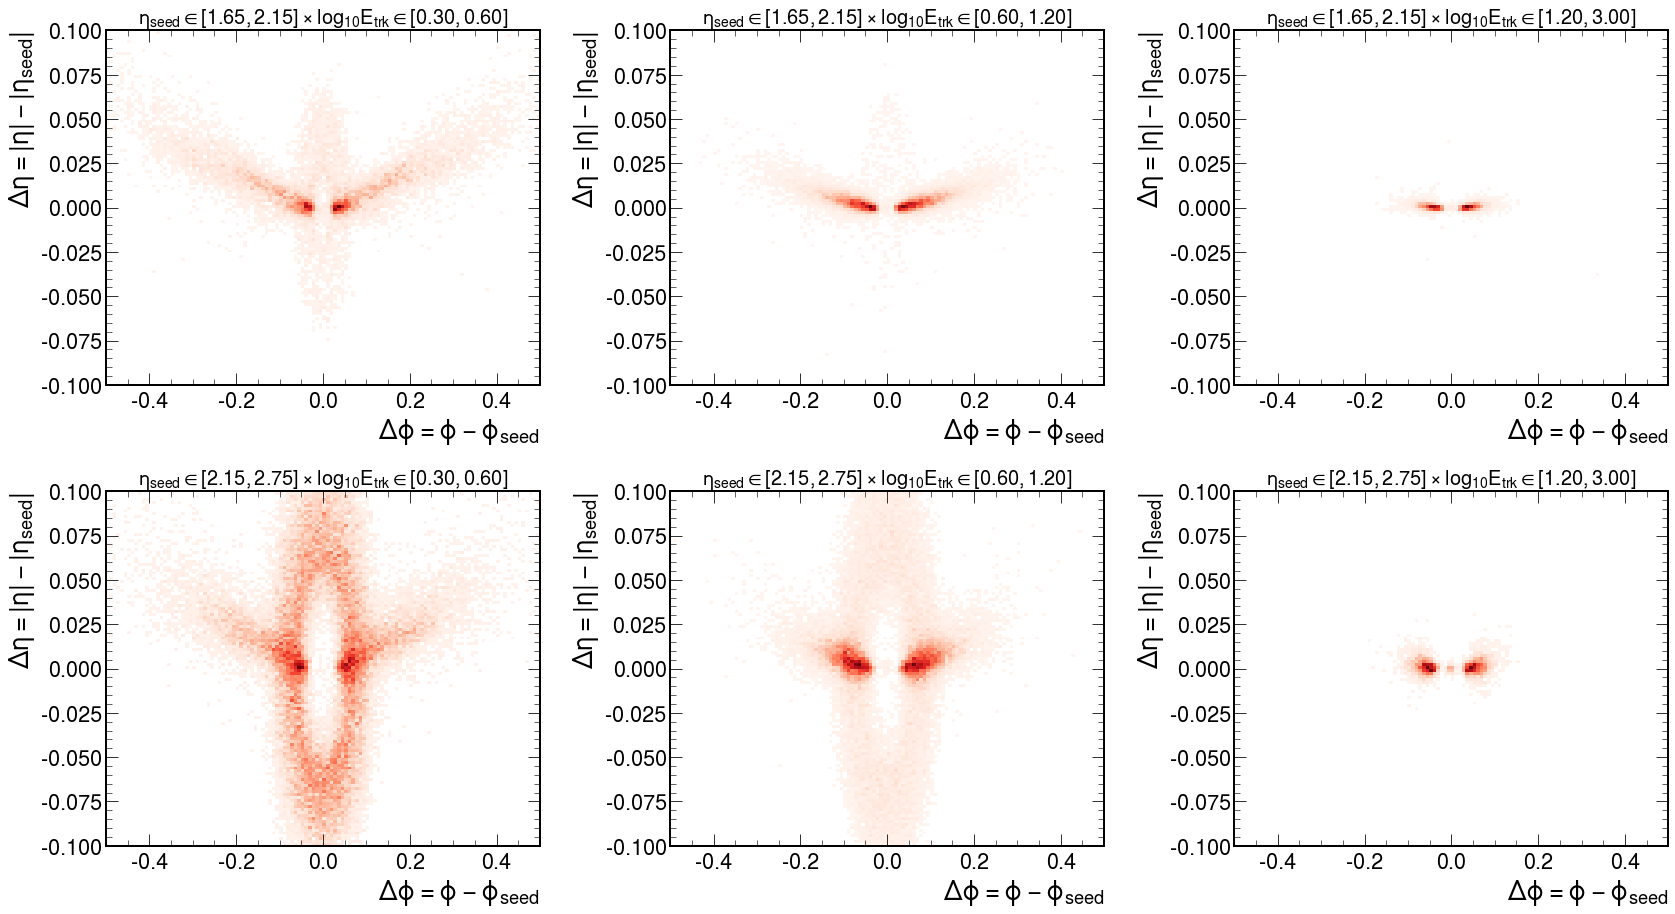

In [604]:
# sel     = [len(deltaetas)>1 for deltaetas in deltas.DeltaEta]
sel     = [len(deltaetas)>1 for deltaetas in deltas_noSkim.DeltaEta]
# binning = [1.65, 1.8, 2.0, 2.2, 2.4, 2.6, 2.75] #binning from Moustache Run3
binning = [1.65, 2.15, 2.75] #binning for thesis
# en_binning = [0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 5]
en_binning = [0.3, 0.6, 1.2, 3] #binning for thesis
label   = '|\eta_{seed}|'
var     = 'EtaSeed'
nx      = 2
ny      = 3
# fig_size = (30,110) #for Moustache Run3
fig_size = (28,15)

plotdeltasEtaEnBins(deltas_noSkim[sel], var, binning, en_binning, label, nx, ny, fig_size)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


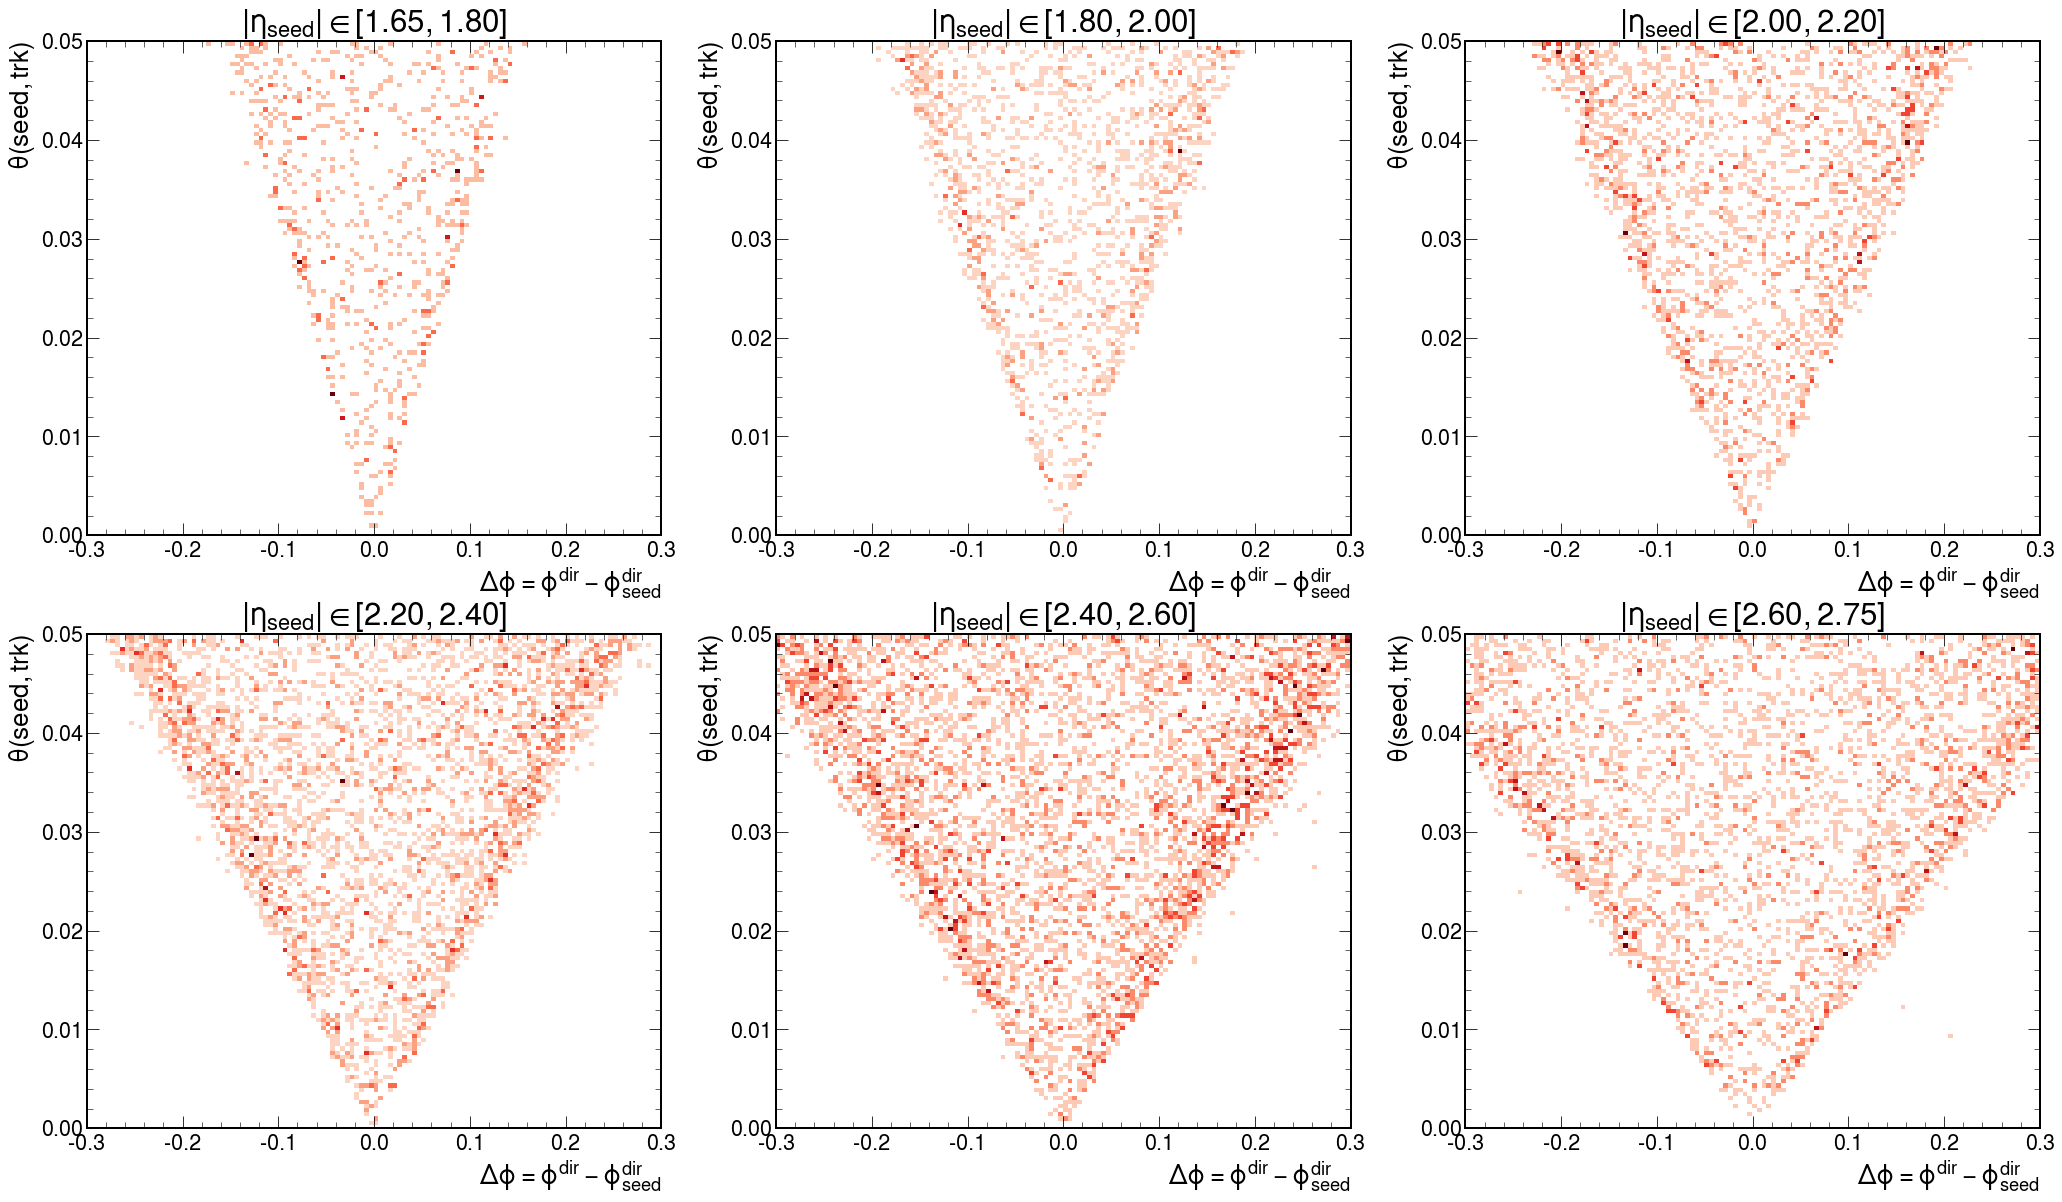

In [28]:
#Eta
sel     = [len(deltaetas)>1 for deltaetas in deltas.DeltaEta]
binning = [1.65, 1.8, 2.0, 2.2, 2.4, 2.6, 2.75] #binning from Moustache Run3
label   = '|\eta_{seed}|'
var     = 'EtaSeed'
nx      = 2
ny      = 3

#pT
# sel     = [len(deltaetas)>1 for deltaetas in deltas.DeltaEta]
# binning = histedges_equalN(deltas[sel].PtSeed, 6)
# label   = 'pT_{seed}'
# var     = 'PtSeed'
# nx      = 2
# ny      = 3

#En
# sel     = [len(deltaetas)>1 for deltaetas in deltas.DeltaEta]
# binning = histedges_equalN(deltas[sel].EnSeed, 6)
# label   = 'E_{seed}'
# var     = 'EnSeed'
# nx      = 2
# ny      = 3


#log10En
# sel     = [len(deltaetas)>1 for deltaetas in deltas.DeltaEta]
# binning = histedges_equalN(deltas[sel].log10E, 6)
# label   = 'log_{10}E'
# var     = 'log10E'
# nx      = 2
# ny      = 3


plotdeltasEtaBins(deltas[sel], var, binning, label, nx, ny)

# Mustache

In [497]:
def Phi_mpi_pi(x):
    if (x>= math.pi): x -= 2*math.pi
    elif (x<-math.pi): x += 2*math.pi
    return x


# Run3 parameters
def paramsDynamicDPhiWindow(ClustE, absSeedEta):  
    if absSeedEta>=1.479 and absSeedEta<1.75:
        _yoffset    = 0.0497038
        _scale      = 0.975707
        _xoffset    = -0.18149
        _width      = 0.431729
        _saturation = 0.14
        _cutoff     = 0.55
    
    elif absSeedEta>=1.75 and absSeedEta<2.0:
        _yoffset    = 0.05643
        _scale      = 1.60429
        _xoffset    = -0.642352
        _width      = 0.458106
        _saturation = 0.12
        _cutoff     = 0.45
        
    elif absSeedEta>=2.0 and absSeedEta<3.0:
        _yoffset    = 0.0928887
        _scale      = 1.22321
        _xoffset    = -0.260256
        _width      = 0.345852
        _saturation = 0.12
        _cutoff     = 0.3
        
    return _yoffset, _scale, _xoffset, _width, _saturation, _cutoff


def paramsinMustache():
#     _params = {"pUp": [-0.107537, 0.590969, -0.076494],
#               "pLow": [-0.0268843, 0.147742, -0.0191235],
#               "w0Up": [-0.00681785, -0.00239516],
#               "w1Up": [0.000699995, -0.00554331],
#               "w0Low": [-0.00681785, -0.00239516],
#               "w1Low": [0.000699995, -0.00554331]}

    #Run3 parameters
    _params = {"p00": -0.107537,
               "p01": 0.590969,
               "p02": -0.076494,
               "p10": -0.0268843,
               "p11": 0.147742,
               "p12": -0.0191235,
               "w00": -0.00681785,
               "w01": -0.00239516,
               "w10": 0.000699995,
               "w11": -0.00554331}
    
    return _params


def inDynamicDPhiWindow(seedEta, seedPhi, ClustE, ClusEta, ClusPhi):
        
    absSeedEta = abs(seedEta)
    logClustEt = math.log10(ClustE / math.cosh(ClusEta))
    clusDphi = abs(Phi_mpi_pi(seedPhi - ClusPhi))
            
    yoffset, scale, xoffset, width, saturation, cutoff  = paramsDynamicDPhiWindow(ClustE, absSeedEta) #Perche' gli si passa anche energia? 
            
    maxdphi = yoffset + scale / (1. + math.exp((logClustEt - xoffset) / width))
    maxdphi = min(maxdphi, cutoff)
    maxdphi = max(maxdphi, saturation)

    return clusDphi < maxdphi, maxdphi


def inMustache(seedEta, seedPhi, ClustE, ClusEta, ClusPhi, plot=False):

    params = paramsinMustache()
    
    sineta0 = math.sin(seedEta)
    eta0xsineta0 = seedEta * sineta0

    #2 parabolas (upper and lower)
    #of the form: y = a*x*x + b

    #b comes from a fit to the width
    #and has a slight dependence on E on the upper edge
    # this only works because of fine tuning :-D
    sqrt_log10_clustE = math.sqrt(math.log10(ClustE) + 1.1)
    # we need to have this in two steps, so that we don't improperly shift
    # the lower bound!
    
#     b_upper = params['w1Up'][0] * eta0xsineta0 + params['w1Up'][1] / sqrt_log10_clustE - 0.5 * (params['w1Up'][0] * eta0xsineta0 + params['w1Up'][1] / sqrt_log10_clustE + params['w0Up'][0] * eta0xsineta0 + params['w0Up'][1] / sqrt_log10_clustE)
#     b_lower = params['w0Low'][0] * eta0xsineta0 + params['w0Low'][1] / sqrt_log10_clustE - 0.5 * (params['w1Low'][0] * eta0xsineta0 + params['w1Low'][1] / sqrt_log10_clustE + params['w0Low'][0] * eta0xsineta0 + params['w0Low'][1] / sqrt_log10_clustE);
    b_upper = params["w10"] * eta0xsineta0 + params["w11"] / sqrt_log10_clustE
    b_lower = params["w00"] * eta0xsineta0 + params["w01"] / sqrt_log10_clustE
    midpoint = 0.5 * (b_upper + b_lower)
    b_upper -= midpoint
    b_lower -= midpoint
    
    #the curvature comes from a parabolic
    #fit for many slices in eta given a
    #slice -0.1 < log10(Et) < 0.1
#     curv_up = eta0xsineta0 * (params['pUp'][0] * eta0xsineta0 + params['pUp'][1]) + params['pUp'][2]
#     curv_low = eta0xsineta0 * (params['pLow'][0] * eta0xsineta0 + params['pLow'][1]) + params['pLow'][2];
    curv_up = eta0xsineta0 * (params["p00"] * eta0xsineta0 + params["p01"]) + params["p02"]
    curv_low = eta0xsineta0 * (params["p10"] * eta0xsineta0 + params["p11"]) + params["p12"]
    
    #solving for the curviness given the width of this particular point
    a_upper = (1 / (4 * curv_up)) - abs(b_upper)
    a_lower = (1 / (4 * curv_low)) - abs(b_lower)
    
    dphi = Phi_mpi_pi(ClusPhi - seedPhi)
    dphi2 = dphi * dphi
    # minimum offset is half a crystal width in either direction
    # because science.
    upper_cut = (max((1. / (4. * a_upper)), 0.0) * dphi2 + max(b_upper, 0.0087)) + 0.0087
    lower_cut = (max((1. / (4. * a_lower)), 0.0) * dphi2 + min(b_lower, -0.0087))

    #if(deta < upper_cut && deta > lower_cut) inMust=true;

    deta = (1 - 2 * (seedEta < 0)) * (ClusEta - seedEta)  # sign flip deta
    
    return (deta < upper_cut) and (deta > lower_cut)


def plot_upper(_x, seedEta, ClustE):
    
    params = paramsinMustache()
    
    sineta0 = math.sin(seedEta)
    eta0xsineta0 = seedEta * sineta0

    sqrt_log10_clustE = math.sqrt(math.log10(ClustE) + 1.1)
    b_upper = params["w10"] * eta0xsineta0 + params["w11"] / sqrt_log10_clustE
    b_lower = params["w00"] * eta0xsineta0 + params["w01"] / sqrt_log10_clustE
    midpoint = 0.5 * (b_upper + b_lower)
    b_upper -= midpoint
    b_lower -= midpoint
    curv_up = eta0xsineta0 * (params["p00"] * eta0xsineta0 + params["p01"]) + params["p02"]
    a_upper = (1 / (4 * curv_up)) - abs(b_upper)
    
    return (max((1. / (4. * a_upper)), 0.0) * _x**2 + max(b_upper, 0.0087)) + 0.0087


def plot_lower(_x, seedEta, ClustE): #Da capire bene se e' Et oppure E
    
    params = paramsinMustache()
    
    sineta0 = math.sin(seedEta)
    eta0xsineta0 = seedEta * sineta0
    sqrt_log10_clustE = math.sqrt(math.log10(ClustE) + 1.1)
    b_upper = params["w10"] * eta0xsineta0 + params["w11"] / sqrt_log10_clustE
    b_lower = params["w00"] * eta0xsineta0 + params["w01"] / sqrt_log10_clustE
    midpoint = 0.5 * (b_upper + b_lower)
    b_upper -= midpoint
    b_lower -= midpoint
    curv_low = eta0xsineta0 * (params["p10"] * eta0xsineta0 + params["p11"]) + params["p12"]
    a_lower = (1 / (4 * curv_low)) - abs(b_lower)
    
    return (max((1. / (4. * a_lower)), 0.0) * _x**2 + min(b_lower, -0.0087))

In [590]:
def runMustache(evt, display=True):
    ## Event display
    if display:
        print('cluster ', evt)       
        eventDisplay(ele[evt], removeTrk=True)
        
    sel = ele[evt].skim.astype(bool) == False
    
#     print(sel)

    #Prepare array
    X = np.array([ele[evt].multi_eta[sel], ele[evt].multi_phi[sel], ele[evt].multi_en[sel], ele[evt].multi_pt[sel], np.array(ele[evt].multi_index)[sel]])
    
    _isMus = []
#     print(X)
    while X[3][X[3]>1].size>0:
        maxidx = np.argmax(X[3][X[3]>1]) #maxEt trackster among tracksters with Et > 1 GeV (for electrons Et=pT)

        maxeta = X[0][maxidx]
        maxphi = X[1][maxidx]
        maxe = X[2][maxidx]

#         _isMus = []
        for i in range(len(X[0])): #Loop over tracksters in event
            if i == maxidx: 
                _isMus.append('seed')
                continue #Skip if the trackster is the seed
            if X[2][i] < pow(10, -1.1): 
                _isMus.append(False)
            else: 
                inDynDPhi_flag, dphiwindow = inDynamicDPhiWindow(maxeta, maxphi, X[2][i], X[0][i], X[1][i])
                if display: print('Dynamic DPhi: ',inDynDPhi_flag)
                inMus_flag = inMustache(maxeta, maxphi, X[2][i], X[0][i], X[1][i])
                if display: print('Mustache separation: ',inMus_flag)
                _isMus.append(inMus_flag and inDynDPhi_flag)
                
#             isMus = _isMus
#             isMus[maxeta, maxphi, maxe, maxidx] = _isMus #Here we make 

            if display:
                fig, ax = plt.subplots(1, 1, figsize=(12,8))
                cmap = plt.get_cmap("tab10")
                yp = (1 - 2 * (maxeta < 0)) * (X[0][i] - maxeta) #DeltaEta
                xp = X[1][i] - maxphi #DeltaPhi
                print(X[4][i])
                ax.scatter(xp, yp, s=250, marker='.', color=cmap(int(X[4][i])))
                ax.scatter(0, 0, s=250, marker='.', color=cmap(int(X[4][maxidx])))
                ## Only for plot in thesis
#                 ax.scatter(xp, yp, s=350, marker='.', color='tab:blue')
#                 ax.scatter(0, 0, s=350, marker='.', color='tab:red')

                x = np.linspace(-0.5, 0.5, 2000)
                y = plot_upper(x, maxeta, math.log10(X[2][i]))
                ax.plot(x, y, '--', color='black')

                y = plot_lower(x, maxeta, math.log10(X[2][i]))
                ax.plot(x, y, '--', color='black')

                ax.axvline(x=dphiwindow, ls='--', color='black')
                ax.axvline(x=-dphiwindow, ls='--', color='black')

                ax.set_xlim(-dphiwindow-0.1,dphiwindow+0.1)
                ax.set_xlabel(r'$\Delta\phi=\phi-\phi_{seed}$')
                ax.set_ylabel(r'$\Delta\eta=|\eta|-|\eta_{seed}|$')
                ## Only for plot in thesis
                ax.set_ylim([-0.02,0.075])
                plt.savefig('moustache.pdf', dpi=150, bbox_inches='tight')
                plt.show()
                print('------------------------------------------------------------')
                
#         _isMus = np.array(_isMus)
#         break #We want to run moustache only once 
        X = np.array([[X[j][i] for i in range(len(X[0])) if i in np.where(_isMus=='False')[0]] for j in range(len(X))]) #Remove superclustered tracksters and seed from list

    return _isMus



cluster  3
------- Event information -------
event, sample, eta: 5 109 1
------- Gun information -------
eta gun: 1.744
phi gun: 2.553
En gun: 80.148
ID gun: 11
pT gun: 27.194
blue  - energy: 17.469  - eta: 1.746  - phi: 2.627  - pt: 5.915  - dEta: 0.002  - dPhi: 0.066     0.996         False      False
red  - energy: 58.889  - eta: 1.744  - phi: 2.56  - pt: 19.981  - dEta: 0.0  - dPhi: 0.0     0.997         False      False


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


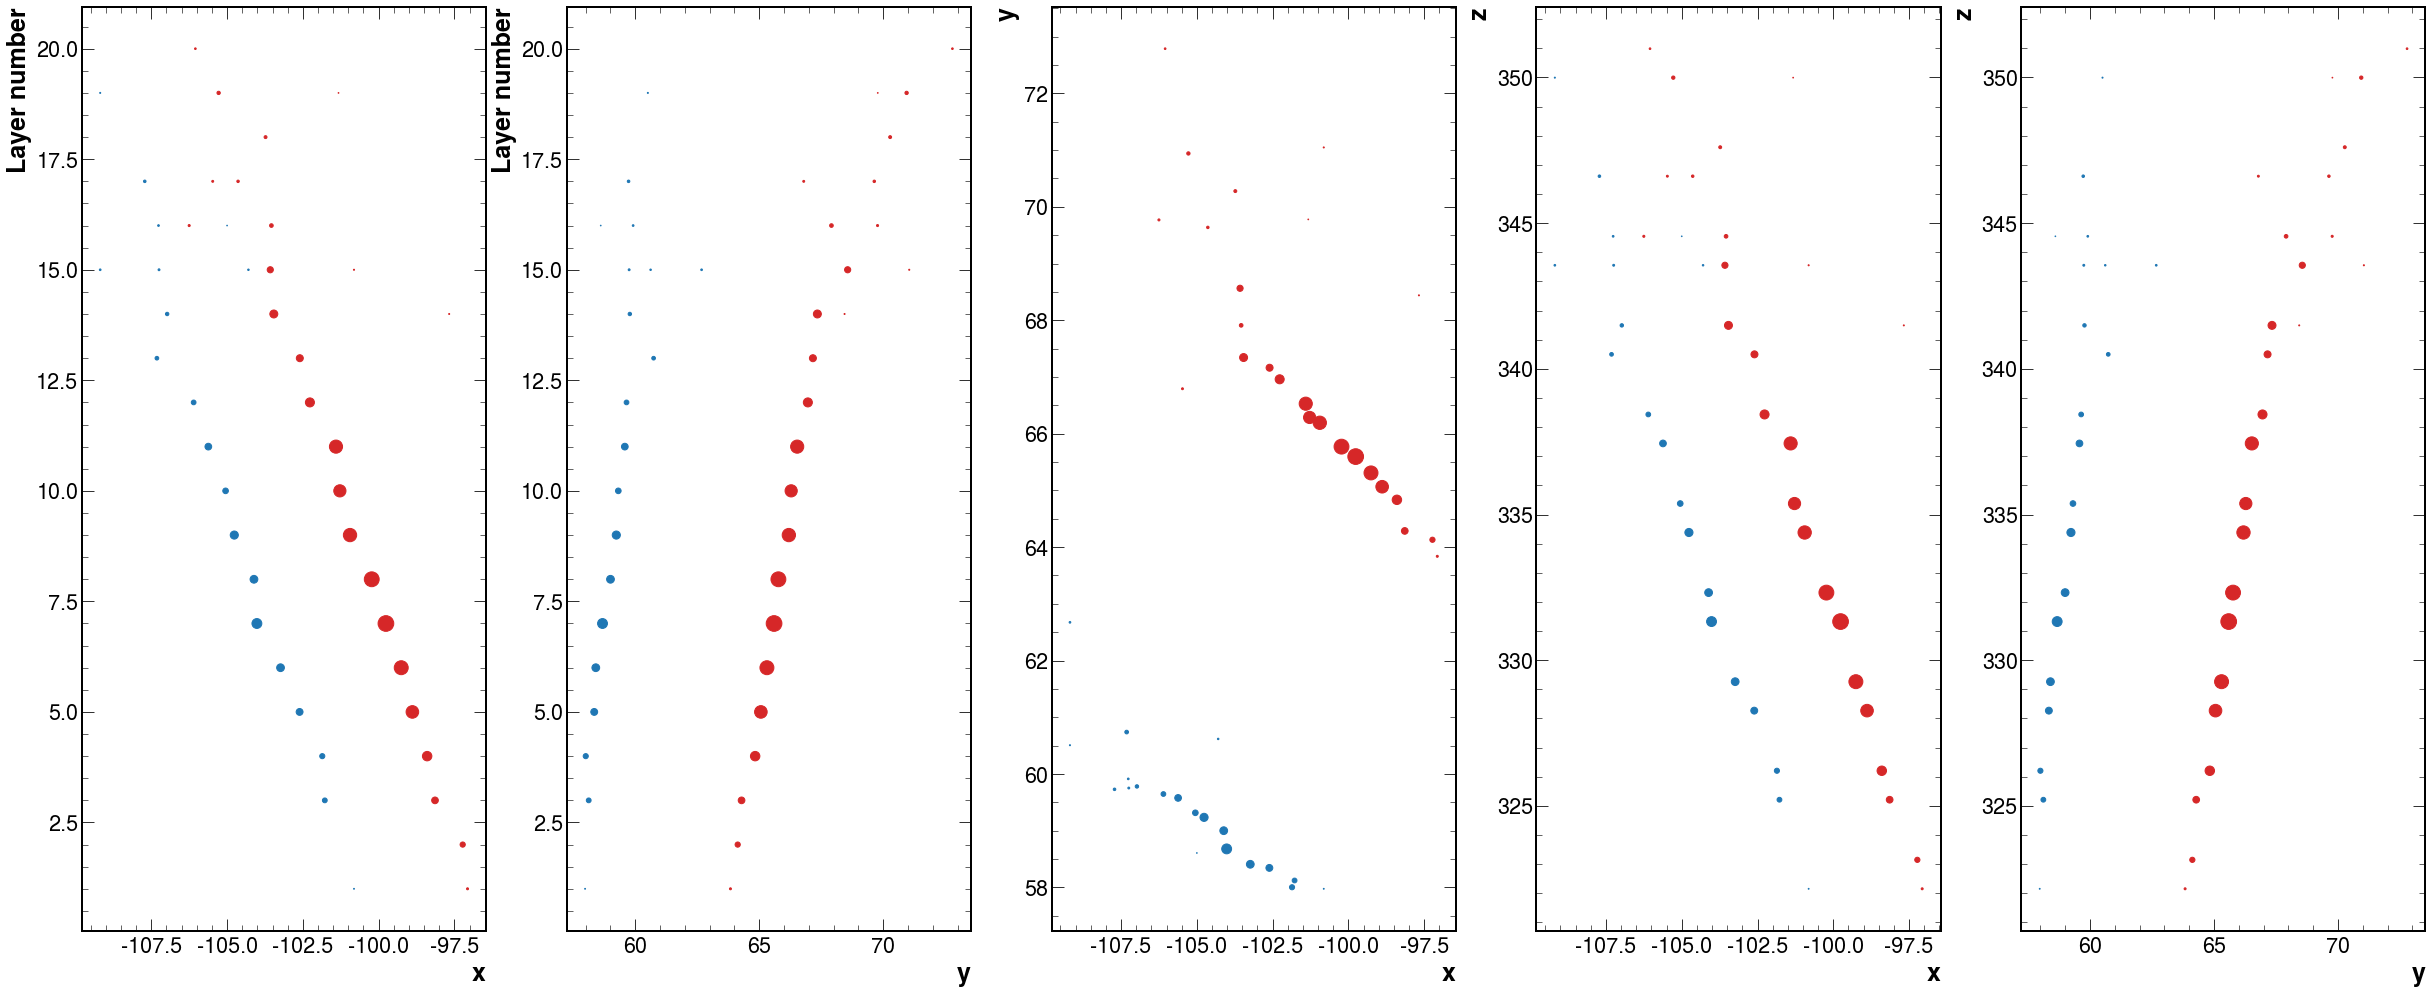

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


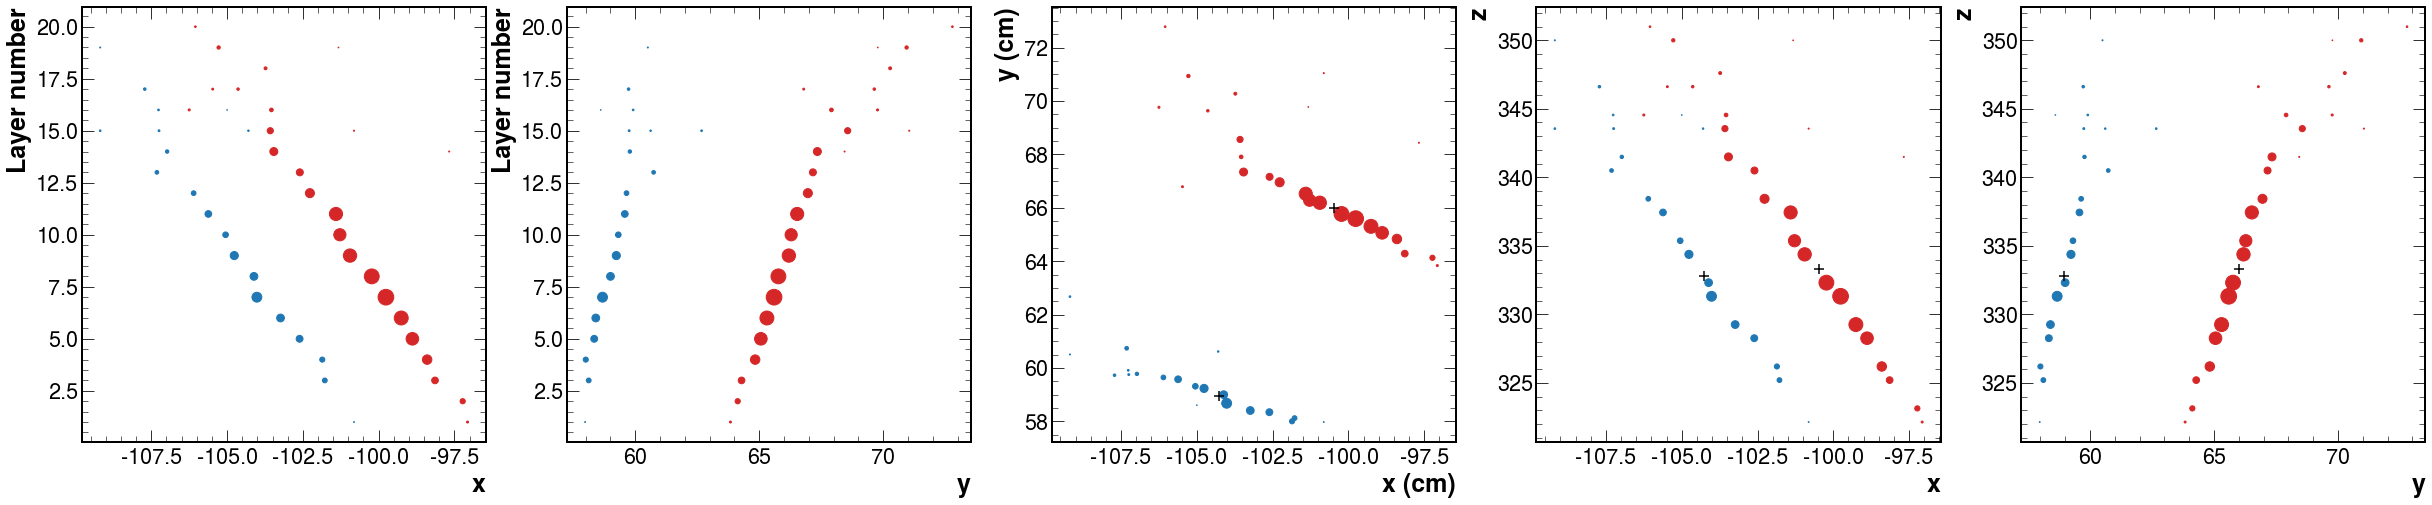

Dynamic DPhi:  True
Mustache separation:  True
0.0


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


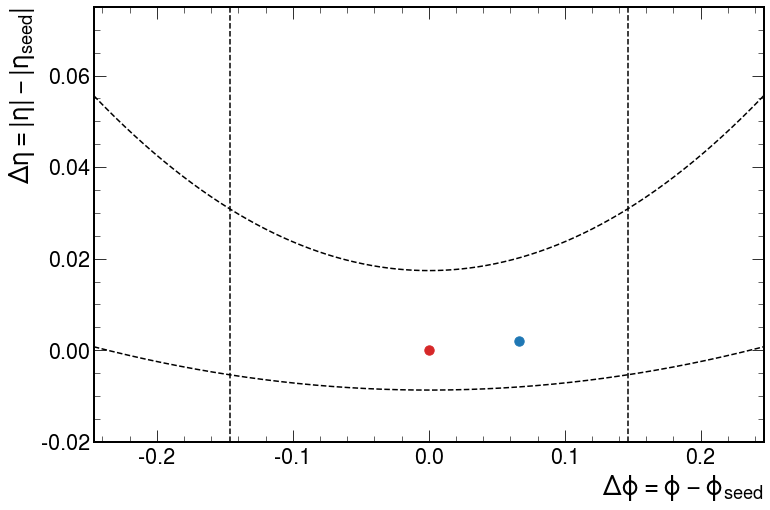

------------------------------------------------------------


In [591]:
tmp = runMustache(3, True)

In [58]:
moustache = [runMustache(i, False) for i in range(len(ele))]

In [117]:
superclusterEn = np.array([sum(el.multi_en[(el.skim == False)][(np.array(moustache[i])=='True') | (np.array(moustache[i])=='seed')]) for i, el in enumerate(ele)])
recoEn = np.array([sum(el.multi_en) for i, el in enumerate(ele)])

/home/llr/cms/tarabini/miniconda3/envs/torchtest/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [96]:
gun_en = np.array([el.gunEn for el in ele])

In [93]:
enBins = histedges_equalN(gun_en, 10)
bins_mean = [(enBins[i]+enBins[i+1])/2 for i in range(len(enBins)-1)]

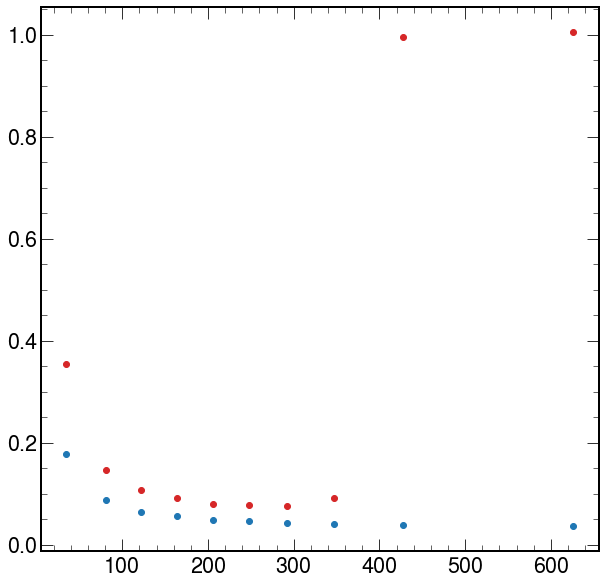

In [118]:
for i in range(len(enBins)-1):
    reco = superclusterEn[(gun_en>enBins[i])&(gun_en<enBins[i+1])]
    gen  = gun_en[(gun_en>enBins[i])&(gun_en<enBins[i+1])]
    res = (reco/gen)
    median = np.median( res )
    width  = np.percentile(res, 84.13) - np.percentile(res, 15.87)
    
    plt.plot(bins_mean[i], width/median, 'o-', color='tab:red') 
    
    reco = recoEn[(gun_en>enBins[i])&(gun_en<enBins[i+1])]
    res = (reco/gen)
    median = np.median( res )
    width  = np.percentile(res, 84.13) - np.percentile(res, 15.87)
    
    plt.plot(bins_mean[i], width/median, 'o-', color='tab:blue') 
    
plt.show()
